!pip install medmnist

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

c:\Users\marus\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\marus\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
c:\Users\marus\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


# Let's use 3 2D models for a 3D dataset with size 28x28x28

In [121]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

100%|██████████| 32657349/32657349 [00:42<00:00, 774260.62it/s] 


Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d.npz


In [122]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


## Extract 2d slices

In [123]:
def extract_slices(data):
    axial_slices = []
    coronal_slices = []
    sagittal_slices = []
    targets = []

    for batch, target in data:
        image = batch[0]
        # Assuming image is a numpy array of shape (depth, height, width)
        # Extract the middle slice from each dimension
        axial_slices.append(image[image.shape[0] // 2, :, :][..., np.newaxis])
        coronal_slices.append(image[:, image.shape[1] // 2, :][..., np.newaxis])
        sagittal_slices.append(image[:, :, image.shape[2] // 2][..., np.newaxis])
        targets.append(target)

    return np.array(axial_slices, dtype='f'), np.array(coronal_slices, dtype='f'), np.array(sagittal_slices, dtype='f'), targets
    
train_axial_slices, train_coronal_slices, train_sagittal_slices, train_targets = extract_slices(train_dataset)
test_axial_slices, test_coronal_slices, test_sagittal_slices, test_targets = extract_slices(test_dataset)

In [124]:
train_axial_slices[..., -1].shape

(971, 28, 28)

In [125]:
class SliceDataset(data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def montage(self, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset'):
        from medmnist.utils import montage2d

        n_sel = length * length
        sel = np.random.choice(self.__len__(), size=n_sel, replace=replace)

        montage_img = montage2d(imgs=(self.images[..., -1]*255).astype(np.uint8),
                                n_channels=n_channels,
                                sel=sel)
        
        if save_folder is not None:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            montage_img.save(os.path.join(save_folder,
                                          f"{data_flag}_montage.png"))

        return montage_img

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_axial_dataset = SliceDataset(train_axial_slices, train_targets, transform=data_transform)
train_coronal_dataset = SliceDataset(train_coronal_slices, train_targets, transform=data_transform)
train_sagittal_dataset = SliceDataset(train_sagittal_slices, train_targets, transform=data_transform)

test_axial_dataset = SliceDataset(test_axial_slices, test_targets, transform=data_transform)
test_coronal_dataset = SliceDataset(test_coronal_slices, test_targets, transform=data_transform)
test_sagittal_dataset = SliceDataset(test_sagittal_slices, test_targets, transform=data_transform)

# And then data loaders
train_axial_loader = data.DataLoader(train_axial_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_coronal_loader = data.DataLoader(train_coronal_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_sagittal_loader = data.DataLoader(train_sagittal_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_axial_loader = data.DataLoader(test_axial_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_coronal_loader = data.DataLoader(test_coronal_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_sagittal_loader = data.DataLoader(test_sagittal_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [126]:
x, y = train_axial_dataset[0]

print(x.shape, y.shape)

torch.Size([1, 28, 28]) (1,)


In [127]:
for x, y in test_axial_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128, 1])


### Let's see the images we chose

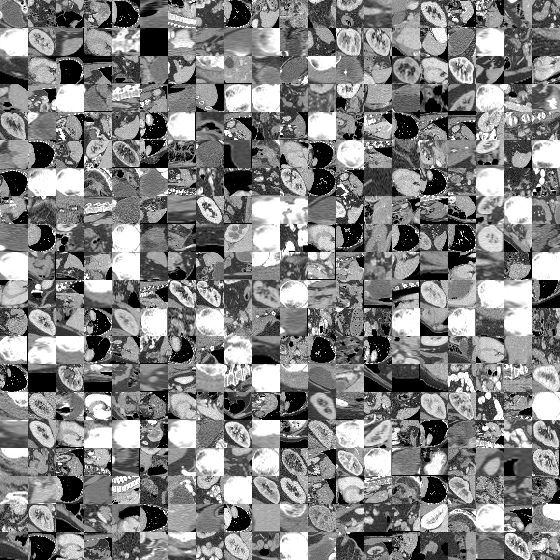

In [128]:
train_axial_dataset.montage()

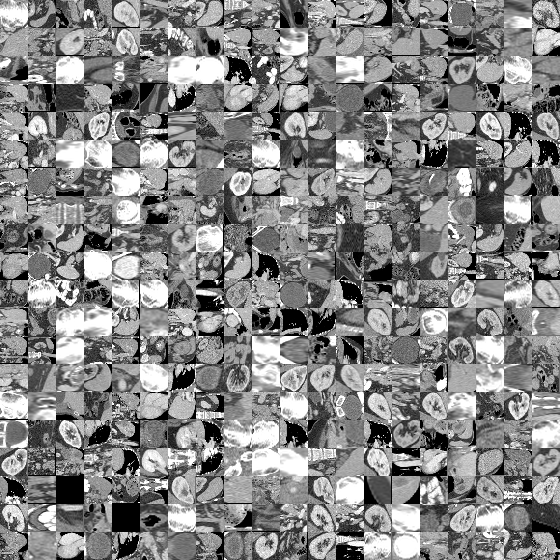

In [129]:
train_coronal_dataset.montage()

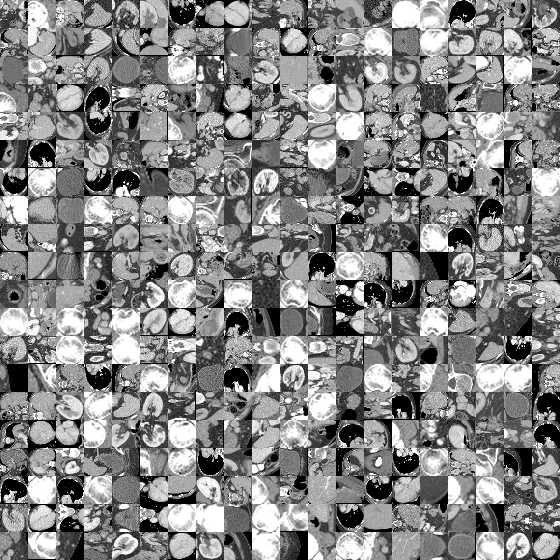

In [130]:
train_sagittal_dataset.montage()

## Training model

In [131]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [132]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_axial_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 8/8 [00:00<00:00, 10.46it/s]


In [133]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_axial_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.520  acc:0.113


## Repeat for all 3 directions

In [134]:
model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [135]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_coronal_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 8/8 [00:00<00:00,  9.32it/s]


In [136]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_coronal_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.491  acc:0.118


In [137]:
model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [138]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_sagittal_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 8/8 [00:00<00:00,  9.84it/s]


In [139]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_sagittal_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.469  acc:0.079


# Let's now work with a 3D dataset with size 64x64x64

In [80]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz


In [81]:
print(info)

{'python_class': 'OrganMNIST3D', 'description': 'The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.', 'url': 'https://zenodo.org/records/10519652/files/organmnist3d.npz?download=1', 'MD5': 'a0c5a1ff56af4f155c46d46fbb45a2fe', 'url_64': 'https://zenodo.org/records/10519652/files/organmnist3d_64.npz?download=1', 'MD5_64': '58a2205adf14a9d0a189cb06dc78bf10', 'task': 'multi-class', 'label': {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancr

In [82]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: C:\Users\marus\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

In [83]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [84]:
def extract_slices(data):
    axial_slices = []
    coronal_slices = []
    sagittal_slices = []
    targets = []

    for batch, target in data:
        image = batch[0]
        # Assuming image is a numpy array of shape (depth, height, width)
        # Extract the middle slice from each dimension
        axial_slices.append(image[image.shape[0] // 2, :, :][..., np.newaxis])
        coronal_slices.append(image[:, image.shape[1] // 2, :][..., np.newaxis])
        sagittal_slices.append(image[:, :, image.shape[2] // 2][..., np.newaxis])
        targets.append(target)

    return np.array(axial_slices, dtype='f'), np.array(coronal_slices, dtype='f'), np.array(sagittal_slices, dtype='f'), targets

train_axial_slices, train_coronal_slices, train_sagittal_slices, train_targets = extract_slices(train_dataset)
test_axial_slices, test_coronal_slices, test_sagittal_slices, test_targets = extract_slices(test_dataset)

In [85]:
train_axial_slices.shape

(971, 64, 64, 1)

In [86]:
class SliceDataset(data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def montage(self, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset'):
        from medmnist.utils import montage2d

        n_sel = length * length
        sel = np.random.choice(self.__len__(), size=n_sel, replace=replace)

        montage_img = montage2d(imgs=(self.images[..., -1]*255).astype(np.uint8),
                                n_channels=n_channels,
                                sel=sel)
        
        if save_folder is not None:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            montage_img.save(os.path.join(save_folder,
                                          f"{data_flag}_montage.png"))

        return montage_img

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [87]:
train_axial_dataset = SliceDataset(train_axial_slices, train_targets, transform=data_transform)
train_coronal_dataset = SliceDataset(train_coronal_slices, train_targets, transform=data_transform)
train_sagittal_dataset = SliceDataset(train_sagittal_slices, train_targets, transform=data_transform)

test_axial_dataset = SliceDataset(test_axial_slices, test_targets, transform=data_transform)
test_coronal_dataset = SliceDataset(test_coronal_slices, test_targets, transform=data_transform)
test_sagittal_dataset = SliceDataset(test_sagittal_slices, test_targets, transform=data_transform)

# And then data loaders
train_axial_loader = data.DataLoader(train_axial_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_coronal_loader = data.DataLoader(train_coronal_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_sagittal_loader = data.DataLoader(train_sagittal_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_axial_loader = data.DataLoader(test_axial_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_coronal_loader = data.DataLoader(test_coronal_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_sagittal_loader = data.DataLoader(test_sagittal_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [88]:
idx = np.random.choice(train_axial_dataset.__len__(), size=10, replace=False)

idx

array([259, 272, 556,  41,  47, 765, 458, 292,  65,  45])

In [89]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(1,10)

    for i, index in enumerate(idx):
        x, y = dataset[index]

        ax = axs[i]
        ax.imshow(x[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(15,5))
    plt.show()

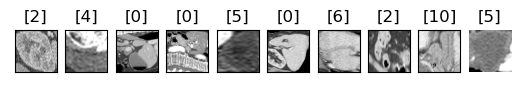

<Figure size 1500x500 with 0 Axes>

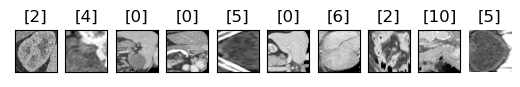

<Figure size 1500x500 with 0 Axes>

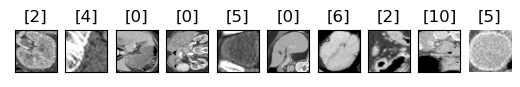

<Figure size 1500x500 with 0 Axes>

In [90]:
show_slice(train_axial_dataset, idx)
show_slice(train_coronal_dataset, idx)
show_slice(train_sagittal_dataset, idx)

### Let's see the images we chose

c:\Users\marus\anaconda3\lib\site-packages\medmnist\utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


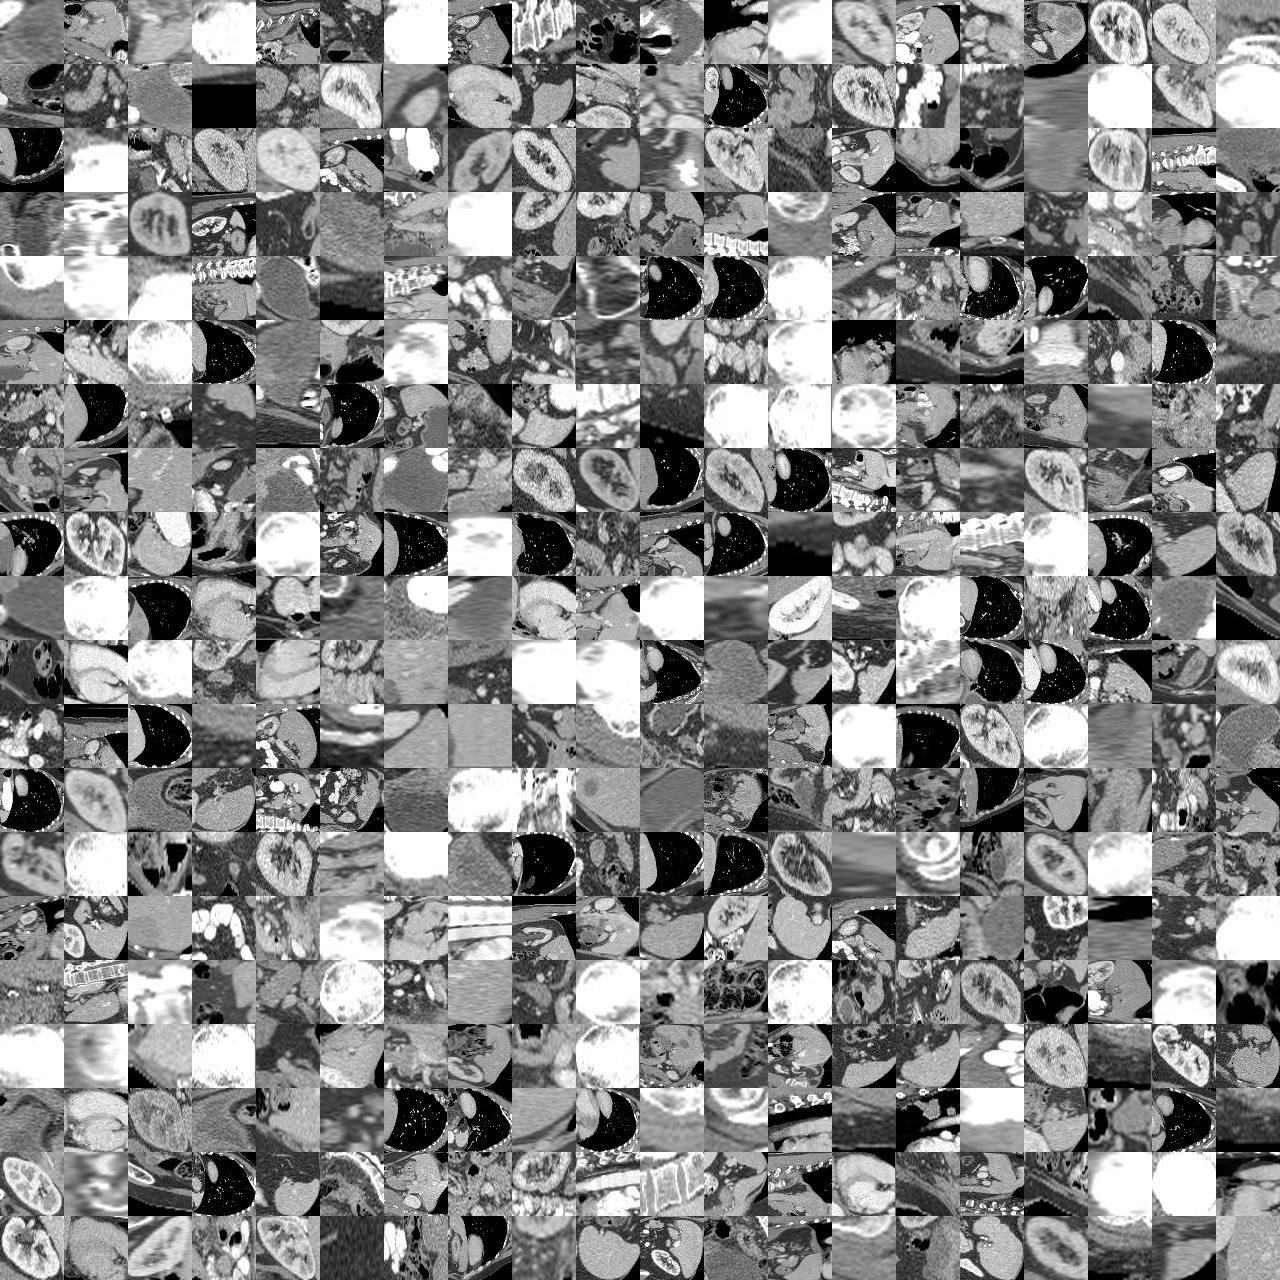

In [91]:
train_axial_dataset.montage()

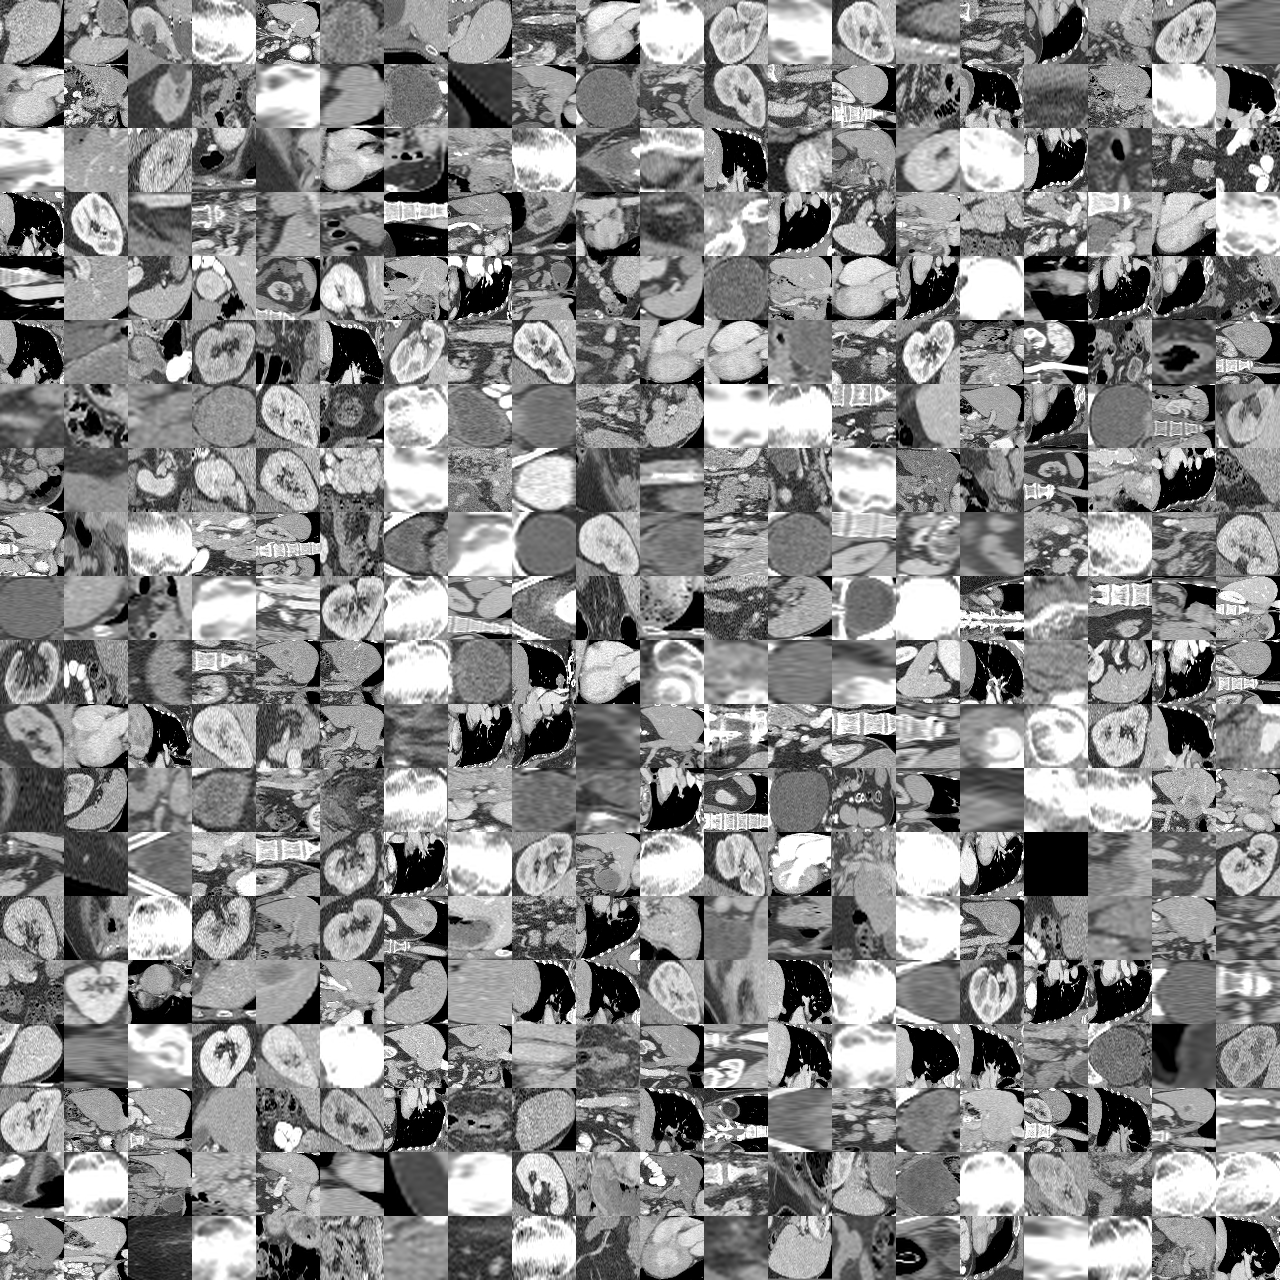

In [92]:
train_coronal_dataset.montage()

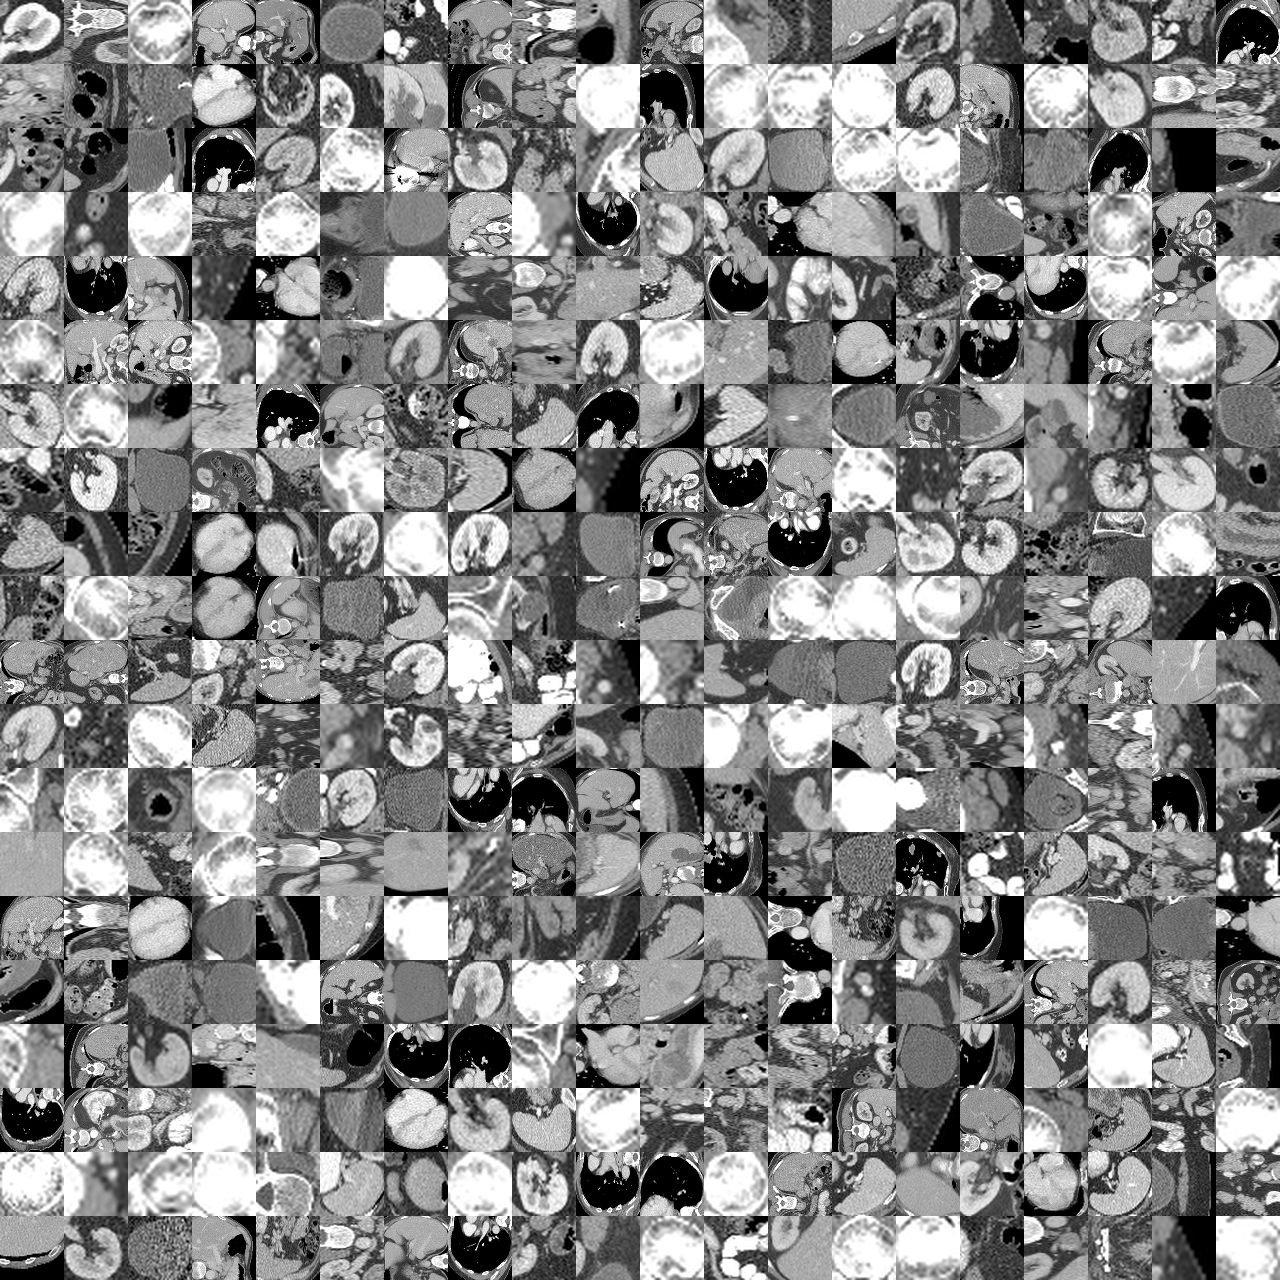

In [93]:
train_sagittal_dataset.montage()

In [94]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [95]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 1)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [96]:
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=n_classes)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [98]:
# train

for epoch in range(NUM_EPOCHS):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{NUM_EPOCHS}")
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_axial_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        # print(f"train_loss: {loss:.4f}")
        
        loss.backward()
        optimizer.step()
    
    print(f"train_loss: {loss:.4f}")

----------
epoch 1/100


100%|██████████| 31/31 [00:38<00:00,  1.25s/it]


train_loss: 1.0318
----------
epoch 2/100


100%|██████████| 31/31 [00:42<00:00,  1.38s/it]


train_loss: 1.0824
----------
epoch 3/100


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


train_loss: 0.9215
----------
epoch 4/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 1.2857
----------
epoch 5/100


100%|██████████| 31/31 [00:51<00:00,  1.67s/it]


train_loss: 0.4350
----------
epoch 6/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 1.3515
----------
epoch 7/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.2112
----------
epoch 8/100


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


train_loss: 0.7873
----------
epoch 9/100


100%|██████████| 31/31 [00:51<00:00,  1.67s/it]


train_loss: 0.2568
----------
epoch 10/100


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


train_loss: 0.3838
----------
epoch 11/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.3434
----------
epoch 12/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.3384
----------
epoch 13/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.2405
----------
epoch 14/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.6760
----------
epoch 15/100


100%|██████████| 31/31 [00:47<00:00,  1.55s/it]


train_loss: 0.3647
----------
epoch 16/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.5006
----------
epoch 17/100


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


train_loss: 0.7424
----------
epoch 18/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.1235
----------
epoch 19/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.2247
----------
epoch 20/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.1377
----------
epoch 21/100


100%|██████████| 31/31 [00:48<00:00,  1.55s/it]


train_loss: 0.1611
----------
epoch 22/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.0057
----------
epoch 23/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0038
----------
epoch 24/100


100%|██████████| 31/31 [00:51<00:00,  1.66s/it]


train_loss: 0.0812
----------
epoch 25/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0369
----------
epoch 26/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 1.4928
----------
epoch 27/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0871
----------
epoch 28/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.0765
----------
epoch 29/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.0783
----------
epoch 30/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.1938
----------
epoch 31/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.3272
----------
epoch 32/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0357
----------
epoch 33/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0450
----------
epoch 34/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.0574
----------
epoch 35/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0540
----------
epoch 36/100


100%|██████████| 31/31 [00:48<00:00,  1.55s/it]


train_loss: 0.1437
----------
epoch 37/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.0196
----------
epoch 38/100


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


train_loss: 0.0184
----------
epoch 39/100


100%|██████████| 31/31 [00:49<00:00,  1.59s/it]


train_loss: 0.0857
----------
epoch 40/100


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


train_loss: 0.0978
----------
epoch 41/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0076
----------
epoch 42/100


100%|██████████| 31/31 [00:55<00:00,  1.81s/it]


train_loss: 0.0083
----------
epoch 43/100


100%|██████████| 31/31 [01:00<00:00,  1.94s/it]


train_loss: 0.0033
----------
epoch 44/100


100%|██████████| 31/31 [00:57<00:00,  1.85s/it]


train_loss: 0.0045
----------
epoch 45/100


100%|██████████| 31/31 [00:56<00:00,  1.83s/it]


train_loss: 0.0193
----------
epoch 46/100


100%|██████████| 31/31 [00:56<00:00,  1.83s/it]


train_loss: 0.0014
----------
epoch 47/100


100%|██████████| 31/31 [00:56<00:00,  1.81s/it]


train_loss: 0.3053
----------
epoch 48/100


100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


train_loss: 0.0175
----------
epoch 49/100


100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


train_loss: 0.0609
----------
epoch 50/100


100%|██████████| 31/31 [00:57<00:00,  1.86s/it]


train_loss: 0.0019
----------
epoch 51/100


100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


train_loss: 0.0150
----------
epoch 52/100


100%|██████████| 31/31 [00:56<00:00,  1.81s/it]


train_loss: 0.0028
----------
epoch 53/100


100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


train_loss: 0.0091
----------
epoch 54/100


100%|██████████| 31/31 [00:57<00:00,  1.84s/it]


train_loss: 0.0384
----------
epoch 55/100


100%|██████████| 31/31 [00:55<00:00,  1.81s/it]


train_loss: 0.0082
----------
epoch 56/100


100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


train_loss: 0.0019
----------
epoch 57/100


100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


train_loss: 0.0180
----------
epoch 58/100


100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


train_loss: 0.0546
----------
epoch 59/100


100%|██████████| 31/31 [00:59<00:00,  1.92s/it]


train_loss: 0.0325
----------
epoch 60/100


100%|██████████| 31/31 [00:56<00:00,  1.84s/it]


train_loss: 0.0240
----------
epoch 61/100


100%|██████████| 31/31 [00:54<00:00,  1.76s/it]


train_loss: 0.0010
----------
epoch 62/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0149
----------
epoch 63/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0134
----------
epoch 64/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0044
----------
epoch 65/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 0.0181
----------
epoch 66/100


100%|██████████| 31/31 [00:48<00:00,  1.55s/it]


train_loss: 0.0088
----------
epoch 67/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.2148
----------
epoch 68/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 1.7348
----------
epoch 69/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.0113
----------
epoch 70/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0781
----------
epoch 71/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 0.1452
----------
epoch 72/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.0043
----------
epoch 73/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0123
----------
epoch 74/100


100%|██████████| 31/31 [00:46<00:00,  1.52s/it]


train_loss: 0.1014
----------
epoch 75/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 0.0808
----------
epoch 76/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0034
----------
epoch 77/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0718
----------
epoch 78/100


100%|██████████| 31/31 [00:50<00:00,  1.62s/it]


train_loss: 0.1203
----------
epoch 79/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.5164
----------
epoch 80/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 0.0070
----------
epoch 81/100


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


train_loss: 0.0175
----------
epoch 82/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0020
----------
epoch 83/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0034
----------
epoch 84/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 0.0023
----------
epoch 85/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0010
----------
epoch 86/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0144
----------
epoch 87/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0052
----------
epoch 88/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0007
----------
epoch 89/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0161
----------
epoch 90/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 0.0053
----------
epoch 91/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.0117
----------
epoch 92/100


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


train_loss: 0.0029
----------
epoch 93/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 0.0007
----------
epoch 94/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0017
----------
epoch 95/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


train_loss: 0.0006
----------
epoch 96/100


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


train_loss: 0.0049
----------
epoch 97/100


100%|██████████| 31/31 [00:50<00:00,  1.62s/it]


train_loss: 0.0005
----------
epoch 98/100


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


train_loss: 0.3807
----------
epoch 99/100


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


train_loss: 0.0248
----------
epoch 100/100


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]

train_loss: 0.0063


In [99]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_axial_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('test')

==> Evaluating ...
test  auc: 0.493  acc:0.102


## Repeat for all 3 directions

In [100]:
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=n_classes)

In [101]:
# train

for epoch in range(NUM_EPOCHS):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{NUM_EPOCHS}")
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_coronal_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        print(f"train_loss: {loss:.4f}")
        
        loss.backward()
        optimizer.step()

----------
epoch 1/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7629


  3%|▎         | 1/31 [00:01<00:45,  1.51s/it]

train_loss: 2.7748


  6%|▋         | 2/31 [00:03<00:44,  1.53s/it]

train_loss: 2.5486


 10%|▉         | 3/31 [00:04<00:42,  1.51s/it]

train_loss: 2.5684


 13%|█▎        | 4/31 [00:05<00:40,  1.49s/it]

train_loss: 2.6582


 16%|█▌        | 5/31 [00:07<00:38,  1.48s/it]

train_loss: 2.6394


 19%|█▉        | 6/31 [00:08<00:36,  1.45s/it]

train_loss: 2.5772


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.5840


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.5531


 29%|██▉       | 9/31 [00:13<00:32,  1.46s/it]

train_loss: 2.6128


 32%|███▏      | 10/31 [00:14<00:30,  1.45s/it]

train_loss: 2.5955


 35%|███▌      | 11/31 [00:16<00:28,  1.45s/it]

train_loss: 2.3681


 39%|███▊      | 12/31 [00:17<00:27,  1.45s/it]

train_loss: 2.5737


 42%|████▏     | 13/31 [00:18<00:25,  1.44s/it]

train_loss: 2.4576


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

train_loss: 2.6617


 48%|████▊     | 15/31 [00:21<00:23,  1.45s/it]

train_loss: 2.5706


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.6441


 55%|█████▍    | 17/31 [00:24<00:20,  1.46s/it]

train_loss: 2.6820


 58%|█████▊    | 18/31 [00:26<00:19,  1.46s/it]

train_loss: 2.4746


 61%|██████▏   | 19/31 [00:27<00:17,  1.45s/it]

train_loss: 2.7869


 65%|██████▍   | 20/31 [00:29<00:15,  1.45s/it]

train_loss: 2.8705


 68%|██████▊   | 21/31 [00:30<00:14,  1.46s/it]

train_loss: 2.7642


 71%|███████   | 22/31 [00:32<00:13,  1.45s/it]

train_loss: 2.7204


 74%|███████▍  | 23/31 [00:33<00:11,  1.45s/it]

train_loss: 2.7511


 77%|███████▋  | 24/31 [00:34<00:10,  1.44s/it]

train_loss: 2.5891


 81%|████████  | 25/31 [00:36<00:08,  1.43s/it]

train_loss: 2.7292


 84%|████████▍ | 26/31 [00:37<00:07,  1.43s/it]

train_loss: 2.6410


 87%|████████▋ | 27/31 [00:39<00:05,  1.44s/it]

train_loss: 2.7628


 90%|█████████ | 28/31 [00:40<00:04,  1.43s/it]

train_loss: 2.8431


 94%|█████████▎| 29/31 [00:42<00:02,  1.45s/it]

train_loss: 2.5218


 97%|█████████▋| 30/31 [00:43<00:01,  1.44s/it]

train_loss: 2.4527


100%|██████████| 31/31 [00:44<00:00,  1.42s/it]


----------
epoch 2/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7565


  3%|▎         | 1/31 [00:01<00:42,  1.43s/it]

train_loss: 2.6996


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.6653


 10%|▉         | 3/31 [00:04<00:39,  1.43s/it]

train_loss: 2.5921


 13%|█▎        | 4/31 [00:05<00:38,  1.43s/it]

train_loss: 2.6096


 16%|█▌        | 5/31 [00:07<00:37,  1.43s/it]

train_loss: 2.6132


 19%|█▉        | 6/31 [00:08<00:35,  1.43s/it]

train_loss: 2.3962


 23%|██▎       | 7/31 [00:09<00:34,  1.43s/it]

train_loss: 2.7941


 26%|██▌       | 8/31 [00:11<00:32,  1.43s/it]

train_loss: 2.6781


 29%|██▉       | 9/31 [00:12<00:31,  1.44s/it]

train_loss: 2.7805


 32%|███▏      | 10/31 [00:14<00:29,  1.42s/it]

train_loss: 2.6684


 35%|███▌      | 11/31 [00:15<00:28,  1.43s/it]

train_loss: 2.6369


 39%|███▊      | 12/31 [00:17<00:27,  1.44s/it]

train_loss: 2.5330


 42%|████▏     | 13/31 [00:18<00:25,  1.44s/it]

train_loss: 2.4364


 45%|████▌     | 14/31 [00:20<00:24,  1.45s/it]

train_loss: 2.5015


 48%|████▊     | 15/31 [00:21<00:23,  1.45s/it]

train_loss: 2.8001


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.7187


 55%|█████▍    | 17/31 [00:24<00:20,  1.44s/it]

train_loss: 2.3624


 58%|█████▊    | 18/31 [00:25<00:18,  1.44s/it]

train_loss: 2.4672


 61%|██████▏   | 19/31 [00:27<00:17,  1.43s/it]

train_loss: 2.7116


 65%|██████▍   | 20/31 [00:28<00:15,  1.44s/it]

train_loss: 2.5235


 68%|██████▊   | 21/31 [00:30<00:14,  1.43s/it]

train_loss: 2.6029


 71%|███████   | 22/31 [00:31<00:12,  1.42s/it]

train_loss: 2.7749


 74%|███████▍  | 23/31 [00:32<00:11,  1.42s/it]

train_loss: 2.8471


 77%|███████▋  | 24/31 [00:34<00:09,  1.42s/it]

train_loss: 2.4222


 81%|████████  | 25/31 [00:35<00:08,  1.41s/it]

train_loss: 2.8756


 84%|████████▍ | 26/31 [00:37<00:07,  1.44s/it]

train_loss: 2.8101


 87%|████████▋ | 27/31 [00:38<00:05,  1.44s/it]

train_loss: 2.8407


 90%|█████████ | 28/31 [00:40<00:04,  1.42s/it]

train_loss: 2.6125


 94%|█████████▎| 29/31 [00:41<00:02,  1.42s/it]

train_loss: 2.6039


 97%|█████████▋| 30/31 [00:42<00:01,  1.41s/it]

train_loss: 2.9307


100%|██████████| 31/31 [00:43<00:00,  1.40s/it]


----------
epoch 3/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6695


  3%|▎         | 1/31 [00:01<00:42,  1.43s/it]

train_loss: 2.6878


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.5395


 10%|▉         | 3/31 [00:04<00:40,  1.43s/it]

train_loss: 2.7627


 13%|█▎        | 4/31 [00:05<00:38,  1.43s/it]

train_loss: 2.5099


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

train_loss: 2.7777


 19%|█▉        | 6/31 [00:08<00:36,  1.44s/it]

train_loss: 2.7485


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.7198


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

train_loss: 2.7184


 29%|██▉       | 9/31 [00:12<00:31,  1.44s/it]

train_loss: 2.5826


 32%|███▏      | 10/31 [00:14<00:30,  1.44s/it]

train_loss: 2.6525


 35%|███▌      | 11/31 [00:15<00:28,  1.44s/it]

train_loss: 2.6704


 39%|███▊      | 12/31 [00:17<00:26,  1.42s/it]

train_loss: 2.8464


 42%|████▏     | 13/31 [00:18<00:25,  1.43s/it]

train_loss: 2.5429


 45%|████▌     | 14/31 [00:20<00:24,  1.43s/it]

train_loss: 2.8089


 48%|████▊     | 15/31 [00:21<00:22,  1.42s/it]

train_loss: 2.5085


 52%|█████▏    | 16/31 [00:22<00:21,  1.42s/it]

train_loss: 2.5441


 55%|█████▍    | 17/31 [00:24<00:20,  1.43s/it]

train_loss: 2.6729


 58%|█████▊    | 18/31 [00:25<00:18,  1.43s/it]

train_loss: 2.6262


 61%|██████▏   | 19/31 [00:27<00:16,  1.42s/it]

train_loss: 2.6784


 65%|██████▍   | 20/31 [00:28<00:15,  1.42s/it]

train_loss: 2.6056


 68%|██████▊   | 21/31 [00:30<00:14,  1.42s/it]

train_loss: 2.6232


 71%|███████   | 22/31 [00:31<00:12,  1.42s/it]

train_loss: 2.4509


 74%|███████▍  | 23/31 [00:32<00:11,  1.44s/it]

train_loss: 2.6742


 77%|███████▋  | 24/31 [00:34<00:10,  1.43s/it]

train_loss: 2.7138


 81%|████████  | 25/31 [00:35<00:08,  1.45s/it]

train_loss: 2.6128


 84%|████████▍ | 26/31 [00:37<00:07,  1.44s/it]

train_loss: 2.4754


 87%|████████▋ | 27/31 [00:38<00:05,  1.43s/it]

train_loss: 2.7421


 90%|█████████ | 28/31 [00:40<00:04,  1.45s/it]

train_loss: 2.7156


 94%|█████████▎| 29/31 [00:41<00:02,  1.46s/it]

train_loss: 2.5044


 97%|█████████▋| 30/31 [00:43<00:01,  1.45s/it]

train_loss: 2.8404


100%|██████████| 31/31 [00:43<00:00,  1.41s/it]


----------
epoch 4/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6614


  3%|▎         | 1/31 [00:01<00:43,  1.44s/it]

train_loss: 2.4980


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.8614


 10%|▉         | 3/31 [00:04<00:40,  1.44s/it]

train_loss: 2.5305


 13%|█▎        | 4/31 [00:05<00:38,  1.42s/it]

train_loss: 2.4072


 16%|█▌        | 5/31 [00:07<00:37,  1.42s/it]

train_loss: 2.5779


 19%|█▉        | 6/31 [00:08<00:35,  1.42s/it]

train_loss: 2.6192


 23%|██▎       | 7/31 [00:09<00:34,  1.43s/it]

train_loss: 2.7546


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

train_loss: 2.6183


 29%|██▉       | 9/31 [00:12<00:31,  1.44s/it]

train_loss: 2.6488


 32%|███▏      | 10/31 [00:14<00:30,  1.44s/it]

train_loss: 2.6952


 35%|███▌      | 11/31 [00:15<00:28,  1.44s/it]

train_loss: 2.7238


 39%|███▊      | 12/31 [00:17<00:27,  1.43s/it]

train_loss: 2.6992


 42%|████▏     | 13/31 [00:18<00:25,  1.43s/it]

train_loss: 2.7215


 45%|████▌     | 14/31 [00:20<00:24,  1.43s/it]

train_loss: 2.5924


 48%|████▊     | 15/31 [00:21<00:23,  1.44s/it]

train_loss: 2.6541


 52%|█████▏    | 16/31 [00:23<00:21,  1.46s/it]

train_loss: 2.4461


 55%|█████▍    | 17/31 [00:24<00:21,  1.51s/it]

train_loss: 2.4168


 58%|█████▊    | 18/31 [00:26<00:19,  1.50s/it]

train_loss: 2.6165


 61%|██████▏   | 19/31 [00:27<00:17,  1.50s/it]

train_loss: 2.6173


 65%|██████▍   | 20/31 [00:29<00:16,  1.48s/it]

train_loss: 2.8077


 68%|██████▊   | 21/31 [00:30<00:14,  1.48s/it]

train_loss: 2.8476


 71%|███████   | 22/31 [00:31<00:13,  1.47s/it]

train_loss: 2.7215


 74%|███████▍  | 23/31 [00:33<00:11,  1.48s/it]

train_loss: 2.6834


 77%|███████▋  | 24/31 [00:34<00:10,  1.47s/it]

train_loss: 2.7279


 81%|████████  | 25/31 [00:36<00:08,  1.46s/it]

train_loss: 2.7200


 84%|████████▍ | 26/31 [00:37<00:07,  1.45s/it]

train_loss: 2.5474


 87%|████████▋ | 27/31 [00:39<00:05,  1.44s/it]

train_loss: 2.6118


 90%|█████████ | 28/31 [00:40<00:04,  1.45s/it]

train_loss: 2.5247


 94%|█████████▎| 29/31 [00:42<00:02,  1.45s/it]

train_loss: 2.7314


 97%|█████████▋| 30/31 [00:43<00:01,  1.46s/it]

train_loss: 2.7443


100%|██████████| 31/31 [00:44<00:00,  1.42s/it]


----------
epoch 5/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8648


  3%|▎         | 1/31 [00:01<00:44,  1.48s/it]

train_loss: 2.8059


  6%|▋         | 2/31 [00:02<00:43,  1.49s/it]

train_loss: 2.6030


 10%|▉         | 3/31 [00:04<00:41,  1.49s/it]

train_loss: 2.7737


 13%|█▎        | 4/31 [00:05<00:40,  1.50s/it]

train_loss: 2.7969


 16%|█▌        | 5/31 [00:07<00:38,  1.48s/it]

train_loss: 2.6802


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.5150


 23%|██▎       | 7/31 [00:10<00:35,  1.46s/it]

train_loss: 2.6748


 26%|██▌       | 8/31 [00:11<00:34,  1.49s/it]

train_loss: 2.7370


 29%|██▉       | 9/31 [00:13<00:32,  1.49s/it]

train_loss: 2.4293


 32%|███▏      | 10/31 [00:14<00:30,  1.47s/it]

train_loss: 2.5502


 35%|███▌      | 11/31 [00:16<00:29,  1.45s/it]

train_loss: 2.6120


 39%|███▊      | 12/31 [00:17<00:27,  1.44s/it]

train_loss: 2.7607


 42%|████▏     | 13/31 [00:19<00:25,  1.44s/it]

train_loss: 2.6271


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

train_loss: 2.3607


 48%|████▊     | 15/31 [00:21<00:22,  1.44s/it]

train_loss: 2.6878


 52%|█████▏    | 16/31 [00:23<00:21,  1.43s/it]

train_loss: 2.7493


 55%|█████▍    | 17/31 [00:24<00:19,  1.42s/it]

train_loss: 2.6410


 58%|█████▊    | 18/31 [00:26<00:18,  1.42s/it]

train_loss: 2.5867


 61%|██████▏   | 19/31 [00:27<00:17,  1.43s/it]

train_loss: 2.8475


 65%|██████▍   | 20/31 [00:29<00:15,  1.44s/it]

train_loss: 2.6703


 68%|██████▊   | 21/31 [00:30<00:14,  1.42s/it]

train_loss: 2.6541


 71%|███████   | 22/31 [00:31<00:12,  1.44s/it]

train_loss: 2.5169


 74%|███████▍  | 23/31 [00:33<00:11,  1.43s/it]

train_loss: 2.6152


 77%|███████▋  | 24/31 [00:34<00:09,  1.41s/it]

train_loss: 2.3789


 81%|████████  | 25/31 [00:36<00:08,  1.42s/it]

train_loss: 2.6085


 84%|████████▍ | 26/31 [00:37<00:07,  1.42s/it]

train_loss: 2.7371


 87%|████████▋ | 27/31 [00:38<00:05,  1.42s/it]

train_loss: 2.7899


 90%|█████████ | 28/31 [00:40<00:04,  1.43s/it]

train_loss: 2.7060


 94%|█████████▎| 29/31 [00:41<00:02,  1.42s/it]

train_loss: 2.6315


 97%|█████████▋| 30/31 [00:43<00:01,  1.42s/it]

train_loss: 2.3318


100%|██████████| 31/31 [00:43<00:00,  1.41s/it]


----------
epoch 6/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5070


  3%|▎         | 1/31 [00:01<00:42,  1.43s/it]

train_loss: 2.5700


  6%|▋         | 2/31 [00:02<00:41,  1.44s/it]

train_loss: 2.6759


 10%|▉         | 3/31 [00:04<00:39,  1.41s/it]

train_loss: 2.5727


 13%|█▎        | 4/31 [00:05<00:38,  1.42s/it]

train_loss: 2.5468


 16%|█▌        | 5/31 [00:07<00:36,  1.41s/it]

train_loss: 2.6089


 19%|█▉        | 6/31 [00:08<00:35,  1.42s/it]

train_loss: 2.5132


 23%|██▎       | 7/31 [00:09<00:33,  1.41s/it]

train_loss: 2.5589


 26%|██▌       | 8/31 [00:11<00:32,  1.42s/it]

train_loss: 2.7515


 29%|██▉       | 9/31 [00:12<00:31,  1.41s/it]

train_loss: 2.8235


 32%|███▏      | 10/31 [00:14<00:29,  1.42s/it]

train_loss: 2.5659


 35%|███▌      | 11/31 [00:15<00:28,  1.43s/it]

train_loss: 2.7181


 39%|███▊      | 12/31 [00:17<00:27,  1.44s/it]

train_loss: 2.6463


 42%|████▏     | 13/31 [00:18<00:25,  1.44s/it]

train_loss: 2.4702


 45%|████▌     | 14/31 [00:19<00:24,  1.43s/it]

train_loss: 2.6775


 48%|████▊     | 15/31 [00:21<00:22,  1.43s/it]

train_loss: 2.6325


 52%|█████▏    | 16/31 [00:22<00:21,  1.44s/it]

train_loss: 2.7569


 55%|█████▍    | 17/31 [00:24<00:20,  1.45s/it]

train_loss: 2.6528


 58%|█████▊    | 18/31 [00:25<00:18,  1.44s/it]

train_loss: 2.5973


 61%|██████▏   | 19/31 [00:27<00:17,  1.42s/it]

train_loss: 2.5856


 65%|██████▍   | 20/31 [00:28<00:15,  1.43s/it]

train_loss: 2.8925


 68%|██████▊   | 21/31 [00:29<00:14,  1.43s/it]

train_loss: 2.8718


 71%|███████   | 22/31 [00:31<00:12,  1.43s/it]

train_loss: 2.3568


 74%|███████▍  | 23/31 [00:32<00:11,  1.45s/it]

train_loss: 2.6556


 77%|███████▋  | 24/31 [00:34<00:10,  1.44s/it]

train_loss: 2.6010


 81%|████████  | 25/31 [00:35<00:08,  1.43s/it]

train_loss: 2.9998


 84%|████████▍ | 26/31 [00:37<00:07,  1.43s/it]

train_loss: 2.7164


 87%|████████▋ | 27/31 [00:38<00:05,  1.43s/it]

train_loss: 2.9387


 90%|█████████ | 28/31 [00:40<00:04,  1.43s/it]

train_loss: 2.6155


 94%|█████████▎| 29/31 [00:41<00:02,  1.43s/it]

train_loss: 2.4590


 97%|█████████▋| 30/31 [00:42<00:01,  1.43s/it]

train_loss: 2.7021


100%|██████████| 31/31 [00:43<00:00,  1.40s/it]


----------
epoch 7/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5649


  3%|▎         | 1/31 [00:01<00:42,  1.42s/it]

train_loss: 2.7349


  6%|▋         | 2/31 [00:02<00:42,  1.46s/it]

train_loss: 2.6512


 10%|▉         | 3/31 [00:04<00:40,  1.46s/it]

train_loss: 2.8006


 13%|█▎        | 4/31 [00:05<00:38,  1.43s/it]

train_loss: 2.7844


 16%|█▌        | 5/31 [00:07<00:37,  1.43s/it]

train_loss: 2.6511


 19%|█▉        | 6/31 [00:08<00:36,  1.45s/it]

train_loss: 2.7242


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.6035


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

train_loss: 2.6948


 29%|██▉       | 9/31 [00:12<00:31,  1.43s/it]

train_loss: 2.6891


 32%|███▏      | 10/31 [00:14<00:29,  1.43s/it]

train_loss: 2.7131


 35%|███▌      | 11/31 [00:15<00:28,  1.43s/it]

train_loss: 2.5748


 39%|███▊      | 12/31 [00:17<00:28,  1.47s/it]

train_loss: 2.9192


 42%|████▏     | 13/31 [00:18<00:26,  1.47s/it]

train_loss: 2.6408


 45%|████▌     | 14/31 [00:20<00:24,  1.45s/it]

train_loss: 2.5360


 48%|████▊     | 15/31 [00:21<00:23,  1.45s/it]

train_loss: 2.6020


 52%|█████▏    | 16/31 [00:23<00:21,  1.44s/it]

train_loss: 2.5733


 55%|█████▍    | 17/31 [00:24<00:20,  1.43s/it]

train_loss: 2.5745


 58%|█████▊    | 18/31 [00:25<00:18,  1.43s/it]

train_loss: 2.6468


 61%|██████▏   | 19/31 [00:27<00:17,  1.43s/it]

train_loss: 2.6261


 65%|██████▍   | 20/31 [00:28<00:15,  1.44s/it]

train_loss: 2.8790


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.5201


 71%|███████   | 22/31 [00:31<00:12,  1.44s/it]

train_loss: 2.4802


 74%|███████▍  | 23/31 [00:33<00:11,  1.43s/it]

train_loss: 2.5670


 77%|███████▋  | 24/31 [00:34<00:10,  1.44s/it]

train_loss: 2.7448


 81%|████████  | 25/31 [00:36<00:08,  1.44s/it]

train_loss: 2.6612


 84%|████████▍ | 26/31 [00:37<00:07,  1.43s/it]

train_loss: 2.5377


 87%|████████▋ | 27/31 [00:38<00:05,  1.44s/it]

train_loss: 2.6989


 90%|█████████ | 28/31 [00:40<00:04,  1.43s/it]

train_loss: 2.6555


 94%|█████████▎| 29/31 [00:41<00:02,  1.43s/it]

train_loss: 2.3737


 97%|█████████▋| 30/31 [00:43<00:01,  1.44s/it]

train_loss: 2.6941


100%|██████████| 31/31 [00:43<00:00,  1.41s/it]


----------
epoch 8/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7780


  3%|▎         | 1/31 [00:01<00:42,  1.42s/it]

train_loss: 2.6647


  6%|▋         | 2/31 [00:02<00:41,  1.42s/it]

train_loss: 2.7584


 10%|▉         | 3/31 [00:04<00:39,  1.43s/it]

train_loss: 2.5499


 13%|█▎        | 4/31 [00:05<00:38,  1.44s/it]

train_loss: 2.7312


 16%|█▌        | 5/31 [00:07<00:37,  1.43s/it]

train_loss: 2.5297


 19%|█▉        | 6/31 [00:08<00:36,  1.44s/it]

train_loss: 2.6350


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.5800


 26%|██▌       | 8/31 [00:11<00:33,  1.43s/it]

train_loss: 2.4727


 29%|██▉       | 9/31 [00:12<00:31,  1.43s/it]

train_loss: 2.6209


 32%|███▏      | 10/31 [00:14<00:30,  1.43s/it]

train_loss: 2.4739


 35%|███▌      | 11/31 [00:15<00:28,  1.43s/it]

train_loss: 2.7419


 39%|███▊      | 12/31 [00:17<00:27,  1.43s/it]

train_loss: 2.5408


 42%|████▏     | 13/31 [00:18<00:25,  1.44s/it]

train_loss: 2.6596


 45%|████▌     | 14/31 [00:20<00:24,  1.46s/it]

train_loss: 2.7237


 48%|████▊     | 15/31 [00:21<00:23,  1.46s/it]

train_loss: 2.7080


 52%|█████▏    | 16/31 [00:23<00:21,  1.46s/it]

train_loss: 2.3474


 55%|█████▍    | 17/31 [00:24<00:20,  1.46s/it]

train_loss: 2.6647


 58%|█████▊    | 18/31 [00:26<00:18,  1.46s/it]

train_loss: 2.6859


 61%|██████▏   | 19/31 [00:27<00:17,  1.45s/it]

train_loss: 2.6076


 65%|██████▍   | 20/31 [00:28<00:15,  1.45s/it]

train_loss: 2.6037


 68%|██████▊   | 21/31 [00:30<00:14,  1.45s/it]

train_loss: 2.5127


 71%|███████   | 22/31 [00:31<00:12,  1.44s/it]

train_loss: 2.6163


 74%|███████▍  | 23/31 [00:33<00:11,  1.44s/it]

train_loss: 2.7787


 77%|███████▋  | 24/31 [00:34<00:10,  1.44s/it]

train_loss: 2.8206


 81%|████████  | 25/31 [00:36<00:08,  1.44s/it]

train_loss: 2.5572


 84%|████████▍ | 26/31 [00:37<00:07,  1.43s/it]

train_loss: 2.8394


 87%|████████▋ | 27/31 [00:38<00:05,  1.44s/it]

train_loss: 2.5410


 90%|█████████ | 28/31 [00:40<00:04,  1.44s/it]

train_loss: 2.7274


 94%|█████████▎| 29/31 [00:41<00:02,  1.44s/it]

train_loss: 2.7855


 97%|█████████▋| 30/31 [00:43<00:01,  1.44s/it]

train_loss: 2.7776


100%|██████████| 31/31 [00:43<00:00,  1.41s/it]


----------
epoch 9/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8103


  3%|▎         | 1/31 [00:01<00:42,  1.42s/it]

train_loss: 2.6205


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.7842


 10%|▉         | 3/31 [00:04<00:39,  1.43s/it]

train_loss: 2.6343


 13%|█▎        | 4/31 [00:05<00:38,  1.42s/it]

train_loss: 2.8294


 16%|█▌        | 5/31 [00:07<00:36,  1.42s/it]

train_loss: 2.5516


 19%|█▉        | 6/31 [00:08<00:35,  1.44s/it]

train_loss: 2.7837


 23%|██▎       | 7/31 [00:10<00:35,  1.46s/it]

train_loss: 2.5318


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

train_loss: 2.5306


 29%|██▉       | 9/31 [00:12<00:31,  1.43s/it]

train_loss: 2.6468


 32%|███▏      | 10/31 [00:14<00:30,  1.43s/it]

train_loss: 2.5595


 35%|███▌      | 11/31 [00:15<00:28,  1.44s/it]

train_loss: 2.5936


 39%|███▊      | 12/31 [00:17<00:27,  1.43s/it]

train_loss: 2.5712


 42%|████▏     | 13/31 [00:18<00:25,  1.43s/it]

train_loss: 2.6479


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

train_loss: 2.8797


 48%|████▊     | 15/31 [00:21<00:22,  1.43s/it]

train_loss: 2.6756


 52%|█████▏    | 16/31 [00:22<00:21,  1.44s/it]

train_loss: 2.4364


 55%|█████▍    | 17/31 [00:24<00:20,  1.45s/it]

train_loss: 2.6969


 58%|█████▊    | 18/31 [00:25<00:18,  1.44s/it]

train_loss: 2.4770


 61%|██████▏   | 19/31 [00:27<00:17,  1.44s/it]

train_loss: 2.6671


 65%|██████▍   | 20/31 [00:28<00:15,  1.45s/it]

train_loss: 2.5295


 68%|██████▊   | 21/31 [00:30<00:14,  1.47s/it]

train_loss: 2.5765


 71%|███████   | 22/31 [00:31<00:13,  1.46s/it]

train_loss: 2.6595


 74%|███████▍  | 23/31 [00:33<00:11,  1.45s/it]

train_loss: 2.5545


 77%|███████▋  | 24/31 [00:34<00:10,  1.44s/it]

train_loss: 2.6789


 81%|████████  | 25/31 [00:36<00:08,  1.44s/it]

train_loss: 2.6810


 84%|████████▍ | 26/31 [00:37<00:07,  1.44s/it]

train_loss: 2.7302


 87%|████████▋ | 27/31 [00:38<00:05,  1.43s/it]

train_loss: 2.6857


 90%|█████████ | 28/31 [00:40<00:04,  1.44s/it]

train_loss: 2.6615


 94%|█████████▎| 29/31 [00:41<00:02,  1.44s/it]

train_loss: 2.5095


 97%|█████████▋| 30/31 [00:43<00:01,  1.44s/it]

train_loss: 2.9452


100%|██████████| 31/31 [00:43<00:00,  1.41s/it]


----------
epoch 10/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5882


  3%|▎         | 1/31 [00:01<00:42,  1.41s/it]

train_loss: 2.7899


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.6239


 10%|▉         | 3/31 [00:04<00:39,  1.43s/it]

train_loss: 2.5939


 13%|█▎        | 4/31 [00:05<00:38,  1.42s/it]

train_loss: 2.6493


 16%|█▌        | 5/31 [00:07<00:36,  1.42s/it]

train_loss: 2.6006


 19%|█▉        | 6/31 [00:08<00:36,  1.44s/it]

train_loss: 2.5131


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.6555


 26%|██▌       | 8/31 [00:11<00:35,  1.53s/it]

train_loss: 2.8464


 29%|██▉       | 9/31 [00:13<00:33,  1.51s/it]

train_loss: 2.8585


 32%|███▏      | 10/31 [00:14<00:31,  1.49s/it]

train_loss: 2.7849


 35%|███▌      | 11/31 [00:16<00:29,  1.47s/it]

train_loss: 2.5940


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.6267


 42%|████▏     | 13/31 [00:19<00:26,  1.47s/it]

train_loss: 2.7019


 45%|████▌     | 14/31 [00:20<00:25,  1.48s/it]

train_loss: 2.7193


 48%|████▊     | 15/31 [00:22<00:23,  1.47s/it]

train_loss: 2.6469


 52%|█████▏    | 16/31 [00:23<00:21,  1.46s/it]

train_loss: 2.6415


 55%|█████▍    | 17/31 [00:24<00:20,  1.46s/it]

train_loss: 2.7293


 58%|█████▊    | 18/31 [00:26<00:18,  1.46s/it]

train_loss: 2.7168


 61%|██████▏   | 19/31 [00:27<00:17,  1.46s/it]

train_loss: 2.6028


 65%|██████▍   | 20/31 [00:29<00:15,  1.45s/it]

train_loss: 2.4007


 68%|██████▊   | 21/31 [00:30<00:14,  1.45s/it]

train_loss: 2.7975


 71%|███████   | 22/31 [00:32<00:13,  1.46s/it]

train_loss: 2.3832


 74%|███████▍  | 23/31 [00:33<00:11,  1.46s/it]

train_loss: 2.6364


 77%|███████▋  | 24/31 [00:35<00:10,  1.44s/it]

train_loss: 2.5780


 81%|████████  | 25/31 [00:36<00:08,  1.45s/it]

train_loss: 2.2902


 84%|████████▍ | 26/31 [00:37<00:07,  1.46s/it]

train_loss: 2.6576


 87%|████████▋ | 27/31 [00:39<00:05,  1.46s/it]

train_loss: 2.6194


 90%|█████████ | 28/31 [00:40<00:04,  1.45s/it]

train_loss: 2.8292


 94%|█████████▎| 29/31 [00:42<00:02,  1.46s/it]

train_loss: 2.7285


 97%|█████████▋| 30/31 [00:43<00:01,  1.47s/it]

train_loss: 2.4115


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 11/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8087


  3%|▎         | 1/31 [00:01<00:42,  1.42s/it]

train_loss: 2.5870


  6%|▋         | 2/31 [00:02<00:42,  1.46s/it]

train_loss: 2.5574


 10%|▉         | 3/31 [00:04<00:41,  1.47s/it]

train_loss: 2.6330


 13%|█▎        | 4/31 [00:05<00:39,  1.46s/it]

train_loss: 2.5343


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

train_loss: 2.6098


 19%|█▉        | 6/31 [00:08<00:37,  1.48s/it]

train_loss: 2.6501


 23%|██▎       | 7/31 [00:10<00:34,  1.46s/it]

train_loss: 2.7284


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.7718


 29%|██▉       | 9/31 [00:13<00:32,  1.47s/it]

train_loss: 2.6594


 32%|███▏      | 10/31 [00:14<00:30,  1.46s/it]

train_loss: 2.3188


 35%|███▌      | 11/31 [00:16<00:29,  1.46s/it]

train_loss: 2.7219


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.7483


 42%|████▏     | 13/31 [00:19<00:26,  1.47s/it]

train_loss: 2.5801


 45%|████▌     | 14/31 [00:21<00:28,  1.65s/it]

train_loss: 2.6534


 48%|████▊     | 15/31 [00:22<00:26,  1.65s/it]

train_loss: 2.7730


 52%|█████▏    | 16/31 [00:24<00:24,  1.61s/it]

train_loss: 2.8247


 55%|█████▍    | 17/31 [00:25<00:22,  1.58s/it]

train_loss: 2.7788


 58%|█████▊    | 18/31 [00:27<00:20,  1.57s/it]

train_loss: 2.6661


 61%|██████▏   | 19/31 [00:28<00:18,  1.54s/it]

train_loss: 2.5626


 65%|██████▍   | 20/31 [00:30<00:17,  1.63s/it]

train_loss: 2.4774


 68%|██████▊   | 21/31 [00:32<00:15,  1.59s/it]

train_loss: 2.4952


 71%|███████   | 22/31 [00:33<00:14,  1.56s/it]

train_loss: 2.7440


 74%|███████▍  | 23/31 [00:35<00:12,  1.54s/it]

train_loss: 2.5803


 77%|███████▋  | 24/31 [00:36<00:10,  1.53s/it]

train_loss: 2.5168


 81%|████████  | 25/31 [00:38<00:09,  1.52s/it]

train_loss: 2.7645


 84%|████████▍ | 26/31 [00:39<00:07,  1.52s/it]

train_loss: 2.8450


 87%|████████▋ | 27/31 [00:41<00:06,  1.54s/it]

train_loss: 2.7053


 90%|█████████ | 28/31 [00:42<00:04,  1.53s/it]

train_loss: 2.4240


 94%|█████████▎| 29/31 [00:44<00:03,  1.55s/it]

train_loss: 2.7925


 97%|█████████▋| 30/31 [00:46<00:01,  1.62s/it]

train_loss: 2.7443


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 12/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7678


  3%|▎         | 1/31 [00:01<00:49,  1.65s/it]

train_loss: 2.5405


  6%|▋         | 2/31 [00:03<00:46,  1.60s/it]

train_loss: 2.5275


 10%|▉         | 3/31 [00:04<00:42,  1.53s/it]

train_loss: 2.4326


 13%|█▎        | 4/31 [00:06<00:40,  1.48s/it]

train_loss: 2.8195


 16%|█▌        | 5/31 [00:07<00:38,  1.47s/it]

train_loss: 2.7543


 19%|█▉        | 6/31 [00:08<00:36,  1.47s/it]

train_loss: 2.8867


 23%|██▎       | 7/31 [00:10<00:35,  1.46s/it]

train_loss: 2.6358


 26%|██▌       | 8/31 [00:11<00:33,  1.46s/it]

train_loss: 2.7912


 29%|██▉       | 9/31 [00:13<00:31,  1.45s/it]

train_loss: 2.5433


 32%|███▏      | 10/31 [00:14<00:30,  1.45s/it]

train_loss: 2.5297


 35%|███▌      | 11/31 [00:16<00:28,  1.44s/it]

train_loss: 2.6361


 39%|███▊      | 12/31 [00:17<00:27,  1.44s/it]

train_loss: 2.5362


 42%|████▏     | 13/31 [00:19<00:25,  1.43s/it]

train_loss: 2.6447


 45%|████▌     | 14/31 [00:20<00:24,  1.43s/it]

train_loss: 2.7212


 48%|████▊     | 15/31 [00:21<00:22,  1.43s/it]

train_loss: 2.5334


 52%|█████▏    | 16/31 [00:23<00:21,  1.44s/it]

train_loss: 2.7465


 55%|█████▍    | 17/31 [00:24<00:20,  1.50s/it]

train_loss: 2.4958


 58%|█████▊    | 18/31 [00:26<00:20,  1.55s/it]

train_loss: 2.5076


 61%|██████▏   | 19/31 [00:28<00:18,  1.56s/it]

train_loss: 2.7125


 65%|██████▍   | 20/31 [00:29<00:16,  1.54s/it]

train_loss: 2.6784


 68%|██████▊   | 21/31 [00:31<00:15,  1.52s/it]

train_loss: 2.6898


 71%|███████   | 22/31 [00:32<00:13,  1.51s/it]

train_loss: 2.6572


 74%|███████▍  | 23/31 [00:34<00:12,  1.50s/it]

train_loss: 2.8914


 77%|███████▋  | 24/31 [00:35<00:10,  1.52s/it]

train_loss: 2.5433


 81%|████████  | 25/31 [00:37<00:08,  1.49s/it]

train_loss: 2.5293


 84%|████████▍ | 26/31 [00:38<00:07,  1.48s/it]

train_loss: 2.6152


 87%|████████▋ | 27/31 [00:40<00:05,  1.47s/it]

train_loss: 2.5622


 90%|█████████ | 28/31 [00:41<00:04,  1.47s/it]

train_loss: 2.8808


 94%|█████████▎| 29/31 [00:42<00:02,  1.45s/it]

train_loss: 2.4519


 97%|█████████▋| 30/31 [00:44<00:01,  1.46s/it]

train_loss: 2.5769


100%|██████████| 31/31 [00:44<00:00,  1.45s/it]


----------
epoch 13/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5244


  3%|▎         | 1/31 [00:01<00:43,  1.44s/it]

train_loss: 2.6657


  6%|▋         | 2/31 [00:02<00:42,  1.45s/it]

train_loss: 2.5804


 10%|▉         | 3/31 [00:04<00:40,  1.46s/it]

train_loss: 2.7119


 13%|█▎        | 4/31 [00:05<00:39,  1.46s/it]

train_loss: 2.6830


 16%|█▌        | 5/31 [00:07<00:37,  1.46s/it]

train_loss: 2.6670


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.8136


 23%|██▎       | 7/31 [00:10<00:35,  1.47s/it]

train_loss: 2.7735


 26%|██▌       | 8/31 [00:11<00:33,  1.47s/it]

train_loss: 2.8469


 29%|██▉       | 9/31 [00:13<00:32,  1.47s/it]

train_loss: 2.6694


 32%|███▏      | 10/31 [00:14<00:30,  1.45s/it]

train_loss: 2.7306


 35%|███▌      | 11/31 [00:16<00:28,  1.45s/it]

train_loss: 2.5966


 39%|███▊      | 12/31 [00:17<00:27,  1.47s/it]

train_loss: 2.7192


 42%|████▏     | 13/31 [00:18<00:25,  1.44s/it]

train_loss: 2.6213


 45%|████▌     | 14/31 [00:20<00:26,  1.55s/it]

train_loss: 2.8752


 48%|████▊     | 15/31 [00:22<00:25,  1.58s/it]

train_loss: 2.8266


 52%|█████▏    | 16/31 [00:23<00:23,  1.54s/it]

train_loss: 2.5931


 55%|█████▍    | 17/31 [00:25<00:21,  1.51s/it]

train_loss: 2.6299


 58%|█████▊    | 18/31 [00:26<00:19,  1.49s/it]

train_loss: 2.5688


 61%|██████▏   | 19/31 [00:28<00:17,  1.47s/it]

train_loss: 2.7528


 65%|██████▍   | 20/31 [00:29<00:16,  1.48s/it]

train_loss: 2.6226


 68%|██████▊   | 21/31 [00:31<00:14,  1.48s/it]

train_loss: 2.6575


 71%|███████   | 22/31 [00:32<00:13,  1.46s/it]

train_loss: 2.5088


 74%|███████▍  | 23/31 [00:33<00:11,  1.46s/it]

train_loss: 2.4075


 77%|███████▋  | 24/31 [00:35<00:10,  1.45s/it]

train_loss: 2.3780


 81%|████████  | 25/31 [00:36<00:08,  1.43s/it]

train_loss: 2.5078


 84%|████████▍ | 26/31 [00:38<00:07,  1.44s/it]

train_loss: 2.6133


 87%|████████▋ | 27/31 [00:39<00:05,  1.43s/it]

train_loss: 2.5011


 90%|█████████ | 28/31 [00:41<00:04,  1.45s/it]

train_loss: 2.6441


 94%|█████████▎| 29/31 [00:42<00:02,  1.44s/it]

train_loss: 2.7004


 97%|█████████▋| 30/31 [00:44<00:01,  1.44s/it]

train_loss: 2.8575


100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


----------
epoch 14/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5556


  3%|▎         | 1/31 [00:01<00:44,  1.47s/it]

train_loss: 2.7546


  6%|▋         | 2/31 [00:02<00:42,  1.46s/it]

train_loss: 2.3541


 10%|▉         | 3/31 [00:04<00:40,  1.45s/it]

train_loss: 2.6079


 13%|█▎        | 4/31 [00:05<00:39,  1.47s/it]

train_loss: 2.6972


 16%|█▌        | 5/31 [00:07<00:38,  1.47s/it]

train_loss: 2.4980


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.6764


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.7162


 26%|██▌       | 8/31 [00:11<00:33,  1.46s/it]

train_loss: 2.5145


 29%|██▉       | 9/31 [00:13<00:32,  1.46s/it]

train_loss: 2.5915


 32%|███▏      | 10/31 [00:14<00:30,  1.47s/it]

train_loss: 2.6881


 35%|███▌      | 11/31 [00:16<00:29,  1.47s/it]

train_loss: 2.7475


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.7696


 42%|████▏     | 13/31 [00:18<00:26,  1.47s/it]

train_loss: 2.6651


 45%|████▌     | 14/31 [00:20<00:24,  1.46s/it]

train_loss: 2.6929


 48%|████▊     | 15/31 [00:21<00:23,  1.47s/it]

train_loss: 2.5981


 52%|█████▏    | 16/31 [00:23<00:22,  1.47s/it]

train_loss: 2.4513


 55%|█████▍    | 17/31 [00:24<00:20,  1.46s/it]

train_loss: 2.7313


 58%|█████▊    | 18/31 [00:26<00:19,  1.46s/it]

train_loss: 2.6065


 61%|██████▏   | 19/31 [00:27<00:17,  1.47s/it]

train_loss: 2.5722


 65%|██████▍   | 20/31 [00:29<00:16,  1.47s/it]

train_loss: 2.8781


 68%|██████▊   | 21/31 [00:30<00:14,  1.49s/it]

train_loss: 2.6510


 71%|███████   | 22/31 [00:32<00:13,  1.48s/it]

train_loss: 2.6505


 74%|███████▍  | 23/31 [00:33<00:11,  1.47s/it]

train_loss: 2.9145


 77%|███████▋  | 24/31 [00:35<00:10,  1.48s/it]

train_loss: 2.5914


 81%|████████  | 25/31 [00:36<00:08,  1.48s/it]

train_loss: 2.8942


 84%|████████▍ | 26/31 [00:38<00:07,  1.47s/it]

train_loss: 2.7680


 87%|████████▋ | 27/31 [00:39<00:05,  1.47s/it]

train_loss: 2.4622


 90%|█████████ | 28/31 [00:41<00:04,  1.47s/it]

train_loss: 2.7326


 94%|█████████▎| 29/31 [00:42<00:02,  1.47s/it]

train_loss: 2.5181


 97%|█████████▋| 30/31 [00:44<00:01,  1.47s/it]

train_loss: 2.3458


100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


----------
epoch 15/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8136


  3%|▎         | 1/31 [00:01<00:43,  1.43s/it]

train_loss: 2.7757


  6%|▋         | 2/31 [00:02<00:42,  1.45s/it]

train_loss: 2.7556


 10%|▉         | 3/31 [00:04<00:40,  1.46s/it]

train_loss: 2.6859


 13%|█▎        | 4/31 [00:05<00:40,  1.49s/it]

train_loss: 2.8575


 16%|█▌        | 5/31 [00:07<00:38,  1.48s/it]

train_loss: 2.8637


 19%|█▉        | 6/31 [00:08<00:36,  1.47s/it]

train_loss: 2.8344


 23%|██▎       | 7/31 [00:10<00:35,  1.47s/it]

train_loss: 2.4474


 26%|██▌       | 8/31 [00:11<00:34,  1.49s/it]

train_loss: 2.7872


 29%|██▉       | 9/31 [00:13<00:32,  1.48s/it]

train_loss: 2.4389


 32%|███▏      | 10/31 [00:14<00:31,  1.49s/it]

train_loss: 2.6666


 35%|███▌      | 11/31 [00:16<00:29,  1.48s/it]

train_loss: 2.5689


 39%|███▊      | 12/31 [00:17<00:28,  1.48s/it]

train_loss: 2.7975


 42%|████▏     | 13/31 [00:19<00:26,  1.47s/it]

train_loss: 2.7151


 45%|████▌     | 14/31 [00:20<00:24,  1.46s/it]

train_loss: 2.5531


 48%|████▊     | 15/31 [00:22<00:23,  1.45s/it]

train_loss: 2.5703


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.5879


 55%|█████▍    | 17/31 [00:24<00:20,  1.44s/it]

train_loss: 2.5994


 58%|█████▊    | 18/31 [00:26<00:18,  1.44s/it]

train_loss: 2.7392


 61%|██████▏   | 19/31 [00:27<00:17,  1.45s/it]

train_loss: 2.5356


 65%|██████▍   | 20/31 [00:29<00:15,  1.44s/it]

train_loss: 2.6580


 68%|██████▊   | 21/31 [00:30<00:14,  1.45s/it]

train_loss: 2.5730


 71%|███████   | 22/31 [00:32<00:13,  1.45s/it]

train_loss: 2.4756


 74%|███████▍  | 23/31 [00:33<00:11,  1.44s/it]

train_loss: 2.3999


 77%|███████▋  | 24/31 [00:35<00:10,  1.45s/it]

train_loss: 2.7450


 81%|████████  | 25/31 [00:36<00:08,  1.46s/it]

train_loss: 2.4787


 84%|████████▍ | 26/31 [00:38<00:07,  1.46s/it]

train_loss: 2.5904


 87%|████████▋ | 27/31 [00:39<00:05,  1.46s/it]

train_loss: 2.6297


 90%|█████████ | 28/31 [00:40<00:04,  1.47s/it]

train_loss: 2.7949


 94%|█████████▎| 29/31 [00:42<00:02,  1.48s/it]

train_loss: 2.6324


 97%|█████████▋| 30/31 [00:43<00:01,  1.47s/it]

train_loss: 2.7129


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 16/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5074


  3%|▎         | 1/31 [00:01<00:44,  1.49s/it]

train_loss: 2.4518


  6%|▋         | 2/31 [00:02<00:43,  1.48s/it]

train_loss: 2.8034


 10%|▉         | 3/31 [00:04<00:41,  1.47s/it]

train_loss: 2.6883


 13%|█▎        | 4/31 [00:05<00:39,  1.47s/it]

train_loss: 2.7292


 16%|█▌        | 5/31 [00:07<00:38,  1.47s/it]

train_loss: 2.7419


 19%|█▉        | 6/31 [00:08<00:36,  1.47s/it]

train_loss: 2.5892


 23%|██▎       | 7/31 [00:10<00:35,  1.47s/it]

train_loss: 2.7000


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

train_loss: 2.4993


 29%|██▉       | 9/31 [00:13<00:31,  1.44s/it]

train_loss: 2.6005


 32%|███▏      | 10/31 [00:14<00:30,  1.44s/it]

train_loss: 2.6385


 35%|███▌      | 11/31 [00:16<00:28,  1.45s/it]

train_loss: 2.6636


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.5352


 42%|████▏     | 13/31 [00:18<00:26,  1.46s/it]

train_loss: 2.5414


 45%|████▌     | 14/31 [00:20<00:25,  1.48s/it]

train_loss: 2.7351


 48%|████▊     | 15/31 [00:21<00:23,  1.46s/it]

train_loss: 2.5663


 52%|█████▏    | 16/31 [00:23<00:21,  1.46s/it]

train_loss: 2.5015


 55%|█████▍    | 17/31 [00:24<00:20,  1.47s/it]

train_loss: 2.5561


 58%|█████▊    | 18/31 [00:26<00:19,  1.46s/it]

train_loss: 2.8058


 61%|██████▏   | 19/31 [00:27<00:17,  1.48s/it]

train_loss: 2.5962


 65%|██████▍   | 20/31 [00:29<00:16,  1.48s/it]

train_loss: 2.6340


 68%|██████▊   | 21/31 [00:30<00:14,  1.47s/it]

train_loss: 2.6014


 71%|███████   | 22/31 [00:32<00:13,  1.47s/it]

train_loss: 2.7976


 74%|███████▍  | 23/31 [00:33<00:11,  1.47s/it]

train_loss: 2.6358


 77%|███████▋  | 24/31 [00:35<00:10,  1.45s/it]

train_loss: 2.7835


 81%|████████  | 25/31 [00:36<00:08,  1.43s/it]

train_loss: 2.6540


 84%|████████▍ | 26/31 [00:37<00:07,  1.44s/it]

train_loss: 2.8365


 87%|████████▋ | 27/31 [00:39<00:05,  1.45s/it]

train_loss: 2.6119


 90%|█████████ | 28/31 [00:40<00:04,  1.44s/it]

train_loss: 2.7134


 94%|█████████▎| 29/31 [00:42<00:02,  1.45s/it]

train_loss: 2.6892


 97%|█████████▋| 30/31 [00:43<00:01,  1.46s/it]

train_loss: 2.6514


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 17/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6776


  3%|▎         | 1/31 [00:01<00:46,  1.54s/it]

train_loss: 2.6192


  6%|▋         | 2/31 [00:03<00:43,  1.50s/it]

train_loss: 2.6808


 10%|▉         | 3/31 [00:04<00:41,  1.48s/it]

train_loss: 2.4407


 13%|█▎        | 4/31 [00:05<00:39,  1.48s/it]

train_loss: 2.5082


 16%|█▌        | 5/31 [00:07<00:38,  1.47s/it]

train_loss: 2.7844


 19%|█▉        | 6/31 [00:08<00:37,  1.48s/it]

train_loss: 2.5647


 23%|██▎       | 7/31 [00:10<00:35,  1.48s/it]

train_loss: 2.5038


 26%|██▌       | 8/31 [00:11<00:34,  1.49s/it]

train_loss: 2.6338


 29%|██▉       | 9/31 [00:13<00:32,  1.50s/it]

train_loss: 2.5344


 32%|███▏      | 10/31 [00:14<00:31,  1.49s/it]

train_loss: 2.6710


 35%|███▌      | 11/31 [00:16<00:29,  1.48s/it]

train_loss: 2.6243


 39%|███▊      | 12/31 [00:17<00:27,  1.47s/it]

train_loss: 2.6370


 42%|████▏     | 13/31 [00:19<00:26,  1.47s/it]

train_loss: 2.6444


 45%|████▌     | 14/31 [00:20<00:25,  1.47s/it]

train_loss: 2.4586


 48%|████▊     | 15/31 [00:22<00:23,  1.48s/it]

train_loss: 2.6629


 52%|█████▏    | 16/31 [00:23<00:22,  1.47s/it]

train_loss: 2.6416


 55%|█████▍    | 17/31 [00:25<00:20,  1.47s/it]

train_loss: 2.7162


 58%|█████▊    | 18/31 [00:26<00:19,  1.49s/it]

train_loss: 2.7788


 61%|██████▏   | 19/31 [00:28<00:17,  1.49s/it]

train_loss: 2.7400


 65%|██████▍   | 20/31 [00:29<00:16,  1.48s/it]

train_loss: 2.6729


 68%|██████▊   | 21/31 [00:31<00:14,  1.48s/it]

train_loss: 2.6906


 71%|███████   | 22/31 [00:32<00:13,  1.48s/it]

train_loss: 2.7778


 74%|███████▍  | 23/31 [00:34<00:11,  1.47s/it]

train_loss: 2.5690


 77%|███████▋  | 24/31 [00:35<00:10,  1.47s/it]

train_loss: 2.7303


 81%|████████  | 25/31 [00:37<00:08,  1.49s/it]

train_loss: 2.5451


 84%|████████▍ | 26/31 [00:40<00:10,  2.07s/it]

train_loss: 2.7208


 87%|████████▋ | 27/31 [00:42<00:08,  2.17s/it]

train_loss: 2.5637


 90%|█████████ | 28/31 [00:44<00:06,  2.06s/it]

train_loss: 2.6539


 94%|█████████▎| 29/31 [00:46<00:03,  1.93s/it]

train_loss: 2.7822


 97%|█████████▋| 30/31 [00:47<00:01,  1.81s/it]

train_loss: 2.8795


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


----------
epoch 18/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5693


  3%|▎         | 1/31 [00:01<00:47,  1.57s/it]

train_loss: 2.4777


  6%|▋         | 2/31 [00:03<00:44,  1.53s/it]

train_loss: 2.7463


 10%|▉         | 3/31 [00:04<00:42,  1.52s/it]

train_loss: 2.8024


 13%|█▎        | 4/31 [00:06<00:39,  1.48s/it]

train_loss: 2.6856


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

train_loss: 2.6972


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.6411


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.8293


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.5009


 29%|██▉       | 9/31 [00:13<00:31,  1.45s/it]

train_loss: 2.4164


 32%|███▏      | 10/31 [00:14<00:30,  1.44s/it]

train_loss: 2.5064


 35%|███▌      | 11/31 [00:16<00:29,  1.46s/it]

train_loss: 2.7423


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.6504


 42%|████▏     | 13/31 [00:19<00:26,  1.45s/it]

train_loss: 2.8092


 45%|████▌     | 14/31 [00:20<00:24,  1.45s/it]

train_loss: 2.6266


 48%|████▊     | 15/31 [00:21<00:23,  1.46s/it]

train_loss: 2.5906


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.5163


 55%|█████▍    | 17/31 [00:24<00:20,  1.45s/it]

train_loss: 2.7852


 58%|█████▊    | 18/31 [00:26<00:18,  1.45s/it]

train_loss: 2.7766


 61%|██████▏   | 19/31 [00:27<00:18,  1.51s/it]

train_loss: 2.4733


 65%|██████▍   | 20/31 [00:29<00:16,  1.50s/it]

train_loss: 2.6665


 68%|██████▊   | 21/31 [00:30<00:14,  1.49s/it]

train_loss: 2.5154


 71%|███████   | 22/31 [00:32<00:13,  1.47s/it]

train_loss: 2.6988


 74%|███████▍  | 23/31 [00:33<00:11,  1.47s/it]

train_loss: 2.8278


 77%|███████▋  | 24/31 [00:35<00:10,  1.46s/it]

train_loss: 2.6255


 81%|████████  | 25/31 [00:36<00:08,  1.45s/it]

train_loss: 2.6237


 84%|████████▍ | 26/31 [00:38<00:07,  1.46s/it]

train_loss: 2.6148


 87%|████████▋ | 27/31 [00:39<00:05,  1.46s/it]

train_loss: 2.6143


 90%|█████████ | 28/31 [00:40<00:04,  1.46s/it]

train_loss: 2.7548


 94%|█████████▎| 29/31 [00:42<00:02,  1.46s/it]

train_loss: 2.6884


 97%|█████████▋| 30/31 [00:43<00:01,  1.45s/it]

train_loss: 2.7113


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 19/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5264


  3%|▎         | 1/31 [00:01<00:44,  1.47s/it]

train_loss: 2.8228


  6%|▋         | 2/31 [00:02<00:42,  1.46s/it]

train_loss: 2.6982


 10%|▉         | 3/31 [00:04<00:40,  1.46s/it]

train_loss: 2.5844


 13%|█▎        | 4/31 [00:05<00:39,  1.45s/it]

train_loss: 2.6438


 16%|█▌        | 5/31 [00:07<00:37,  1.44s/it]

train_loss: 2.7026


 19%|█▉        | 6/31 [00:08<00:36,  1.45s/it]

train_loss: 2.7005


 23%|██▎       | 7/31 [00:10<00:35,  1.47s/it]

train_loss: 2.6018


 26%|██▌       | 8/31 [00:11<00:34,  1.48s/it]

train_loss: 2.4789


 29%|██▉       | 9/31 [00:13<00:32,  1.47s/it]

train_loss: 2.5284


 32%|███▏      | 10/31 [00:14<00:30,  1.47s/it]

train_loss: 2.5204


 35%|███▌      | 11/31 [00:16<00:29,  1.45s/it]

train_loss: 2.5075


 39%|███▊      | 12/31 [00:17<00:27,  1.45s/it]

train_loss: 2.9679


 42%|████▏     | 13/31 [00:18<00:26,  1.45s/it]

train_loss: 2.7342


 45%|████▌     | 14/31 [00:20<00:24,  1.46s/it]

train_loss: 2.6584


 48%|████▊     | 15/31 [00:21<00:23,  1.45s/it]

train_loss: 2.4355


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.6351


 55%|█████▍    | 17/31 [00:24<00:20,  1.49s/it]

train_loss: 2.6746


 58%|█████▊    | 18/31 [00:26<00:19,  1.50s/it]

train_loss: 2.3689


 61%|██████▏   | 19/31 [00:27<00:17,  1.50s/it]

train_loss: 2.6550


 65%|██████▍   | 20/31 [00:29<00:16,  1.49s/it]

train_loss: 2.6821


 68%|██████▊   | 21/31 [00:30<00:14,  1.46s/it]

train_loss: 2.7605


 71%|███████   | 22/31 [00:32<00:13,  1.48s/it]

train_loss: 2.6358


 74%|███████▍  | 23/31 [00:33<00:11,  1.47s/it]

train_loss: 2.7462


 77%|███████▋  | 24/31 [00:35<00:10,  1.46s/it]

train_loss: 2.8250


 81%|████████  | 25/31 [00:36<00:08,  1.45s/it]

train_loss: 2.6775


 84%|████████▍ | 26/31 [00:38<00:07,  1.44s/it]

train_loss: 2.5558


 87%|████████▋ | 27/31 [00:39<00:05,  1.45s/it]

train_loss: 2.9319


 90%|█████████ | 28/31 [00:40<00:04,  1.46s/it]

train_loss: 2.7748


 94%|█████████▎| 29/31 [00:42<00:02,  1.46s/it]

train_loss: 2.5048


 97%|█████████▋| 30/31 [00:43<00:01,  1.45s/it]

train_loss: 2.6007


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 20/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8615


  3%|▎         | 1/31 [00:01<00:41,  1.39s/it]

train_loss: 2.5916


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.7830


 10%|▉         | 3/31 [00:04<00:40,  1.43s/it]

train_loss: 2.6576


 13%|█▎        | 4/31 [00:05<00:38,  1.44s/it]

train_loss: 2.4540


 16%|█▌        | 5/31 [00:07<00:38,  1.46s/it]

train_loss: 2.5785


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.6060


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.7153


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.6446


 29%|██▉       | 9/31 [00:12<00:31,  1.44s/it]

train_loss: 2.6333


 32%|███▏      | 10/31 [00:14<00:30,  1.44s/it]

train_loss: 2.5462


 35%|███▌      | 11/31 [00:15<00:29,  1.45s/it]

train_loss: 2.5660


 39%|███▊      | 12/31 [00:17<00:27,  1.44s/it]

train_loss: 2.7206


 42%|████▏     | 13/31 [00:18<00:25,  1.44s/it]

train_loss: 2.7801


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

train_loss: 2.4294


 48%|████▊     | 15/31 [00:21<00:23,  1.44s/it]

train_loss: 2.7563


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.9547


 55%|█████▍    | 17/31 [00:24<00:20,  1.44s/it]

train_loss: 2.6976


 58%|█████▊    | 18/31 [00:26<00:18,  1.46s/it]

train_loss: 2.5304


 61%|██████▏   | 19/31 [00:27<00:17,  1.46s/it]

train_loss: 2.4652


 65%|██████▍   | 20/31 [00:28<00:16,  1.46s/it]

train_loss: 2.5474


 68%|██████▊   | 21/31 [00:30<00:14,  1.45s/it]

train_loss: 2.6498


 71%|███████   | 22/31 [00:31<00:13,  1.45s/it]

train_loss: 2.7969


 74%|███████▍  | 23/31 [00:33<00:11,  1.44s/it]

train_loss: 2.7877


 77%|███████▋  | 24/31 [00:34<00:10,  1.44s/it]

train_loss: 2.4275


 81%|████████  | 25/31 [00:36<00:08,  1.45s/it]

train_loss: 2.4182


 84%|████████▍ | 26/31 [00:37<00:07,  1.45s/it]

train_loss: 2.7426


 87%|████████▋ | 27/31 [00:39<00:05,  1.45s/it]

train_loss: 2.5272


 90%|█████████ | 28/31 [00:40<00:04,  1.44s/it]

train_loss: 2.8095


 94%|█████████▎| 29/31 [00:41<00:02,  1.45s/it]

train_loss: 2.5827


 97%|█████████▋| 30/31 [00:43<00:01,  1.45s/it]

train_loss: 2.6603


100%|██████████| 31/31 [00:43<00:00,  1.42s/it]


----------
epoch 21/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6297


  3%|▎         | 1/31 [00:01<00:44,  1.48s/it]

train_loss: 2.8329


  6%|▋         | 2/31 [00:02<00:43,  1.50s/it]

train_loss: 2.4148


 10%|▉         | 3/31 [00:04<00:41,  1.48s/it]

train_loss: 2.5713


 13%|█▎        | 4/31 [00:05<00:39,  1.47s/it]

train_loss: 2.3371


 16%|█▌        | 5/31 [00:07<00:38,  1.46s/it]

train_loss: 2.5807


 19%|█▉        | 6/31 [00:08<00:36,  1.45s/it]

train_loss: 2.8106


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.6668


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.3291


 29%|██▉       | 9/31 [00:13<00:31,  1.45s/it]

train_loss: 2.6757


 32%|███▏      | 10/31 [00:14<00:30,  1.45s/it]

train_loss: 2.5290


 35%|███▌      | 11/31 [00:16<00:29,  1.46s/it]

train_loss: 2.7537


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.6724


 42%|████▏     | 13/31 [00:18<00:26,  1.46s/it]

train_loss: 2.4397


 45%|████▌     | 14/31 [00:20<00:24,  1.46s/it]

train_loss: 2.8224


 48%|████▊     | 15/31 [00:21<00:23,  1.46s/it]

train_loss: 2.6888


 52%|█████▏    | 16/31 [00:23<00:22,  1.47s/it]

train_loss: 2.5839


 55%|█████▍    | 17/31 [00:24<00:20,  1.47s/it]

train_loss: 2.8362


 58%|█████▊    | 18/31 [00:26<00:18,  1.45s/it]

train_loss: 2.4804


 61%|██████▏   | 19/31 [00:27<00:17,  1.44s/it]

train_loss: 3.0237


 65%|██████▍   | 20/31 [00:29<00:15,  1.45s/it]

train_loss: 2.7181


 68%|██████▊   | 21/31 [00:30<00:14,  1.46s/it]

train_loss: 2.6213


 71%|███████   | 22/31 [00:32<00:13,  1.46s/it]

train_loss: 2.5483


 74%|███████▍  | 23/31 [00:33<00:11,  1.45s/it]

train_loss: 2.5719


 77%|███████▋  | 24/31 [00:34<00:10,  1.44s/it]

train_loss: 2.6621


 81%|████████  | 25/31 [00:36<00:08,  1.45s/it]

train_loss: 2.5936


 84%|████████▍ | 26/31 [00:37<00:07,  1.43s/it]

train_loss: 2.8490


 87%|████████▋ | 27/31 [00:39<00:05,  1.44s/it]

train_loss: 2.4806


 90%|█████████ | 28/31 [00:40<00:04,  1.44s/it]

train_loss: 2.7728


 94%|█████████▎| 29/31 [00:42<00:02,  1.47s/it]

train_loss: 2.6931


 97%|█████████▋| 30/31 [00:43<00:01,  1.47s/it]

train_loss: 2.9099


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 22/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7610


  3%|▎         | 1/31 [00:01<00:43,  1.45s/it]

train_loss: 2.4891


  6%|▋         | 2/31 [00:02<00:43,  1.48s/it]

train_loss: 2.6568


 10%|▉         | 3/31 [00:04<00:40,  1.46s/it]

train_loss: 2.8753


 13%|█▎        | 4/31 [00:05<00:38,  1.44s/it]

train_loss: 2.4628


 16%|█▌        | 5/31 [00:07<00:37,  1.43s/it]

train_loss: 2.6636


 19%|█▉        | 6/31 [00:08<00:36,  1.45s/it]

train_loss: 2.7731


 23%|██▎       | 7/31 [00:10<00:34,  1.44s/it]

train_loss: 2.7039


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.6095


 29%|██▉       | 9/31 [00:13<00:31,  1.44s/it]

train_loss: 2.7160


 32%|███▏      | 10/31 [00:14<00:30,  1.46s/it]

train_loss: 2.6942


 35%|███▌      | 11/31 [00:15<00:29,  1.46s/it]

train_loss: 2.8260


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.5290


 42%|████▏     | 13/31 [00:18<00:26,  1.46s/it]

train_loss: 2.7430


 45%|████▌     | 14/31 [00:20<00:24,  1.45s/it]

train_loss: 2.4886


 48%|████▊     | 15/31 [00:21<00:23,  1.44s/it]

train_loss: 2.7493


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.9105


 55%|█████▍    | 17/31 [00:24<00:20,  1.46s/it]

train_loss: 2.6907


 58%|█████▊    | 18/31 [00:26<00:19,  1.46s/it]

train_loss: 2.4473


 61%|██████▏   | 19/31 [00:27<00:17,  1.45s/it]

train_loss: 2.6506


 65%|██████▍   | 20/31 [00:29<00:15,  1.45s/it]

train_loss: 2.7243


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.6662


 71%|███████   | 22/31 [00:31<00:13,  1.45s/it]

train_loss: 2.7171


 74%|███████▍  | 23/31 [00:33<00:11,  1.47s/it]

train_loss: 2.5797


 77%|███████▋  | 24/31 [00:34<00:10,  1.47s/it]

train_loss: 2.6667


 81%|████████  | 25/31 [00:36<00:08,  1.45s/it]

train_loss: 2.7465


 84%|████████▍ | 26/31 [00:37<00:07,  1.44s/it]

train_loss: 2.2872


 87%|████████▋ | 27/31 [00:39<00:05,  1.45s/it]

train_loss: 2.4410


 90%|█████████ | 28/31 [00:40<00:04,  1.45s/it]

train_loss: 2.5386


 94%|█████████▎| 29/31 [00:42<00:02,  1.44s/it]

train_loss: 2.8157


 97%|█████████▋| 30/31 [00:43<00:01,  1.44s/it]

train_loss: 2.7252


100%|██████████| 31/31 [00:44<00:00,  1.42s/it]


----------
epoch 23/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5508


  3%|▎         | 1/31 [00:01<00:42,  1.43s/it]

train_loss: 2.7920


  6%|▋         | 2/31 [00:02<00:41,  1.45s/it]

train_loss: 2.6086


 10%|▉         | 3/31 [00:04<00:41,  1.48s/it]

train_loss: 2.4387


 13%|█▎        | 4/31 [00:05<00:39,  1.45s/it]

train_loss: 2.8715


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

train_loss: 2.7749


 19%|█▉        | 6/31 [00:08<00:36,  1.45s/it]

train_loss: 2.8053


 23%|██▎       | 7/31 [00:10<00:35,  1.46s/it]

train_loss: 2.5031


 26%|██▌       | 8/31 [00:11<00:33,  1.46s/it]

train_loss: 2.5868


 29%|██▉       | 9/31 [00:13<00:32,  1.46s/it]

train_loss: 2.7507


 32%|███▏      | 10/31 [00:14<00:30,  1.45s/it]

train_loss: 2.4468


 35%|███▌      | 11/31 [00:16<00:29,  1.46s/it]

train_loss: 2.5412


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.9337


 42%|████▏     | 13/31 [00:18<00:26,  1.45s/it]

train_loss: 2.4500


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

train_loss: 2.6011


 48%|████▊     | 15/31 [00:21<00:23,  1.48s/it]

train_loss: 2.6418


 52%|█████▏    | 16/31 [00:23<00:22,  1.47s/it]

train_loss: 2.5359


 55%|█████▍    | 17/31 [00:24<00:20,  1.48s/it]

train_loss: 2.7354


 58%|█████▊    | 18/31 [00:26<00:19,  1.48s/it]

train_loss: 2.8010


 61%|██████▏   | 19/31 [00:27<00:17,  1.47s/it]

train_loss: 2.7698


 65%|██████▍   | 20/31 [00:29<00:16,  1.48s/it]

train_loss: 2.6485


 68%|██████▊   | 21/31 [00:30<00:14,  1.48s/it]

train_loss: 2.7278


 71%|███████   | 22/31 [00:32<00:13,  1.48s/it]

train_loss: 2.4606


 74%|███████▍  | 23/31 [00:33<00:11,  1.48s/it]

train_loss: 2.6413


 77%|███████▋  | 24/31 [00:35<00:10,  1.48s/it]

train_loss: 2.6053


 81%|████████  | 25/31 [00:36<00:08,  1.49s/it]

train_loss: 2.5776


 84%|████████▍ | 26/31 [00:38<00:07,  1.48s/it]

train_loss: 2.5957


 87%|████████▋ | 27/31 [00:39<00:05,  1.49s/it]

train_loss: 2.7869


 90%|█████████ | 28/31 [00:41<00:04,  1.48s/it]

train_loss: 2.5932


 94%|█████████▎| 29/31 [00:42<00:02,  1.50s/it]

train_loss: 2.6968


 97%|█████████▋| 30/31 [00:44<00:01,  1.50s/it]

train_loss: 2.4618


100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


----------
epoch 24/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6610


  3%|▎         | 1/31 [00:01<00:45,  1.51s/it]

train_loss: 2.7300


  6%|▋         | 2/31 [00:03<00:43,  1.50s/it]

train_loss: 2.6207


 10%|▉         | 3/31 [00:04<00:41,  1.50s/it]

train_loss: 2.6509


 13%|█▎        | 4/31 [00:05<00:40,  1.49s/it]

train_loss: 2.5001


 16%|█▌        | 5/31 [00:07<00:38,  1.48s/it]

train_loss: 2.6145


 19%|█▉        | 6/31 [00:08<00:36,  1.47s/it]

train_loss: 2.5954


 23%|██▎       | 7/31 [00:10<00:35,  1.48s/it]

train_loss: 2.6645


 26%|██▌       | 8/31 [00:11<00:33,  1.48s/it]

train_loss: 2.8887


 29%|██▉       | 9/31 [00:13<00:32,  1.50s/it]

train_loss: 2.5691


 32%|███▏      | 10/31 [00:14<00:31,  1.50s/it]

train_loss: 2.5409


 35%|███▌      | 11/31 [00:16<00:29,  1.49s/it]

train_loss: 2.7256


 39%|███▊      | 12/31 [00:17<00:28,  1.49s/it]

train_loss: 2.5976


 42%|████▏     | 13/31 [00:19<00:26,  1.49s/it]

train_loss: 2.5607


 45%|████▌     | 14/31 [00:20<00:25,  1.49s/it]

train_loss: 2.5818


 48%|████▊     | 15/31 [00:22<00:23,  1.48s/it]

train_loss: 2.7971


 52%|█████▏    | 16/31 [00:23<00:22,  1.47s/it]

train_loss: 2.6458


 55%|█████▍    | 17/31 [00:25<00:20,  1.46s/it]

train_loss: 2.7110


 58%|█████▊    | 18/31 [00:26<00:19,  1.48s/it]

train_loss: 2.5664


 61%|██████▏   | 19/31 [00:28<00:17,  1.50s/it]

train_loss: 2.6641


 65%|██████▍   | 20/31 [00:29<00:16,  1.50s/it]

train_loss: 2.6485


 68%|██████▊   | 21/31 [00:31<00:15,  1.52s/it]

train_loss: 2.8326


 71%|███████   | 22/31 [00:32<00:13,  1.51s/it]

train_loss: 2.7189


 74%|███████▍  | 23/31 [00:34<00:12,  1.50s/it]

train_loss: 2.5943


 77%|███████▋  | 24/31 [00:35<00:10,  1.49s/it]

train_loss: 2.5756


 81%|████████  | 25/31 [00:37<00:08,  1.47s/it]

train_loss: 2.5688


 84%|████████▍ | 26/31 [00:38<00:07,  1.47s/it]

train_loss: 2.7479


 87%|████████▋ | 27/31 [00:40<00:05,  1.48s/it]

train_loss: 2.7249


 90%|█████████ | 28/31 [00:41<00:04,  1.46s/it]

train_loss: 2.6596


 94%|█████████▎| 29/31 [00:42<00:02,  1.45s/it]

train_loss: 2.3859


 97%|█████████▋| 30/31 [00:44<00:01,  1.44s/it]

train_loss: 2.9132


100%|██████████| 31/31 [00:44<00:00,  1.45s/it]


----------
epoch 25/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7903


  3%|▎         | 1/31 [00:01<00:43,  1.46s/it]

train_loss: 2.6019


  6%|▋         | 2/31 [00:02<00:41,  1.45s/it]

train_loss: 2.5777


 10%|▉         | 3/31 [00:04<00:41,  1.49s/it]

train_loss: 2.4767


 13%|█▎        | 4/31 [00:05<00:39,  1.48s/it]

train_loss: 2.2927


 16%|█▌        | 5/31 [00:07<00:37,  1.46s/it]

train_loss: 2.6438


 19%|█▉        | 6/31 [00:08<00:37,  1.50s/it]

train_loss: 2.5540


 23%|██▎       | 7/31 [00:10<00:36,  1.53s/it]

train_loss: 2.7077


 26%|██▌       | 8/31 [00:11<00:34,  1.51s/it]

train_loss: 2.8214


 29%|██▉       | 9/31 [00:13<00:32,  1.49s/it]

train_loss: 2.9255


 32%|███▏      | 10/31 [00:14<00:31,  1.48s/it]

train_loss: 2.7256


 35%|███▌      | 11/31 [00:16<00:29,  1.49s/it]

train_loss: 2.3632


 39%|███▊      | 12/31 [00:17<00:28,  1.48s/it]

train_loss: 2.5333


 42%|████▏     | 13/31 [00:19<00:26,  1.48s/it]

train_loss: 2.8325


 45%|████▌     | 14/31 [00:20<00:25,  1.49s/it]

train_loss: 2.6672


 48%|████▊     | 15/31 [00:22<00:23,  1.49s/it]

train_loss: 2.8773


 52%|█████▏    | 16/31 [00:23<00:22,  1.49s/it]

train_loss: 2.6573


 55%|█████▍    | 17/31 [00:25<00:20,  1.47s/it]

train_loss: 2.3421


 58%|█████▊    | 18/31 [00:26<00:19,  1.48s/it]

train_loss: 2.6771


 61%|██████▏   | 19/31 [00:28<00:17,  1.46s/it]

train_loss: 2.5990


 65%|██████▍   | 20/31 [00:29<00:15,  1.45s/it]

train_loss: 2.3701


 68%|██████▊   | 21/31 [00:31<00:14,  1.46s/it]

train_loss: 2.6929


 71%|███████   | 22/31 [00:32<00:12,  1.44s/it]

train_loss: 2.8315


 74%|███████▍  | 23/31 [00:33<00:11,  1.45s/it]

train_loss: 2.6864


 77%|███████▋  | 24/31 [00:35<00:10,  1.46s/it]

train_loss: 2.7285


 81%|████████  | 25/31 [00:36<00:08,  1.44s/it]

train_loss: 2.8226


 84%|████████▍ | 26/31 [00:38<00:07,  1.46s/it]

train_loss: 2.9371


 87%|████████▋ | 27/31 [00:39<00:05,  1.46s/it]

train_loss: 2.4407


 90%|█████████ | 28/31 [00:41<00:04,  1.44s/it]

train_loss: 2.6169


 94%|█████████▎| 29/31 [00:42<00:02,  1.45s/it]

train_loss: 2.8363


 97%|█████████▋| 30/31 [00:44<00:01,  1.46s/it]

train_loss: 2.3254


100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


----------
epoch 26/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6557


  3%|▎         | 1/31 [00:01<00:43,  1.45s/it]

train_loss: 2.5039


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.6850


 10%|▉         | 3/31 [00:04<00:40,  1.44s/it]

train_loss: 2.5950


 13%|█▎        | 4/31 [00:05<00:39,  1.45s/it]

train_loss: 2.6194


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

train_loss: 2.7530


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.6293


 23%|██▎       | 7/31 [00:10<00:35,  1.47s/it]

train_loss: 2.6783


 26%|██▌       | 8/31 [00:11<00:33,  1.46s/it]

train_loss: 2.6407


 29%|██▉       | 9/31 [00:13<00:32,  1.46s/it]

train_loss: 2.5440


 32%|███▏      | 10/31 [00:14<00:30,  1.45s/it]

train_loss: 2.6299


 35%|███▌      | 11/31 [00:15<00:29,  1.45s/it]

train_loss: 2.3912


 39%|███▊      | 12/31 [00:17<00:27,  1.45s/it]

train_loss: 2.6786


 42%|████▏     | 13/31 [00:18<00:26,  1.45s/it]

train_loss: 2.6635


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

train_loss: 2.6262


 48%|████▊     | 15/31 [00:21<00:23,  1.44s/it]

train_loss: 2.5996


 52%|█████▏    | 16/31 [00:23<00:21,  1.44s/it]

train_loss: 2.5650


 55%|█████▍    | 17/31 [00:24<00:20,  1.44s/it]

train_loss: 2.6381


 58%|█████▊    | 18/31 [00:26<00:18,  1.45s/it]

train_loss: 2.5739


 61%|██████▏   | 19/31 [00:27<00:17,  1.47s/it]

train_loss: 2.5196


 65%|██████▍   | 20/31 [00:29<00:16,  1.48s/it]

train_loss: 2.6972


 68%|██████▊   | 21/31 [00:30<00:14,  1.47s/it]

train_loss: 2.7914


 71%|███████   | 22/31 [00:32<00:13,  1.47s/it]

train_loss: 2.8080


 74%|███████▍  | 23/31 [00:33<00:11,  1.46s/it]

train_loss: 2.6517


 77%|███████▋  | 24/31 [00:34<00:10,  1.45s/it]

train_loss: 2.6206


 81%|████████  | 25/31 [00:36<00:08,  1.46s/it]

train_loss: 2.6360


 84%|████████▍ | 26/31 [00:37<00:07,  1.45s/it]

train_loss: 2.7424


 87%|████████▋ | 27/31 [00:39<00:05,  1.45s/it]

train_loss: 2.7197


 90%|█████████ | 28/31 [00:40<00:04,  1.45s/it]

train_loss: 2.5613


 94%|█████████▎| 29/31 [00:42<00:02,  1.47s/it]

train_loss: 2.9127


 97%|█████████▋| 30/31 [00:43<00:01,  1.46s/it]

train_loss: 3.0734


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 27/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7137


  3%|▎         | 1/31 [00:01<00:44,  1.47s/it]

train_loss: 2.4491


  6%|▋         | 2/31 [00:02<00:41,  1.44s/it]

train_loss: 2.6286


 10%|▉         | 3/31 [00:04<00:40,  1.44s/it]

train_loss: 2.7394


 13%|█▎        | 4/31 [00:05<00:38,  1.44s/it]

train_loss: 2.5804


 16%|█▌        | 5/31 [00:07<00:37,  1.44s/it]

train_loss: 2.9058


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.7602


 23%|██▎       | 7/31 [00:10<00:34,  1.46s/it]

train_loss: 2.7318


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.4179


 29%|██▉       | 9/31 [00:13<00:33,  1.54s/it]

train_loss: 2.5499


 32%|███▏      | 10/31 [00:15<00:34,  1.62s/it]

train_loss: 2.6339


 35%|███▌      | 11/31 [00:16<00:32,  1.61s/it]

train_loss: 2.6021


 39%|███▊      | 12/31 [00:18<00:30,  1.58s/it]

train_loss: 2.7283


 42%|████▏     | 13/31 [00:19<00:27,  1.54s/it]

train_loss: 2.6261


 45%|████▌     | 14/31 [00:21<00:25,  1.53s/it]

train_loss: 2.5161


 48%|████▊     | 15/31 [00:22<00:24,  1.55s/it]

train_loss: 2.4450


 52%|█████▏    | 16/31 [00:24<00:23,  1.57s/it]

train_loss: 2.6592


 55%|█████▍    | 17/31 [00:26<00:22,  1.61s/it]

train_loss: 2.5793


 58%|█████▊    | 18/31 [00:27<00:20,  1.61s/it]

train_loss: 2.6544


 61%|██████▏   | 19/31 [00:29<00:18,  1.56s/it]

train_loss: 2.8513


 65%|██████▍   | 20/31 [00:30<00:17,  1.56s/it]

train_loss: 2.7043


 68%|██████▊   | 21/31 [00:32<00:15,  1.57s/it]

train_loss: 2.4672


 71%|███████   | 22/31 [00:33<00:14,  1.57s/it]

train_loss: 2.6327


 74%|███████▍  | 23/31 [00:35<00:12,  1.54s/it]

train_loss: 2.6676


 77%|███████▋  | 24/31 [00:36<00:10,  1.53s/it]

train_loss: 2.6623


 81%|████████  | 25/31 [00:38<00:09,  1.51s/it]

train_loss: 2.7027


 84%|████████▍ | 26/31 [00:39<00:07,  1.51s/it]

train_loss: 2.6161


 87%|████████▋ | 27/31 [00:41<00:06,  1.50s/it]

train_loss: 2.7212


 90%|█████████ | 28/31 [00:42<00:04,  1.50s/it]

train_loss: 2.6928


 94%|█████████▎| 29/31 [00:44<00:02,  1.49s/it]

train_loss: 2.7441


 97%|█████████▋| 30/31 [00:45<00:01,  1.50s/it]

train_loss: 2.9662


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


----------
epoch 28/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8040


  3%|▎         | 1/31 [00:01<00:46,  1.56s/it]

train_loss: 2.8089


  6%|▋         | 2/31 [00:03<00:43,  1.51s/it]

train_loss: 2.5730


 10%|▉         | 3/31 [00:04<00:41,  1.49s/it]

train_loss: 2.5903


 13%|█▎        | 4/31 [00:05<00:39,  1.48s/it]

train_loss: 2.7228


 16%|█▌        | 5/31 [00:07<00:38,  1.49s/it]

train_loss: 2.4920


 19%|█▉        | 6/31 [00:08<00:37,  1.50s/it]

train_loss: 2.5701


 23%|██▎       | 7/31 [00:10<00:35,  1.49s/it]

train_loss: 2.6190


 26%|██▌       | 8/31 [00:11<00:33,  1.47s/it]

train_loss: 2.6501


 29%|██▉       | 9/31 [00:13<00:32,  1.47s/it]

train_loss: 2.5000


 32%|███▏      | 10/31 [00:14<00:30,  1.47s/it]

train_loss: 2.5189


 35%|███▌      | 11/31 [00:16<00:29,  1.47s/it]

train_loss: 2.6271


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.7725


 42%|████▏     | 13/31 [00:19<00:26,  1.47s/it]

train_loss: 2.6127


 45%|████▌     | 14/31 [00:20<00:25,  1.47s/it]

train_loss: 2.4314


 48%|████▊     | 15/31 [00:22<00:23,  1.46s/it]

train_loss: 2.9329


 52%|█████▏    | 16/31 [00:23<00:21,  1.46s/it]

train_loss: 2.4486


 55%|█████▍    | 17/31 [00:25<00:20,  1.46s/it]

train_loss: 2.6510


 58%|█████▊    | 18/31 [00:26<00:18,  1.45s/it]

train_loss: 2.8972


 61%|██████▏   | 19/31 [00:27<00:17,  1.46s/it]

train_loss: 2.6854


 65%|██████▍   | 20/31 [00:29<00:16,  1.47s/it]

train_loss: 2.6885


 68%|██████▊   | 21/31 [00:30<00:14,  1.47s/it]

train_loss: 2.6118


 71%|███████   | 22/31 [00:32<00:13,  1.47s/it]

train_loss: 2.7092


 74%|███████▍  | 23/31 [00:33<00:11,  1.48s/it]

train_loss: 2.5551


 77%|███████▋  | 24/31 [00:35<00:10,  1.46s/it]

train_loss: 2.7491


 81%|████████  | 25/31 [00:36<00:08,  1.47s/it]

train_loss: 2.5793


 84%|████████▍ | 26/31 [00:38<00:07,  1.46s/it]

train_loss: 2.7417


 87%|████████▋ | 27/31 [00:39<00:05,  1.47s/it]

train_loss: 2.4875


 90%|█████████ | 28/31 [00:41<00:04,  1.46s/it]

train_loss: 2.6188


 94%|█████████▎| 29/31 [00:42<00:02,  1.45s/it]

train_loss: 2.6258


 97%|█████████▋| 30/31 [00:44<00:01,  1.45s/it]

train_loss: 2.3879


100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


----------
epoch 29/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8089


  3%|▎         | 1/31 [00:01<00:43,  1.47s/it]

train_loss: 2.5868


  6%|▋         | 2/31 [00:02<00:42,  1.46s/it]

train_loss: 2.6443


 10%|▉         | 3/31 [00:04<00:40,  1.45s/it]

train_loss: 2.5459


 13%|█▎        | 4/31 [00:05<00:39,  1.47s/it]

train_loss: 2.5805


 16%|█▌        | 5/31 [00:07<00:38,  1.47s/it]

train_loss: 2.7916


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.7832


 23%|██▎       | 7/31 [00:10<00:35,  1.47s/it]

train_loss: 2.5068


 26%|██▌       | 8/31 [00:11<00:33,  1.47s/it]

train_loss: 2.6677


 29%|██▉       | 9/31 [00:13<00:32,  1.46s/it]

train_loss: 2.6260


 32%|███▏      | 10/31 [00:14<00:31,  1.48s/it]

train_loss: 2.6926


 35%|███▌      | 11/31 [00:16<00:29,  1.48s/it]

train_loss: 2.7866


 39%|███▊      | 12/31 [00:17<00:28,  1.47s/it]

train_loss: 2.8811


 42%|████▏     | 13/31 [00:19<00:26,  1.48s/it]

train_loss: 2.8187


 45%|████▌     | 14/31 [00:20<00:25,  1.48s/it]

train_loss: 2.6500


 48%|████▊     | 15/31 [00:22<00:23,  1.47s/it]

train_loss: 2.6291


 52%|█████▏    | 16/31 [00:23<00:22,  1.47s/it]

train_loss: 2.6371


 55%|█████▍    | 17/31 [00:24<00:20,  1.46s/it]

train_loss: 2.7057


 58%|█████▊    | 18/31 [00:26<00:18,  1.45s/it]

train_loss: 2.5800


 61%|██████▏   | 19/31 [00:27<00:17,  1.46s/it]

train_loss: 2.5924


 65%|██████▍   | 20/31 [00:29<00:16,  1.47s/it]

train_loss: 2.6208


 68%|██████▊   | 21/31 [00:30<00:14,  1.48s/it]

train_loss: 2.5714


 71%|███████   | 22/31 [00:32<00:13,  1.48s/it]

train_loss: 2.5456


 74%|███████▍  | 23/31 [00:33<00:11,  1.48s/it]

train_loss: 2.6319


 77%|███████▋  | 24/31 [00:35<00:10,  1.47s/it]

train_loss: 2.5331


 81%|████████  | 25/31 [00:36<00:08,  1.49s/it]

train_loss: 2.4869


 84%|████████▍ | 26/31 [00:38<00:07,  1.49s/it]

train_loss: 2.7204


 87%|████████▋ | 27/31 [00:39<00:05,  1.48s/it]

train_loss: 2.5945


 90%|█████████ | 28/31 [00:41<00:04,  1.47s/it]

train_loss: 2.6410


 94%|█████████▎| 29/31 [00:42<00:02,  1.46s/it]

train_loss: 2.5113


 97%|█████████▋| 30/31 [00:44<00:01,  1.46s/it]

train_loss: 2.5122


100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


----------
epoch 30/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6352


  3%|▎         | 1/31 [00:01<00:43,  1.46s/it]

train_loss: 2.8083


  6%|▋         | 2/31 [00:02<00:42,  1.46s/it]

train_loss: 2.5106


 10%|▉         | 3/31 [00:04<00:41,  1.47s/it]

train_loss: 2.6202


 13%|█▎        | 4/31 [00:05<00:40,  1.49s/it]

train_loss: 2.5936


 16%|█▌        | 5/31 [00:07<00:38,  1.49s/it]

train_loss: 2.6668


 19%|█▉        | 6/31 [00:08<00:37,  1.51s/it]

train_loss: 2.6145


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.6582


 26%|██▌       | 8/31 [00:11<00:34,  1.50s/it]

train_loss: 2.6998


 29%|██▉       | 9/31 [00:13<00:32,  1.48s/it]

train_loss: 2.8307


 32%|███▏      | 10/31 [00:14<00:31,  1.49s/it]

train_loss: 2.6089


 35%|███▌      | 11/31 [00:16<00:29,  1.48s/it]

train_loss: 2.7655


 39%|███▊      | 12/31 [00:17<00:27,  1.47s/it]

train_loss: 2.5684


 42%|████▏     | 13/31 [00:19<00:26,  1.50s/it]

train_loss: 2.7276


 45%|████▌     | 14/31 [00:20<00:25,  1.49s/it]

train_loss: 2.7409


 48%|████▊     | 15/31 [00:22<00:24,  1.52s/it]

train_loss: 2.6625


 52%|█████▏    | 16/31 [00:23<00:22,  1.51s/it]

train_loss: 2.6469


 55%|█████▍    | 17/31 [00:25<00:21,  1.50s/it]

train_loss: 2.6080


 58%|█████▊    | 18/31 [00:26<00:19,  1.49s/it]

train_loss: 2.6185


 61%|██████▏   | 19/31 [00:28<00:17,  1.48s/it]

train_loss: 2.5714


 65%|██████▍   | 20/31 [00:29<00:16,  1.49s/it]

train_loss: 2.6696


 68%|██████▊   | 21/31 [00:31<00:15,  1.50s/it]

train_loss: 2.5872


 71%|███████   | 22/31 [00:32<00:13,  1.49s/it]

train_loss: 2.5710


 74%|███████▍  | 23/31 [00:34<00:11,  1.49s/it]

train_loss: 2.6063


 77%|███████▋  | 24/31 [00:35<00:10,  1.50s/it]

train_loss: 2.6943


 81%|████████  | 25/31 [00:37<00:09,  1.54s/it]

train_loss: 2.4688


 84%|████████▍ | 26/31 [00:39<00:07,  1.58s/it]

train_loss: 2.9610


 87%|████████▋ | 27/31 [00:40<00:06,  1.57s/it]

train_loss: 2.3861


 90%|█████████ | 28/31 [00:42<00:04,  1.61s/it]

train_loss: 2.6397


 94%|█████████▎| 29/31 [00:43<00:03,  1.58s/it]

train_loss: 2.5658


 97%|█████████▋| 30/31 [00:45<00:01,  1.57s/it]

train_loss: 2.7321


100%|██████████| 31/31 [00:46<00:00,  1.48s/it]


----------
epoch 31/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6760


  3%|▎         | 1/31 [00:01<00:44,  1.48s/it]

train_loss: 2.5610


  6%|▋         | 2/31 [00:02<00:43,  1.50s/it]

train_loss: 2.6501


 10%|▉         | 3/31 [00:04<00:41,  1.50s/it]

train_loss: 2.4756


 13%|█▎        | 4/31 [00:06<00:41,  1.52s/it]

train_loss: 2.7491


 16%|█▌        | 5/31 [00:07<00:39,  1.51s/it]

train_loss: 2.5995


 19%|█▉        | 6/31 [00:09<00:37,  1.50s/it]

train_loss: 2.7969


 23%|██▎       | 7/31 [00:10<00:35,  1.49s/it]

train_loss: 2.5423


 26%|██▌       | 8/31 [00:11<00:34,  1.50s/it]

train_loss: 2.6195


 29%|██▉       | 9/31 [00:13<00:33,  1.51s/it]

train_loss: 2.6408


 32%|███▏      | 10/31 [00:15<00:31,  1.50s/it]

train_loss: 2.5730


 35%|███▌      | 11/31 [00:16<00:30,  1.51s/it]

train_loss: 2.5824


 39%|███▊      | 12/31 [00:18<00:28,  1.50s/it]

train_loss: 2.7041


 42%|████▏     | 13/31 [00:19<00:26,  1.49s/it]

train_loss: 2.6080


 45%|████▌     | 14/31 [00:20<00:25,  1.48s/it]

train_loss: 2.5302


 48%|████▊     | 15/31 [00:22<00:23,  1.49s/it]

train_loss: 2.5161


 52%|█████▏    | 16/31 [00:23<00:22,  1.48s/it]

train_loss: 2.7481


 55%|█████▍    | 17/31 [00:25<00:20,  1.49s/it]

train_loss: 2.9065


 58%|█████▊    | 18/31 [00:26<00:19,  1.48s/it]

train_loss: 2.4578


 61%|██████▏   | 19/31 [00:28<00:17,  1.48s/it]

train_loss: 2.7649


 65%|██████▍   | 20/31 [00:29<00:16,  1.48s/it]

train_loss: 2.8648


 68%|██████▊   | 21/31 [00:31<00:14,  1.47s/it]

train_loss: 2.7326


 71%|███████   | 22/31 [00:32<00:13,  1.46s/it]

train_loss: 2.7481


 74%|███████▍  | 23/31 [00:34<00:11,  1.46s/it]

train_loss: 2.6341


 77%|███████▋  | 24/31 [00:35<00:10,  1.46s/it]

train_loss: 2.6893


 81%|████████  | 25/31 [00:37<00:08,  1.46s/it]

train_loss: 2.4904


 84%|████████▍ | 26/31 [00:38<00:07,  1.46s/it]

train_loss: 2.6515


 87%|████████▋ | 27/31 [00:40<00:05,  1.45s/it]

train_loss: 2.8308


 90%|█████████ | 28/31 [00:41<00:04,  1.45s/it]

train_loss: 2.4904


 94%|█████████▎| 29/31 [00:43<00:02,  1.47s/it]

train_loss: 2.5844


 97%|█████████▋| 30/31 [00:44<00:01,  1.46s/it]

train_loss: 2.2054


100%|██████████| 31/31 [00:45<00:00,  1.45s/it]


----------
epoch 32/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5888


  3%|▎         | 1/31 [00:01<00:45,  1.50s/it]

train_loss: 2.7713


  6%|▋         | 2/31 [00:02<00:42,  1.45s/it]

train_loss: 2.4884


 10%|▉         | 3/31 [00:04<00:41,  1.49s/it]

train_loss: 2.7288


 13%|█▎        | 4/31 [00:05<00:40,  1.49s/it]

train_loss: 2.6338


 16%|█▌        | 5/31 [00:07<00:38,  1.47s/it]

train_loss: 2.5391


 19%|█▉        | 6/31 [00:08<00:36,  1.47s/it]

train_loss: 2.6479


 23%|██▎       | 7/31 [00:10<00:35,  1.48s/it]

train_loss: 2.6994


 26%|██▌       | 8/31 [00:11<00:33,  1.46s/it]

train_loss: 2.6377


 29%|██▉       | 9/31 [00:13<00:32,  1.46s/it]

train_loss: 2.5141


 32%|███▏      | 10/31 [00:14<00:30,  1.47s/it]

train_loss: 2.9001


 35%|███▌      | 11/31 [00:16<00:29,  1.47s/it]

train_loss: 2.5407


 39%|███▊      | 12/31 [00:17<00:27,  1.47s/it]

train_loss: 2.4411


 42%|████▏     | 13/31 [00:19<00:26,  1.48s/it]

train_loss: 2.7501


 45%|████▌     | 14/31 [00:20<00:25,  1.47s/it]

train_loss: 2.5046


 48%|████▊     | 15/31 [00:22<00:23,  1.47s/it]

train_loss: 2.6125


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.5676


 55%|█████▍    | 17/31 [00:24<00:20,  1.44s/it]

train_loss: 2.6320


 58%|█████▊    | 18/31 [00:26<00:18,  1.45s/it]

train_loss: 2.6654


 61%|██████▏   | 19/31 [00:27<00:17,  1.45s/it]

train_loss: 2.6735


 65%|██████▍   | 20/31 [00:29<00:16,  1.46s/it]

train_loss: 2.7881


 68%|██████▊   | 21/31 [00:30<00:14,  1.46s/it]

train_loss: 2.6912


 71%|███████   | 22/31 [00:32<00:13,  1.47s/it]

train_loss: 2.5734


 74%|███████▍  | 23/31 [00:33<00:11,  1.47s/it]

train_loss: 2.8569


 77%|███████▋  | 24/31 [00:35<00:10,  1.47s/it]

train_loss: 2.6700


 81%|████████  | 25/31 [00:36<00:08,  1.46s/it]

train_loss: 2.7199


 84%|████████▍ | 26/31 [00:38<00:07,  1.46s/it]

train_loss: 2.8548


 87%|████████▋ | 27/31 [00:39<00:05,  1.46s/it]

train_loss: 2.5550


 90%|█████████ | 28/31 [00:41<00:04,  1.46s/it]

train_loss: 2.5222


 94%|█████████▎| 29/31 [00:42<00:02,  1.45s/it]

train_loss: 2.6419


 97%|█████████▋| 30/31 [00:43<00:01,  1.45s/it]

train_loss: 2.6687


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 33/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4523


  3%|▎         | 1/31 [00:01<00:45,  1.51s/it]

train_loss: 2.6505


  6%|▋         | 2/31 [00:02<00:42,  1.46s/it]

train_loss: 2.6851


 10%|▉         | 3/31 [00:04<00:41,  1.47s/it]

train_loss: 2.6196


 13%|█▎        | 4/31 [00:05<00:39,  1.46s/it]

train_loss: 2.6649


 16%|█▌        | 5/31 [00:07<00:38,  1.47s/it]

train_loss: 2.6617


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.7524


 23%|██▎       | 7/31 [00:10<00:35,  1.49s/it]

train_loss: 2.7279


 26%|██▌       | 8/31 [00:11<00:33,  1.47s/it]

train_loss: 2.6328


 29%|██▉       | 9/31 [00:13<00:31,  1.45s/it]

train_loss: 2.5858


 32%|███▏      | 10/31 [00:14<00:30,  1.47s/it]

train_loss: 2.5508


 35%|███▌      | 11/31 [00:16<00:29,  1.47s/it]

train_loss: 2.6840


 39%|███▊      | 12/31 [00:17<00:28,  1.48s/it]

train_loss: 2.7753


 42%|████▏     | 13/31 [00:19<00:26,  1.48s/it]

train_loss: 2.5065


 45%|████▌     | 14/31 [00:20<00:24,  1.47s/it]

train_loss: 2.6115


 48%|████▊     | 15/31 [00:22<00:23,  1.47s/it]

train_loss: 2.6204


 52%|█████▏    | 16/31 [00:23<00:22,  1.47s/it]

train_loss: 2.9237


 55%|█████▍    | 17/31 [00:24<00:20,  1.47s/it]

train_loss: 2.5888


 58%|█████▊    | 18/31 [00:26<00:19,  1.46s/it]

train_loss: 2.7430


 61%|██████▏   | 19/31 [00:27<00:17,  1.46s/it]

train_loss: 2.6243


 65%|██████▍   | 20/31 [00:29<00:16,  1.47s/it]

train_loss: 2.7724


 68%|██████▊   | 21/31 [00:30<00:14,  1.48s/it]

train_loss: 2.5159


 71%|███████   | 22/31 [00:32<00:13,  1.48s/it]

train_loss: 2.4109


 74%|███████▍  | 23/31 [00:33<00:11,  1.46s/it]

train_loss: 2.6082


 77%|███████▋  | 24/31 [00:35<00:10,  1.47s/it]

train_loss: 2.6569


 81%|████████  | 25/31 [00:36<00:08,  1.46s/it]

train_loss: 2.5452


 84%|████████▍ | 26/31 [00:38<00:07,  1.46s/it]

train_loss: 2.7444


 87%|████████▋ | 27/31 [00:39<00:05,  1.47s/it]

train_loss: 2.7139


 90%|█████████ | 28/31 [00:41<00:04,  1.47s/it]

train_loss: 2.6560


 94%|█████████▎| 29/31 [00:42<00:02,  1.47s/it]

train_loss: 2.6873


 97%|█████████▋| 30/31 [00:44<00:01,  1.49s/it]

train_loss: 2.5248


100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


----------
epoch 34/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4957


  3%|▎         | 1/31 [00:01<00:45,  1.50s/it]

train_loss: 2.3751


  6%|▋         | 2/31 [00:02<00:43,  1.49s/it]

train_loss: 2.3735


 10%|▉         | 3/31 [00:04<00:41,  1.49s/it]

train_loss: 2.5133


 13%|█▎        | 4/31 [00:05<00:40,  1.49s/it]

train_loss: 2.6383


 16%|█▌        | 5/31 [00:07<00:38,  1.48s/it]

train_loss: 2.7089


 19%|█▉        | 6/31 [00:08<00:37,  1.49s/it]

train_loss: 2.5465


 23%|██▎       | 7/31 [00:10<00:36,  1.50s/it]

train_loss: 2.7863


 26%|██▌       | 8/31 [00:11<00:34,  1.50s/it]

train_loss: 2.4910


 29%|██▉       | 9/31 [00:13<00:32,  1.49s/it]

train_loss: 2.6219


 32%|███▏      | 10/31 [00:14<00:31,  1.49s/it]

train_loss: 2.6208


 35%|███▌      | 11/31 [00:16<00:29,  1.49s/it]

train_loss: 2.7744


 39%|███▊      | 12/31 [00:17<00:28,  1.49s/it]

train_loss: 2.7940


 42%|████▏     | 13/31 [00:19<00:26,  1.48s/it]

train_loss: 2.4826


 45%|████▌     | 14/31 [00:20<00:25,  1.48s/it]

train_loss: 2.6405


 48%|████▊     | 15/31 [00:22<00:23,  1.48s/it]

train_loss: 2.6281


 52%|█████▏    | 16/31 [00:23<00:22,  1.48s/it]

train_loss: 2.6939


 55%|█████▍    | 17/31 [00:25<00:20,  1.50s/it]

train_loss: 2.7185


 58%|█████▊    | 18/31 [00:26<00:19,  1.49s/it]

train_loss: 2.6874


 61%|██████▏   | 19/31 [00:28<00:17,  1.50s/it]

train_loss: 2.4839


 65%|██████▍   | 20/31 [00:29<00:16,  1.49s/it]

train_loss: 2.4713


 68%|██████▊   | 21/31 [00:31<00:15,  1.50s/it]

train_loss: 2.5088


 71%|███████   | 22/31 [00:32<00:13,  1.50s/it]

train_loss: 2.8473


 74%|███████▍  | 23/31 [00:34<00:12,  1.50s/it]

train_loss: 2.7905


 77%|███████▋  | 24/31 [00:35<00:10,  1.49s/it]

train_loss: 2.7741


 81%|████████  | 25/31 [00:37<00:08,  1.46s/it]

train_loss: 2.6424


 84%|████████▍ | 26/31 [00:38<00:07,  1.49s/it]

train_loss: 2.5386


 87%|████████▋ | 27/31 [00:40<00:05,  1.47s/it]

train_loss: 2.7968


 90%|█████████ | 28/31 [00:41<00:04,  1.46s/it]

train_loss: 2.8710


 94%|█████████▎| 29/31 [00:43<00:02,  1.46s/it]

train_loss: 2.8667


 97%|█████████▋| 30/31 [00:44<00:01,  1.46s/it]

train_loss: 3.0673


100%|██████████| 31/31 [00:45<00:00,  1.45s/it]


----------
epoch 35/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4346


  3%|▎         | 1/31 [00:01<00:44,  1.47s/it]

train_loss: 2.7118


  6%|▋         | 2/31 [00:02<00:42,  1.47s/it]

train_loss: 2.5885


 10%|▉         | 3/31 [00:04<00:40,  1.46s/it]

train_loss: 2.5063


 13%|█▎        | 4/31 [00:05<00:40,  1.49s/it]

train_loss: 2.4422


 16%|█▌        | 5/31 [00:07<00:39,  1.51s/it]

train_loss: 2.7921


 19%|█▉        | 6/31 [00:08<00:37,  1.51s/it]

train_loss: 2.8245


 23%|██▎       | 7/31 [00:10<00:35,  1.48s/it]

train_loss: 2.6339


 26%|██▌       | 8/31 [00:11<00:34,  1.48s/it]

train_loss: 2.7361


 29%|██▉       | 9/31 [00:13<00:32,  1.48s/it]

train_loss: 2.6662


 32%|███▏      | 10/31 [00:14<00:30,  1.46s/it]

train_loss: 2.6804


 35%|███▌      | 11/31 [00:16<00:29,  1.46s/it]

train_loss: 2.8209


 39%|███▊      | 12/31 [00:17<00:27,  1.45s/it]

train_loss: 2.5016


 42%|████▏     | 13/31 [00:19<00:26,  1.48s/it]

train_loss: 2.6224


 45%|████▌     | 14/31 [00:20<00:25,  1.47s/it]

train_loss: 2.5638


 48%|████▊     | 15/31 [00:22<00:23,  1.47s/it]

train_loss: 2.6767


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.6408


 55%|█████▍    | 17/31 [00:25<00:20,  1.46s/it]

train_loss: 2.7411


 58%|█████▊    | 18/31 [00:26<00:19,  1.46s/it]

train_loss: 2.6499


 61%|██████▏   | 19/31 [00:27<00:17,  1.45s/it]

train_loss: 2.6116


 65%|██████▍   | 20/31 [00:29<00:15,  1.45s/it]

train_loss: 2.6765


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.5882


 71%|███████   | 22/31 [00:32<00:13,  1.45s/it]

train_loss: 2.5754


 74%|███████▍  | 23/31 [00:33<00:11,  1.46s/it]

train_loss: 2.4701


 77%|███████▋  | 24/31 [00:35<00:10,  1.46s/it]

train_loss: 2.8788


 81%|████████  | 25/31 [00:36<00:08,  1.45s/it]

train_loss: 2.8229


 84%|████████▍ | 26/31 [00:38<00:07,  1.46s/it]

train_loss: 2.5715


 87%|████████▋ | 27/31 [00:39<00:05,  1.47s/it]

train_loss: 2.5627


 90%|█████████ | 28/31 [00:41<00:04,  1.47s/it]

train_loss: 2.6988


 94%|█████████▎| 29/31 [00:42<00:02,  1.46s/it]

train_loss: 2.6070


 97%|█████████▋| 30/31 [00:43<00:01,  1.47s/it]

train_loss: 2.7114


100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


----------
epoch 36/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7673


  3%|▎         | 1/31 [00:01<00:46,  1.55s/it]

train_loss: 2.5570


  6%|▋         | 2/31 [00:03<00:44,  1.52s/it]

train_loss: 2.4415


 10%|▉         | 3/31 [00:04<00:41,  1.47s/it]

train_loss: 2.6295


 13%|█▎        | 4/31 [00:05<00:39,  1.47s/it]

train_loss: 2.5811


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

train_loss: 2.6712


 19%|█▉        | 6/31 [00:08<00:36,  1.45s/it]

train_loss: 2.7687


 23%|██▎       | 7/31 [00:10<00:35,  1.47s/it]

train_loss: 2.7221


 26%|██▌       | 8/31 [00:11<00:33,  1.47s/it]

train_loss: 2.4810


 29%|██▉       | 9/31 [00:13<00:32,  1.47s/it]

train_loss: 2.9219


 32%|███▏      | 10/31 [00:14<00:30,  1.47s/it]

train_loss: 2.6357


 35%|███▌      | 11/31 [00:16<00:29,  1.47s/it]

train_loss: 2.6333


 39%|███▊      | 12/31 [00:17<00:27,  1.46s/it]

train_loss: 2.8946


 42%|████▏     | 13/31 [00:19<00:26,  1.46s/it]

train_loss: 2.6453


 45%|████▌     | 14/31 [00:20<00:24,  1.46s/it]

train_loss: 2.6198


 48%|████▊     | 15/31 [00:22<00:23,  1.46s/it]

train_loss: 2.6994


 52%|█████▏    | 16/31 [00:23<00:21,  1.45s/it]

train_loss: 2.6758


 55%|█████▍    | 17/31 [00:24<00:20,  1.45s/it]

train_loss: 2.4648


 58%|█████▊    | 18/31 [00:26<00:18,  1.45s/it]

train_loss: 2.6377


 61%|██████▏   | 19/31 [00:27<00:17,  1.46s/it]

train_loss: 2.5775


 65%|██████▍   | 20/31 [00:29<00:16,  1.47s/it]

train_loss: 2.5919


 68%|██████▊   | 21/31 [00:30<00:14,  1.46s/it]

train_loss: 2.7562


 71%|███████   | 22/31 [00:32<00:13,  1.46s/it]

train_loss: 2.5467


 74%|███████▍  | 23/31 [00:33<00:11,  1.47s/it]

train_loss: 2.6159


 77%|███████▋  | 24/31 [00:35<00:10,  1.48s/it]

train_loss: 2.6143


 81%|████████  | 25/31 [00:36<00:08,  1.46s/it]

train_loss: 2.7748


 84%|████████▍ | 26/31 [00:38<00:07,  1.53s/it]

train_loss: 2.6198


 87%|████████▋ | 27/31 [00:39<00:06,  1.51s/it]

train_loss: 2.6447


 90%|█████████ | 28/31 [00:41<00:04,  1.51s/it]

train_loss: 2.8094


 94%|█████████▎| 29/31 [00:42<00:02,  1.50s/it]

train_loss: 2.6424


 97%|█████████▋| 30/31 [00:44<00:01,  1.50s/it]

train_loss: 2.3654


100%|██████████| 31/31 [00:44<00:00,  1.45s/it]


----------
epoch 37/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5817


  3%|▎         | 1/31 [00:01<00:44,  1.49s/it]

train_loss: 2.6789


  6%|▋         | 2/31 [00:02<00:42,  1.47s/it]

train_loss: 2.5662


 10%|▉         | 3/31 [00:04<00:42,  1.51s/it]

train_loss: 2.6397


 13%|█▎        | 4/31 [00:05<00:40,  1.49s/it]

train_loss: 2.3457


 16%|█▌        | 5/31 [00:07<00:38,  1.49s/it]

train_loss: 2.5427


 19%|█▉        | 6/31 [00:08<00:36,  1.48s/it]

train_loss: 2.7435


 23%|██▎       | 7/31 [00:10<00:35,  1.48s/it]

train_loss: 2.5288


 26%|██▌       | 8/31 [00:11<00:33,  1.48s/it]

train_loss: 2.9339


 29%|██▉       | 9/31 [00:13<00:32,  1.48s/it]

train_loss: 2.8759


 32%|███▏      | 10/31 [00:14<00:31,  1.48s/it]

train_loss: 2.4440


 35%|███▌      | 11/31 [00:16<00:29,  1.49s/it]

train_loss: 2.5464


 39%|███▊      | 12/31 [00:17<00:28,  1.48s/it]

train_loss: 2.4481


 42%|████▏     | 13/31 [00:19<00:26,  1.48s/it]

train_loss: 2.7531


 45%|████▌     | 14/31 [00:20<00:25,  1.48s/it]

train_loss: 2.7958


 48%|████▊     | 15/31 [00:22<00:23,  1.48s/it]

train_loss: 2.6018


 52%|█████▏    | 16/31 [00:23<00:22,  1.48s/it]

train_loss: 2.7529


 55%|█████▍    | 17/31 [00:25<00:20,  1.47s/it]

train_loss: 2.5630


 58%|█████▊    | 18/31 [00:26<00:19,  1.47s/it]

train_loss: 2.6355


 61%|██████▏   | 19/31 [00:28<00:17,  1.48s/it]

train_loss: 2.6744


 65%|██████▍   | 20/31 [00:29<00:16,  1.48s/it]

train_loss: 2.8280


 68%|██████▊   | 21/31 [00:31<00:14,  1.47s/it]

train_loss: 2.6353


 71%|███████   | 22/31 [00:32<00:13,  1.46s/it]

train_loss: 2.6548


 74%|███████▍  | 23/31 [00:33<00:11,  1.45s/it]

train_loss: 2.5834


 77%|███████▋  | 24/31 [00:35<00:10,  1.46s/it]

train_loss: 2.6792


 81%|████████  | 25/31 [00:36<00:08,  1.47s/it]

train_loss: 2.7319


 84%|████████▍ | 26/31 [00:38<00:07,  1.47s/it]

train_loss: 2.5689


 87%|████████▋ | 27/31 [00:39<00:05,  1.46s/it]

train_loss: 2.5550


 90%|█████████ | 28/31 [00:41<00:04,  1.47s/it]

train_loss: 2.7127


 94%|█████████▎| 29/31 [00:42<00:02,  1.47s/it]

train_loss: 2.7714


 97%|█████████▋| 30/31 [00:44<00:01,  1.49s/it]

train_loss: 2.7064


100%|██████████| 31/31 [00:44<00:00,  1.45s/it]


----------
epoch 38/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7011


  3%|▎         | 1/31 [00:01<00:45,  1.51s/it]

train_loss: 2.6812


  6%|▋         | 2/31 [00:02<00:42,  1.48s/it]

train_loss: 2.7367


 10%|▉         | 3/31 [00:04<00:44,  1.58s/it]

train_loss: 2.3606


 13%|█▎        | 4/31 [00:06<00:45,  1.68s/it]

train_loss: 2.8165


 16%|█▌        | 5/31 [00:09<00:59,  2.27s/it]

train_loss: 2.7138


 19%|█▉        | 6/31 [00:13<01:05,  2.61s/it]

train_loss: 2.5132


 23%|██▎       | 7/31 [00:15<00:59,  2.46s/it]

train_loss: 2.6171


 26%|██▌       | 8/31 [00:17<00:54,  2.38s/it]

train_loss: 2.6188


 29%|██▉       | 9/31 [00:19<00:51,  2.34s/it]

train_loss: 2.6908


 32%|███▏      | 10/31 [00:21<00:47,  2.27s/it]

train_loss: 2.5945


 35%|███▌      | 11/31 [00:23<00:43,  2.19s/it]

train_loss: 2.6199


 39%|███▊      | 12/31 [00:25<00:40,  2.13s/it]

train_loss: 2.6652


 42%|████▏     | 13/31 [00:27<00:37,  2.08s/it]

train_loss: 2.7587


 45%|████▌     | 14/31 [00:29<00:35,  2.06s/it]

train_loss: 2.5621


 48%|████▊     | 15/31 [00:31<00:32,  2.02s/it]

train_loss: 2.7248


 52%|█████▏    | 16/31 [00:33<00:30,  2.04s/it]

train_loss: 2.5771


 55%|█████▍    | 17/31 [00:35<00:28,  2.04s/it]

train_loss: 2.5087


 58%|█████▊    | 18/31 [00:37<00:26,  2.05s/it]

train_loss: 2.5975


 61%|██████▏   | 19/31 [00:39<00:24,  2.03s/it]

train_loss: 2.6729


 65%|██████▍   | 20/31 [00:41<00:22,  2.02s/it]

train_loss: 2.5660


 68%|██████▊   | 21/31 [00:43<00:19,  2.00s/it]

train_loss: 2.5447


 71%|███████   | 22/31 [00:45<00:18,  2.00s/it]

train_loss: 2.8769


 74%|███████▍  | 23/31 [00:47<00:15,  1.93s/it]

train_loss: 2.4441


 77%|███████▋  | 24/31 [00:49<00:13,  1.91s/it]

train_loss: 2.9193


 81%|████████  | 25/31 [00:51<00:11,  1.87s/it]

train_loss: 2.7192


 84%|████████▍ | 26/31 [00:53<00:09,  1.85s/it]

train_loss: 2.6677


 87%|████████▋ | 27/31 [00:54<00:07,  1.83s/it]

train_loss: 2.4897


 90%|█████████ | 28/31 [00:56<00:05,  1.82s/it]

train_loss: 2.7852


 94%|█████████▎| 29/31 [00:58<00:03,  1.80s/it]

train_loss: 2.6577


 97%|█████████▋| 30/31 [01:00<00:01,  1.85s/it]

train_loss: 2.5663


100%|██████████| 31/31 [01:01<00:00,  1.97s/it]


----------
epoch 39/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6922


  3%|▎         | 1/31 [00:01<00:54,  1.83s/it]

train_loss: 2.4547


  6%|▋         | 2/31 [00:03<00:52,  1.81s/it]

train_loss: 2.6118


 10%|▉         | 3/31 [00:05<00:49,  1.77s/it]

train_loss: 2.7308


 13%|█▎        | 4/31 [00:07<00:47,  1.76s/it]

train_loss: 2.7322


 16%|█▌        | 5/31 [00:08<00:46,  1.77s/it]

train_loss: 2.5946


 19%|█▉        | 6/31 [00:10<00:43,  1.75s/it]

train_loss: 2.3476


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.5617


 26%|██▌       | 8/31 [00:14<00:40,  1.78s/it]

train_loss: 2.6072


 29%|██▉       | 9/31 [00:16<00:39,  1.79s/it]

train_loss: 2.8650


 32%|███▏      | 10/31 [00:17<00:37,  1.77s/it]

train_loss: 2.5333


 35%|███▌      | 11/31 [00:19<00:35,  1.78s/it]

train_loss: 2.4441


 39%|███▊      | 12/31 [00:21<00:34,  1.79s/it]

train_loss: 2.5586


 42%|████▏     | 13/31 [00:23<00:32,  1.80s/it]

train_loss: 2.7868


 45%|████▌     | 14/31 [00:24<00:30,  1.80s/it]

train_loss: 2.6358


 48%|████▊     | 15/31 [00:26<00:28,  1.81s/it]

train_loss: 2.7836


 52%|█████▏    | 16/31 [00:28<00:27,  1.82s/it]

train_loss: 2.6607


 55%|█████▍    | 17/31 [00:30<00:25,  1.79s/it]

train_loss: 2.8461


 58%|█████▊    | 18/31 [00:32<00:23,  1.79s/it]

train_loss: 2.5785


 61%|██████▏   | 19/31 [00:34<00:21,  1.81s/it]

train_loss: 2.7114


 65%|██████▍   | 20/31 [00:36<00:20,  1.86s/it]

train_loss: 2.6073


 68%|██████▊   | 21/31 [00:37<00:18,  1.87s/it]

train_loss: 2.6963


 71%|███████   | 22/31 [00:39<00:16,  1.85s/it]

train_loss: 2.6725


 74%|███████▍  | 23/31 [00:41<00:14,  1.83s/it]

train_loss: 2.6435


 77%|███████▋  | 24/31 [00:43<00:12,  1.81s/it]

train_loss: 2.6702


 81%|████████  | 25/31 [00:45<00:10,  1.80s/it]

train_loss: 2.6374


 84%|████████▍ | 26/31 [00:46<00:08,  1.80s/it]

train_loss: 2.6627


 87%|████████▋ | 27/31 [00:48<00:07,  1.84s/it]

train_loss: 2.7167


 90%|█████████ | 28/31 [00:50<00:05,  1.85s/it]

train_loss: 2.5827


 94%|█████████▎| 29/31 [00:52<00:03,  1.83s/it]

train_loss: 2.7062


 97%|█████████▋| 30/31 [00:54<00:01,  1.82s/it]

train_loss: 2.5380


100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


----------
epoch 40/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6312


  3%|▎         | 1/31 [00:01<00:54,  1.83s/it]

train_loss: 2.7355


  6%|▋         | 2/31 [00:03<00:52,  1.81s/it]

train_loss: 2.4792


 10%|▉         | 3/31 [00:05<00:49,  1.79s/it]

train_loss: 2.8334


 13%|█▎        | 4/31 [00:07<00:48,  1.80s/it]

train_loss: 2.7344


 16%|█▌        | 5/31 [00:09<00:47,  1.82s/it]

train_loss: 2.7166


 19%|█▉        | 6/31 [00:10<00:46,  1.84s/it]

train_loss: 2.5253


 23%|██▎       | 7/31 [00:12<00:44,  1.84s/it]

train_loss: 2.7100


 26%|██▌       | 8/31 [00:14<00:41,  1.81s/it]

train_loss: 2.5940


 29%|██▉       | 9/31 [00:16<00:39,  1.78s/it]

train_loss: 2.5490


 32%|███▏      | 10/31 [00:18<00:37,  1.79s/it]

train_loss: 2.3478


 35%|███▌      | 11/31 [00:20<00:37,  1.85s/it]

train_loss: 2.5967


 39%|███▊      | 12/31 [00:21<00:34,  1.81s/it]

train_loss: 2.8021


 42%|████▏     | 13/31 [00:23<00:32,  1.80s/it]

train_loss: 2.5216


 45%|████▌     | 14/31 [00:25<00:30,  1.80s/it]

train_loss: 2.5424


 48%|████▊     | 15/31 [00:27<00:28,  1.79s/it]

train_loss: 2.7314


 52%|█████▏    | 16/31 [00:28<00:26,  1.79s/it]

train_loss: 2.7025


 55%|█████▍    | 17/31 [00:30<00:25,  1.79s/it]

train_loss: 2.5744


 58%|█████▊    | 18/31 [00:32<00:23,  1.78s/it]

train_loss: 2.8820


 61%|██████▏   | 19/31 [00:34<00:21,  1.80s/it]

train_loss: 2.5576


 65%|██████▍   | 20/31 [00:36<00:19,  1.82s/it]

train_loss: 2.9379


 68%|██████▊   | 21/31 [00:37<00:18,  1.82s/it]

train_loss: 2.3025


 71%|███████   | 22/31 [00:39<00:16,  1.81s/it]

train_loss: 2.5879


 74%|███████▍  | 23/31 [00:41<00:14,  1.80s/it]

train_loss: 2.7916


 77%|███████▋  | 24/31 [00:43<00:12,  1.80s/it]

train_loss: 2.6136


 81%|████████  | 25/31 [00:45<00:10,  1.78s/it]

train_loss: 2.6602


 84%|████████▍ | 26/31 [00:46<00:08,  1.77s/it]

train_loss: 2.5853


 87%|████████▋ | 27/31 [00:48<00:07,  1.76s/it]

train_loss: 2.7892


 90%|█████████ | 28/31 [00:50<00:05,  1.78s/it]

train_loss: 2.6917


 94%|█████████▎| 29/31 [00:52<00:03,  1.81s/it]

train_loss: 2.8277


 97%|█████████▋| 30/31 [00:54<00:01,  1.81s/it]

train_loss: 2.9115


100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


----------
epoch 41/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6368


  3%|▎         | 1/31 [00:01<00:53,  1.79s/it]

train_loss: 2.6293


  6%|▋         | 2/31 [00:03<00:51,  1.79s/it]

train_loss: 2.6197


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.4597


 13%|█▎        | 4/31 [00:07<00:48,  1.79s/it]

train_loss: 2.5079


 16%|█▌        | 5/31 [00:08<00:46,  1.78s/it]

train_loss: 2.8189


 19%|█▉        | 6/31 [00:10<00:44,  1.78s/it]

train_loss: 2.7935


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.5821


 26%|██▌       | 8/31 [00:14<00:40,  1.77s/it]

train_loss: 2.6680


 29%|██▉       | 9/31 [00:15<00:38,  1.77s/it]

train_loss: 2.8156


 32%|███▏      | 10/31 [00:17<00:37,  1.78s/it]

train_loss: 2.5745


 35%|███▌      | 11/31 [00:19<00:35,  1.78s/it]

train_loss: 2.5245


 39%|███▊      | 12/31 [00:21<00:33,  1.77s/it]

train_loss: 2.6542


 42%|████▏     | 13/31 [00:23<00:32,  1.78s/it]

train_loss: 2.4798


 45%|████▌     | 14/31 [00:24<00:29,  1.76s/it]

train_loss: 2.6933


 48%|████▊     | 15/31 [00:26<00:28,  1.77s/it]

train_loss: 2.9348


 52%|█████▏    | 16/31 [00:28<00:27,  1.80s/it]

train_loss: 2.5313


 55%|█████▍    | 17/31 [00:30<00:25,  1.82s/it]

train_loss: 2.6419


 58%|█████▊    | 18/31 [00:32<00:23,  1.81s/it]

train_loss: 2.9397


 61%|██████▏   | 19/31 [00:33<00:21,  1.79s/it]

train_loss: 2.5980


 65%|██████▍   | 20/31 [00:35<00:19,  1.79s/it]

train_loss: 2.7956


 68%|██████▊   | 21/31 [00:37<00:17,  1.79s/it]

train_loss: 2.9087


 71%|███████   | 22/31 [00:39<00:16,  1.81s/it]

train_loss: 2.5978


 74%|███████▍  | 23/31 [00:41<00:14,  1.81s/it]

train_loss: 2.4875


 77%|███████▋  | 24/31 [00:43<00:12,  1.83s/it]

train_loss: 2.5279


 81%|████████  | 25/31 [00:44<00:10,  1.81s/it]

train_loss: 2.6547


 84%|████████▍ | 26/31 [00:46<00:09,  1.82s/it]

train_loss: 2.7180


 87%|████████▋ | 27/31 [00:48<00:07,  1.91s/it]

train_loss: 2.5541


 90%|█████████ | 28/31 [00:50<00:05,  1.90s/it]

train_loss: 2.5343


 94%|█████████▎| 29/31 [00:52<00:03,  1.95s/it]

train_loss: 2.6532


 97%|█████████▋| 30/31 [00:54<00:01,  1.95s/it]

train_loss: 3.0830


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 42/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5158


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.6228


  6%|▋         | 2/31 [00:03<00:55,  1.92s/it]

train_loss: 2.3610


 10%|▉         | 3/31 [00:05<00:51,  1.85s/it]

train_loss: 2.8303


 13%|█▎        | 4/31 [00:07<00:49,  1.83s/it]

train_loss: 2.6894


 16%|█▌        | 5/31 [00:09<00:47,  1.81s/it]

train_loss: 2.5220


 19%|█▉        | 6/31 [00:10<00:44,  1.79s/it]

train_loss: 2.6227


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.7542


 26%|██▌       | 8/31 [00:14<00:41,  1.80s/it]

train_loss: 2.7002


 29%|██▉       | 9/31 [00:16<00:39,  1.82s/it]

train_loss: 2.7455


 32%|███▏      | 10/31 [00:18<00:38,  1.84s/it]

train_loss: 2.6790


 35%|███▌      | 11/31 [00:20<00:37,  1.87s/it]

train_loss: 2.6545


 39%|███▊      | 12/31 [00:22<00:36,  1.92s/it]

train_loss: 2.3527


 42%|████▏     | 13/31 [00:24<00:34,  1.93s/it]

train_loss: 2.5747


 45%|████▌     | 14/31 [00:26<00:32,  1.92s/it]

train_loss: 2.7011


 48%|████▊     | 15/31 [00:28<00:30,  1.93s/it]

train_loss: 2.5772


 52%|█████▏    | 16/31 [00:30<00:29,  1.97s/it]

train_loss: 2.7626


 55%|█████▍    | 17/31 [00:32<00:27,  1.96s/it]

train_loss: 2.5816


 58%|█████▊    | 18/31 [00:33<00:25,  1.95s/it]

train_loss: 2.7581


 61%|██████▏   | 19/31 [00:35<00:23,  1.97s/it]

train_loss: 2.7391


 65%|██████▍   | 20/31 [00:38<00:21,  1.99s/it]

train_loss: 2.5512


 68%|██████▊   | 21/31 [00:39<00:19,  1.92s/it]

train_loss: 2.6918


 71%|███████   | 22/31 [00:41<00:18,  2.00s/it]

train_loss: 2.9085


 74%|███████▍  | 23/31 [00:44<00:16,  2.02s/it]

train_loss: 2.4333


 77%|███████▋  | 24/31 [00:45<00:13,  1.98s/it]

train_loss: 2.6357


 81%|████████  | 25/31 [00:47<00:11,  1.96s/it]

train_loss: 2.7092


 84%|████████▍ | 26/31 [00:49<00:09,  1.97s/it]

train_loss: 2.5853


 87%|████████▋ | 27/31 [00:51<00:07,  1.96s/it]

train_loss: 2.6373


 90%|█████████ | 28/31 [00:53<00:05,  1.95s/it]

train_loss: 2.5504


 94%|█████████▎| 29/31 [00:55<00:03,  1.97s/it]

train_loss: 2.9774


 97%|█████████▋| 30/31 [00:57<00:01,  1.90s/it]

train_loss: 2.4440


100%|██████████| 31/31 [00:58<00:00,  1.88s/it]


----------
epoch 43/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6072


  3%|▎         | 1/31 [00:01<00:53,  1.77s/it]

train_loss: 2.6347


  6%|▋         | 2/31 [00:03<00:51,  1.79s/it]

train_loss: 2.8069


 10%|▉         | 3/31 [00:05<00:50,  1.82s/it]

train_loss: 2.8591


 13%|█▎        | 4/31 [00:07<00:52,  1.93s/it]

train_loss: 2.7332


 16%|█▌        | 5/31 [00:09<00:50,  1.93s/it]

train_loss: 2.5917


 19%|█▉        | 6/31 [00:11<00:47,  1.89s/it]

train_loss: 2.6314


 23%|██▎       | 7/31 [00:13<00:45,  1.90s/it]

train_loss: 2.6065


 26%|██▌       | 8/31 [00:15<00:43,  1.90s/it]

train_loss: 2.4814


 29%|██▉       | 9/31 [00:16<00:41,  1.87s/it]

train_loss: 2.7545


 32%|███▏      | 10/31 [00:18<00:38,  1.83s/it]

train_loss: 2.8013


 35%|███▌      | 11/31 [00:20<00:36,  1.80s/it]

train_loss: 2.7830


 39%|███▊      | 12/31 [00:22<00:34,  1.82s/it]

train_loss: 2.5489


 42%|████▏     | 13/31 [00:24<00:33,  1.84s/it]

train_loss: 2.5339


 45%|████▌     | 14/31 [00:25<00:31,  1.83s/it]

train_loss: 2.4791


 48%|████▊     | 15/31 [00:27<00:28,  1.81s/it]

train_loss: 2.6933


 52%|█████▏    | 16/31 [00:29<00:27,  1.82s/it]

train_loss: 2.6992


 55%|█████▍    | 17/31 [00:31<00:26,  1.89s/it]

train_loss: 2.7331


 58%|█████▊    | 18/31 [00:33<00:24,  1.91s/it]

train_loss: 2.7525


 61%|██████▏   | 19/31 [00:35<00:22,  1.91s/it]

train_loss: 2.7249


 65%|██████▍   | 20/31 [00:37<00:20,  1.89s/it]

train_loss: 2.5996


 68%|██████▊   | 21/31 [00:39<00:19,  1.92s/it]

train_loss: 2.6030


 71%|███████   | 22/31 [00:41<00:17,  1.97s/it]

train_loss: 2.8905


 74%|███████▍  | 23/31 [00:43<00:15,  1.95s/it]

train_loss: 2.7780


 77%|███████▋  | 24/31 [00:45<00:13,  1.97s/it]

train_loss: 2.6903


 81%|████████  | 25/31 [00:47<00:11,  1.92s/it]

train_loss: 2.4446


 84%|████████▍ | 26/31 [00:49<00:09,  1.97s/it]

train_loss: 2.3928


 87%|████████▋ | 27/31 [00:51<00:07,  1.94s/it]

train_loss: 2.5596


 90%|█████████ | 28/31 [00:52<00:05,  1.91s/it]

train_loss: 2.5204


 94%|█████████▎| 29/31 [00:54<00:03,  1.93s/it]

train_loss: 2.4130


 97%|█████████▋| 30/31 [00:56<00:01,  1.94s/it]

train_loss: 2.6697


100%|██████████| 31/31 [00:57<00:00,  1.86s/it]


----------
epoch 44/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6995


  3%|▎         | 1/31 [00:01<00:56,  1.87s/it]

train_loss: 2.8760


  6%|▋         | 2/31 [00:03<00:53,  1.86s/it]

train_loss: 2.6043


 10%|▉         | 3/31 [00:05<00:52,  1.86s/it]

train_loss: 2.5208


 13%|█▎        | 4/31 [00:07<00:49,  1.83s/it]

train_loss: 2.5193


 16%|█▌        | 5/31 [00:09<00:46,  1.80s/it]

train_loss: 2.6375


 19%|█▉        | 6/31 [00:10<00:44,  1.80s/it]

train_loss: 2.5992


 23%|██▎       | 7/31 [00:12<00:42,  1.79s/it]

train_loss: 2.6313


 26%|██▌       | 8/31 [00:14<00:41,  1.79s/it]

train_loss: 2.7965


 29%|██▉       | 9/31 [00:16<00:39,  1.78s/it]

train_loss: 2.5593


 32%|███▏      | 10/31 [00:18<00:38,  1.81s/it]

train_loss: 2.7875


 35%|███▌      | 11/31 [00:19<00:36,  1.80s/it]

train_loss: 2.8324


 39%|███▊      | 12/31 [00:21<00:34,  1.81s/it]

train_loss: 2.7079


 42%|████▏     | 13/31 [00:23<00:32,  1.80s/it]

train_loss: 2.4838


 45%|████▌     | 14/31 [00:25<00:30,  1.77s/it]

train_loss: 2.7566


 48%|████▊     | 15/31 [00:26<00:28,  1.76s/it]

train_loss: 2.6496


 52%|█████▏    | 16/31 [00:28<00:26,  1.76s/it]

train_loss: 2.6316


 55%|█████▍    | 17/31 [00:30<00:24,  1.76s/it]

train_loss: 2.6319


 58%|█████▊    | 18/31 [00:32<00:22,  1.75s/it]

train_loss: 2.7285


 61%|██████▏   | 19/31 [00:33<00:21,  1.75s/it]

train_loss: 2.5779


 65%|██████▍   | 20/31 [00:35<00:19,  1.78s/it]

train_loss: 2.6984


 68%|██████▊   | 21/31 [00:37<00:17,  1.77s/it]

train_loss: 2.7861


 71%|███████   | 22/31 [00:39<00:15,  1.77s/it]

train_loss: 2.5040


 74%|███████▍  | 23/31 [00:41<00:14,  1.77s/it]

train_loss: 2.7181


 77%|███████▋  | 24/31 [00:42<00:12,  1.77s/it]

train_loss: 2.6731


 81%|████████  | 25/31 [00:44<00:10,  1.75s/it]

train_loss: 2.5676


 84%|████████▍ | 26/31 [00:46<00:08,  1.77s/it]

train_loss: 2.5906


 87%|████████▋ | 27/31 [00:48<00:07,  1.79s/it]

train_loss: 2.7089


 90%|█████████ | 28/31 [00:49<00:05,  1.78s/it]

train_loss: 2.4039


 94%|█████████▎| 29/31 [00:51<00:03,  1.76s/it]

train_loss: 2.4847


 97%|█████████▋| 30/31 [00:53<00:01,  1.75s/it]

train_loss: 2.6277


100%|██████████| 31/31 [00:54<00:00,  1.74s/it]


----------
epoch 45/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7398


  3%|▎         | 1/31 [00:01<00:53,  1.77s/it]

train_loss: 2.5689


  6%|▋         | 2/31 [00:03<00:51,  1.79s/it]

train_loss: 2.6441


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.4886


 13%|█▎        | 4/31 [00:07<00:47,  1.77s/it]

train_loss: 2.8861


 16%|█▌        | 5/31 [00:08<00:45,  1.76s/it]

train_loss: 2.7134


 19%|█▉        | 6/31 [00:10<00:43,  1.75s/it]

train_loss: 2.5957


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.5279


 26%|██▌       | 8/31 [00:14<00:40,  1.76s/it]

train_loss: 2.6734


 29%|██▉       | 9/31 [00:15<00:38,  1.77s/it]

train_loss: 2.7696


 32%|███▏      | 10/31 [00:17<00:37,  1.77s/it]

train_loss: 2.4469


 35%|███▌      | 11/31 [00:19<00:34,  1.74s/it]

train_loss: 2.8163


 39%|███▊      | 12/31 [00:21<00:33,  1.74s/it]

train_loss: 2.7806


 42%|████▏     | 13/31 [00:22<00:31,  1.73s/it]

train_loss: 2.4240


 45%|████▌     | 14/31 [00:24<00:29,  1.74s/it]

train_loss: 2.6335


 48%|████▊     | 15/31 [00:26<00:27,  1.74s/it]

train_loss: 2.6292


 52%|█████▏    | 16/31 [00:28<00:26,  1.77s/it]

train_loss: 2.5995


 55%|█████▍    | 17/31 [00:29<00:25,  1.79s/it]

train_loss: 2.7561


 58%|█████▊    | 18/31 [00:31<00:23,  1.81s/it]

train_loss: 2.4637


 61%|██████▏   | 19/31 [00:33<00:22,  1.85s/it]

train_loss: 2.5735


 65%|██████▍   | 20/31 [00:35<00:20,  1.88s/it]

train_loss: 2.5274


 68%|██████▊   | 21/31 [00:37<00:18,  1.86s/it]

train_loss: 2.8052


 71%|███████   | 22/31 [00:39<00:16,  1.84s/it]

train_loss: 2.5367


 74%|███████▍  | 23/31 [00:41<00:14,  1.82s/it]

train_loss: 2.6652


 77%|███████▋  | 24/31 [00:42<00:12,  1.80s/it]

train_loss: 2.8284


 81%|████████  | 25/31 [00:44<00:10,  1.80s/it]

train_loss: 2.7551


 84%|████████▍ | 26/31 [00:46<00:08,  1.79s/it]

train_loss: 2.5816


 87%|████████▋ | 27/31 [00:48<00:07,  1.80s/it]

train_loss: 2.4602


 90%|█████████ | 28/31 [00:50<00:05,  1.82s/it]

train_loss: 2.7660


 94%|█████████▎| 29/31 [00:51<00:03,  1.83s/it]

train_loss: 2.5428


 97%|█████████▋| 30/31 [00:53<00:01,  1.81s/it]

train_loss: 2.3997


100%|██████████| 31/31 [00:54<00:00,  1.76s/it]


----------
epoch 46/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7280


  3%|▎         | 1/31 [00:01<00:53,  1.79s/it]

train_loss: 2.7344


  6%|▋         | 2/31 [00:03<00:51,  1.76s/it]

train_loss: 2.6061


 10%|▉         | 3/31 [00:05<00:49,  1.77s/it]

train_loss: 2.7620


 13%|█▎        | 4/31 [00:07<00:48,  1.78s/it]

train_loss: 2.5870


 16%|█▌        | 5/31 [00:08<00:46,  1.78s/it]

train_loss: 2.6448


 19%|█▉        | 6/31 [00:10<00:44,  1.78s/it]

train_loss: 2.7681


 23%|██▎       | 7/31 [00:12<00:42,  1.78s/it]

train_loss: 2.7847


 26%|██▌       | 8/31 [00:14<00:42,  1.84s/it]

train_loss: 2.7801


 29%|██▉       | 9/31 [00:16<00:40,  1.84s/it]

train_loss: 2.6033


 32%|███▏      | 10/31 [00:18<00:38,  1.81s/it]

train_loss: 2.6872


 35%|███▌      | 11/31 [00:19<00:36,  1.80s/it]

train_loss: 2.7393


 39%|███▊      | 12/31 [00:21<00:34,  1.79s/it]

train_loss: 2.6231


 42%|████▏     | 13/31 [00:23<00:32,  1.78s/it]

train_loss: 2.5472


 45%|████▌     | 14/31 [00:25<00:30,  1.77s/it]

train_loss: 2.4356


 48%|████▊     | 15/31 [00:26<00:28,  1.77s/it]

train_loss: 2.6285


 52%|█████▏    | 16/31 [00:28<00:26,  1.78s/it]

train_loss: 2.5580


 55%|█████▍    | 17/31 [00:30<00:25,  1.83s/it]

train_loss: 2.5029


 58%|█████▊    | 18/31 [00:32<00:23,  1.84s/it]

train_loss: 2.5518


 61%|██████▏   | 19/31 [00:34<00:21,  1.82s/it]

train_loss: 2.5678


 65%|██████▍   | 20/31 [00:35<00:19,  1.80s/it]

train_loss: 2.8827


 68%|██████▊   | 21/31 [00:37<00:18,  1.80s/it]

train_loss: 2.4328


 71%|███████   | 22/31 [00:39<00:16,  1.80s/it]

train_loss: 2.7490


 74%|███████▍  | 23/31 [00:41<00:14,  1.79s/it]

train_loss: 2.4479


 77%|███████▋  | 24/31 [00:43<00:12,  1.79s/it]

train_loss: 2.6084


 81%|████████  | 25/31 [00:44<00:10,  1.79s/it]

train_loss: 2.4916


 84%|████████▍ | 26/31 [00:46<00:08,  1.78s/it]

train_loss: 2.9179


 87%|████████▋ | 27/31 [00:48<00:07,  1.80s/it]

train_loss: 2.5320


 90%|█████████ | 28/31 [00:50<00:05,  1.85s/it]

train_loss: 2.5779


 94%|█████████▎| 29/31 [00:52<00:03,  1.86s/it]

train_loss: 2.8238


 97%|█████████▋| 30/31 [00:54<00:01,  1.83s/it]

train_loss: 2.6955


100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


----------
epoch 47/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7524


  3%|▎         | 1/31 [00:01<00:55,  1.83s/it]

train_loss: 2.6001


  6%|▋         | 2/31 [00:03<00:54,  1.88s/it]

train_loss: 2.6890


 10%|▉         | 3/31 [00:05<00:52,  1.89s/it]

train_loss: 2.8588


 13%|█▎        | 4/31 [00:07<00:51,  1.90s/it]

train_loss: 2.8603


 16%|█▌        | 5/31 [00:09<00:48,  1.86s/it]

train_loss: 2.6497


 19%|█▉        | 6/31 [00:11<00:45,  1.83s/it]

train_loss: 2.5472


 23%|██▎       | 7/31 [00:12<00:43,  1.81s/it]

train_loss: 2.4509


 26%|██▌       | 8/31 [00:14<00:41,  1.79s/it]

train_loss: 2.5769


 29%|██▉       | 9/31 [00:16<00:39,  1.79s/it]

train_loss: 2.8964


 32%|███▏      | 10/31 [00:18<00:37,  1.79s/it]

train_loss: 2.5190


 35%|███▌      | 11/31 [00:20<00:36,  1.81s/it]

train_loss: 2.6795


 39%|███▊      | 12/31 [00:21<00:34,  1.80s/it]

train_loss: 2.9123


 42%|████▏     | 13/31 [00:23<00:32,  1.78s/it]

train_loss: 2.5906


 45%|████▌     | 14/31 [00:25<00:30,  1.77s/it]

train_loss: 2.4168


 48%|████▊     | 15/31 [00:27<00:28,  1.78s/it]

train_loss: 2.8483


 52%|█████▏    | 16/31 [00:28<00:26,  1.77s/it]

train_loss: 2.6254


 55%|█████▍    | 17/31 [00:30<00:24,  1.77s/it]

train_loss: 2.7585


 58%|█████▊    | 18/31 [00:32<00:23,  1.79s/it]

train_loss: 2.5236


 61%|██████▏   | 19/31 [00:34<00:21,  1.80s/it]

train_loss: 2.5883


 65%|██████▍   | 20/31 [00:36<00:20,  1.83s/it]

train_loss: 2.5516


 68%|██████▊   | 21/31 [00:38<00:18,  1.83s/it]

train_loss: 2.5427


 71%|███████   | 22/31 [00:39<00:16,  1.82s/it]

train_loss: 2.5817


 74%|███████▍  | 23/31 [00:41<00:14,  1.81s/it]

train_loss: 2.7989


 77%|███████▋  | 24/31 [00:43<00:12,  1.82s/it]

train_loss: 2.5036


 81%|████████  | 25/31 [00:45<00:10,  1.82s/it]

train_loss: 2.6365


 84%|████████▍ | 26/31 [00:47<00:09,  1.81s/it]

train_loss: 2.6219


 87%|████████▋ | 27/31 [00:48<00:07,  1.81s/it]

train_loss: 2.4584


 90%|█████████ | 28/31 [00:50<00:05,  1.79s/it]

train_loss: 2.5966


 94%|█████████▎| 29/31 [00:52<00:03,  1.78s/it]

train_loss: 2.6920


 97%|█████████▋| 30/31 [00:54<00:01,  1.79s/it]

train_loss: 2.6443


100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


----------
epoch 48/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7553


  3%|▎         | 1/31 [00:01<00:54,  1.81s/it]

train_loss: 2.5682


  6%|▋         | 2/31 [00:03<00:51,  1.79s/it]

train_loss: 2.6626


 10%|▉         | 3/31 [00:05<00:50,  1.81s/it]

train_loss: 2.8119


 13%|█▎        | 4/31 [00:07<00:50,  1.87s/it]

train_loss: 2.6348


 16%|█▌        | 5/31 [00:09<00:49,  1.89s/it]

train_loss: 2.5091


 19%|█▉        | 6/31 [00:11<00:46,  1.85s/it]

train_loss: 2.6892


 23%|██▎       | 7/31 [00:12<00:44,  1.85s/it]

train_loss: 2.5897


 26%|██▌       | 8/31 [00:14<00:42,  1.85s/it]

train_loss: 2.6347


 29%|██▉       | 9/31 [00:16<00:41,  1.87s/it]

train_loss: 2.6235


 32%|███▏      | 10/31 [00:18<00:38,  1.85s/it]

train_loss: 2.4715


 35%|███▌      | 11/31 [00:20<00:36,  1.84s/it]

train_loss: 2.7567


 39%|███▊      | 12/31 [00:22<00:34,  1.80s/it]

train_loss: 2.7989


 42%|████▏     | 13/31 [00:23<00:32,  1.79s/it]

train_loss: 2.6598


 45%|████▌     | 14/31 [00:25<00:30,  1.78s/it]

train_loss: 2.5106


 48%|████▊     | 15/31 [00:27<00:28,  1.80s/it]

train_loss: 2.6584


 52%|█████▏    | 16/31 [00:29<00:27,  1.81s/it]

train_loss: 2.5455


 55%|█████▍    | 17/31 [00:30<00:25,  1.80s/it]

train_loss: 2.7920


 58%|█████▊    | 18/31 [00:32<00:23,  1.78s/it]

train_loss: 2.7902


 61%|██████▏   | 19/31 [00:34<00:21,  1.77s/it]

train_loss: 2.5008


 65%|██████▍   | 20/31 [00:36<00:19,  1.79s/it]

train_loss: 2.7435


 68%|██████▊   | 21/31 [00:38<00:18,  1.86s/it]

train_loss: 2.5804


 71%|███████   | 22/31 [00:40<00:16,  1.87s/it]

train_loss: 2.5142


 74%|███████▍  | 23/31 [00:42<00:14,  1.85s/it]

train_loss: 2.7976


 77%|███████▋  | 24/31 [00:43<00:13,  1.86s/it]

train_loss: 2.7341


 81%|████████  | 25/31 [00:45<00:11,  1.90s/it]

train_loss: 2.5840


 84%|████████▍ | 26/31 [00:47<00:09,  1.87s/it]

train_loss: 2.6716


 87%|████████▋ | 27/31 [00:49<00:07,  1.87s/it]

train_loss: 2.4301


 90%|█████████ | 28/31 [00:51<00:05,  1.88s/it]

train_loss: 2.5646


 94%|█████████▎| 29/31 [00:53<00:03,  1.85s/it]

train_loss: 2.6982


 97%|█████████▋| 30/31 [00:55<00:01,  1.83s/it]

train_loss: 3.0319


100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


----------
epoch 49/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5058


  3%|▎         | 1/31 [00:01<00:55,  1.84s/it]

train_loss: 2.6198


  6%|▋         | 2/31 [00:03<00:52,  1.80s/it]

train_loss: 2.6325


 10%|▉         | 3/31 [00:05<00:51,  1.83s/it]

train_loss: 2.5967


 13%|█▎        | 4/31 [00:07<00:49,  1.82s/it]

train_loss: 2.4743


 16%|█▌        | 5/31 [00:09<00:47,  1.81s/it]

train_loss: 2.6101


 19%|█▉        | 6/31 [00:10<00:45,  1.82s/it]

train_loss: 2.7381


 23%|██▎       | 7/31 [00:12<00:45,  1.88s/it]

train_loss: 2.5527


 26%|██▌       | 8/31 [00:14<00:43,  1.89s/it]

train_loss: 2.6913


 29%|██▉       | 9/31 [00:16<00:40,  1.85s/it]

train_loss: 2.6637


 32%|███▏      | 10/31 [00:18<00:38,  1.84s/it]

train_loss: 2.4556


 35%|███▌      | 11/31 [00:20<00:36,  1.83s/it]

train_loss: 2.6562


 39%|███▊      | 12/31 [00:21<00:34,  1.80s/it]

train_loss: 2.7635


 42%|████▏     | 13/31 [00:23<00:33,  1.84s/it]

train_loss: 2.6628


 45%|████▌     | 14/31 [00:25<00:31,  1.86s/it]

train_loss: 2.7216


 48%|████▊     | 15/31 [00:27<00:29,  1.84s/it]

train_loss: 2.5538


 52%|█████▏    | 16/31 [00:29<00:27,  1.84s/it]

train_loss: 2.6553


 55%|█████▍    | 17/31 [00:31<00:26,  1.86s/it]

train_loss: 2.8792


 58%|█████▊    | 18/31 [00:33<00:24,  1.86s/it]

train_loss: 2.5700


 61%|██████▏   | 19/31 [00:34<00:21,  1.82s/it]

train_loss: 2.4873


 65%|██████▍   | 20/31 [00:36<00:19,  1.80s/it]

train_loss: 2.6306


 68%|██████▊   | 21/31 [00:38<00:17,  1.79s/it]

train_loss: 2.6013


 71%|███████   | 22/31 [00:40<00:16,  1.84s/it]

train_loss: 2.6459


 74%|███████▍  | 23/31 [00:42<00:14,  1.86s/it]

train_loss: 2.6167


 77%|███████▋  | 24/31 [00:44<00:12,  1.84s/it]

train_loss: 2.7319


 81%|████████  | 25/31 [00:45<00:10,  1.83s/it]

train_loss: 2.7114


 84%|████████▍ | 26/31 [00:47<00:09,  1.86s/it]

train_loss: 2.5549


 87%|████████▋ | 27/31 [00:49<00:07,  1.87s/it]

train_loss: 2.5059


 90%|█████████ | 28/31 [00:51<00:05,  1.85s/it]

train_loss: 2.7057


 94%|█████████▎| 29/31 [00:53<00:03,  1.81s/it]

train_loss: 2.7736


 97%|█████████▋| 30/31 [00:55<00:01,  1.80s/it]

train_loss: 3.1351


100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


----------
epoch 50/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5624


  3%|▎         | 1/31 [00:01<00:53,  1.77s/it]

train_loss: 2.8294


  6%|▋         | 2/31 [00:03<00:53,  1.84s/it]

train_loss: 2.6175


 10%|▉         | 3/31 [00:05<00:52,  1.86s/it]

train_loss: 2.6497


 13%|█▎        | 4/31 [00:07<00:50,  1.88s/it]

train_loss: 2.5916


 16%|█▌        | 5/31 [00:09<00:48,  1.87s/it]

train_loss: 2.6123


 19%|█▉        | 6/31 [00:11<00:47,  1.88s/it]

train_loss: 2.5864


 23%|██▎       | 7/31 [00:13<00:45,  1.88s/it]

train_loss: 2.7507


 26%|██▌       | 8/31 [00:14<00:42,  1.84s/it]

train_loss: 2.6209


 29%|██▉       | 9/31 [00:16<00:40,  1.83s/it]

train_loss: 2.5308


 32%|███▏      | 10/31 [00:18<00:38,  1.82s/it]

train_loss: 2.4700


 35%|███▌      | 11/31 [00:20<00:36,  1.80s/it]

train_loss: 2.6664


 39%|███▊      | 12/31 [00:21<00:33,  1.79s/it]

train_loss: 2.6637


 42%|████▏     | 13/31 [00:23<00:32,  1.81s/it]

train_loss: 2.5203


 45%|████▌     | 14/31 [00:25<00:31,  1.82s/it]

train_loss: 2.6403


 48%|████▊     | 15/31 [00:27<00:28,  1.81s/it]

train_loss: 2.6023


 52%|█████▏    | 16/31 [00:29<00:26,  1.79s/it]

train_loss: 2.8307


 55%|█████▍    | 17/31 [00:30<00:25,  1.79s/it]

train_loss: 2.5068


 58%|█████▊    | 18/31 [00:32<00:23,  1.78s/it]

train_loss: 2.6892


 61%|██████▏   | 19/31 [00:34<00:21,  1.77s/it]

train_loss: 2.4147


 65%|██████▍   | 20/31 [00:36<00:20,  1.83s/it]

train_loss: 2.7685


 68%|██████▊   | 21/31 [00:38<00:18,  1.83s/it]

train_loss: 2.5378


 71%|███████   | 22/31 [00:40<00:16,  1.81s/it]

train_loss: 2.8153


 74%|███████▍  | 23/31 [00:41<00:14,  1.80s/it]

train_loss: 2.7138


 77%|███████▋  | 24/31 [00:43<00:12,  1.78s/it]

train_loss: 2.6696


 81%|████████  | 25/31 [00:45<00:10,  1.78s/it]

train_loss: 2.8569


 84%|████████▍ | 26/31 [00:47<00:08,  1.78s/it]

train_loss: 2.7469


 87%|████████▋ | 27/31 [00:48<00:07,  1.80s/it]

train_loss: 2.6133


 90%|█████████ | 28/31 [00:50<00:05,  1.84s/it]

train_loss: 2.6133


 94%|█████████▎| 29/31 [00:52<00:03,  1.82s/it]

train_loss: 2.6776


 97%|█████████▋| 30/31 [00:54<00:01,  1.79s/it]

train_loss: 2.5643


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 51/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4221


  3%|▎         | 1/31 [00:01<00:53,  1.78s/it]

train_loss: 2.5303


  6%|▋         | 2/31 [00:03<00:51,  1.78s/it]

train_loss: 2.5373


 10%|▉         | 3/31 [00:05<00:50,  1.82s/it]

train_loss: 2.6652


 13%|█▎        | 4/31 [00:07<00:50,  1.87s/it]

train_loss: 2.8625


 16%|█▌        | 5/31 [00:09<00:48,  1.87s/it]

train_loss: 2.5077


 19%|█▉        | 6/31 [00:11<00:47,  1.88s/it]

train_loss: 2.8657


 23%|██▎       | 7/31 [00:13<00:45,  1.88s/it]

train_loss: 2.6908


 26%|██▌       | 8/31 [00:14<00:42,  1.85s/it]

train_loss: 2.6590


 29%|██▉       | 9/31 [00:16<00:40,  1.83s/it]

train_loss: 2.7388


 32%|███▏      | 10/31 [00:18<00:37,  1.79s/it]

train_loss: 2.5076


 35%|███▌      | 11/31 [00:20<00:35,  1.78s/it]

train_loss: 2.7566


 39%|███▊      | 12/31 [00:21<00:33,  1.78s/it]

train_loss: 2.7581


 42%|████▏     | 13/31 [00:23<00:32,  1.80s/it]

train_loss: 2.6400


 45%|████▌     | 14/31 [00:25<00:31,  1.84s/it]

train_loss: 2.7314


 48%|████▊     | 15/31 [00:27<00:29,  1.86s/it]

train_loss: 2.6058


 52%|█████▏    | 16/31 [00:29<00:27,  1.82s/it]

train_loss: 2.6983


 55%|█████▍    | 17/31 [00:31<00:25,  1.80s/it]

train_loss: 2.6236


 58%|█████▊    | 18/31 [00:32<00:23,  1.80s/it]

train_loss: 2.7042


 61%|██████▏   | 19/31 [00:34<00:21,  1.80s/it]

train_loss: 2.5697


 65%|██████▍   | 20/31 [00:36<00:19,  1.79s/it]

train_loss: 2.3985


 68%|██████▊   | 21/31 [00:38<00:17,  1.80s/it]

train_loss: 2.5458


 71%|███████   | 22/31 [00:39<00:15,  1.77s/it]

train_loss: 2.7458


 74%|███████▍  | 23/31 [00:41<00:13,  1.75s/it]

train_loss: 2.4976


 77%|███████▋  | 24/31 [00:43<00:12,  1.74s/it]

train_loss: 2.7425


 81%|████████  | 25/31 [00:45<00:10,  1.76s/it]

train_loss: 2.5973


 84%|████████▍ | 26/31 [00:46<00:08,  1.79s/it]

train_loss: 2.7294


 87%|████████▋ | 27/31 [00:48<00:07,  1.83s/it]

train_loss: 2.6715


 90%|█████████ | 28/31 [00:50<00:05,  1.81s/it]

train_loss: 2.5964


 94%|█████████▎| 29/31 [00:52<00:03,  1.81s/it]

train_loss: 2.6714


 97%|█████████▋| 30/31 [00:54<00:01,  1.79s/it]

train_loss: 2.4392


100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


----------
epoch 52/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5143


  3%|▎         | 1/31 [00:01<00:54,  1.81s/it]

train_loss: 2.7370


  6%|▋         | 2/31 [00:03<00:53,  1.83s/it]

train_loss: 2.7613


 10%|▉         | 3/31 [00:05<00:52,  1.88s/it]

train_loss: 2.7686


 13%|█▎        | 4/31 [00:07<00:50,  1.87s/it]

train_loss: 2.6919


 16%|█▌        | 5/31 [00:09<00:48,  1.88s/it]

train_loss: 2.5765


 19%|█▉        | 6/31 [00:11<00:45,  1.84s/it]

train_loss: 2.7395


 23%|██▎       | 7/31 [00:12<00:43,  1.81s/it]

train_loss: 2.6033


 26%|██▌       | 8/31 [00:14<00:41,  1.79s/it]

train_loss: 2.3951


 29%|██▉       | 9/31 [00:16<00:39,  1.79s/it]

train_loss: 2.5395


 32%|███▏      | 10/31 [00:18<00:37,  1.79s/it]

train_loss: 2.4662


 35%|███▌      | 11/31 [00:20<00:36,  1.81s/it]

train_loss: 2.6870


 39%|███▊      | 12/31 [00:21<00:34,  1.80s/it]

train_loss: 2.6044


 42%|████▏     | 13/31 [00:23<00:32,  1.78s/it]

train_loss: 2.7668


 45%|████▌     | 14/31 [00:25<00:30,  1.77s/it]

train_loss: 2.9353


 48%|████▊     | 15/31 [00:27<00:28,  1.79s/it]

train_loss: 2.6617


 52%|█████▏    | 16/31 [00:29<00:27,  1.85s/it]

train_loss: 2.5884


 55%|█████▍    | 17/31 [00:31<00:26,  1.86s/it]

train_loss: 2.6890


 58%|█████▊    | 18/31 [00:32<00:24,  1.87s/it]

train_loss: 2.6357


 61%|██████▏   | 19/31 [00:34<00:22,  1.84s/it]

train_loss: 2.7084


 65%|██████▍   | 20/31 [00:36<00:20,  1.83s/it]

train_loss: 2.4501


 68%|██████▊   | 21/31 [00:38<00:18,  1.82s/it]

train_loss: 2.5064


 71%|███████   | 22/31 [00:40<00:16,  1.81s/it]

train_loss: 2.4858


 74%|███████▍  | 23/31 [00:41<00:14,  1.81s/it]

train_loss: 2.7159


 77%|███████▋  | 24/31 [00:43<00:12,  1.83s/it]

train_loss: 2.5587


 81%|████████  | 25/31 [00:45<00:10,  1.81s/it]

train_loss: 2.7306


 84%|████████▍ | 26/31 [00:47<00:08,  1.80s/it]

train_loss: 2.8143


 87%|████████▋ | 27/31 [00:49<00:07,  1.79s/it]

train_loss: 2.6376


 90%|█████████ | 28/31 [00:50<00:05,  1.79s/it]

train_loss: 2.4370


 94%|█████████▎| 29/31 [00:52<00:03,  1.79s/it]

train_loss: 2.8284


 97%|█████████▋| 30/31 [00:54<00:01,  1.81s/it]

train_loss: 2.7223


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 53/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6773


  3%|▎         | 1/31 [00:01<00:53,  1.80s/it]

train_loss: 2.7594


  6%|▋         | 2/31 [00:03<00:51,  1.79s/it]

train_loss: 2.7324


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.3431


 13%|█▎        | 4/31 [00:07<00:47,  1.77s/it]

train_loss: 2.8627


 16%|█▌        | 5/31 [00:08<00:46,  1.77s/it]

train_loss: 2.4772


 19%|█▉        | 6/31 [00:10<00:45,  1.81s/it]

train_loss: 2.4896


 23%|██▎       | 7/31 [00:12<00:43,  1.81s/it]

train_loss: 2.9868


 26%|██▌       | 8/31 [00:14<00:42,  1.84s/it]

train_loss: 2.7624


 29%|██▉       | 9/31 [00:16<00:40,  1.86s/it]

train_loss: 2.6145


 32%|███▏      | 10/31 [00:18<00:38,  1.83s/it]

train_loss: 2.6347


 35%|███▌      | 11/31 [00:19<00:36,  1.82s/it]

train_loss: 2.4407


 39%|███▊      | 12/31 [00:21<00:34,  1.80s/it]

train_loss: 2.6023


 42%|████▏     | 13/31 [00:23<00:32,  1.80s/it]

train_loss: 2.3881


 45%|████▌     | 14/31 [00:25<00:30,  1.79s/it]

train_loss: 2.8209


 48%|████▊     | 15/31 [00:27<00:29,  1.81s/it]

train_loss: 2.7422


 52%|█████▏    | 16/31 [00:28<00:27,  1.80s/it]

train_loss: 2.7336


 55%|█████▍    | 17/31 [00:30<00:25,  1.81s/it]

train_loss: 2.5713


 58%|█████▊    | 18/31 [00:32<00:23,  1.81s/it]

train_loss: 2.4529


 61%|██████▏   | 19/31 [00:34<00:21,  1.82s/it]

train_loss: 2.6883


 65%|██████▍   | 20/31 [00:36<00:20,  1.86s/it]

train_loss: 2.6696


 68%|██████▊   | 21/31 [00:38<00:18,  1.87s/it]

train_loss: 2.7742


 71%|███████   | 22/31 [00:39<00:16,  1.83s/it]

train_loss: 2.7039


 74%|███████▍  | 23/31 [00:41<00:14,  1.81s/it]

train_loss: 2.7632


 77%|███████▋  | 24/31 [00:43<00:12,  1.80s/it]

train_loss: 2.6316


 81%|████████  | 25/31 [00:45<00:10,  1.79s/it]

train_loss: 2.6926


 84%|████████▍ | 26/31 [00:47<00:08,  1.78s/it]

train_loss: 2.5088


 87%|████████▋ | 27/31 [00:48<00:07,  1.80s/it]

train_loss: 2.5309


 90%|█████████ | 28/31 [00:50<00:05,  1.80s/it]

train_loss: 2.7773


 94%|█████████▎| 29/31 [00:52<00:03,  1.80s/it]

train_loss: 2.7987


 97%|█████████▋| 30/31 [00:54<00:01,  1.79s/it]

train_loss: 2.5902


100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


----------
epoch 54/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5842


  3%|▎         | 1/31 [00:01<00:57,  1.92s/it]

train_loss: 2.7421


  6%|▋         | 2/31 [00:03<00:55,  1.93s/it]

train_loss: 2.6067


 10%|▉         | 3/31 [00:05<00:53,  1.93s/it]

train_loss: 2.5960


 13%|█▎        | 4/31 [00:07<00:51,  1.92s/it]

train_loss: 2.5868


 16%|█▌        | 5/31 [00:09<00:49,  1.91s/it]

train_loss: 2.4667


 19%|█▉        | 6/31 [00:11<00:46,  1.86s/it]

train_loss: 2.6338


 23%|██▎       | 7/31 [00:13<00:44,  1.84s/it]

train_loss: 2.7229


 26%|██▌       | 8/31 [00:15<00:42,  1.85s/it]

train_loss: 2.7240


 29%|██▉       | 9/31 [00:16<00:40,  1.84s/it]

train_loss: 2.8639


 32%|███▏      | 10/31 [00:18<00:39,  1.86s/it]

train_loss: 2.6009


 35%|███▌      | 11/31 [00:20<00:37,  1.88s/it]

train_loss: 2.6805


 39%|███▊      | 12/31 [00:22<00:35,  1.88s/it]

train_loss: 2.4069


 42%|████▏     | 13/31 [00:24<00:33,  1.85s/it]

train_loss: 2.6287


 45%|████▌     | 14/31 [00:26<00:31,  1.84s/it]

train_loss: 2.5598


 48%|████▊     | 15/31 [00:28<00:29,  1.86s/it]

train_loss: 2.5885


 52%|█████▏    | 16/31 [00:31<00:33,  2.21s/it]

train_loss: 2.6888


 55%|█████▍    | 17/31 [00:34<00:37,  2.66s/it]

train_loss: 2.7613


 58%|█████▊    | 18/31 [00:36<00:32,  2.50s/it]

train_loss: 2.8437


 61%|██████▏   | 19/31 [00:38<00:28,  2.37s/it]

train_loss: 2.4751


 65%|██████▍   | 20/31 [00:40<00:24,  2.26s/it]

train_loss: 2.5781


 68%|██████▊   | 21/31 [00:42<00:21,  2.17s/it]

train_loss: 2.5769


 71%|███████   | 22/31 [00:44<00:18,  2.06s/it]

train_loss: 2.7366


 74%|███████▍  | 23/31 [00:46<00:15,  1.98s/it]

train_loss: 2.5592


 77%|███████▋  | 24/31 [00:48<00:13,  1.91s/it]

train_loss: 3.0044


 81%|████████  | 25/31 [00:50<00:11,  1.86s/it]

train_loss: 2.5604


 84%|████████▍ | 26/31 [00:51<00:09,  1.83s/it]

train_loss: 2.8534


 87%|████████▋ | 27/31 [00:53<00:07,  1.85s/it]

train_loss: 2.5042


 90%|█████████ | 28/31 [00:55<00:05,  1.83s/it]

train_loss: 2.5933


 94%|█████████▎| 29/31 [00:57<00:03,  1.80s/it]

train_loss: 2.4976


 97%|█████████▋| 30/31 [00:58<00:01,  1.79s/it]

train_loss: 3.0362


100%|██████████| 31/31 [00:59<00:00,  1.92s/it]


----------
epoch 55/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4542


  3%|▎         | 1/31 [00:01<00:58,  1.94s/it]

train_loss: 2.6170


  6%|▋         | 2/31 [00:03<00:55,  1.93s/it]

train_loss: 2.9000


 10%|▉         | 3/31 [00:05<00:53,  1.92s/it]

train_loss: 2.6778


 13%|█▎        | 4/31 [00:07<00:51,  1.90s/it]

train_loss: 2.7428


 16%|█▌        | 5/31 [00:09<00:47,  1.84s/it]

train_loss: 2.8585


 19%|█▉        | 6/31 [00:11<00:46,  1.84s/it]

train_loss: 2.7804


 23%|██▎       | 7/31 [00:13<00:44,  1.86s/it]

train_loss: 2.6992


 26%|██▌       | 8/31 [00:15<00:43,  1.88s/it]

train_loss: 2.6843


 29%|██▉       | 9/31 [00:16<00:41,  1.88s/it]

train_loss: 2.7766


 32%|███▏      | 10/31 [00:18<00:40,  1.91s/it]

train_loss: 2.5216


 35%|███▌      | 11/31 [00:20<00:38,  1.92s/it]

train_loss: 2.6285


 39%|███▊      | 12/31 [00:22<00:36,  1.92s/it]

train_loss: 2.7839


 42%|████▏     | 13/31 [00:24<00:34,  1.90s/it]

train_loss: 2.5386


 45%|████▌     | 14/31 [00:26<00:32,  1.90s/it]

train_loss: 2.6875


 48%|████▊     | 15/31 [00:28<00:29,  1.85s/it]

train_loss: 2.5564


 52%|█████▏    | 16/31 [00:29<00:27,  1.82s/it]

train_loss: 2.6999


 55%|█████▍    | 17/31 [00:31<00:25,  1.81s/it]

train_loss: 2.4843


 58%|█████▊    | 18/31 [00:33<00:23,  1.80s/it]

train_loss: 2.7114


 61%|██████▏   | 19/31 [00:35<00:21,  1.80s/it]

train_loss: 2.7838


 65%|██████▍   | 20/31 [00:37<00:19,  1.81s/it]

train_loss: 2.4253


 68%|██████▊   | 21/31 [00:38<00:18,  1.81s/it]

train_loss: 2.5857


 71%|███████   | 22/31 [00:40<00:16,  1.81s/it]

train_loss: 2.3878


 74%|███████▍  | 23/31 [00:42<00:14,  1.81s/it]

train_loss: 2.8398


 77%|███████▋  | 24/31 [00:44<00:12,  1.79s/it]

train_loss: 2.5826


 81%|████████  | 25/31 [00:46<00:10,  1.78s/it]

train_loss: 2.8439


 84%|████████▍ | 26/31 [00:47<00:08,  1.79s/it]

train_loss: 2.5547


 87%|████████▋ | 27/31 [00:49<00:07,  1.81s/it]

train_loss: 2.5641


 90%|█████████ | 28/31 [00:51<00:05,  1.84s/it]

train_loss: 2.6436


 94%|█████████▎| 29/31 [00:53<00:03,  1.86s/it]

train_loss: 2.5933


 97%|█████████▋| 30/31 [00:55<00:01,  1.84s/it]

train_loss: 2.2518


100%|██████████| 31/31 [00:56<00:00,  1.81s/it]


----------
epoch 56/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6799


  3%|▎         | 1/31 [00:01<00:55,  1.85s/it]

train_loss: 2.6948


  6%|▋         | 2/31 [00:03<00:53,  1.84s/it]

train_loss: 2.3874


 10%|▉         | 3/31 [00:05<00:50,  1.79s/it]

train_loss: 2.7635


 13%|█▎        | 4/31 [00:07<00:48,  1.80s/it]

train_loss: 2.6484


 16%|█▌        | 5/31 [00:08<00:46,  1.79s/it]

train_loss: 2.7805


 19%|█▉        | 6/31 [00:10<00:44,  1.78s/it]

train_loss: 2.5431


 23%|██▎       | 7/31 [00:12<00:42,  1.79s/it]

train_loss: 2.6581


 26%|██▌       | 8/31 [00:14<00:41,  1.81s/it]

train_loss: 2.7325


 29%|██▉       | 9/31 [00:16<00:39,  1.80s/it]

train_loss: 2.6901


 32%|███▏      | 10/31 [00:17<00:37,  1.80s/it]

train_loss: 2.7428


 35%|███▌      | 11/31 [00:19<00:35,  1.79s/it]

train_loss: 2.7334


 39%|███▊      | 12/31 [00:21<00:33,  1.79s/it]

train_loss: 2.6152


 42%|████▏     | 13/31 [00:23<00:32,  1.79s/it]

train_loss: 2.6379


 45%|████▌     | 14/31 [00:25<00:30,  1.80s/it]

train_loss: 2.6746


 48%|████▊     | 15/31 [00:26<00:28,  1.79s/it]

train_loss: 2.5226


 52%|█████▏    | 16/31 [00:28<00:26,  1.77s/it]

train_loss: 2.5883


 55%|█████▍    | 17/31 [00:30<00:24,  1.75s/it]

train_loss: 2.5325


 58%|█████▊    | 18/31 [00:32<00:22,  1.77s/it]

train_loss: 2.6560


 61%|██████▏   | 19/31 [00:34<00:21,  1.80s/it]

train_loss: 2.6930


 65%|██████▍   | 20/31 [00:35<00:20,  1.83s/it]

train_loss: 2.7699


 68%|██████▊   | 21/31 [00:37<00:18,  1.87s/it]

train_loss: 2.6286


 71%|███████   | 22/31 [00:39<00:16,  1.86s/it]

train_loss: 2.4841


 74%|███████▍  | 23/31 [00:41<00:14,  1.87s/it]

train_loss: 2.5663


 77%|███████▋  | 24/31 [00:43<00:13,  1.89s/it]

train_loss: 2.7047


 81%|████████  | 25/31 [00:45<00:11,  1.89s/it]

train_loss: 2.4961


 84%|████████▍ | 26/31 [00:47<00:09,  1.87s/it]

train_loss: 2.7924


 87%|████████▋ | 27/31 [00:49<00:07,  1.83s/it]

train_loss: 2.6404


 90%|█████████ | 28/31 [00:50<00:05,  1.80s/it]

train_loss: 2.6072


 94%|█████████▎| 29/31 [00:52<00:03,  1.79s/it]

train_loss: 2.6419


 97%|█████████▋| 30/31 [00:54<00:01,  1.79s/it]

train_loss: 2.9188


100%|██████████| 31/31 [00:55<00:00,  1.77s/it]


----------
epoch 57/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6049


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.6302


  6%|▋         | 2/31 [00:03<00:53,  1.86s/it]

train_loss: 2.5724


 10%|▉         | 3/31 [00:05<00:51,  1.84s/it]

train_loss: 2.4086


 13%|█▎        | 4/31 [00:07<00:49,  1.84s/it]

train_loss: 2.7179


 16%|█▌        | 5/31 [00:09<00:47,  1.82s/it]

train_loss: 2.5351


 19%|█▉        | 6/31 [00:11<00:46,  1.85s/it]

train_loss: 2.5550


 23%|██▎       | 7/31 [00:13<00:45,  1.88s/it]

train_loss: 2.5532


 26%|██▌       | 8/31 [00:14<00:43,  1.90s/it]

train_loss: 2.3943


 29%|██▉       | 9/31 [00:16<00:41,  1.89s/it]

train_loss: 2.8603


 32%|███▏      | 10/31 [00:18<00:39,  1.89s/it]

train_loss: 2.7546


 35%|███▌      | 11/31 [00:20<00:38,  1.90s/it]

train_loss: 2.6246


 39%|███▊      | 12/31 [00:22<00:36,  1.92s/it]

train_loss: 2.4985


 42%|████▏     | 13/31 [00:24<00:34,  1.90s/it]

train_loss: 2.5629


 45%|████▌     | 14/31 [00:26<00:31,  1.87s/it]

train_loss: 2.6171


 48%|████▊     | 15/31 [00:28<00:29,  1.84s/it]

train_loss: 2.8198


 52%|█████▏    | 16/31 [00:29<00:27,  1.84s/it]

train_loss: 2.6741


 55%|█████▍    | 17/31 [00:31<00:25,  1.83s/it]

train_loss: 2.8191


 58%|█████▊    | 18/31 [00:33<00:23,  1.83s/it]

train_loss: 2.8540


 61%|██████▏   | 19/31 [00:35<00:22,  1.85s/it]

train_loss: 2.7988


 65%|██████▍   | 20/31 [00:37<00:20,  1.88s/it]

train_loss: 2.5299


 68%|██████▊   | 21/31 [00:39<00:18,  1.89s/it]

train_loss: 2.7279


 71%|███████   | 22/31 [00:41<00:17,  1.90s/it]

train_loss: 2.7673


 74%|███████▍  | 23/31 [00:43<00:15,  1.90s/it]

train_loss: 2.7495


 77%|███████▋  | 24/31 [00:44<00:13,  1.90s/it]

train_loss: 2.6427


 81%|████████  | 25/31 [00:46<00:11,  1.90s/it]

train_loss: 2.7553


 84%|████████▍ | 26/31 [00:48<00:09,  1.92s/it]

train_loss: 2.5538


 87%|████████▋ | 27/31 [00:50<00:07,  1.87s/it]

train_loss: 2.5678


 90%|█████████ | 28/31 [00:52<00:05,  1.83s/it]

train_loss: 2.5946


 94%|█████████▎| 29/31 [00:54<00:03,  1.81s/it]

train_loss: 2.6352


 97%|█████████▋| 30/31 [00:55<00:01,  1.82s/it]

train_loss: 2.6849


100%|██████████| 31/31 [00:56<00:00,  1.83s/it]


----------
epoch 58/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6570


  3%|▎         | 1/31 [00:01<00:57,  1.93s/it]

train_loss: 2.8257


  6%|▋         | 2/31 [00:03<00:53,  1.84s/it]

train_loss: 2.6045


 10%|▉         | 3/31 [00:05<00:51,  1.82s/it]

train_loss: 2.7038


 13%|█▎        | 4/31 [00:07<00:49,  1.83s/it]

train_loss: 2.6531


 16%|█▌        | 5/31 [00:09<00:48,  1.86s/it]

train_loss: 2.7958


 19%|█▉        | 6/31 [00:11<00:46,  1.86s/it]

train_loss: 2.6027


 23%|██▎       | 7/31 [00:12<00:43,  1.83s/it]

train_loss: 2.8602


 26%|██▌       | 8/31 [00:14<00:41,  1.80s/it]

train_loss: 2.6883


 29%|██▉       | 9/31 [00:16<00:39,  1.79s/it]

train_loss: 2.6807


 32%|███▏      | 10/31 [00:18<00:37,  1.79s/it]

train_loss: 2.4787


 35%|███▌      | 11/31 [00:20<00:36,  1.81s/it]

train_loss: 2.7650


 39%|███▊      | 12/31 [00:21<00:34,  1.84s/it]

train_loss: 2.7439


 42%|████▏     | 13/31 [00:23<00:32,  1.82s/it]

train_loss: 2.7608


 45%|████▌     | 14/31 [00:25<00:30,  1.80s/it]

train_loss: 2.7560


 48%|████▊     | 15/31 [00:27<00:28,  1.79s/it]

train_loss: 2.6905


 52%|█████▏    | 16/31 [00:28<00:26,  1.77s/it]

train_loss: 2.6583


 55%|█████▍    | 17/31 [00:30<00:25,  1.80s/it]

train_loss: 2.4189


 58%|█████▊    | 18/31 [00:32<00:23,  1.82s/it]

train_loss: 2.7213


 61%|██████▏   | 19/31 [00:34<00:21,  1.82s/it]

train_loss: 2.4600


 65%|██████▍   | 20/31 [00:36<00:20,  1.84s/it]

train_loss: 2.2378


 68%|██████▊   | 21/31 [00:38<00:18,  1.85s/it]

train_loss: 2.4711


 71%|███████   | 22/31 [00:40<00:16,  1.84s/it]

train_loss: 2.7869


 74%|███████▍  | 23/31 [00:41<00:14,  1.81s/it]

train_loss: 2.5905


 77%|███████▋  | 24/31 [00:43<00:12,  1.80s/it]

train_loss: 2.7353


 81%|████████  | 25/31 [00:45<00:10,  1.78s/it]

train_loss: 2.4083


 84%|████████▍ | 26/31 [00:47<00:08,  1.79s/it]

train_loss: 2.7180


 87%|████████▋ | 27/31 [00:49<00:07,  1.83s/it]

train_loss: 2.8193


 90%|█████████ | 28/31 [00:50<00:05,  1.84s/it]

train_loss: 2.5651


 94%|█████████▎| 29/31 [00:52<00:03,  1.85s/it]

train_loss: 2.6835


 97%|█████████▋| 30/31 [00:54<00:01,  1.82s/it]

train_loss: 2.3605


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 59/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5951


  3%|▎         | 1/31 [00:01<00:53,  1.79s/it]

train_loss: 2.6192


  6%|▋         | 2/31 [00:03<00:52,  1.83s/it]

train_loss: 2.8102


 10%|▉         | 3/31 [00:05<00:51,  1.85s/it]

train_loss: 2.7603


 13%|█▎        | 4/31 [00:07<00:50,  1.88s/it]

train_loss: 2.7456


 16%|█▌        | 5/31 [00:09<00:49,  1.90s/it]

train_loss: 2.4697


 19%|█▉        | 6/31 [00:11<00:47,  1.92s/it]

train_loss: 2.6199


 23%|██▎       | 7/31 [00:13<00:45,  1.91s/it]

train_loss: 2.5445


 26%|██▌       | 8/31 [00:15<00:43,  1.87s/it]

train_loss: 2.6270


 29%|██▉       | 9/31 [00:16<00:40,  1.85s/it]

train_loss: 2.6691


 32%|███▏      | 10/31 [00:18<00:38,  1.84s/it]

train_loss: 2.6924


 35%|███▌      | 11/31 [00:20<00:36,  1.81s/it]

train_loss: 2.6111


 39%|███▊      | 12/31 [00:22<00:35,  1.86s/it]

train_loss: 2.5184


 42%|████▏     | 13/31 [00:24<00:34,  1.89s/it]

train_loss: 2.7680


 45%|████▌     | 14/31 [00:26<00:32,  1.91s/it]

train_loss: 2.6885


 48%|████▊     | 15/31 [00:28<00:30,  1.91s/it]

train_loss: 2.5653


 52%|█████▏    | 16/31 [00:29<00:27,  1.86s/it]

train_loss: 2.5983


 55%|█████▍    | 17/31 [00:31<00:25,  1.84s/it]

train_loss: 2.6631


 58%|█████▊    | 18/31 [00:33<00:23,  1.84s/it]

train_loss: 2.6158


 61%|██████▏   | 19/31 [00:35<00:22,  1.86s/it]

train_loss: 2.8269


 65%|██████▍   | 20/31 [00:37<00:20,  1.86s/it]

train_loss: 2.6263


 68%|██████▊   | 21/31 [00:39<00:18,  1.85s/it]

train_loss: 2.6610


 71%|███████   | 22/31 [00:40<00:16,  1.84s/it]

train_loss: 2.6112


 74%|███████▍  | 23/31 [00:42<00:14,  1.84s/it]

train_loss: 2.6072


 77%|███████▋  | 24/31 [00:44<00:13,  1.89s/it]

train_loss: 2.6614


 81%|████████  | 25/31 [00:46<00:11,  1.90s/it]

train_loss: 2.5569


 84%|████████▍ | 26/31 [00:48<00:09,  1.88s/it]

train_loss: 2.6473


 87%|████████▋ | 27/31 [00:50<00:07,  1.89s/it]

train_loss: 2.3327


 90%|█████████ | 28/31 [00:52<00:05,  1.93s/it]

train_loss: 2.6758


 94%|█████████▎| 29/31 [00:54<00:03,  1.91s/it]

train_loss: 2.6197


 97%|█████████▋| 30/31 [00:56<00:01,  1.88s/it]

train_loss: 2.8764


100%|██████████| 31/31 [00:56<00:00,  1.83s/it]


----------
epoch 60/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6816


  3%|▎         | 1/31 [00:01<00:56,  1.88s/it]

train_loss: 2.6316


  6%|▋         | 2/31 [00:03<00:56,  1.94s/it]

train_loss: 2.6565


 10%|▉         | 3/31 [00:05<00:54,  1.93s/it]

train_loss: 2.5421


 13%|█▎        | 4/31 [00:07<00:51,  1.90s/it]

train_loss: 2.5782


 16%|█▌        | 5/31 [00:09<00:49,  1.89s/it]

train_loss: 2.6146


 19%|█▉        | 6/31 [00:11<00:47,  1.91s/it]

train_loss: 2.5506


 23%|██▎       | 7/31 [00:13<00:46,  1.93s/it]

train_loss: 2.6532


 26%|██▌       | 8/31 [00:15<00:44,  1.93s/it]

train_loss: 2.7214


 29%|██▉       | 9/31 [00:17<00:42,  1.91s/it]

train_loss: 2.8057


 32%|███▏      | 10/31 [00:19<00:39,  1.88s/it]

train_loss: 2.6745


 35%|███▌      | 11/31 [00:20<00:36,  1.85s/it]

train_loss: 2.3485


 39%|███▊      | 12/31 [00:22<00:34,  1.83s/it]

train_loss: 2.6039


 42%|████▏     | 13/31 [00:24<00:33,  1.84s/it]

train_loss: 2.5413


 45%|████▌     | 14/31 [00:26<00:32,  1.89s/it]

train_loss: 2.7567


 48%|████▊     | 15/31 [00:28<00:31,  1.94s/it]

train_loss: 2.5213


 52%|█████▏    | 16/31 [00:30<00:28,  1.92s/it]

train_loss: 2.8170


 55%|█████▍    | 17/31 [00:32<00:26,  1.88s/it]

train_loss: 2.8872


 58%|█████▊    | 18/31 [00:33<00:24,  1.86s/it]

train_loss: 2.6144


 61%|██████▏   | 19/31 [00:35<00:22,  1.88s/it]

train_loss: 2.5339


 65%|██████▍   | 20/31 [00:37<00:20,  1.89s/it]

train_loss: 2.5685


 68%|██████▊   | 21/31 [00:39<00:18,  1.85s/it]

train_loss: 2.7872


 71%|███████   | 22/31 [00:41<00:16,  1.85s/it]

train_loss: 2.7133


 74%|███████▍  | 23/31 [00:43<00:15,  1.88s/it]

train_loss: 2.7202


 77%|███████▋  | 24/31 [00:45<00:13,  1.89s/it]

train_loss: 2.7058


 81%|████████  | 25/31 [00:47<00:11,  1.86s/it]

train_loss: 2.6706


 84%|████████▍ | 26/31 [00:48<00:09,  1.84s/it]

train_loss: 2.6838


 87%|████████▋ | 27/31 [00:50<00:07,  1.81s/it]

train_loss: 2.6622


 90%|█████████ | 28/31 [00:52<00:05,  1.81s/it]

train_loss: 2.5540


 94%|█████████▎| 29/31 [00:54<00:03,  1.79s/it]

train_loss: 2.5264


 97%|█████████▋| 30/31 [00:56<00:01,  1.82s/it]

train_loss: 2.6703


100%|██████████| 31/31 [00:56<00:00,  1.83s/it]


----------
epoch 61/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6798


  3%|▎         | 1/31 [00:01<00:55,  1.86s/it]

train_loss: 2.6754


  6%|▋         | 2/31 [00:03<00:55,  1.92s/it]

train_loss: 2.7759


 10%|▉         | 3/31 [00:05<00:54,  1.93s/it]

train_loss: 2.5547


 13%|█▎        | 4/31 [00:07<00:51,  1.92s/it]

train_loss: 2.6127


 16%|█▌        | 5/31 [00:09<00:49,  1.91s/it]

train_loss: 2.5143


 19%|█▉        | 6/31 [00:11<00:47,  1.91s/it]

train_loss: 2.7661


 23%|██▎       | 7/31 [00:13<00:45,  1.91s/it]

train_loss: 2.7963


 26%|██▌       | 8/31 [00:15<00:43,  1.91s/it]

train_loss: 2.7285


 29%|██▉       | 9/31 [00:17<00:41,  1.90s/it]

train_loss: 2.8016


 32%|███▏      | 10/31 [00:19<00:39,  1.89s/it]

train_loss: 2.5616


 35%|███▌      | 11/31 [00:20<00:37,  1.90s/it]

train_loss: 2.5268


 39%|███▊      | 12/31 [00:22<00:36,  1.91s/it]

train_loss: 2.9047


 42%|████▏     | 13/31 [00:24<00:34,  1.90s/it]

train_loss: 2.6086


 45%|████▌     | 14/31 [00:26<00:32,  1.92s/it]

train_loss: 2.7856


 48%|████▊     | 15/31 [00:28<00:30,  1.92s/it]

train_loss: 2.8367


 52%|█████▏    | 16/31 [00:30<00:28,  1.92s/it]

train_loss: 2.8149


 55%|█████▍    | 17/31 [00:32<00:26,  1.92s/it]

train_loss: 2.6346


 58%|█████▊    | 18/31 [00:34<00:24,  1.92s/it]

train_loss: 2.5826


 61%|██████▏   | 19/31 [00:36<00:22,  1.88s/it]

train_loss: 2.4809


 65%|██████▍   | 20/31 [00:38<00:20,  1.86s/it]

train_loss: 2.4985


 68%|██████▊   | 21/31 [00:39<00:18,  1.84s/it]

train_loss: 2.5666


 71%|███████   | 22/31 [00:41<00:16,  1.82s/it]

train_loss: 2.5921


 74%|███████▍  | 23/31 [00:43<00:14,  1.82s/it]

train_loss: 2.7300


 77%|███████▋  | 24/31 [00:45<00:12,  1.84s/it]

train_loss: 2.7028


 81%|████████  | 25/31 [00:47<00:10,  1.82s/it]

train_loss: 2.4857


 84%|████████▍ | 26/31 [00:48<00:09,  1.81s/it]

train_loss: 2.6984


 87%|████████▋ | 27/31 [00:50<00:07,  1.80s/it]

train_loss: 2.6120


 90%|█████████ | 28/31 [00:52<00:05,  1.80s/it]

train_loss: 2.3482


 94%|█████████▎| 29/31 [00:54<00:03,  1.82s/it]

train_loss: 2.5090


 97%|█████████▋| 30/31 [00:56<00:01,  1.84s/it]

train_loss: 2.8918


100%|██████████| 31/31 [00:56<00:00,  1.83s/it]


----------
epoch 62/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6485


  3%|▎         | 1/31 [00:01<00:53,  1.80s/it]

train_loss: 2.6735


  6%|▋         | 2/31 [00:03<00:51,  1.78s/it]

train_loss: 2.5611


 10%|▉         | 3/31 [00:05<00:51,  1.83s/it]

train_loss: 2.5642


 13%|█▎        | 4/31 [00:07<00:48,  1.81s/it]

train_loss: 2.5383


 16%|█▌        | 5/31 [00:09<00:46,  1.80s/it]

train_loss: 2.6364


 19%|█▉        | 6/31 [00:10<00:45,  1.81s/it]

train_loss: 2.7587


 23%|██▎       | 7/31 [00:12<00:43,  1.81s/it]

train_loss: 2.6903


 26%|██▌       | 8/31 [00:14<00:43,  1.88s/it]

train_loss: 2.5615


 29%|██▉       | 9/31 [00:16<00:41,  1.90s/it]

train_loss: 2.9041


 32%|███▏      | 10/31 [00:18<00:39,  1.87s/it]

train_loss: 2.6216


 35%|███▌      | 11/31 [00:20<00:37,  1.85s/it]

train_loss: 2.6135


 39%|███▊      | 12/31 [00:22<00:34,  1.82s/it]

train_loss: 2.6120


 42%|████▏     | 13/31 [00:23<00:32,  1.82s/it]

train_loss: 2.5736


 45%|████▌     | 14/31 [00:25<00:30,  1.82s/it]

train_loss: 2.5475


 48%|████▊     | 15/31 [00:27<00:30,  1.88s/it]

train_loss: 2.6763


 52%|█████▏    | 16/31 [00:29<00:28,  1.92s/it]

train_loss: 2.6717


 55%|█████▍    | 17/31 [00:31<00:26,  1.88s/it]

train_loss: 2.5892


 58%|█████▊    | 18/31 [00:33<00:24,  1.88s/it]

train_loss: 2.7999


 61%|██████▏   | 19/31 [00:35<00:22,  1.91s/it]

train_loss: 2.6130


 65%|██████▍   | 20/31 [00:37<00:20,  1.91s/it]

train_loss: 2.5032


 68%|██████▊   | 21/31 [00:39<00:18,  1.87s/it]

train_loss: 2.8102


 71%|███████   | 22/31 [00:40<00:16,  1.85s/it]

train_loss: 2.5342


 74%|███████▍  | 23/31 [00:42<00:14,  1.84s/it]

train_loss: 2.7620


 77%|███████▋  | 24/31 [00:44<00:12,  1.83s/it]

train_loss: 2.4378


 81%|████████  | 25/31 [00:46<00:10,  1.83s/it]

train_loss: 2.8481


 84%|████████▍ | 26/31 [00:48<00:09,  1.84s/it]

train_loss: 2.7938


 87%|████████▋ | 27/31 [00:49<00:07,  1.83s/it]

train_loss: 2.5362


 90%|█████████ | 28/31 [00:51<00:05,  1.85s/it]

train_loss: 2.6379


 94%|█████████▎| 29/31 [00:53<00:03,  1.87s/it]

train_loss: 2.5132


 97%|█████████▋| 30/31 [00:55<00:01,  1.85s/it]

train_loss: 2.5864


100%|██████████| 31/31 [00:56<00:00,  1.81s/it]


----------
epoch 63/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.3624


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.6985


  6%|▋         | 2/31 [00:03<00:52,  1.83s/it]

train_loss: 2.6278


 10%|▉         | 3/31 [00:05<00:50,  1.80s/it]

train_loss: 2.7256


 13%|█▎        | 4/31 [00:07<00:48,  1.81s/it]

train_loss: 2.5963


 16%|█▌        | 5/31 [00:09<00:47,  1.82s/it]

train_loss: 2.8502


 19%|█▉        | 6/31 [00:11<00:46,  1.85s/it]

train_loss: 2.7239


 23%|██▎       | 7/31 [00:12<00:45,  1.88s/it]

train_loss: 2.6630


 26%|██▌       | 8/31 [00:14<00:43,  1.90s/it]

train_loss: 2.7412


 29%|██▉       | 9/31 [00:16<00:41,  1.89s/it]

train_loss: 2.6643


 32%|███▏      | 10/31 [00:18<00:39,  1.86s/it]

train_loss: 2.5759


 35%|███▌      | 11/31 [00:20<00:36,  1.84s/it]

train_loss: 2.8511


 39%|███▊      | 12/31 [00:22<00:34,  1.83s/it]

train_loss: 2.5754


 42%|████▏     | 13/31 [00:23<00:32,  1.81s/it]

train_loss: 2.5360


 45%|████▌     | 14/31 [00:25<00:30,  1.81s/it]

train_loss: 2.5317


 48%|████▊     | 15/31 [00:27<00:29,  1.82s/it]

train_loss: 2.6007


 52%|█████▏    | 16/31 [00:29<00:27,  1.82s/it]

train_loss: 2.6871


 55%|█████▍    | 17/31 [00:31<00:25,  1.81s/it]

train_loss: 2.5575


 58%|█████▊    | 18/31 [00:32<00:23,  1.80s/it]

train_loss: 2.6961


 61%|██████▏   | 19/31 [00:34<00:21,  1.83s/it]

train_loss: 2.7810


 65%|██████▍   | 20/31 [00:36<00:20,  1.85s/it]

train_loss: 2.5110


 68%|██████▊   | 21/31 [00:38<00:18,  1.88s/it]

train_loss: 2.6853


 71%|███████   | 22/31 [00:40<00:16,  1.89s/it]

train_loss: 2.8664


 74%|███████▍  | 23/31 [00:42<00:15,  1.88s/it]

train_loss: 2.7539


 77%|███████▋  | 24/31 [00:44<00:13,  1.88s/it]

train_loss: 2.4391


 81%|████████  | 25/31 [00:46<00:11,  1.89s/it]

train_loss: 2.6291


 84%|████████▍ | 26/31 [00:48<00:09,  1.89s/it]

train_loss: 2.5758


 87%|████████▋ | 27/31 [00:50<00:07,  1.88s/it]

train_loss: 2.6309


 90%|█████████ | 28/31 [00:51<00:05,  1.86s/it]

train_loss: 2.5380


 94%|█████████▎| 29/31 [00:53<00:03,  1.84s/it]

train_loss: 2.6906


 97%|█████████▋| 30/31 [00:55<00:01,  1.84s/it]

train_loss: 3.0799


100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


----------
epoch 64/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7654


  3%|▎         | 1/31 [00:01<00:59,  2.00s/it]

train_loss: 2.6628


  6%|▋         | 2/31 [00:03<00:53,  1.85s/it]

train_loss: 2.7688


 10%|▉         | 3/31 [00:05<00:51,  1.83s/it]

train_loss: 2.7746


 13%|█▎        | 4/31 [00:07<00:48,  1.80s/it]

train_loss: 2.5410


 16%|█▌        | 5/31 [00:09<00:46,  1.79s/it]

train_loss: 2.8205


 19%|█▉        | 6/31 [00:10<00:44,  1.78s/it]

train_loss: 2.6312


 23%|██▎       | 7/31 [00:12<00:42,  1.78s/it]

train_loss: 2.5846


 26%|██▌       | 8/31 [00:14<00:41,  1.81s/it]

train_loss: 2.7771


 29%|██▉       | 9/31 [00:16<00:40,  1.84s/it]

train_loss: 2.7532


 32%|███▏      | 10/31 [00:18<00:39,  1.86s/it]

train_loss: 2.6913


 35%|███▌      | 11/31 [00:20<00:36,  1.84s/it]

train_loss: 2.7133


 39%|███▊      | 12/31 [00:21<00:34,  1.84s/it]

train_loss: 2.7418


 42%|████▏     | 13/31 [00:23<00:32,  1.81s/it]

train_loss: 2.3992


 45%|████▌     | 14/31 [00:25<00:30,  1.79s/it]

train_loss: 2.5452


 48%|████▊     | 15/31 [00:27<00:28,  1.81s/it]

train_loss: 2.4863


 52%|█████▏    | 16/31 [00:29<00:27,  1.83s/it]

train_loss: 2.6346


 55%|█████▍    | 17/31 [00:31<00:26,  1.86s/it]

train_loss: 2.7305


 58%|█████▊    | 18/31 [00:32<00:24,  1.87s/it]

train_loss: 2.4262


 61%|██████▏   | 19/31 [00:34<00:22,  1.87s/it]

train_loss: 2.6967


 65%|██████▍   | 20/31 [00:36<00:20,  1.85s/it]

train_loss: 2.4351


 68%|██████▊   | 21/31 [00:38<00:18,  1.82s/it]

train_loss: 2.6556


 71%|███████   | 22/31 [00:40<00:16,  1.84s/it]

train_loss: 2.7514


 74%|███████▍  | 23/31 [00:42<00:14,  1.86s/it]

train_loss: 2.6015


 77%|███████▋  | 24/31 [00:44<00:13,  1.88s/it]

train_loss: 2.5876


 81%|████████  | 25/31 [00:45<00:11,  1.84s/it]

train_loss: 2.5257


 84%|████████▍ | 26/31 [00:47<00:09,  1.83s/it]

train_loss: 2.8782


 87%|████████▋ | 27/31 [00:49<00:07,  1.80s/it]

train_loss: 2.6914


 90%|█████████ | 28/31 [00:51<00:05,  1.80s/it]

train_loss: 2.6513


 94%|█████████▎| 29/31 [00:53<00:03,  1.82s/it]

train_loss: 2.7342


 97%|█████████▋| 30/31 [00:54<00:01,  1.85s/it]

train_loss: 2.2683


100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


----------
epoch 65/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.3972


  3%|▎         | 1/31 [00:01<00:54,  1.82s/it]

train_loss: 2.5448


  6%|▋         | 2/31 [00:03<00:53,  1.83s/it]

train_loss: 2.7838


 10%|▉         | 3/31 [00:05<00:51,  1.85s/it]

train_loss: 2.7389


 13%|█▎        | 4/31 [00:07<00:50,  1.86s/it]

train_loss: 2.7705


 16%|█▌        | 5/31 [00:09<00:47,  1.82s/it]

train_loss: 2.9356


 19%|█▉        | 6/31 [00:10<00:45,  1.81s/it]

train_loss: 2.7229


 23%|██▎       | 7/31 [00:12<00:45,  1.88s/it]

train_loss: 2.6341


 26%|██▌       | 8/31 [00:14<00:43,  1.91s/it]

train_loss: 2.6177


 29%|██▉       | 9/31 [00:16<00:41,  1.90s/it]

train_loss: 2.6537


 32%|███▏      | 10/31 [00:18<00:39,  1.89s/it]

train_loss: 2.5418


 35%|███▌      | 11/31 [00:20<00:38,  1.92s/it]

train_loss: 2.6297


 39%|███▊      | 12/31 [00:22<00:36,  1.92s/it]

train_loss: 2.4797


 42%|████▏     | 13/31 [00:24<00:33,  1.88s/it]

train_loss: 2.6566


 45%|████▌     | 14/31 [00:26<00:31,  1.85s/it]

train_loss: 2.6355


 48%|████▊     | 15/31 [00:27<00:29,  1.84s/it]

train_loss: 2.4954


 52%|█████▏    | 16/31 [00:29<00:27,  1.82s/it]

train_loss: 2.4892


 55%|█████▍    | 17/31 [00:31<00:25,  1.84s/it]

train_loss: 2.8455


 58%|█████▊    | 18/31 [00:33<00:24,  1.86s/it]

train_loss: 2.6602


 61%|██████▏   | 19/31 [00:35<00:22,  1.88s/it]

train_loss: 2.6989


 65%|██████▍   | 20/31 [00:37<00:20,  1.89s/it]

train_loss: 2.8156


 68%|██████▊   | 21/31 [00:39<00:18,  1.86s/it]

train_loss: 2.6383


 71%|███████   | 22/31 [00:40<00:16,  1.83s/it]

train_loss: 2.6439


 74%|███████▍  | 23/31 [00:42<00:14,  1.84s/it]

train_loss: 2.5311


 77%|███████▋  | 24/31 [00:44<00:12,  1.82s/it]

train_loss: 2.7196


 81%|████████  | 25/31 [00:46<00:11,  1.85s/it]

train_loss: 2.6531


 84%|████████▍ | 26/31 [00:48<00:09,  1.87s/it]

train_loss: 2.5386


 87%|████████▋ | 27/31 [00:50<00:07,  1.88s/it]

train_loss: 2.5293


 90%|█████████ | 28/31 [00:52<00:05,  1.90s/it]

train_loss: 2.5924


 94%|█████████▎| 29/31 [00:54<00:03,  1.90s/it]

train_loss: 2.6798


 97%|█████████▋| 30/31 [00:56<00:01,  1.89s/it]

train_loss: 2.7550


100%|██████████| 31/31 [00:56<00:00,  1.83s/it]


----------
epoch 66/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7793


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.6962


  6%|▋         | 2/31 [00:03<00:56,  1.94s/it]

train_loss: 2.6048


 10%|▉         | 3/31 [00:05<00:53,  1.90s/it]

train_loss: 2.5859


 13%|█▎        | 4/31 [00:07<00:50,  1.86s/it]

train_loss: 2.5623


 16%|█▌        | 5/31 [00:09<00:47,  1.82s/it]

train_loss: 2.6005


 19%|█▉        | 6/31 [00:11<00:45,  1.82s/it]

train_loss: 2.6579


 23%|██▎       | 7/31 [00:12<00:43,  1.82s/it]

train_loss: 2.5581


 26%|██▌       | 8/31 [00:14<00:43,  1.88s/it]

train_loss: 2.8418


 29%|██▉       | 9/31 [00:16<00:41,  1.89s/it]

train_loss: 2.4056


 32%|███▏      | 10/31 [00:18<00:39,  1.89s/it]

train_loss: 2.5604


 35%|███▌      | 11/31 [00:20<00:38,  1.92s/it]

train_loss: 2.6628


 39%|███▊      | 12/31 [00:22<00:36,  1.91s/it]

train_loss: 2.7798


 42%|████▏     | 13/31 [00:24<00:34,  1.92s/it]

train_loss: 2.4575


 45%|████▌     | 14/31 [00:26<00:32,  1.90s/it]

train_loss: 2.7017


 48%|████▊     | 15/31 [00:28<00:30,  1.91s/it]

train_loss: 2.6572


 52%|█████▏    | 16/31 [00:30<00:28,  1.92s/it]

train_loss: 2.7210


 55%|█████▍    | 17/31 [00:32<00:26,  1.91s/it]

train_loss: 2.5961


 58%|█████▊    | 18/31 [00:34<00:25,  1.93s/it]

train_loss: 2.7974


 61%|██████▏   | 19/31 [00:36<00:23,  1.93s/it]

train_loss: 2.6826


 65%|██████▍   | 20/31 [00:37<00:21,  1.93s/it]

train_loss: 2.6676


 68%|██████▊   | 21/31 [00:39<00:19,  1.92s/it]

train_loss: 2.6302


 71%|███████   | 22/31 [00:41<00:17,  1.91s/it]

train_loss: 2.8771


 74%|███████▍  | 23/31 [00:43<00:15,  1.91s/it]

train_loss: 2.6451


 77%|███████▋  | 24/31 [00:45<00:13,  1.91s/it]

train_loss: 2.6011


 81%|████████  | 25/31 [00:47<00:11,  1.91s/it]

train_loss: 2.4963


 84%|████████▍ | 26/31 [00:49<00:09,  1.87s/it]

train_loss: 2.5578


 87%|████████▋ | 27/31 [00:51<00:07,  1.86s/it]

train_loss: 2.6383


 90%|█████████ | 28/31 [00:52<00:05,  1.86s/it]

train_loss: 2.6790


 94%|█████████▎| 29/31 [00:54<00:03,  1.84s/it]

train_loss: 2.8298


 97%|█████████▋| 30/31 [00:56<00:01,  1.83s/it]

train_loss: 2.6935


100%|██████████| 31/31 [00:57<00:00,  1.85s/it]


----------
epoch 67/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4894


  3%|▎         | 1/31 [00:01<00:55,  1.84s/it]

train_loss: 2.4922


  6%|▋         | 2/31 [00:03<00:52,  1.80s/it]

train_loss: 2.7373


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.7018


 13%|█▎        | 4/31 [00:07<00:48,  1.80s/it]

train_loss: 2.3832


 16%|█▌        | 5/31 [00:08<00:46,  1.78s/it]

train_loss: 2.6409


 19%|█▉        | 6/31 [00:10<00:44,  1.77s/it]

train_loss: 2.7490


 23%|██▎       | 7/31 [00:12<00:42,  1.78s/it]

train_loss: 2.7281


 26%|██▌       | 8/31 [00:14<00:41,  1.82s/it]

train_loss: 2.6105


 29%|██▉       | 9/31 [00:16<00:40,  1.84s/it]

train_loss: 2.7589


 32%|███▏      | 10/31 [00:18<00:39,  1.87s/it]

train_loss: 2.6529


 35%|███▌      | 11/31 [00:20<00:37,  1.89s/it]

train_loss: 2.5628


 39%|███▊      | 12/31 [00:22<00:36,  1.92s/it]

train_loss: 2.7513


 42%|████▏     | 13/31 [00:24<00:34,  1.93s/it]

train_loss: 2.7722


 45%|████▌     | 14/31 [00:26<00:32,  1.93s/it]

train_loss: 2.3873


 48%|████▊     | 15/31 [00:27<00:30,  1.92s/it]

train_loss: 2.7527


 52%|█████▏    | 16/31 [00:29<00:28,  1.89s/it]

train_loss: 2.6925


 55%|█████▍    | 17/31 [00:31<00:26,  1.87s/it]

train_loss: 2.7493


 58%|█████▊    | 18/31 [00:33<00:24,  1.90s/it]

train_loss: 2.7462


 61%|██████▏   | 19/31 [00:35<00:23,  1.92s/it]

train_loss: 2.5669


 65%|██████▍   | 20/31 [00:37<00:20,  1.89s/it]

train_loss: 2.5352


 68%|██████▊   | 21/31 [00:39<00:18,  1.88s/it]

train_loss: 2.5885


 71%|███████   | 22/31 [00:40<00:16,  1.86s/it]

train_loss: 2.7474


 74%|███████▍  | 23/31 [00:42<00:15,  1.88s/it]

train_loss: 2.5030


 77%|███████▋  | 24/31 [00:44<00:13,  1.87s/it]

train_loss: 2.6295


 81%|████████  | 25/31 [00:46<00:11,  1.86s/it]

train_loss: 2.7277


 84%|████████▍ | 26/31 [00:48<00:09,  1.84s/it]

train_loss: 2.7570


 87%|████████▋ | 27/31 [00:50<00:07,  1.83s/it]

train_loss: 2.4486


 90%|█████████ | 28/31 [00:52<00:05,  1.82s/it]

train_loss: 2.6651


 94%|█████████▎| 29/31 [00:53<00:03,  1.82s/it]

train_loss: 2.7838


 97%|█████████▋| 30/31 [00:55<00:01,  1.83s/it]

train_loss: 2.7388


100%|██████████| 31/31 [00:56<00:00,  1.83s/it]


----------
epoch 68/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7932


  3%|▎         | 1/31 [00:01<00:54,  1.81s/it]

train_loss: 2.5159


  6%|▋         | 2/31 [00:03<00:52,  1.81s/it]

train_loss: 2.6757


 10%|▉         | 3/31 [00:05<00:51,  1.84s/it]

train_loss: 2.7783


 13%|█▎        | 4/31 [00:07<00:50,  1.87s/it]

train_loss: 2.6337


 16%|█▌        | 5/31 [00:09<00:47,  1.84s/it]

train_loss: 2.5359


 19%|█▉        | 6/31 [00:10<00:45,  1.81s/it]

train_loss: 2.5176


 23%|██▎       | 7/31 [00:12<00:43,  1.80s/it]

train_loss: 2.6259


 26%|██▌       | 8/31 [00:14<00:41,  1.78s/it]

train_loss: 2.6391


 29%|██▉       | 9/31 [00:16<00:40,  1.82s/it]

train_loss: 2.6682


 32%|███▏      | 10/31 [00:18<00:38,  1.82s/it]

train_loss: 2.6499


 35%|███▌      | 11/31 [00:20<00:37,  1.85s/it]

train_loss: 2.6466


 39%|███▊      | 12/31 [00:22<00:35,  1.89s/it]

train_loss: 2.6416


 42%|████▏     | 13/31 [00:24<00:34,  1.89s/it]

train_loss: 2.6340


 45%|████▌     | 14/31 [00:25<00:32,  1.91s/it]

train_loss: 2.3832


 48%|████▊     | 15/31 [00:27<00:30,  1.92s/it]

train_loss: 2.8069


 52%|█████▏    | 16/31 [00:29<00:28,  1.90s/it]

train_loss: 2.6767


 55%|█████▍    | 17/31 [00:31<00:26,  1.89s/it]

train_loss: 2.6213


 58%|█████▊    | 18/31 [00:33<00:24,  1.90s/it]

train_loss: 2.4929


 61%|██████▏   | 19/31 [00:35<00:22,  1.91s/it]

train_loss: 2.4898


 65%|██████▍   | 20/31 [00:37<00:20,  1.90s/it]

train_loss: 2.6856


 68%|██████▊   | 21/31 [00:39<00:19,  1.91s/it]

train_loss: 2.7188


 71%|███████   | 22/31 [00:41<00:17,  1.91s/it]

train_loss: 2.8355


 74%|███████▍  | 23/31 [00:43<00:15,  1.90s/it]

train_loss: 2.6290


 77%|███████▋  | 24/31 [00:44<00:13,  1.90s/it]

train_loss: 2.7908


 81%|████████  | 25/31 [00:46<00:11,  1.89s/it]

train_loss: 2.6109


 84%|████████▍ | 26/31 [00:48<00:09,  1.89s/it]

train_loss: 2.5652


 87%|████████▋ | 27/31 [00:50<00:07,  1.88s/it]

train_loss: 2.6176


 90%|█████████ | 28/31 [00:52<00:05,  1.86s/it]

train_loss: 2.4785


 94%|█████████▎| 29/31 [00:54<00:03,  1.90s/it]

train_loss: 2.7047


 97%|█████████▋| 30/31 [00:56<00:01,  1.91s/it]

train_loss: 3.0378


100%|██████████| 31/31 [00:57<00:00,  1.84s/it]


----------
epoch 69/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7362


  3%|▎         | 1/31 [00:01<00:55,  1.84s/it]

train_loss: 2.7540


  6%|▋         | 2/31 [00:03<00:52,  1.79s/it]

train_loss: 2.4580


 10%|▉         | 3/31 [00:05<00:50,  1.80s/it]

train_loss: 2.7019


 13%|█▎        | 4/31 [00:07<00:48,  1.80s/it]

train_loss: 2.7594


 16%|█▌        | 5/31 [00:08<00:45,  1.77s/it]

train_loss: 2.5499


 19%|█▉        | 6/31 [00:10<00:44,  1.78s/it]

train_loss: 2.6963


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.6144


 26%|██▌       | 8/31 [00:14<00:40,  1.77s/it]

train_loss: 2.9087


 29%|██▉       | 9/31 [00:16<00:39,  1.78s/it]

train_loss: 2.7083


 32%|███▏      | 10/31 [00:17<00:37,  1.79s/it]

train_loss: 2.6335


 35%|███▌      | 11/31 [00:19<00:36,  1.82s/it]

train_loss: 2.5870


 39%|███▊      | 12/31 [00:21<00:34,  1.80s/it]

train_loss: 2.6395


 42%|████▏     | 13/31 [00:23<00:32,  1.80s/it]

train_loss: 2.6799


 45%|████▌     | 14/31 [00:25<00:30,  1.80s/it]

train_loss: 2.7086


 48%|████▊     | 15/31 [00:26<00:28,  1.79s/it]

train_loss: 2.6110


 52%|█████▏    | 16/31 [00:28<00:27,  1.82s/it]

train_loss: 2.5874


 55%|█████▍    | 17/31 [00:30<00:25,  1.81s/it]

train_loss: 2.4586


 58%|█████▊    | 18/31 [00:32<00:23,  1.80s/it]

train_loss: 2.4706


 61%|██████▏   | 19/31 [00:34<00:21,  1.80s/it]

train_loss: 2.7431


 65%|██████▍   | 20/31 [00:35<00:19,  1.80s/it]

train_loss: 2.6254


 68%|██████▊   | 21/31 [00:37<00:18,  1.82s/it]

train_loss: 2.8356


 71%|███████   | 22/31 [00:39<00:16,  1.81s/it]

train_loss: 2.8005


 74%|███████▍  | 23/31 [00:41<00:14,  1.80s/it]

train_loss: 2.5230


 77%|███████▋  | 24/31 [00:43<00:12,  1.79s/it]

train_loss: 2.5727


 81%|████████  | 25/31 [00:44<00:10,  1.80s/it]

train_loss: 2.6795


 84%|████████▍ | 26/31 [00:46<00:09,  1.82s/it]

train_loss: 2.4293


 87%|████████▋ | 27/31 [00:48<00:07,  1.80s/it]

train_loss: 2.6185


 90%|█████████ | 28/31 [00:50<00:05,  1.80s/it]

train_loss: 2.5404


 94%|█████████▎| 29/31 [00:52<00:03,  1.80s/it]

train_loss: 2.7163


 97%|█████████▋| 30/31 [00:53<00:01,  1.79s/it]

train_loss: 2.9204


100%|██████████| 31/31 [00:54<00:00,  1.76s/it]


----------
epoch 70/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5964


  3%|▎         | 1/31 [00:01<00:55,  1.85s/it]

train_loss: 2.5423


  6%|▋         | 2/31 [00:03<00:54,  1.86s/it]

train_loss: 2.6118


 10%|▉         | 3/31 [00:05<00:52,  1.86s/it]

train_loss: 2.7769


 13%|█▎        | 4/31 [00:07<00:50,  1.87s/it]

train_loss: 2.6139


 16%|█▌        | 5/31 [00:09<00:48,  1.88s/it]

train_loss: 2.7812


 19%|█▉        | 6/31 [00:11<00:45,  1.84s/it]

train_loss: 2.4889


 23%|██▎       | 7/31 [00:12<00:43,  1.83s/it]

train_loss: 2.9328


 26%|██▌       | 8/31 [00:14<00:41,  1.80s/it]

train_loss: 2.4196


 29%|██▉       | 9/31 [00:16<00:39,  1.79s/it]

train_loss: 2.4640


 32%|███▏      | 10/31 [00:18<00:39,  1.87s/it]

train_loss: 2.6823


 35%|███▌      | 11/31 [00:20<00:38,  1.94s/it]

train_loss: 2.5405


 39%|███▊      | 12/31 [00:22<00:36,  1.94s/it]

train_loss: 2.5292


 42%|████▏     | 13/31 [00:24<00:35,  1.95s/it]

train_loss: 2.6777


 45%|████▌     | 14/31 [00:26<00:34,  2.04s/it]

train_loss: 2.5197


 48%|████▊     | 15/31 [00:28<00:32,  2.00s/it]

train_loss: 2.6479


 52%|█████▏    | 16/31 [00:30<00:29,  1.97s/it]

train_loss: 2.6520


 55%|█████▍    | 17/31 [00:32<00:26,  1.91s/it]

train_loss: 2.7340


 58%|█████▊    | 18/31 [00:33<00:23,  1.79s/it]

train_loss: 2.6597


 61%|██████▏   | 19/31 [00:35<00:20,  1.72s/it]

train_loss: 2.7560


 65%|██████▍   | 20/31 [00:36<00:18,  1.68s/it]

train_loss: 2.8676


 68%|██████▊   | 21/31 [00:38<00:16,  1.66s/it]

train_loss: 2.6801


 71%|███████   | 22/31 [00:43<00:22,  2.51s/it]

train_loss: 2.5271


 74%|███████▍  | 23/31 [00:44<00:17,  2.25s/it]

train_loss: 2.6757


 77%|███████▋  | 24/31 [00:46<00:14,  2.07s/it]

train_loss: 2.5537


 81%|████████  | 25/31 [00:48<00:11,  1.95s/it]

train_loss: 2.5971


 84%|████████▍ | 26/31 [00:49<00:09,  1.85s/it]

train_loss: 2.8088


 87%|████████▋ | 27/31 [00:51<00:07,  1.81s/it]

train_loss: 2.7769


 90%|█████████ | 28/31 [00:52<00:05,  1.72s/it]

train_loss: 2.7071


 94%|█████████▎| 29/31 [00:54<00:03,  1.65s/it]

train_loss: 2.5574


 97%|█████████▋| 30/31 [00:55<00:01,  1.62s/it]

train_loss: 2.7398


100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


----------
epoch 71/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5937


  3%|▎         | 1/31 [00:01<00:48,  1.63s/it]

train_loss: 2.6032


  6%|▋         | 2/31 [00:03<00:45,  1.56s/it]

train_loss: 2.6394


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.9598


 13%|█▎        | 4/31 [00:06<00:41,  1.53s/it]

train_loss: 2.6332


 16%|█▌        | 5/31 [00:07<00:41,  1.59s/it]

train_loss: 2.7906


 19%|█▉        | 6/31 [00:09<00:39,  1.60s/it]

train_loss: 2.4896


 23%|██▎       | 7/31 [00:10<00:37,  1.56s/it]

train_loss: 2.6397


 26%|██▌       | 8/31 [00:12<00:35,  1.53s/it]

train_loss: 2.5453


 29%|██▉       | 9/31 [00:13<00:33,  1.52s/it]

train_loss: 2.5591


 32%|███▏      | 10/31 [00:15<00:32,  1.53s/it]

train_loss: 2.7170


 35%|███▌      | 11/31 [00:17<00:30,  1.54s/it]

train_loss: 2.4907


 39%|███▊      | 12/31 [00:18<00:29,  1.53s/it]

train_loss: 2.6950


 42%|████▏     | 13/31 [00:20<00:27,  1.52s/it]

train_loss: 2.7211


 45%|████▌     | 14/31 [00:21<00:25,  1.52s/it]

train_loss: 2.6914


 48%|████▊     | 15/31 [00:23<00:24,  1.54s/it]

train_loss: 2.8087


 52%|█████▏    | 16/31 [00:24<00:22,  1.53s/it]

train_loss: 2.4753


 55%|█████▍    | 17/31 [00:26<00:21,  1.52s/it]

train_loss: 2.6803


 58%|█████▊    | 18/31 [00:27<00:19,  1.52s/it]

train_loss: 2.5801


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.4790


 65%|██████▍   | 20/31 [00:30<00:16,  1.54s/it]

train_loss: 2.3910


 68%|██████▊   | 21/31 [00:32<00:15,  1.54s/it]

train_loss: 2.7161


 71%|███████   | 22/31 [00:33<00:13,  1.53s/it]

train_loss: 2.5796


 74%|███████▍  | 23/31 [00:35<00:12,  1.52s/it]

train_loss: 2.5517


 77%|███████▋  | 24/31 [00:36<00:10,  1.53s/it]

train_loss: 2.5428


 81%|████████  | 25/31 [00:38<00:09,  1.54s/it]

train_loss: 2.8564


 84%|████████▍ | 26/31 [00:39<00:07,  1.53s/it]

train_loss: 2.8997


 87%|████████▋ | 27/31 [00:41<00:06,  1.51s/it]

train_loss: 2.6772


 90%|█████████ | 28/31 [00:42<00:04,  1.51s/it]

train_loss: 2.5390


 94%|█████████▎| 29/31 [00:44<00:03,  1.51s/it]

train_loss: 2.6448


 97%|█████████▋| 30/31 [00:45<00:01,  1.53s/it]

train_loss: 3.0386


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 72/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6714


  3%|▎         | 1/31 [00:01<00:47,  1.59s/it]

train_loss: 2.8668


  6%|▋         | 2/31 [00:03<00:44,  1.53s/it]

train_loss: 2.5063


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.6513


 13%|█▎        | 4/31 [00:06<00:41,  1.55s/it]

train_loss: 2.6754


 16%|█▌        | 5/31 [00:07<00:39,  1.51s/it]

train_loss: 2.6702


 19%|█▉        | 6/31 [00:09<00:38,  1.53s/it]

train_loss: 2.6623


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.5937


 26%|██▌       | 8/31 [00:12<00:34,  1.51s/it]

train_loss: 2.8526


 29%|██▉       | 9/31 [00:13<00:33,  1.50s/it]

train_loss: 2.4885


 32%|███▏      | 10/31 [00:15<00:31,  1.49s/it]

train_loss: 2.6450


 35%|███▌      | 11/31 [00:16<00:30,  1.51s/it]

train_loss: 2.5823


 39%|███▊      | 12/31 [00:18<00:28,  1.52s/it]

train_loss: 2.6579


 42%|████▏     | 13/31 [00:19<00:27,  1.51s/it]

train_loss: 2.5512


 45%|████▌     | 14/31 [00:21<00:25,  1.50s/it]

train_loss: 2.8890


 48%|████▊     | 15/31 [00:22<00:24,  1.51s/it]

train_loss: 2.7859


 52%|█████▏    | 16/31 [00:24<00:22,  1.52s/it]

train_loss: 2.6273


 55%|█████▍    | 17/31 [00:25<00:21,  1.53s/it]

train_loss: 2.6222


 58%|█████▊    | 18/31 [00:27<00:19,  1.52s/it]

train_loss: 2.6307


 61%|██████▏   | 19/31 [00:28<00:18,  1.51s/it]

train_loss: 2.9541


 65%|██████▍   | 20/31 [00:30<00:16,  1.51s/it]

train_loss: 2.6649


 68%|██████▊   | 21/31 [00:31<00:15,  1.52s/it]

train_loss: 2.5846


 71%|███████   | 22/31 [00:33<00:13,  1.52s/it]

train_loss: 2.4242


 74%|███████▍  | 23/31 [00:34<00:12,  1.52s/it]

train_loss: 2.5108


 77%|███████▋  | 24/31 [00:36<00:10,  1.56s/it]

train_loss: 2.7017


 81%|████████  | 25/31 [00:38<00:09,  1.58s/it]

train_loss: 2.8435


 84%|████████▍ | 26/31 [00:39<00:08,  1.62s/it]

train_loss: 2.4188


 87%|████████▋ | 27/31 [00:41<00:06,  1.61s/it]

train_loss: 2.6317


 90%|█████████ | 28/31 [00:42<00:04,  1.57s/it]

train_loss: 2.6618


 94%|█████████▎| 29/31 [00:44<00:03,  1.55s/it]

train_loss: 2.3635


 97%|█████████▋| 30/31 [00:45<00:01,  1.53s/it]

train_loss: 2.4822


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


----------
epoch 73/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7639


  3%|▎         | 1/31 [00:01<00:47,  1.57s/it]

train_loss: 2.7588


  6%|▋         | 2/31 [00:03<00:46,  1.59s/it]

train_loss: 2.6879


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.8272


 13%|█▎        | 4/31 [00:06<00:42,  1.56s/it]

train_loss: 2.6401


 16%|█▌        | 5/31 [00:07<00:39,  1.54s/it]

train_loss: 2.4386


 19%|█▉        | 6/31 [00:09<00:37,  1.50s/it]

train_loss: 2.5723


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.6326


 26%|██▌       | 8/31 [00:12<00:34,  1.51s/it]

train_loss: 2.5804


 29%|██▉       | 9/31 [00:13<00:32,  1.50s/it]

train_loss: 2.5962


 32%|███▏      | 10/31 [00:15<00:31,  1.50s/it]

train_loss: 2.6315


 35%|███▌      | 11/31 [00:16<00:29,  1.49s/it]

train_loss: 2.7592


 39%|███▊      | 12/31 [00:18<00:28,  1.50s/it]

train_loss: 2.6509


 42%|████▏     | 13/31 [00:19<00:27,  1.50s/it]

train_loss: 2.7515


 45%|████▌     | 14/31 [00:21<00:25,  1.49s/it]

train_loss: 2.5790


 48%|████▊     | 15/31 [00:22<00:24,  1.50s/it]

train_loss: 2.6785


 52%|█████▏    | 16/31 [00:24<00:22,  1.50s/it]

train_loss: 2.5486


 55%|█████▍    | 17/31 [00:25<00:21,  1.52s/it]

train_loss: 2.6068


 58%|█████▊    | 18/31 [00:27<00:19,  1.54s/it]

train_loss: 2.5549


 61%|██████▏   | 19/31 [00:28<00:18,  1.51s/it]

train_loss: 2.7202


 65%|██████▍   | 20/31 [00:30<00:16,  1.51s/it]

train_loss: 2.7275


 68%|██████▊   | 21/31 [00:31<00:15,  1.50s/it]

train_loss: 2.6026


 71%|███████   | 22/31 [00:33<00:13,  1.53s/it]

train_loss: 2.6091


 74%|███████▍  | 23/31 [00:34<00:12,  1.53s/it]

train_loss: 2.5918


 77%|███████▋  | 24/31 [00:36<00:10,  1.51s/it]

train_loss: 2.5958


 81%|████████  | 25/31 [00:37<00:09,  1.50s/it]

train_loss: 2.4693


 84%|████████▍ | 26/31 [00:39<00:07,  1.50s/it]

train_loss: 2.5153


 87%|████████▋ | 27/31 [00:40<00:06,  1.53s/it]

train_loss: 2.6336


 90%|█████████ | 28/31 [00:42<00:04,  1.51s/it]

train_loss: 2.6453


 94%|█████████▎| 29/31 [00:43<00:03,  1.50s/it]

train_loss: 2.8139


 97%|█████████▋| 30/31 [00:45<00:01,  1.51s/it]

train_loss: 2.7295


100%|██████████| 31/31 [00:46<00:00,  1.49s/it]


----------
epoch 74/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6216


  3%|▎         | 1/31 [00:01<00:46,  1.54s/it]

train_loss: 2.7233


  6%|▋         | 2/31 [00:03<00:43,  1.51s/it]

train_loss: 2.4802


 10%|▉         | 3/31 [00:04<00:42,  1.50s/it]

train_loss: 2.4859


 13%|█▎        | 4/31 [00:06<00:41,  1.54s/it]

train_loss: 2.6980


 16%|█▌        | 5/31 [00:07<00:39,  1.52s/it]

train_loss: 2.6757


 19%|█▉        | 6/31 [00:09<00:37,  1.51s/it]

train_loss: 2.7156


 23%|██▎       | 7/31 [00:10<00:36,  1.52s/it]

train_loss: 2.5092


 26%|██▌       | 8/31 [00:12<00:34,  1.51s/it]

train_loss: 2.4121


 29%|██▉       | 9/31 [00:13<00:33,  1.50s/it]

train_loss: 2.5684


 32%|███▏      | 10/31 [00:15<00:31,  1.50s/it]

train_loss: 2.5412


 35%|███▌      | 11/31 [00:16<00:29,  1.49s/it]

train_loss: 2.6550


 39%|███▊      | 12/31 [00:18<00:29,  1.53s/it]

train_loss: 2.6763


 42%|████▏     | 13/31 [00:19<00:27,  1.53s/it]

train_loss: 2.7527


 45%|████▌     | 14/31 [00:21<00:26,  1.54s/it]

train_loss: 2.6695


 48%|████▊     | 15/31 [00:22<00:24,  1.53s/it]

train_loss: 2.6827


 52%|█████▏    | 16/31 [00:24<00:22,  1.53s/it]

train_loss: 2.6320


 55%|█████▍    | 17/31 [00:25<00:21,  1.56s/it]

train_loss: 2.6346


 58%|█████▊    | 18/31 [00:27<00:20,  1.56s/it]

train_loss: 2.8141


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.6723


 65%|██████▍   | 20/31 [00:30<00:16,  1.54s/it]

train_loss: 2.6680


 68%|██████▊   | 21/31 [00:32<00:15,  1.53s/it]

train_loss: 2.6980


 71%|███████   | 22/31 [00:33<00:13,  1.54s/it]

train_loss: 2.6710


 74%|███████▍  | 23/31 [00:35<00:12,  1.53s/it]

train_loss: 2.6678


 77%|███████▋  | 24/31 [00:36<00:10,  1.54s/it]

train_loss: 2.6275


 81%|████████  | 25/31 [00:38<00:09,  1.52s/it]

train_loss: 2.7578


 84%|████████▍ | 26/31 [00:39<00:07,  1.54s/it]

train_loss: 2.6203


 87%|████████▋ | 27/31 [00:41<00:06,  1.55s/it]

train_loss: 2.7034


 90%|█████████ | 28/31 [00:42<00:04,  1.54s/it]

train_loss: 2.5113


 94%|█████████▎| 29/31 [00:44<00:03,  1.53s/it]

train_loss: 2.8524


 97%|█████████▋| 30/31 [00:45<00:01,  1.53s/it]

train_loss: 2.6394


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


----------
epoch 75/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7272


  3%|▎         | 1/31 [00:01<00:49,  1.64s/it]

train_loss: 2.5295


  6%|▋         | 2/31 [00:03<00:45,  1.57s/it]

train_loss: 2.4969


 10%|▉         | 3/31 [00:04<00:43,  1.55s/it]

train_loss: 2.5773


 13%|█▎        | 4/31 [00:06<00:41,  1.54s/it]

train_loss: 2.7205


 16%|█▌        | 5/31 [00:07<00:40,  1.56s/it]

train_loss: 2.6800


 19%|█▉        | 6/31 [00:09<00:38,  1.56s/it]

train_loss: 2.3747


 23%|██▎       | 7/31 [00:10<00:37,  1.54s/it]

train_loss: 2.7928


 26%|██▌       | 8/31 [00:12<00:35,  1.54s/it]

train_loss: 2.6532


 29%|██▉       | 9/31 [00:13<00:33,  1.54s/it]

train_loss: 2.8307


 32%|███▏      | 10/31 [00:15<00:32,  1.53s/it]

train_loss: 2.6361


 35%|███▌      | 11/31 [00:17<00:31,  1.56s/it]

train_loss: 2.5107


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

train_loss: 2.7284


 42%|████▏     | 13/31 [00:20<00:27,  1.54s/it]

train_loss: 2.8348


 45%|████▌     | 14/31 [00:21<00:25,  1.53s/it]

train_loss: 2.5969


 48%|████▊     | 15/31 [00:23<00:24,  1.52s/it]

train_loss: 2.7658


 52%|█████▏    | 16/31 [00:24<00:23,  1.56s/it]

train_loss: 2.3907


 55%|█████▍    | 17/31 [00:26<00:21,  1.54s/it]

train_loss: 2.6359


 58%|█████▊    | 18/31 [00:27<00:19,  1.53s/it]

train_loss: 2.6373


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.5151


 65%|██████▍   | 20/31 [00:30<00:16,  1.53s/it]

train_loss: 2.4247


 68%|██████▊   | 21/31 [00:32<00:15,  1.55s/it]

train_loss: 2.7854


 71%|███████   | 22/31 [00:33<00:13,  1.54s/it]

train_loss: 2.8463


 74%|███████▍  | 23/31 [00:35<00:12,  1.52s/it]

train_loss: 2.5402


 77%|███████▋  | 24/31 [00:36<00:10,  1.52s/it]

train_loss: 2.6308


 81%|████████  | 25/31 [00:38<00:09,  1.53s/it]

train_loss: 2.5627


 84%|████████▍ | 26/31 [00:39<00:07,  1.52s/it]

train_loss: 2.5778


 87%|████████▋ | 27/31 [00:41<00:06,  1.52s/it]

train_loss: 2.9806


 90%|█████████ | 28/31 [00:42<00:04,  1.51s/it]

train_loss: 2.6998


 94%|█████████▎| 29/31 [00:44<00:03,  1.51s/it]

train_loss: 2.4444


 97%|█████████▋| 30/31 [00:46<00:01,  1.52s/it]

train_loss: 2.9894


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


----------
epoch 76/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6308


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.5257


  6%|▋         | 2/31 [00:03<00:44,  1.52s/it]

train_loss: 2.4562


 10%|▉         | 3/31 [00:04<00:42,  1.52s/it]

train_loss: 2.6709


 13%|█▎        | 4/31 [00:06<00:40,  1.52s/it]

train_loss: 2.5813


 16%|█▌        | 5/31 [00:07<00:39,  1.53s/it]

train_loss: 2.3973


 19%|█▉        | 6/31 [00:09<00:38,  1.52s/it]

train_loss: 2.7006


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.6003


 26%|██▌       | 8/31 [00:12<00:34,  1.51s/it]

train_loss: 2.7930


 29%|██▉       | 9/31 [00:13<00:33,  1.52s/it]

train_loss: 2.4955


 32%|███▏      | 10/31 [00:15<00:32,  1.52s/it]

train_loss: 2.5663


 35%|███▌      | 11/31 [00:16<00:30,  1.51s/it]

train_loss: 2.5687


 39%|███▊      | 12/31 [00:18<00:28,  1.51s/it]

train_loss: 2.7820


 42%|████▏     | 13/31 [00:19<00:27,  1.53s/it]

train_loss: 2.7795


 45%|████▌     | 14/31 [00:21<00:25,  1.51s/it]

train_loss: 2.5950


 48%|████▊     | 15/31 [00:22<00:24,  1.51s/it]

train_loss: 2.6169


 52%|█████▏    | 16/31 [00:24<00:22,  1.51s/it]

train_loss: 2.7898


 55%|█████▍    | 17/31 [00:25<00:21,  1.51s/it]

train_loss: 2.6682


 58%|█████▊    | 18/31 [00:27<00:19,  1.52s/it]

train_loss: 2.7585


 61%|██████▏   | 19/31 [00:28<00:18,  1.52s/it]

train_loss: 2.4905


 65%|██████▍   | 20/31 [00:30<00:16,  1.52s/it]

train_loss: 2.6912


 68%|██████▊   | 21/31 [00:31<00:15,  1.51s/it]

train_loss: 2.4347


 71%|███████   | 22/31 [00:33<00:13,  1.53s/it]

train_loss: 2.5070


 74%|███████▍  | 23/31 [00:34<00:12,  1.52s/it]

train_loss: 2.7410


 77%|███████▋  | 24/31 [00:36<00:10,  1.52s/it]

train_loss: 2.5900


 81%|████████  | 25/31 [00:38<00:09,  1.54s/it]

train_loss: 2.8217


 84%|████████▍ | 26/31 [00:39<00:07,  1.53s/it]

train_loss: 2.6871


 87%|████████▋ | 27/31 [00:41<00:06,  1.53s/it]

train_loss: 2.8993


 90%|█████████ | 28/31 [00:42<00:04,  1.51s/it]

train_loss: 2.7336


 94%|█████████▎| 29/31 [00:44<00:03,  1.51s/it]

train_loss: 2.7934


 97%|█████████▋| 30/31 [00:45<00:01,  1.54s/it]

train_loss: 2.7251


100%|██████████| 31/31 [00:46<00:00,  1.49s/it]


----------
epoch 77/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7855


  3%|▎         | 1/31 [00:01<00:49,  1.65s/it]

train_loss: 2.5622


  6%|▋         | 2/31 [00:03<00:44,  1.55s/it]

train_loss: 2.4642


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.5693


 13%|█▎        | 4/31 [00:06<00:41,  1.54s/it]

train_loss: 2.7985


 16%|█▌        | 5/31 [00:07<00:39,  1.53s/it]

train_loss: 2.6346


 19%|█▉        | 6/31 [00:09<00:38,  1.55s/it]

train_loss: 2.4523


 23%|██▎       | 7/31 [00:10<00:36,  1.53s/it]

train_loss: 2.6536


 26%|██▌       | 8/31 [00:12<00:35,  1.54s/it]

train_loss: 2.7520


 29%|██▉       | 9/31 [00:13<00:34,  1.56s/it]

train_loss: 2.6938


 32%|███▏      | 10/31 [00:15<00:32,  1.56s/it]

train_loss: 2.7278


 35%|███▌      | 11/31 [00:17<00:30,  1.54s/it]

train_loss: 2.5874


 39%|███▊      | 12/31 [00:18<00:28,  1.52s/it]

train_loss: 2.7239


 42%|████▏     | 13/31 [00:20<00:27,  1.53s/it]

train_loss: 2.8135


 45%|████▌     | 14/31 [00:21<00:26,  1.55s/it]

train_loss: 2.6737


 48%|████▊     | 15/31 [00:23<00:24,  1.55s/it]

train_loss: 2.6471


 52%|█████▏    | 16/31 [00:24<00:22,  1.53s/it]

train_loss: 2.5304


 55%|█████▍    | 17/31 [00:26<00:21,  1.52s/it]

train_loss: 2.8036


 58%|█████▊    | 18/31 [00:27<00:19,  1.53s/it]

train_loss: 2.4994


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.6934


 65%|██████▍   | 20/31 [00:30<00:16,  1.54s/it]

train_loss: 2.7282


 68%|██████▊   | 21/31 [00:32<00:15,  1.52s/it]

train_loss: 2.7566


 71%|███████   | 22/31 [00:33<00:13,  1.52s/it]

train_loss: 2.4033


 74%|███████▍  | 23/31 [00:35<00:12,  1.54s/it]

train_loss: 2.5165


 77%|███████▋  | 24/31 [00:36<00:10,  1.54s/it]

train_loss: 2.6943


 81%|████████  | 25/31 [00:38<00:09,  1.53s/it]

train_loss: 2.7916


 84%|████████▍ | 26/31 [00:39<00:07,  1.52s/it]

train_loss: 2.6222


 87%|████████▋ | 27/31 [00:41<00:06,  1.55s/it]

train_loss: 2.7331


 90%|█████████ | 28/31 [00:43<00:04,  1.54s/it]

train_loss: 2.4617


 94%|█████████▎| 29/31 [00:44<00:03,  1.54s/it]

train_loss: 2.4566


 97%|█████████▋| 30/31 [00:46<00:01,  1.54s/it]

train_loss: 2.8837


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 78/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8116


  3%|▎         | 1/31 [00:01<00:46,  1.55s/it]

train_loss: 2.5356


  6%|▋         | 2/31 [00:03<00:44,  1.53s/it]

train_loss: 2.6600


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.6077


 13%|█▎        | 4/31 [00:06<00:42,  1.56s/it]

train_loss: 2.8103


 16%|█▌        | 5/31 [00:07<00:40,  1.54s/it]

train_loss: 2.7592


 19%|█▉        | 6/31 [00:09<00:38,  1.53s/it]

train_loss: 2.7608


 23%|██▎       | 7/31 [00:10<00:36,  1.54s/it]

train_loss: 2.5648


 26%|██▌       | 8/31 [00:12<00:35,  1.53s/it]

train_loss: 2.8629


 29%|██▉       | 9/31 [00:13<00:33,  1.52s/it]

train_loss: 2.6507


 32%|███▏      | 10/31 [00:15<00:31,  1.51s/it]

train_loss: 2.5101


 35%|███▌      | 11/31 [00:16<00:30,  1.51s/it]

train_loss: 2.6891


 39%|███▊      | 12/31 [00:18<00:28,  1.52s/it]

train_loss: 2.6993


 42%|████▏     | 13/31 [00:19<00:27,  1.52s/it]

train_loss: 2.6463


 45%|████▌     | 14/31 [00:21<00:25,  1.51s/it]

train_loss: 2.6193


 48%|████▊     | 15/31 [00:22<00:24,  1.52s/it]

train_loss: 2.7012


 52%|█████▏    | 16/31 [00:24<00:22,  1.52s/it]

train_loss: 2.4693


 55%|█████▍    | 17/31 [00:25<00:21,  1.51s/it]

train_loss: 2.4373


 58%|█████▊    | 18/31 [00:27<00:19,  1.51s/it]

train_loss: 2.5970


 61%|██████▏   | 19/31 [00:28<00:18,  1.50s/it]

train_loss: 2.6352


 65%|██████▍   | 20/31 [00:30<00:16,  1.53s/it]

train_loss: 2.8408


 68%|██████▊   | 21/31 [00:31<00:15,  1.52s/it]

train_loss: 2.8133


 71%|███████   | 22/31 [00:33<00:13,  1.52s/it]

train_loss: 2.5628


 74%|███████▍  | 23/31 [00:35<00:12,  1.52s/it]

train_loss: 2.4511


 77%|███████▋  | 24/31 [00:36<00:10,  1.52s/it]

train_loss: 2.7579


 81%|████████  | 25/31 [00:37<00:08,  1.50s/it]

train_loss: 2.5583


 84%|████████▍ | 26/31 [00:39<00:07,  1.50s/it]

train_loss: 2.4944


 87%|████████▋ | 27/31 [00:40<00:05,  1.50s/it]

train_loss: 2.7902


 90%|█████████ | 28/31 [00:42<00:04,  1.51s/it]

train_loss: 2.3451


 94%|█████████▎| 29/31 [00:44<00:03,  1.51s/it]

train_loss: 2.5326


 97%|█████████▋| 30/31 [00:45<00:01,  1.52s/it]

train_loss: 2.9086


100%|██████████| 31/31 [00:46<00:00,  1.49s/it]


----------
epoch 79/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7421


  3%|▎         | 1/31 [00:01<00:46,  1.55s/it]

train_loss: 2.5969


  6%|▋         | 2/31 [00:03<00:43,  1.51s/it]

train_loss: 2.7219


 10%|▉         | 3/31 [00:04<00:42,  1.52s/it]

train_loss: 2.4852


 13%|█▎        | 4/31 [00:06<00:41,  1.52s/it]

train_loss: 2.6583


 16%|█▌        | 5/31 [00:07<00:40,  1.58s/it]

train_loss: 2.6481


 19%|█▉        | 6/31 [00:09<00:41,  1.64s/it]

train_loss: 2.5979


 23%|██▎       | 7/31 [00:11<00:40,  1.68s/it]

train_loss: 2.5487


 26%|██▌       | 8/31 [00:12<00:38,  1.67s/it]

train_loss: 2.8372


 29%|██▉       | 9/31 [00:14<00:35,  1.63s/it]

train_loss: 2.7788


 32%|███▏      | 10/31 [00:16<00:33,  1.60s/it]

train_loss: 2.7947


 35%|███▌      | 11/31 [00:17<00:31,  1.57s/it]

train_loss: 2.7158


 39%|███▊      | 12/31 [00:19<00:29,  1.55s/it]

train_loss: 2.5351


 42%|████▏     | 13/31 [00:20<00:27,  1.54s/it]

train_loss: 2.6440


 45%|████▌     | 14/31 [00:21<00:25,  1.52s/it]

train_loss: 2.4046


 48%|████▊     | 15/31 [00:23<00:24,  1.55s/it]

train_loss: 2.7285


 52%|█████▏    | 16/31 [00:25<00:23,  1.55s/it]

train_loss: 2.5406


 55%|█████▍    | 17/31 [00:26<00:21,  1.53s/it]

train_loss: 2.9043


 58%|█████▊    | 18/31 [00:28<00:19,  1.52s/it]

train_loss: 2.6757


 61%|██████▏   | 19/31 [00:29<00:18,  1.53s/it]

train_loss: 2.8069


 65%|██████▍   | 20/31 [00:31<00:16,  1.52s/it]

train_loss: 2.3948


 68%|██████▊   | 21/31 [00:32<00:15,  1.51s/it]

train_loss: 2.6169


 71%|███████   | 22/31 [00:34<00:13,  1.52s/it]

train_loss: 2.4510


 74%|███████▍  | 23/31 [00:35<00:12,  1.52s/it]

train_loss: 2.6872


 77%|███████▋  | 24/31 [00:37<00:10,  1.51s/it]

train_loss: 2.7067


 81%|████████  | 25/31 [00:38<00:09,  1.51s/it]

train_loss: 2.5667


 84%|████████▍ | 26/31 [00:40<00:07,  1.54s/it]

train_loss: 2.6722


 87%|████████▋ | 27/31 [00:41<00:06,  1.52s/it]

train_loss: 2.5736


 90%|█████████ | 28/31 [00:43<00:04,  1.50s/it]

train_loss: 2.6154


 94%|█████████▎| 29/31 [00:44<00:02,  1.49s/it]

train_loss: 2.7268


 97%|█████████▋| 30/31 [00:46<00:01,  1.49s/it]

train_loss: 2.4251


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 80/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6423


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.5200


  6%|▋         | 2/31 [00:03<00:45,  1.57s/it]

train_loss: 2.6435


 10%|▉         | 3/31 [00:04<00:43,  1.56s/it]

train_loss: 2.5850


 13%|█▎        | 4/31 [00:06<00:41,  1.53s/it]

train_loss: 2.4086


 16%|█▌        | 5/31 [00:07<00:39,  1.52s/it]

train_loss: 2.6007


 19%|█▉        | 6/31 [00:09<00:37,  1.52s/it]

train_loss: 2.6932


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.5460


 26%|██▌       | 8/31 [00:12<00:35,  1.53s/it]

train_loss: 2.6225


 29%|██▉       | 9/31 [00:13<00:33,  1.52s/it]

train_loss: 2.7845


 32%|███▏      | 10/31 [00:15<00:31,  1.50s/it]

train_loss: 2.7942


 35%|███▌      | 11/31 [00:16<00:30,  1.53s/it]

train_loss: 2.7213


 39%|███▊      | 12/31 [00:18<00:28,  1.52s/it]

train_loss: 2.6045


 42%|████▏     | 13/31 [00:19<00:27,  1.51s/it]

train_loss: 2.6963


 45%|████▌     | 14/31 [00:21<00:25,  1.51s/it]

train_loss: 2.5611


 48%|████▊     | 15/31 [00:22<00:24,  1.50s/it]

train_loss: 2.4593


 52%|█████▏    | 16/31 [00:24<00:22,  1.52s/it]

train_loss: 2.7515


 55%|█████▍    | 17/31 [00:25<00:21,  1.53s/it]

train_loss: 2.6866


 58%|█████▊    | 18/31 [00:27<00:19,  1.51s/it]

train_loss: 2.8131


 61%|██████▏   | 19/31 [00:28<00:18,  1.53s/it]

train_loss: 2.8067


 65%|██████▍   | 20/31 [00:30<00:16,  1.51s/it]

train_loss: 2.6599


 68%|██████▊   | 21/31 [00:31<00:15,  1.52s/it]

train_loss: 2.6680


 71%|███████   | 22/31 [00:33<00:13,  1.51s/it]

train_loss: 2.6390


 74%|███████▍  | 23/31 [00:34<00:12,  1.51s/it]

train_loss: 2.5623


 77%|███████▋  | 24/31 [00:36<00:10,  1.54s/it]

train_loss: 2.7168


 81%|████████  | 25/31 [00:38<00:09,  1.53s/it]

train_loss: 2.6932


 84%|████████▍ | 26/31 [00:39<00:07,  1.53s/it]

train_loss: 2.6671


 87%|████████▋ | 27/31 [00:41<00:06,  1.54s/it]

train_loss: 2.6237


 90%|█████████ | 28/31 [00:42<00:04,  1.56s/it]

train_loss: 2.4938


 94%|█████████▎| 29/31 [00:44<00:03,  1.55s/it]

train_loss: 2.7180


 97%|█████████▋| 30/31 [00:45<00:01,  1.53s/it]

train_loss: 2.4432


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


----------
epoch 81/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7317


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.7522


  6%|▋         | 2/31 [00:03<00:45,  1.55s/it]

train_loss: 2.6345


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.5513


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.9407


 16%|█▌        | 5/31 [00:07<00:40,  1.55s/it]

train_loss: 2.5130


 19%|█▉        | 6/31 [00:09<00:38,  1.53s/it]

train_loss: 2.5470


 23%|██▎       | 7/31 [00:10<00:37,  1.55s/it]

train_loss: 2.7783


 26%|██▌       | 8/31 [00:12<00:35,  1.54s/it]

train_loss: 2.9248


 29%|██▉       | 9/31 [00:13<00:33,  1.53s/it]

train_loss: 2.5811


 32%|███▏      | 10/31 [00:15<00:32,  1.53s/it]

train_loss: 2.6122


 35%|███▌      | 11/31 [00:16<00:30,  1.54s/it]

train_loss: 2.6855


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

train_loss: 2.5787


 42%|████▏     | 13/31 [00:20<00:27,  1.54s/it]

train_loss: 2.6423


 45%|████▌     | 14/31 [00:21<00:25,  1.53s/it]

train_loss: 2.7126


 48%|████▊     | 15/31 [00:23<00:24,  1.55s/it]

train_loss: 2.6164


 52%|█████▏    | 16/31 [00:24<00:23,  1.55s/it]

train_loss: 2.7494


 55%|█████▍    | 17/31 [00:26<00:21,  1.55s/it]

train_loss: 2.6961


 58%|█████▊    | 18/31 [00:27<00:20,  1.56s/it]

train_loss: 2.4970


 61%|██████▏   | 19/31 [00:29<00:18,  1.56s/it]

train_loss: 2.6475


 65%|██████▍   | 20/31 [00:30<00:17,  1.55s/it]

train_loss: 2.6760


 68%|██████▊   | 21/31 [00:32<00:15,  1.55s/it]

train_loss: 2.5703


 71%|███████   | 22/31 [00:34<00:14,  1.56s/it]

train_loss: 2.5482


 74%|███████▍  | 23/31 [00:35<00:12,  1.55s/it]

train_loss: 2.3057


 77%|███████▋  | 24/31 [00:37<00:10,  1.54s/it]

train_loss: 2.6769


 81%|████████  | 25/31 [00:38<00:09,  1.56s/it]

train_loss: 2.5354


 84%|████████▍ | 26/31 [00:40<00:07,  1.55s/it]

train_loss: 2.5766


 87%|████████▋ | 27/31 [00:41<00:06,  1.56s/it]

train_loss: 2.7273


 90%|█████████ | 28/31 [00:43<00:04,  1.54s/it]

train_loss: 2.5416


 94%|█████████▎| 29/31 [00:44<00:03,  1.53s/it]

train_loss: 2.7062


 97%|█████████▋| 30/31 [00:46<00:01,  1.55s/it]

train_loss: 2.6897


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


----------
epoch 82/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6613


  3%|▎         | 1/31 [00:01<00:47,  1.57s/it]

train_loss: 2.6142


  6%|▋         | 2/31 [00:03<00:45,  1.57s/it]

train_loss: 2.8824


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.6195


 13%|█▎        | 4/31 [00:06<00:40,  1.51s/it]

train_loss: 2.6498


 16%|█▌        | 5/31 [00:07<00:39,  1.51s/it]

train_loss: 2.7684


 19%|█▉        | 6/31 [00:09<00:38,  1.54s/it]

train_loss: 2.3619


 23%|██▎       | 7/31 [00:10<00:36,  1.53s/it]

train_loss: 2.5764


 26%|██▌       | 8/31 [00:12<00:34,  1.51s/it]

train_loss: 2.7205


 29%|██▉       | 9/31 [00:13<00:33,  1.50s/it]

train_loss: 2.6642


 32%|███▏      | 10/31 [00:15<00:31,  1.51s/it]

train_loss: 2.5508


 35%|███▌      | 11/31 [00:16<00:30,  1.51s/it]

train_loss: 2.6263


 39%|███▊      | 12/31 [00:18<00:28,  1.51s/it]

train_loss: 2.4239


 42%|████▏     | 13/31 [00:19<00:27,  1.53s/it]

train_loss: 2.6292


 45%|████▌     | 14/31 [00:21<00:26,  1.54s/it]

train_loss: 2.6040


 48%|████▊     | 15/31 [00:22<00:24,  1.53s/it]

train_loss: 2.6852


 52%|█████▏    | 16/31 [00:24<00:23,  1.55s/it]

train_loss: 2.4506


 55%|█████▍    | 17/31 [00:26<00:21,  1.56s/it]

train_loss: 2.6456


 58%|█████▊    | 18/31 [00:27<00:19,  1.54s/it]

train_loss: 2.6411


 61%|██████▏   | 19/31 [00:29<00:18,  1.55s/it]

train_loss: 2.6818


 65%|██████▍   | 20/31 [00:30<00:17,  1.56s/it]

train_loss: 2.4372


 68%|██████▊   | 21/31 [00:32<00:15,  1.55s/it]

train_loss: 2.8052


 71%|███████   | 22/31 [00:33<00:13,  1.53s/it]

train_loss: 2.7783


 74%|███████▍  | 23/31 [00:35<00:12,  1.54s/it]

train_loss: 2.8200


 77%|███████▋  | 24/31 [00:36<00:10,  1.55s/it]

train_loss: 2.6783


 81%|████████  | 25/31 [00:38<00:09,  1.53s/it]

train_loss: 2.7913


 84%|████████▍ | 26/31 [00:39<00:07,  1.54s/it]

train_loss: 2.5898


 87%|████████▋ | 27/31 [00:41<00:06,  1.60s/it]

train_loss: 2.7933


 90%|█████████ | 28/31 [00:43<00:05,  1.75s/it]

train_loss: 2.7705


 94%|█████████▎| 29/31 [00:45<00:03,  1.70s/it]

train_loss: 2.4842


 97%|█████████▋| 30/31 [00:46<00:01,  1.65s/it]

train_loss: 2.8020


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


----------
epoch 83/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5998


  3%|▎         | 1/31 [00:01<00:48,  1.61s/it]

train_loss: 2.7085


  6%|▋         | 2/31 [00:03<00:45,  1.56s/it]

train_loss: 2.3387


 10%|▉         | 3/31 [00:04<00:45,  1.64s/it]

train_loss: 2.7715


 13%|█▎        | 4/31 [00:06<00:44,  1.66s/it]

train_loss: 2.5957


 16%|█▌        | 5/31 [00:08<00:41,  1.59s/it]

train_loss: 2.7382


 19%|█▉        | 6/31 [00:09<00:39,  1.56s/it]

train_loss: 2.6180


 23%|██▎       | 7/31 [00:11<00:37,  1.57s/it]

train_loss: 2.7204


 26%|██▌       | 8/31 [00:12<00:35,  1.55s/it]

train_loss: 2.5952


 29%|██▉       | 9/31 [00:14<00:33,  1.55s/it]

train_loss: 2.5636


 32%|███▏      | 10/31 [00:15<00:32,  1.56s/it]

train_loss: 2.8142


 35%|███▌      | 11/31 [00:17<00:31,  1.57s/it]

train_loss: 2.6034


 39%|███▊      | 12/31 [00:18<00:29,  1.56s/it]

train_loss: 2.8798


 42%|████▏     | 13/31 [00:20<00:28,  1.57s/it]

train_loss: 2.6563


 45%|████▌     | 14/31 [00:22<00:28,  1.66s/it]

train_loss: 2.4171


 48%|████▊     | 15/31 [00:23<00:26,  1.63s/it]

train_loss: 2.5339


 52%|█████▏    | 16/31 [00:25<00:24,  1.60s/it]

train_loss: 2.7539


 55%|█████▍    | 17/31 [00:27<00:22,  1.60s/it]

train_loss: 2.6768


 58%|█████▊    | 18/31 [00:28<00:20,  1.58s/it]

train_loss: 2.5635


 61%|██████▏   | 19/31 [00:30<00:18,  1.56s/it]

train_loss: 2.7363


 65%|██████▍   | 20/31 [00:31<00:17,  1.55s/it]

train_loss: 2.5661


 68%|██████▊   | 21/31 [00:33<00:15,  1.58s/it]

train_loss: 2.5230


 71%|███████   | 22/31 [00:34<00:14,  1.57s/it]

train_loss: 2.6162


 74%|███████▍  | 23/31 [00:36<00:12,  1.55s/it]

train_loss: 2.7328


 77%|███████▋  | 24/31 [00:37<00:10,  1.55s/it]

train_loss: 2.6392


 81%|████████  | 25/31 [00:39<00:09,  1.55s/it]

train_loss: 2.6728


 84%|████████▍ | 26/31 [00:41<00:07,  1.57s/it]

train_loss: 2.8203


 87%|████████▋ | 27/31 [00:42<00:06,  1.55s/it]

train_loss: 2.6766


 90%|█████████ | 28/31 [00:44<00:04,  1.56s/it]

train_loss: 2.5189


 94%|█████████▎| 29/31 [00:45<00:03,  1.64s/it]

train_loss: 2.8213


 97%|█████████▋| 30/31 [00:47<00:01,  1.71s/it]

train_loss: 2.3692


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


----------
epoch 84/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7094


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.6141


  6%|▋         | 2/31 [00:03<00:44,  1.55s/it]

train_loss: 2.4845


 10%|▉         | 3/31 [00:04<00:43,  1.57s/it]

train_loss: 2.3619


 13%|█▎        | 4/31 [00:06<00:41,  1.55s/it]

train_loss: 2.7524


 16%|█▌        | 5/31 [00:07<00:40,  1.55s/it]

train_loss: 2.7197


 19%|█▉        | 6/31 [00:09<00:38,  1.55s/it]

train_loss: 2.8360


 23%|██▎       | 7/31 [00:10<00:37,  1.55s/it]

train_loss: 2.7794


 26%|██▌       | 8/31 [00:12<00:35,  1.55s/it]

train_loss: 2.6951


 29%|██▉       | 9/31 [00:13<00:33,  1.54s/it]

train_loss: 2.3491


 32%|███▏      | 10/31 [00:15<00:32,  1.55s/it]

train_loss: 2.8744


 35%|███▌      | 11/31 [00:17<00:30,  1.54s/it]

train_loss: 2.6729


 39%|███▊      | 12/31 [00:18<00:29,  1.53s/it]

train_loss: 2.5764


 42%|████▏     | 13/31 [00:20<00:27,  1.55s/it]

train_loss: 2.4195


 45%|████▌     | 14/31 [00:21<00:26,  1.55s/it]

train_loss: 2.8978


 48%|████▊     | 15/31 [00:23<00:24,  1.54s/it]

train_loss: 2.7490


 52%|█████▏    | 16/31 [00:24<00:23,  1.55s/it]

train_loss: 2.6571


 55%|█████▍    | 17/31 [00:26<00:21,  1.54s/it]

train_loss: 2.6581


 58%|█████▊    | 18/31 [00:27<00:19,  1.53s/it]

train_loss: 2.6615


 61%|██████▏   | 19/31 [00:29<00:18,  1.53s/it]

train_loss: 2.7149


 65%|██████▍   | 20/31 [00:30<00:17,  1.55s/it]

train_loss: 2.5375


 68%|██████▊   | 21/31 [00:32<00:15,  1.53s/it]

train_loss: 2.8002


 71%|███████   | 22/31 [00:33<00:13,  1.53s/it]

train_loss: 2.5300


 74%|███████▍  | 23/31 [00:35<00:12,  1.52s/it]

train_loss: 2.7680


 77%|███████▋  | 24/31 [00:37<00:10,  1.53s/it]

train_loss: 2.6010


 81%|████████  | 25/31 [00:38<00:09,  1.53s/it]

train_loss: 2.4575


 84%|████████▍ | 26/31 [00:40<00:07,  1.54s/it]

train_loss: 2.6210


 87%|████████▋ | 27/31 [00:41<00:06,  1.62s/it]

train_loss: 2.5687


 90%|█████████ | 28/31 [00:43<00:04,  1.63s/it]

train_loss: 2.6604


 94%|█████████▎| 29/31 [00:45<00:03,  1.59s/it]

train_loss: 2.6162


 97%|█████████▋| 30/31 [00:46<00:01,  1.56s/it]

train_loss: 2.8282


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


----------
epoch 85/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6823


  3%|▎         | 1/31 [00:01<00:45,  1.52s/it]

train_loss: 2.6203


  6%|▋         | 2/31 [00:03<00:44,  1.52s/it]

train_loss: 2.5376


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.7845


 13%|█▎        | 4/31 [00:06<00:41,  1.53s/it]

train_loss: 2.5591


 16%|█▌        | 5/31 [00:07<00:39,  1.53s/it]

train_loss: 2.7697


 19%|█▉        | 6/31 [00:09<00:38,  1.53s/it]

train_loss: 2.5710


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.5499


 26%|██▌       | 8/31 [00:12<00:35,  1.54s/it]

train_loss: 2.4140


 29%|██▉       | 9/31 [00:13<00:33,  1.53s/it]

train_loss: 2.4137


 32%|███▏      | 10/31 [00:15<00:31,  1.52s/it]

train_loss: 2.7399


 35%|███▌      | 11/31 [00:16<00:30,  1.52s/it]

train_loss: 2.3286


 39%|███▊      | 12/31 [00:18<00:29,  1.55s/it]

train_loss: 2.8696


 42%|████▏     | 13/31 [00:19<00:27,  1.53s/it]

train_loss: 2.8883


 45%|████▌     | 14/31 [00:21<00:26,  1.54s/it]

train_loss: 2.4437


 48%|████▊     | 15/31 [00:22<00:24,  1.53s/it]

train_loss: 2.7351


 52%|█████▏    | 16/31 [00:24<00:23,  1.55s/it]

train_loss: 2.7394


 55%|█████▍    | 17/31 [00:26<00:21,  1.54s/it]

train_loss: 2.5766


 58%|█████▊    | 18/31 [00:27<00:20,  1.55s/it]

train_loss: 2.5935


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.7805


 65%|██████▍   | 20/31 [00:30<00:16,  1.54s/it]

train_loss: 2.7474


 68%|██████▊   | 21/31 [00:32<00:15,  1.53s/it]

train_loss: 2.4734


 71%|███████   | 22/31 [00:33<00:13,  1.55s/it]

train_loss: 2.7241


 74%|███████▍  | 23/31 [00:35<00:12,  1.53s/it]

train_loss: 2.7157


 77%|███████▋  | 24/31 [00:36<00:10,  1.54s/it]

train_loss: 2.6036


 81%|████████  | 25/31 [00:38<00:09,  1.54s/it]

train_loss: 2.6230


 84%|████████▍ | 26/31 [00:39<00:07,  1.55s/it]

train_loss: 2.6409


 87%|████████▋ | 27/31 [00:41<00:06,  1.53s/it]

train_loss: 2.5903


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.8044


 94%|█████████▎| 29/31 [00:44<00:03,  1.54s/it]

train_loss: 2.7230


 97%|█████████▋| 30/31 [00:46<00:01,  1.54s/it]

train_loss: 2.7835


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 86/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7387


  3%|▎         | 1/31 [00:01<00:48,  1.61s/it]

train_loss: 2.9231


  6%|▋         | 2/31 [00:03<00:44,  1.52s/it]

train_loss: 2.4159


 10%|▉         | 3/31 [00:04<00:42,  1.53s/it]

train_loss: 2.7455


 13%|█▎        | 4/31 [00:06<00:41,  1.52s/it]

train_loss: 2.5805


 16%|█▌        | 5/31 [00:07<00:40,  1.54s/it]

train_loss: 2.6833


 19%|█▉        | 6/31 [00:09<00:37,  1.52s/it]

train_loss: 2.7078


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.5295


 26%|██▌       | 8/31 [00:12<00:34,  1.51s/it]

train_loss: 2.7662


 29%|██▉       | 9/31 [00:13<00:33,  1.52s/it]

train_loss: 2.7536


 32%|███▏      | 10/31 [00:15<00:32,  1.53s/it]

train_loss: 2.6594


 35%|███▌      | 11/31 [00:16<00:30,  1.53s/it]

train_loss: 2.5956


 39%|███▊      | 12/31 [00:18<00:29,  1.55s/it]

train_loss: 2.4384


 42%|████▏     | 13/31 [00:19<00:27,  1.53s/it]

train_loss: 2.7053


 45%|████▌     | 14/31 [00:21<00:25,  1.53s/it]

train_loss: 2.6272


 48%|████▊     | 15/31 [00:22<00:24,  1.52s/it]

train_loss: 2.6970


 52%|█████▏    | 16/31 [00:24<00:23,  1.53s/it]

train_loss: 2.5588


 55%|█████▍    | 17/31 [00:25<00:21,  1.53s/it]

train_loss: 2.6549


 58%|█████▊    | 18/31 [00:27<00:19,  1.52s/it]

train_loss: 2.5779


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.6351


 65%|██████▍   | 20/31 [00:30<00:16,  1.53s/it]

train_loss: 2.7958


 68%|██████▊   | 21/31 [00:32<00:15,  1.54s/it]

train_loss: 2.6749


 71%|███████   | 22/31 [00:33<00:13,  1.54s/it]

train_loss: 2.5715


 74%|███████▍  | 23/31 [00:35<00:12,  1.53s/it]

train_loss: 2.7901


 77%|███████▋  | 24/31 [00:36<00:10,  1.53s/it]

train_loss: 2.6289


 81%|████████  | 25/31 [00:38<00:09,  1.55s/it]

train_loss: 2.4412


 84%|████████▍ | 26/31 [00:39<00:07,  1.53s/it]

train_loss: 2.5166


 87%|████████▋ | 27/31 [00:41<00:06,  1.51s/it]

train_loss: 2.6509


 90%|█████████ | 28/31 [00:42<00:04,  1.51s/it]

train_loss: 2.5540


 94%|█████████▎| 29/31 [00:44<00:03,  1.54s/it]

train_loss: 2.5944


 97%|█████████▋| 30/31 [00:45<00:01,  1.53s/it]

train_loss: 2.7565


100%|██████████| 31/31 [00:46<00:00,  1.50s/it]


----------
epoch 87/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6135


  3%|▎         | 1/31 [00:01<00:49,  1.65s/it]

train_loss: 2.5324


  6%|▋         | 2/31 [00:03<00:45,  1.57s/it]

train_loss: 2.8654


 10%|▉         | 3/31 [00:04<00:43,  1.57s/it]

train_loss: 2.6819


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.4978


 16%|█▌        | 5/31 [00:07<00:40,  1.55s/it]

train_loss: 2.5729


 19%|█▉        | 6/31 [00:09<00:38,  1.54s/it]

train_loss: 2.4161


 23%|██▎       | 7/31 [00:10<00:36,  1.54s/it]

train_loss: 2.5725


 26%|██▌       | 8/31 [00:12<00:35,  1.55s/it]

train_loss: 2.9003


 29%|██▉       | 9/31 [00:13<00:33,  1.54s/it]

train_loss: 2.5511


 32%|███▏      | 10/31 [00:15<00:32,  1.53s/it]

train_loss: 2.7445


 35%|███▌      | 11/31 [00:17<00:30,  1.54s/it]

train_loss: 2.7871


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

train_loss: 2.7274


 42%|████▏     | 13/31 [00:20<00:27,  1.53s/it]

train_loss: 2.6909


 45%|████▌     | 14/31 [00:21<00:26,  1.55s/it]

train_loss: 2.5722


 48%|████▊     | 15/31 [00:23<00:24,  1.55s/it]

train_loss: 2.5866


 52%|█████▏    | 16/31 [00:24<00:23,  1.55s/it]

train_loss: 2.3231


 55%|█████▍    | 17/31 [00:26<00:21,  1.53s/it]

train_loss: 2.6294


 58%|█████▊    | 18/31 [00:27<00:20,  1.55s/it]

train_loss: 2.5717


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.5220


 65%|██████▍   | 20/31 [00:30<00:16,  1.54s/it]

train_loss: 2.7068


 68%|██████▊   | 21/31 [00:32<00:15,  1.53s/it]

train_loss: 2.6240


 71%|███████   | 22/31 [00:34<00:13,  1.54s/it]

train_loss: 2.6163


 74%|███████▍  | 23/31 [00:35<00:12,  1.54s/it]

train_loss: 2.7633


 77%|███████▋  | 24/31 [00:37<00:10,  1.53s/it]

train_loss: 2.8699


 81%|████████  | 25/31 [00:38<00:09,  1.54s/it]

train_loss: 2.6553


 84%|████████▍ | 26/31 [00:40<00:07,  1.57s/it]

train_loss: 2.6603


 87%|████████▋ | 27/31 [00:41<00:06,  1.55s/it]

train_loss: 2.5408


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.6404


 94%|█████████▎| 29/31 [00:44<00:03,  1.55s/it]

train_loss: 2.7478


 97%|█████████▋| 30/31 [00:46<00:01,  1.55s/it]

train_loss: 2.9458


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


----------
epoch 88/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7518


  3%|▎         | 1/31 [00:01<00:47,  1.59s/it]

train_loss: 2.6806


  6%|▋         | 2/31 [00:03<00:44,  1.55s/it]

train_loss: 2.6029


 10%|▉         | 3/31 [00:04<00:43,  1.55s/it]

train_loss: 2.5892


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.6251


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

train_loss: 2.8005


 19%|█▉        | 6/31 [00:09<00:38,  1.55s/it]

train_loss: 2.6183


 23%|██▎       | 7/31 [00:10<00:36,  1.54s/it]

train_loss: 2.6664


 26%|██▌       | 8/31 [00:12<00:35,  1.55s/it]

train_loss: 2.7646


 29%|██▉       | 9/31 [00:13<00:33,  1.54s/it]

train_loss: 2.5076


 32%|███▏      | 10/31 [00:15<00:32,  1.53s/it]

train_loss: 2.8085


 35%|███▌      | 11/31 [00:17<00:31,  1.55s/it]

train_loss: 2.5497


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

train_loss: 2.6452


 42%|████▏     | 13/31 [00:20<00:27,  1.53s/it]

train_loss: 2.8791


 45%|████▌     | 14/31 [00:21<00:25,  1.52s/it]

train_loss: 2.6374


 48%|████▊     | 15/31 [00:23<00:24,  1.53s/it]

train_loss: 2.4882


 52%|█████▏    | 16/31 [00:24<00:23,  1.54s/it]

train_loss: 2.5863


 55%|█████▍    | 17/31 [00:26<00:21,  1.52s/it]

train_loss: 2.6317


 58%|█████▊    | 18/31 [00:27<00:19,  1.54s/it]

train_loss: 2.6355


 61%|██████▏   | 19/31 [00:29<00:18,  1.53s/it]

train_loss: 2.5535


 65%|██████▍   | 20/31 [00:30<00:17,  1.55s/it]

train_loss: 2.4559


 68%|██████▊   | 21/31 [00:32<00:15,  1.53s/it]

train_loss: 2.7236


 71%|███████   | 22/31 [00:33<00:14,  1.56s/it]

train_loss: 2.5205


 74%|███████▍  | 23/31 [00:35<00:12,  1.54s/it]

train_loss: 2.6577


 77%|███████▋  | 24/31 [00:36<00:10,  1.53s/it]

train_loss: 2.5633


 81%|████████  | 25/31 [00:38<00:09,  1.53s/it]

train_loss: 2.6743


 84%|████████▍ | 26/31 [00:40<00:07,  1.54s/it]

train_loss: 2.6188


 87%|████████▋ | 27/31 [00:41<00:06,  1.53s/it]

train_loss: 2.8997


 90%|█████████ | 28/31 [00:43<00:04,  1.54s/it]

train_loss: 2.6724


 94%|█████████▎| 29/31 [00:44<00:03,  1.54s/it]

train_loss: 2.5161


 97%|█████████▋| 30/31 [00:46<00:01,  1.54s/it]

train_loss: 2.6488


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 89/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5117


  3%|▎         | 1/31 [00:01<00:46,  1.55s/it]

train_loss: 2.5916


  6%|▋         | 2/31 [00:03<00:44,  1.54s/it]

train_loss: 2.7540


 10%|▉         | 3/31 [00:04<00:43,  1.56s/it]

train_loss: 2.6349


 13%|█▎        | 4/31 [00:06<00:41,  1.54s/it]

train_loss: 2.5686


 16%|█▌        | 5/31 [00:07<00:39,  1.53s/it]

train_loss: 2.8043


 19%|█▉        | 6/31 [00:09<00:38,  1.53s/it]

train_loss: 2.5346


 23%|██▎       | 7/31 [00:10<00:37,  1.54s/it]

train_loss: 2.6011


 26%|██▌       | 8/31 [00:12<00:35,  1.53s/it]

train_loss: 2.5438


 29%|██▉       | 9/31 [00:13<00:33,  1.52s/it]

train_loss: 2.6738


 32%|███▏      | 10/31 [00:15<00:31,  1.51s/it]

train_loss: 2.5528


 35%|███▌      | 11/31 [00:16<00:30,  1.52s/it]

train_loss: 2.8172


 39%|███▊      | 12/31 [00:18<00:28,  1.52s/it]

train_loss: 2.5286


 42%|████▏     | 13/31 [00:19<00:27,  1.53s/it]

train_loss: 2.5941


 45%|████▌     | 14/31 [00:21<00:25,  1.52s/it]

train_loss: 2.7759


 48%|████▊     | 15/31 [00:22<00:24,  1.52s/it]

train_loss: 2.6426


 52%|█████▏    | 16/31 [00:24<00:22,  1.53s/it]

train_loss: 2.5164


 55%|█████▍    | 17/31 [00:25<00:21,  1.52s/it]

train_loss: 2.7504


 58%|█████▊    | 18/31 [00:27<00:19,  1.52s/it]

train_loss: 2.7732


 61%|██████▏   | 19/31 [00:29<00:18,  1.53s/it]

train_loss: 2.7416


 65%|██████▍   | 20/31 [00:30<00:17,  1.55s/it]

train_loss: 2.7112


 68%|██████▊   | 21/31 [00:32<00:15,  1.54s/it]

train_loss: 2.5788


 71%|███████   | 22/31 [00:33<00:13,  1.53s/it]

train_loss: 2.7805


 74%|███████▍  | 23/31 [00:35<00:12,  1.54s/it]

train_loss: 2.5116


 77%|███████▋  | 24/31 [00:36<00:11,  1.59s/it]

train_loss: 2.7099


 81%|████████  | 25/31 [00:38<00:09,  1.57s/it]

train_loss: 2.6981


 84%|████████▍ | 26/31 [00:40<00:07,  1.56s/it]

train_loss: 2.5273


 87%|████████▋ | 27/31 [00:41<00:06,  1.57s/it]

train_loss: 2.5389


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.7522


 94%|█████████▎| 29/31 [00:44<00:03,  1.54s/it]

train_loss: 2.5492


 97%|█████████▋| 30/31 [00:46<00:01,  1.57s/it]

train_loss: 2.4686


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 90/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5858


  3%|▎         | 1/31 [00:01<00:48,  1.63s/it]

train_loss: 2.7813


  6%|▋         | 2/31 [00:03<00:45,  1.56s/it]

train_loss: 2.5018


 10%|▉         | 3/31 [00:04<00:43,  1.55s/it]

train_loss: 2.5286


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.6242


 16%|█▌        | 5/31 [00:09<00:59,  2.28s/it]

train_loss: 2.7305


 19%|█▉        | 6/31 [00:12<00:57,  2.31s/it]

train_loss: 2.4355


 23%|██▎       | 7/31 [00:13<00:50,  2.12s/it]

train_loss: 2.8085


 26%|██▌       | 8/31 [00:15<00:45,  1.99s/it]

train_loss: 2.6542


 29%|██▉       | 9/31 [00:17<00:41,  1.88s/it]

train_loss: 3.0379


 32%|███▏      | 10/31 [00:18<00:38,  1.83s/it]

train_loss: 2.6481


 35%|███▌      | 11/31 [00:20<00:34,  1.74s/it]

train_loss: 2.3593


 39%|███▊      | 12/31 [00:22<00:31,  1.68s/it]

train_loss: 2.8423


 42%|████▏     | 13/31 [00:23<00:29,  1.65s/it]

train_loss: 2.7032


 45%|████▌     | 14/31 [00:25<00:27,  1.62s/it]

train_loss: 2.7254


 48%|████▊     | 15/31 [00:26<00:25,  1.59s/it]

train_loss: 2.4043


 52%|█████▏    | 16/31 [00:28<00:23,  1.57s/it]

train_loss: 2.6444


 55%|█████▍    | 17/31 [00:29<00:22,  1.59s/it]

train_loss: 2.6725


 58%|█████▊    | 18/31 [00:31<00:20,  1.57s/it]

train_loss: 2.7312


 61%|██████▏   | 19/31 [00:33<00:19,  1.59s/it]

train_loss: 2.4709


 65%|██████▍   | 20/31 [00:34<00:17,  1.59s/it]

train_loss: 2.7445


 68%|██████▊   | 21/31 [00:36<00:15,  1.58s/it]

train_loss: 2.4465


 71%|███████   | 22/31 [00:37<00:14,  1.59s/it]

train_loss: 2.6832


 74%|███████▍  | 23/31 [00:39<00:12,  1.56s/it]

train_loss: 2.6684


 77%|███████▋  | 24/31 [00:40<00:10,  1.56s/it]

train_loss: 2.8246


 81%|████████  | 25/31 [00:42<00:09,  1.56s/it]

train_loss: 2.4872


 84%|████████▍ | 26/31 [00:43<00:07,  1.54s/it]

train_loss: 2.5864


 87%|████████▋ | 27/31 [00:45<00:06,  1.52s/it]

train_loss: 2.6038


 90%|█████████ | 28/31 [00:46<00:04,  1.55s/it]

train_loss: 2.7785


 94%|█████████▎| 29/31 [00:48<00:03,  1.55s/it]

train_loss: 2.6880


 97%|█████████▋| 30/31 [00:50<00:01,  1.62s/it]

train_loss: 2.4035


100%|██████████| 31/31 [00:50<00:00,  1.64s/it]


----------
epoch 91/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5759


  3%|▎         | 1/31 [00:01<00:47,  1.57s/it]

train_loss: 2.6574


  6%|▋         | 2/31 [00:03<00:45,  1.55s/it]

train_loss: 2.5307


 10%|▉         | 3/31 [00:04<00:43,  1.55s/it]

train_loss: 2.7365


 13%|█▎        | 4/31 [00:06<00:41,  1.53s/it]

train_loss: 2.6783


 16%|█▌        | 5/31 [00:07<00:39,  1.53s/it]

train_loss: 2.5722


 19%|█▉        | 6/31 [00:09<00:38,  1.52s/it]

train_loss: 2.5242


 23%|██▎       | 7/31 [00:10<00:36,  1.52s/it]

train_loss: 2.6361


 26%|██▌       | 8/31 [00:12<00:35,  1.53s/it]

train_loss: 2.5508


 29%|██▉       | 9/31 [00:13<00:33,  1.54s/it]

train_loss: 2.4167


 32%|███▏      | 10/31 [00:15<00:32,  1.57s/it]

train_loss: 2.6636


 35%|███▌      | 11/31 [00:16<00:30,  1.55s/it]

train_loss: 2.6677


 39%|███▊      | 12/31 [00:18<00:29,  1.55s/it]

train_loss: 2.6139


 42%|████▏     | 13/31 [00:20<00:28,  1.56s/it]

train_loss: 2.6593


 45%|████▌     | 14/31 [00:21<00:26,  1.53s/it]

train_loss: 2.8713


 48%|████▊     | 15/31 [00:23<00:24,  1.56s/it]

train_loss: 2.6839


 52%|█████▏    | 16/31 [00:24<00:23,  1.55s/it]

train_loss: 2.7289


 55%|█████▍    | 17/31 [00:26<00:21,  1.55s/it]

train_loss: 2.7939


 58%|█████▊    | 18/31 [00:27<00:20,  1.55s/it]

train_loss: 2.6490


 61%|██████▏   | 19/31 [00:29<00:18,  1.53s/it]

train_loss: 2.6755


 65%|██████▍   | 20/31 [00:30<00:16,  1.52s/it]

train_loss: 2.4116


 68%|██████▊   | 21/31 [00:32<00:15,  1.52s/it]

train_loss: 2.7887


 71%|███████   | 22/31 [00:33<00:13,  1.53s/it]

train_loss: 2.5474


 74%|███████▍  | 23/31 [00:35<00:12,  1.53s/it]

train_loss: 2.5261


 77%|███████▋  | 24/31 [00:36<00:10,  1.52s/it]

train_loss: 2.7713


 81%|████████  | 25/31 [00:38<00:09,  1.54s/it]

train_loss: 2.6196


 84%|████████▍ | 26/31 [00:39<00:07,  1.53s/it]

train_loss: 2.5876


 87%|████████▋ | 27/31 [00:41<00:06,  1.53s/it]

train_loss: 2.6419


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.7671


 94%|█████████▎| 29/31 [00:44<00:03,  1.53s/it]

train_loss: 2.5927


 97%|█████████▋| 30/31 [00:46<00:01,  1.53s/it]

train_loss: 2.8436


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 92/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5445


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.6396


  6%|▋         | 2/31 [00:03<00:44,  1.55s/it]

train_loss: 2.8178


 10%|▉         | 3/31 [00:04<00:42,  1.53s/it]

train_loss: 2.7906


 13%|█▎        | 4/31 [00:06<00:41,  1.55s/it]

train_loss: 2.7823


 16%|█▌        | 5/31 [00:07<00:40,  1.54s/it]

train_loss: 2.4510


 19%|█▉        | 6/31 [00:09<00:38,  1.53s/it]

train_loss: 2.8228


 23%|██▎       | 7/31 [00:10<00:36,  1.53s/it]

train_loss: 2.5070


 26%|██▌       | 8/31 [00:12<00:35,  1.54s/it]

train_loss: 2.6772


 29%|██▉       | 9/31 [00:13<00:33,  1.53s/it]

train_loss: 2.6249


 32%|███▏      | 10/31 [00:15<00:31,  1.51s/it]

train_loss: 2.5866


 35%|███▌      | 11/31 [00:16<00:30,  1.52s/it]

train_loss: 2.5570


 39%|███▊      | 12/31 [00:18<00:28,  1.53s/it]

train_loss: 2.7053


 42%|████▏     | 13/31 [00:19<00:27,  1.52s/it]

train_loss: 2.6210


 45%|████▌     | 14/31 [00:21<00:25,  1.52s/it]

train_loss: 2.5968


 48%|████▊     | 15/31 [00:22<00:24,  1.53s/it]

train_loss: 2.7765


 52%|█████▏    | 16/31 [00:24<00:22,  1.52s/it]

train_loss: 2.6832


 55%|█████▍    | 17/31 [00:25<00:21,  1.52s/it]

train_loss: 2.4850


 58%|█████▊    | 18/31 [00:27<00:19,  1.53s/it]

train_loss: 2.4061


 61%|██████▏   | 19/31 [00:29<00:18,  1.53s/it]

train_loss: 2.5850


 65%|██████▍   | 20/31 [00:30<00:16,  1.53s/it]

train_loss: 2.8476


 68%|██████▊   | 21/31 [00:32<00:15,  1.55s/it]

train_loss: 2.6486


 71%|███████   | 22/31 [00:33<00:13,  1.54s/it]

train_loss: 2.6363


 74%|███████▍  | 23/31 [00:35<00:12,  1.55s/it]

train_loss: 2.5016


 77%|███████▋  | 24/31 [00:36<00:11,  1.58s/it]

train_loss: 2.7413


 81%|████████  | 25/31 [00:38<00:09,  1.66s/it]

train_loss: 2.6374


 84%|████████▍ | 26/31 [00:40<00:08,  1.63s/it]

train_loss: 2.6001


 87%|████████▋ | 27/31 [00:41<00:06,  1.58s/it]

train_loss: 2.6854


 90%|█████████ | 28/31 [00:43<00:04,  1.56s/it]

train_loss: 2.6230


 94%|█████████▎| 29/31 [00:44<00:03,  1.56s/it]

train_loss: 2.8708


 97%|█████████▋| 30/31 [00:46<00:01,  1.57s/it]

train_loss: 2.5306


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


----------
epoch 93/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5682


  3%|▎         | 1/31 [00:01<00:48,  1.63s/it]

train_loss: 2.7856


  6%|▋         | 2/31 [00:03<00:45,  1.58s/it]

train_loss: 2.4497


 10%|▉         | 3/31 [00:04<00:43,  1.55s/it]

train_loss: 2.4685


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.8038


 16%|█▌        | 5/31 [00:07<00:40,  1.54s/it]

train_loss: 2.6032


 19%|█▉        | 6/31 [00:09<00:38,  1.55s/it]

train_loss: 2.7498


 23%|██▎       | 7/31 [00:10<00:37,  1.56s/it]

train_loss: 2.6910


 26%|██▌       | 8/31 [00:12<00:36,  1.57s/it]

train_loss: 2.8931


 29%|██▉       | 9/31 [00:14<00:34,  1.55s/it]

train_loss: 2.6429


 32%|███▏      | 10/31 [00:15<00:32,  1.55s/it]

train_loss: 2.7530


 35%|███▌      | 11/31 [00:17<00:31,  1.56s/it]

train_loss: 2.7190


 39%|███▊      | 12/31 [00:18<00:29,  1.57s/it]

train_loss: 2.3914


 42%|████▏     | 13/31 [00:20<00:28,  1.56s/it]

train_loss: 2.6704


 45%|████▌     | 14/31 [00:21<00:26,  1.58s/it]

train_loss: 2.5657


 48%|████▊     | 15/31 [00:23<00:25,  1.57s/it]

train_loss: 2.4299


 52%|█████▏    | 16/31 [00:24<00:23,  1.56s/it]

train_loss: 2.5557


 55%|█████▍    | 17/31 [00:26<00:22,  1.59s/it]

train_loss: 2.5304


 58%|█████▊    | 18/31 [00:28<00:20,  1.56s/it]

train_loss: 2.6922


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.8108


 65%|██████▍   | 20/31 [00:31<00:17,  1.56s/it]

train_loss: 2.6579


 68%|██████▊   | 21/31 [00:32<00:15,  1.54s/it]

train_loss: 2.9034


 71%|███████   | 22/31 [00:34<00:13,  1.54s/it]

train_loss: 2.5933


 74%|███████▍  | 23/31 [00:35<00:12,  1.56s/it]

train_loss: 2.6440


 77%|███████▋  | 24/31 [00:37<00:10,  1.56s/it]

train_loss: 2.5684


 81%|████████  | 25/31 [00:38<00:09,  1.54s/it]

train_loss: 2.4446


 84%|████████▍ | 26/31 [00:40<00:07,  1.54s/it]

train_loss: 2.6988


 87%|████████▋ | 27/31 [00:42<00:06,  1.56s/it]

train_loss: 2.7344


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.5624


 94%|█████████▎| 29/31 [00:45<00:03,  1.54s/it]

train_loss: 2.5841


 97%|█████████▋| 30/31 [00:46<00:01,  1.56s/it]

train_loss: 2.8558


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


----------
epoch 94/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6468


  3%|▎         | 1/31 [00:01<00:48,  1.60s/it]

train_loss: 2.5173


  6%|▋         | 2/31 [00:03<00:46,  1.60s/it]

train_loss: 2.4551


 10%|▉         | 3/31 [00:04<00:43,  1.57s/it]

train_loss: 2.5694


 13%|█▎        | 4/31 [00:06<00:41,  1.55s/it]

train_loss: 2.7209


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.4224


 19%|█▉        | 6/31 [00:09<00:38,  1.56s/it]

train_loss: 2.7038


 23%|██▎       | 7/31 [00:10<00:37,  1.56s/it]

train_loss: 2.6873


 26%|██▌       | 8/31 [00:12<00:35,  1.54s/it]

train_loss: 2.7858


 29%|██▉       | 9/31 [00:14<00:34,  1.56s/it]

train_loss: 2.7468


 32%|███▏      | 10/31 [00:15<00:32,  1.55s/it]

train_loss: 2.6075


 35%|███▌      | 11/31 [00:17<00:30,  1.55s/it]

train_loss: 2.5389


 39%|███▊      | 12/31 [00:18<00:29,  1.56s/it]

train_loss: 2.6431


 42%|████▏     | 13/31 [00:20<00:27,  1.55s/it]

train_loss: 2.6226


 45%|████▌     | 14/31 [00:21<00:26,  1.55s/it]

train_loss: 2.6102


 48%|████▊     | 15/31 [00:23<00:24,  1.54s/it]

train_loss: 2.8804


 52%|█████▏    | 16/31 [00:24<00:23,  1.55s/it]

train_loss: 2.5330


 55%|█████▍    | 17/31 [00:26<00:21,  1.55s/it]

train_loss: 2.5564


 58%|█████▊    | 18/31 [00:27<00:20,  1.55s/it]

train_loss: 2.7309


 61%|██████▏   | 19/31 [00:29<00:18,  1.53s/it]

train_loss: 2.6569


 65%|██████▍   | 20/31 [00:31<00:17,  1.55s/it]

train_loss: 2.6543


 68%|██████▊   | 21/31 [00:32<00:15,  1.54s/it]

train_loss: 2.7723


 71%|███████   | 22/31 [00:34<00:13,  1.54s/it]

train_loss: 2.6060


 74%|███████▍  | 23/31 [00:35<00:12,  1.55s/it]

train_loss: 2.7024


 77%|███████▋  | 24/31 [00:37<00:10,  1.55s/it]

train_loss: 2.8369


 81%|████████  | 25/31 [00:38<00:09,  1.52s/it]

train_loss: 2.4805


 84%|████████▍ | 26/31 [00:40<00:07,  1.54s/it]

train_loss: 2.8887


 87%|████████▋ | 27/31 [00:41<00:06,  1.53s/it]

train_loss: 2.4637


 90%|█████████ | 28/31 [00:43<00:04,  1.53s/it]

train_loss: 2.6714


 94%|█████████▎| 29/31 [00:44<00:03,  1.56s/it]

train_loss: 2.4842


 97%|█████████▋| 30/31 [00:46<00:01,  1.54s/it]

train_loss: 2.5577


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


----------
epoch 95/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4987


  3%|▎         | 1/31 [00:01<00:48,  1.61s/it]

train_loss: 2.6255


  6%|▋         | 2/31 [00:03<00:45,  1.58s/it]

train_loss: 2.6744


 10%|▉         | 3/31 [00:04<00:43,  1.56s/it]

train_loss: 2.7881


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.7917


 16%|█▌        | 5/31 [00:07<00:40,  1.54s/it]

train_loss: 2.8109


 19%|█▉        | 6/31 [00:09<00:38,  1.52s/it]

train_loss: 2.7767


 23%|██▎       | 7/31 [00:10<00:36,  1.51s/it]

train_loss: 2.4993


 26%|██▌       | 8/31 [00:12<00:35,  1.55s/it]

train_loss: 2.7351


 29%|██▉       | 9/31 [00:13<00:33,  1.52s/it]

train_loss: 2.5834


 32%|███▏      | 10/31 [00:15<00:31,  1.51s/it]

train_loss: 2.7632


 35%|███▌      | 11/31 [00:16<00:30,  1.53s/it]

train_loss: 2.5125


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

train_loss: 2.7815


 42%|████▏     | 13/31 [00:20<00:27,  1.54s/it]

train_loss: 2.6553


 45%|████▌     | 14/31 [00:21<00:26,  1.53s/it]

train_loss: 2.3358


 48%|████▊     | 15/31 [00:23<00:24,  1.55s/it]

train_loss: 2.6853


 52%|█████▏    | 16/31 [00:24<00:23,  1.54s/it]

train_loss: 2.6991


 55%|█████▍    | 17/31 [00:26<00:21,  1.54s/it]

train_loss: 2.5959


 58%|█████▊    | 18/31 [00:27<00:20,  1.55s/it]

train_loss: 2.6831


 61%|██████▏   | 19/31 [00:29<00:18,  1.56s/it]

train_loss: 2.2924


 65%|██████▍   | 20/31 [00:30<00:16,  1.54s/it]

train_loss: 2.6786


 68%|██████▊   | 21/31 [00:32<00:15,  1.54s/it]

train_loss: 2.7397


 71%|███████   | 22/31 [00:33<00:13,  1.53s/it]

train_loss: 2.6449


 74%|███████▍  | 23/31 [00:35<00:12,  1.51s/it]

train_loss: 2.8645


 77%|███████▋  | 24/31 [00:36<00:10,  1.52s/it]

train_loss: 2.5659


 81%|████████  | 25/31 [00:38<00:09,  1.53s/it]

train_loss: 2.5371


 84%|████████▍ | 26/31 [00:39<00:07,  1.53s/it]

train_loss: 2.6930


 87%|████████▋ | 27/31 [00:41<00:06,  1.53s/it]

train_loss: 2.6748


 90%|█████████ | 28/31 [00:43<00:04,  1.56s/it]

train_loss: 2.7009


 94%|█████████▎| 29/31 [00:44<00:03,  1.54s/it]

train_loss: 2.5252


 97%|█████████▋| 30/31 [00:46<00:01,  1.54s/it]

train_loss: 2.9685


100%|██████████| 31/31 [00:46<00:00,  1.51s/it]


----------
epoch 96/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7131


  3%|▎         | 1/31 [00:01<00:47,  1.59s/it]

train_loss: 2.4964


  6%|▋         | 2/31 [00:03<00:46,  1.60s/it]

train_loss: 2.6994


 10%|▉         | 3/31 [00:04<00:44,  1.58s/it]

train_loss: 2.6461


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.7094


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.4832


 19%|█▉        | 6/31 [00:09<00:38,  1.55s/it]

train_loss: 2.5034


 23%|██▎       | 7/31 [00:10<00:37,  1.55s/it]

train_loss: 2.6729


 26%|██▌       | 8/31 [00:12<00:36,  1.58s/it]

train_loss: 2.7953


 29%|██▉       | 9/31 [00:14<00:34,  1.56s/it]

train_loss: 2.4262


 32%|███▏      | 10/31 [00:15<00:32,  1.55s/it]

train_loss: 2.8365


 35%|███▌      | 11/31 [00:17<00:30,  1.54s/it]

train_loss: 2.4586


 39%|███▊      | 12/31 [00:18<00:30,  1.58s/it]

train_loss: 2.8644


 42%|████▏     | 13/31 [00:20<00:28,  1.56s/it]

train_loss: 2.4576


 45%|████▌     | 14/31 [00:21<00:26,  1.54s/it]

train_loss: 2.7325


 48%|████▊     | 15/31 [00:23<00:24,  1.56s/it]

train_loss: 2.7184


 52%|█████▏    | 16/31 [00:24<00:23,  1.55s/it]

train_loss: 2.6425


 55%|█████▍    | 17/31 [00:26<00:21,  1.54s/it]

train_loss: 2.6279


 58%|█████▊    | 18/31 [00:28<00:19,  1.54s/it]

train_loss: 2.4945


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.5970


 65%|██████▍   | 20/31 [00:31<00:16,  1.54s/it]

train_loss: 2.6085


 68%|██████▊   | 21/31 [00:32<00:15,  1.55s/it]

train_loss: 2.6981


 71%|███████   | 22/31 [00:34<00:13,  1.54s/it]

train_loss: 2.5784


 74%|███████▍  | 23/31 [00:35<00:12,  1.52s/it]

train_loss: 2.5896


 77%|███████▋  | 24/31 [00:37<00:10,  1.51s/it]

train_loss: 2.6690


 81%|████████  | 25/31 [00:38<00:09,  1.55s/it]

train_loss: 2.6847


 84%|████████▍ | 26/31 [00:40<00:07,  1.54s/it]

train_loss: 2.6832


 87%|████████▋ | 27/31 [00:41<00:06,  1.54s/it]

train_loss: 2.7596


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.4573


 94%|█████████▎| 29/31 [00:44<00:03,  1.55s/it]

train_loss: 2.7626


 97%|█████████▋| 30/31 [00:46<00:01,  1.54s/it]

train_loss: 2.9348


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


----------
epoch 97/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8289


  3%|▎         | 1/31 [00:01<00:47,  1.57s/it]

train_loss: 2.4429


  6%|▋         | 2/31 [00:03<00:44,  1.55s/it]

train_loss: 2.7116


 10%|▉         | 3/31 [00:04<00:44,  1.58s/it]

train_loss: 2.5414


 13%|█▎        | 4/31 [00:06<00:41,  1.55s/it]

train_loss: 2.5561


 16%|█▌        | 5/31 [00:07<00:40,  1.55s/it]

train_loss: 2.6415


 19%|█▉        | 6/31 [00:09<00:38,  1.52s/it]

train_loss: 2.7521


 23%|██▎       | 7/31 [00:10<00:36,  1.53s/it]

train_loss: 2.6695


 26%|██▌       | 8/31 [00:12<00:35,  1.55s/it]

train_loss: 2.4135


 29%|██▉       | 9/31 [00:13<00:33,  1.53s/it]

train_loss: 2.7859


 32%|███▏      | 10/31 [00:15<00:32,  1.53s/it]

train_loss: 2.6994


 35%|███▌      | 11/31 [00:16<00:30,  1.52s/it]

train_loss: 2.4919


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

train_loss: 2.5743


 42%|████▏     | 13/31 [00:20<00:27,  1.53s/it]

train_loss: 2.8511


 45%|████▌     | 14/31 [00:21<00:26,  1.56s/it]

train_loss: 2.7788


 48%|████▊     | 15/31 [00:23<00:25,  1.59s/it]

train_loss: 2.7172


 52%|█████▏    | 16/31 [00:24<00:23,  1.57s/it]

train_loss: 2.8144


 55%|█████▍    | 17/31 [00:26<00:22,  1.58s/it]

train_loss: 2.6218


 58%|█████▊    | 18/31 [00:27<00:20,  1.57s/it]

train_loss: 2.6747


 61%|██████▏   | 19/31 [00:29<00:18,  1.55s/it]

train_loss: 2.4653


 65%|██████▍   | 20/31 [00:31<00:16,  1.55s/it]

train_loss: 2.5131


 68%|██████▊   | 21/31 [00:32<00:15,  1.53s/it]

train_loss: 2.5667


 71%|███████   | 22/31 [00:34<00:13,  1.52s/it]

train_loss: 2.7387


 74%|███████▍  | 23/31 [00:35<00:12,  1.53s/it]

train_loss: 2.6616


 77%|███████▋  | 24/31 [00:37<00:10,  1.53s/it]

train_loss: 2.7419


 81%|████████  | 25/31 [00:38<00:09,  1.54s/it]

train_loss: 2.6065


 84%|████████▍ | 26/31 [00:40<00:07,  1.54s/it]

train_loss: 2.6743


 87%|████████▋ | 27/31 [00:41<00:06,  1.56s/it]

train_loss: 2.5319


 90%|█████████ | 28/31 [00:43<00:04,  1.54s/it]

train_loss: 2.5288


 94%|█████████▎| 29/31 [00:44<00:03,  1.53s/it]

train_loss: 2.5993


 97%|█████████▋| 30/31 [00:46<00:01,  1.55s/it]

train_loss: 2.7475


100%|██████████| 31/31 [00:46<00:00,  1.52s/it]


----------
epoch 98/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5678


  3%|▎         | 1/31 [00:01<00:48,  1.61s/it]

train_loss: 2.5944


  6%|▋         | 2/31 [00:03<00:44,  1.55s/it]

train_loss: 2.8783


 10%|▉         | 3/31 [00:04<00:43,  1.56s/it]

train_loss: 2.5028


 13%|█▎        | 4/31 [00:06<00:42,  1.56s/it]

train_loss: 2.6477


 16%|█▌        | 5/31 [00:07<00:40,  1.55s/it]

train_loss: 2.7768


 19%|█▉        | 6/31 [00:09<00:38,  1.53s/it]

train_loss: 2.6254


 23%|██▎       | 7/31 [00:10<00:37,  1.55s/it]

train_loss: 2.4995


 26%|██▌       | 8/31 [00:12<00:35,  1.53s/it]

train_loss: 2.6026


 29%|██▉       | 9/31 [00:13<00:33,  1.53s/it]

train_loss: 2.6288


 32%|███▏      | 10/31 [00:15<00:32,  1.54s/it]

train_loss: 2.5520


 35%|███▌      | 11/31 [00:17<00:31,  1.55s/it]

train_loss: 2.3358


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

train_loss: 2.7017


 42%|████▏     | 13/31 [00:20<00:27,  1.53s/it]

train_loss: 2.6795


 45%|████▌     | 14/31 [00:21<00:26,  1.55s/it]

train_loss: 2.5598


 48%|████▊     | 15/31 [00:23<00:24,  1.55s/it]

train_loss: 2.6798


 52%|█████▏    | 16/31 [00:24<00:23,  1.54s/it]

train_loss: 2.6093


 55%|█████▍    | 17/31 [00:26<00:21,  1.54s/it]

train_loss: 2.5428


 58%|█████▊    | 18/31 [00:27<00:20,  1.56s/it]

train_loss: 2.7096


 61%|██████▏   | 19/31 [00:29<00:18,  1.56s/it]

train_loss: 2.7851


 65%|██████▍   | 20/31 [00:30<00:17,  1.56s/it]

train_loss: 2.7667


 68%|██████▊   | 21/31 [00:32<00:15,  1.57s/it]

train_loss: 2.8346


 71%|███████   | 22/31 [00:34<00:13,  1.55s/it]

train_loss: 2.5580


 74%|███████▍  | 23/31 [00:35<00:12,  1.55s/it]

train_loss: 2.6104


 77%|███████▋  | 24/31 [00:37<00:10,  1.54s/it]

train_loss: 2.7909


 81%|████████  | 25/31 [00:38<00:09,  1.56s/it]

train_loss: 2.4378


 84%|████████▍ | 26/31 [00:40<00:07,  1.55s/it]

train_loss: 2.6537


 87%|████████▋ | 27/31 [00:41<00:06,  1.54s/it]

train_loss: 2.7434


 90%|█████████ | 28/31 [00:43<00:04,  1.56s/it]

train_loss: 2.6282


 94%|█████████▎| 29/31 [00:44<00:03,  1.54s/it]

train_loss: 2.7322


 97%|█████████▋| 30/31 [00:46<00:01,  1.55s/it]

train_loss: 2.4807


100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


----------
epoch 99/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.8136


  3%|▎         | 1/31 [00:01<00:48,  1.62s/it]

train_loss: 2.7002


  6%|▋         | 2/31 [00:03<00:46,  1.62s/it]

train_loss: 2.6728


 10%|▉         | 3/31 [00:04<00:44,  1.58s/it]

train_loss: 2.5177


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.6139


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

train_loss: 2.7096


 19%|█▉        | 6/31 [00:09<00:39,  1.56s/it]

train_loss: 2.5840


 23%|██▎       | 7/31 [00:10<00:37,  1.55s/it]

train_loss: 2.8086


 26%|██▌       | 8/31 [00:12<00:36,  1.57s/it]

train_loss: 2.8261


 29%|██▉       | 9/31 [00:14<00:34,  1.56s/it]

train_loss: 2.6547


 32%|███▏      | 10/31 [00:15<00:32,  1.55s/it]

train_loss: 2.6286


 35%|███▌      | 11/31 [00:17<00:31,  1.56s/it]

train_loss: 2.4997


 39%|███▊      | 12/31 [00:18<00:29,  1.55s/it]

train_loss: 2.5514


 42%|████▏     | 13/31 [00:20<00:27,  1.54s/it]

train_loss: 2.7182


 45%|████▌     | 14/31 [00:21<00:26,  1.53s/it]

train_loss: 2.6776


 48%|████▊     | 15/31 [00:23<00:24,  1.55s/it]

train_loss: 2.7864


 52%|█████▏    | 16/31 [00:24<00:23,  1.54s/it]

train_loss: 2.7658


 55%|█████▍    | 17/31 [00:26<00:21,  1.53s/it]

train_loss: 2.5497


 58%|█████▊    | 18/31 [00:28<00:20,  1.57s/it]

train_loss: 2.5749


 61%|██████▏   | 19/31 [00:29<00:18,  1.55s/it]

train_loss: 2.6534


 65%|██████▍   | 20/31 [00:31<00:16,  1.54s/it]

train_loss: 2.6486


 68%|██████▊   | 21/31 [00:32<00:15,  1.54s/it]

train_loss: 2.7961


 71%|███████   | 22/31 [00:34<00:14,  1.57s/it]

train_loss: 2.4992


 74%|███████▍  | 23/31 [00:35<00:12,  1.56s/it]

train_loss: 2.6965


 77%|███████▋  | 24/31 [00:37<00:10,  1.55s/it]

train_loss: 2.8182


 81%|████████  | 25/31 [00:38<00:09,  1.56s/it]

train_loss: 2.7109


 84%|████████▍ | 26/31 [00:40<00:07,  1.57s/it]

train_loss: 2.7394


 87%|████████▋ | 27/31 [00:42<00:06,  1.58s/it]

train_loss: 2.5818


 90%|█████████ | 28/31 [00:43<00:04,  1.57s/it]

train_loss: 2.4148


 94%|█████████▎| 29/31 [00:45<00:03,  1.57s/it]

train_loss: 2.2615


 97%|█████████▋| 30/31 [00:46<00:01,  1.56s/it]

train_loss: 2.9624


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


----------
epoch 100/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5197


  3%|▎         | 1/31 [00:01<00:50,  1.67s/it]

train_loss: 2.6363


  6%|▋         | 2/31 [00:03<00:47,  1.62s/it]

train_loss: 2.8320


 10%|▉         | 3/31 [00:04<00:44,  1.58s/it]

train_loss: 2.5975


 13%|█▎        | 4/31 [00:06<00:42,  1.56s/it]

train_loss: 2.4180


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.6799


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.4369


 23%|██▎       | 7/31 [00:11<00:37,  1.57s/it]

train_loss: 2.7466


 26%|██▌       | 8/31 [00:12<00:36,  1.58s/it]

train_loss: 2.6319


 29%|██▉       | 9/31 [00:14<00:34,  1.57s/it]

train_loss: 2.3472


 32%|███▏      | 10/31 [00:15<00:32,  1.57s/it]

train_loss: 2.7342


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.6820


 39%|███▊      | 12/31 [00:18<00:30,  1.58s/it]

train_loss: 2.9670


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.6749


 45%|████▌     | 14/31 [00:22<00:26,  1.57s/it]

train_loss: 2.7328


 48%|████▊     | 15/31 [00:23<00:25,  1.58s/it]

train_loss: 2.7345


 52%|█████▏    | 16/31 [00:25<00:23,  1.57s/it]

train_loss: 2.5903


 55%|█████▍    | 17/31 [00:26<00:21,  1.57s/it]

train_loss: 2.6148


 58%|█████▊    | 18/31 [00:28<00:20,  1.57s/it]

train_loss: 2.3760


 61%|██████▏   | 19/31 [00:29<00:18,  1.57s/it]

train_loss: 2.5447


 65%|██████▍   | 20/31 [00:31<00:17,  1.56s/it]

train_loss: 2.7639


 68%|██████▊   | 21/31 [00:33<00:15,  1.55s/it]

train_loss: 2.6935


 71%|███████   | 22/31 [00:34<00:14,  1.58s/it]

train_loss: 2.6770


 74%|███████▍  | 23/31 [00:36<00:12,  1.56s/it]

train_loss: 2.7028


 77%|███████▋  | 24/31 [00:37<00:10,  1.56s/it]

train_loss: 2.5997


 81%|████████  | 25/31 [00:39<00:09,  1.57s/it]

train_loss: 2.8446


 84%|████████▍ | 26/31 [00:40<00:07,  1.57s/it]

train_loss: 2.6092


 87%|████████▋ | 27/31 [00:42<00:06,  1.55s/it]

train_loss: 2.5794


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.7268


 94%|█████████▎| 29/31 [00:45<00:03,  1.57s/it]

train_loss: 2.7336


 97%|█████████▋| 30/31 [00:47<00:01,  1.56s/it]

train_loss: 2.9578


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


In [102]:
# evaluation

print('==> Evaluating ...')
test('test')

==> Evaluating ...


test  auc: 0.501  acc:0.034


In [103]:
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=n_classes)

In [104]:
# train

for epoch in range(NUM_EPOCHS):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{NUM_EPOCHS}")
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_sagittal_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)


        print(f"train_loss: {loss:.4f}")
        
        loss.backward()
        optimizer.step()

----------
epoch 1/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6860


  3%|▎         | 1/31 [00:01<00:49,  1.66s/it]

train_loss: 2.4855


  6%|▋         | 2/31 [00:03<00:46,  1.61s/it]

train_loss: 2.6727


 10%|▉         | 3/31 [00:04<00:43,  1.54s/it]

train_loss: 2.6553


 13%|█▎        | 4/31 [00:06<00:40,  1.50s/it]

train_loss: 2.5680


 16%|█▌        | 5/31 [00:07<00:38,  1.48s/it]

train_loss: 2.5319


 19%|█▉        | 6/31 [00:09<00:36,  1.47s/it]

train_loss: 2.6846


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.6573


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.6274


 29%|██▉       | 9/31 [00:13<00:31,  1.44s/it]

train_loss: 2.7093


 32%|███▏      | 10/31 [00:14<00:30,  1.45s/it]

train_loss: 2.6022


 35%|███▌      | 11/31 [00:16<00:28,  1.45s/it]

train_loss: 2.5580


 39%|███▊      | 12/31 [00:17<00:27,  1.45s/it]

train_loss: 2.6542


 42%|████▏     | 13/31 [00:19<00:25,  1.44s/it]

train_loss: 2.6384


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

train_loss: 2.6037


 48%|████▊     | 15/31 [00:21<00:22,  1.43s/it]

train_loss: 2.6135


 52%|█████▏    | 16/31 [00:23<00:21,  1.42s/it]

train_loss: 2.6205


 55%|█████▍    | 17/31 [00:24<00:19,  1.42s/it]

train_loss: 2.6158


 58%|█████▊    | 18/31 [00:26<00:18,  1.42s/it]

train_loss: 2.7441


 61%|██████▏   | 19/31 [00:27<00:17,  1.42s/it]

train_loss: 2.5568


 65%|██████▍   | 20/31 [00:29<00:15,  1.43s/it]

train_loss: 2.7171


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.5929


 71%|███████   | 22/31 [00:31<00:12,  1.44s/it]

train_loss: 2.6330


 74%|███████▍  | 23/31 [00:33<00:11,  1.44s/it]

train_loss: 2.5366


 77%|███████▋  | 24/31 [00:34<00:09,  1.43s/it]

train_loss: 2.5659


 81%|████████  | 25/31 [00:36<00:08,  1.43s/it]

train_loss: 2.4433


 84%|████████▍ | 26/31 [00:37<00:07,  1.42s/it]

train_loss: 2.6308


 87%|████████▋ | 27/31 [00:39<00:05,  1.43s/it]

train_loss: 2.6530


 90%|█████████ | 28/31 [00:40<00:04,  1.43s/it]

train_loss: 2.6388


 94%|█████████▎| 29/31 [00:41<00:02,  1.44s/it]

train_loss: 2.6368


 97%|█████████▋| 30/31 [00:43<00:01,  1.44s/it]

train_loss: 2.4882


100%|██████████| 31/31 [00:43<00:00,  1.42s/it]


----------
epoch 2/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6451


  3%|▎         | 1/31 [00:01<00:43,  1.44s/it]

train_loss: 2.5003


  6%|▋         | 2/31 [00:02<00:41,  1.42s/it]

train_loss: 2.5315


 10%|▉         | 3/31 [00:04<00:39,  1.42s/it]

train_loss: 2.7356


 13%|█▎        | 4/31 [00:05<00:38,  1.43s/it]

train_loss: 2.5039


 16%|█▌        | 5/31 [00:07<00:37,  1.43s/it]

train_loss: 2.5872


 19%|█▉        | 6/31 [00:08<00:36,  1.44s/it]

train_loss: 2.6123


 23%|██▎       | 7/31 [00:10<00:35,  1.46s/it]

train_loss: 2.5704


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.6172


 29%|██▉       | 9/31 [00:12<00:31,  1.44s/it]

train_loss: 2.6584


 32%|███▏      | 10/31 [00:14<00:30,  1.44s/it]

train_loss: 2.5249


 35%|███▌      | 11/31 [00:15<00:29,  1.46s/it]

train_loss: 2.6472


 39%|███▊      | 12/31 [00:17<00:27,  1.45s/it]

train_loss: 2.5570


 42%|████▏     | 13/31 [00:18<00:25,  1.44s/it]

train_loss: 2.6845


 45%|████▌     | 14/31 [00:20<00:24,  1.43s/it]

train_loss: 2.6624


 48%|████▊     | 15/31 [00:21<00:23,  1.44s/it]

train_loss: 2.6164


 52%|█████▏    | 16/31 [00:23<00:21,  1.44s/it]

train_loss: 2.6644


 55%|█████▍    | 17/31 [00:24<00:20,  1.43s/it]

train_loss: 2.6414


 58%|█████▊    | 18/31 [00:25<00:18,  1.43s/it]

train_loss: 2.6033


 61%|██████▏   | 19/31 [00:27<00:17,  1.43s/it]

train_loss: 2.6306


 65%|██████▍   | 20/31 [00:28<00:15,  1.43s/it]

train_loss: 2.5355


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.5968


 71%|███████   | 22/31 [00:31<00:12,  1.43s/it]

train_loss: 2.6706


 74%|███████▍  | 23/31 [00:33<00:11,  1.43s/it]

train_loss: 2.5975


 77%|███████▋  | 24/31 [00:34<00:10,  1.44s/it]

train_loss: 2.5164


 81%|████████  | 25/31 [00:35<00:08,  1.44s/it]

train_loss: 2.6480


 84%|████████▍ | 26/31 [00:37<00:07,  1.43s/it]

train_loss: 2.7530


 87%|████████▋ | 27/31 [00:38<00:05,  1.45s/it]

train_loss: 2.6411


 90%|█████████ | 28/31 [00:40<00:04,  1.44s/it]

train_loss: 2.7492


 94%|█████████▎| 29/31 [00:41<00:02,  1.44s/it]

train_loss: 2.5897


 97%|█████████▋| 30/31 [00:43<00:01,  1.44s/it]

train_loss: 2.5608


100%|██████████| 31/31 [00:43<00:00,  1.41s/it]


----------
epoch 3/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5858


  3%|▎         | 1/31 [00:01<00:42,  1.42s/it]

train_loss: 2.6310


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.5100


 10%|▉         | 3/31 [00:04<00:40,  1.43s/it]

train_loss: 2.5615


 13%|█▎        | 4/31 [00:05<00:38,  1.43s/it]

train_loss: 2.7013


 16%|█▌        | 5/31 [00:07<00:37,  1.42s/it]

train_loss: 2.6680


 19%|█▉        | 6/31 [00:08<00:35,  1.42s/it]

train_loss: 2.5620


 23%|██▎       | 7/31 [00:09<00:34,  1.43s/it]

train_loss: 2.6975


 26%|██▌       | 8/31 [00:11<00:32,  1.43s/it]

train_loss: 2.6231


 29%|██▉       | 9/31 [00:12<00:31,  1.42s/it]

train_loss: 2.7181


 32%|███▏      | 10/31 [00:14<00:29,  1.43s/it]

train_loss: 2.5942


 35%|███▌      | 11/31 [00:15<00:28,  1.43s/it]

train_loss: 2.6232


 39%|███▊      | 12/31 [00:17<00:27,  1.43s/it]

train_loss: 2.6369


 42%|████▏     | 13/31 [00:18<00:25,  1.43s/it]

train_loss: 2.5972


 45%|████▌     | 14/31 [00:19<00:24,  1.43s/it]

train_loss: 2.6414


 48%|████▊     | 15/31 [00:21<00:23,  1.44s/it]

train_loss: 2.7192


 52%|█████▏    | 16/31 [00:22<00:21,  1.44s/it]

train_loss: 2.7106


 55%|█████▍    | 17/31 [00:24<00:20,  1.45s/it]

train_loss: 2.6970


 58%|█████▊    | 18/31 [00:25<00:18,  1.44s/it]

train_loss: 2.6699


 61%|██████▏   | 19/31 [00:27<00:17,  1.43s/it]

train_loss: 2.5879


 65%|██████▍   | 20/31 [00:28<00:15,  1.43s/it]

train_loss: 2.5381


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.6578


 71%|███████   | 22/31 [00:31<00:12,  1.44s/it]

train_loss: 2.4971


 74%|███████▍  | 23/31 [00:32<00:11,  1.43s/it]

train_loss: 2.6028


 77%|███████▋  | 24/31 [00:34<00:09,  1.43s/it]

train_loss: 2.6282


 81%|████████  | 25/31 [00:35<00:08,  1.43s/it]

train_loss: 2.5825


 84%|████████▍ | 26/31 [00:37<00:07,  1.45s/it]

train_loss: 2.6531


 87%|████████▋ | 27/31 [00:38<00:05,  1.44s/it]

train_loss: 2.6334


 90%|█████████ | 28/31 [00:40<00:04,  1.44s/it]

train_loss: 2.5560


 94%|█████████▎| 29/31 [00:41<00:02,  1.43s/it]

train_loss: 2.5503


 97%|█████████▋| 30/31 [00:42<00:01,  1.43s/it]

train_loss: 2.7161


100%|██████████| 31/31 [00:43<00:00,  1.40s/it]


----------
epoch 4/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6679


  3%|▎         | 1/31 [00:01<00:42,  1.43s/it]

train_loss: 2.5730


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.6551


 10%|▉         | 3/31 [00:04<00:40,  1.43s/it]

train_loss: 2.4649


 13%|█▎        | 4/31 [00:05<00:38,  1.42s/it]

train_loss: 2.5869


 16%|█▌        | 5/31 [00:07<00:36,  1.41s/it]

train_loss: 2.6356


 19%|█▉        | 6/31 [00:08<00:35,  1.42s/it]

train_loss: 2.5901


 23%|██▎       | 7/31 [00:09<00:34,  1.42s/it]

train_loss: 2.5973


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

train_loss: 2.6490


 29%|██▉       | 9/31 [00:12<00:31,  1.43s/it]

train_loss: 2.7679


 32%|███▏      | 10/31 [00:14<00:30,  1.44s/it]

train_loss: 2.6812


 35%|███▌      | 11/31 [00:15<00:28,  1.43s/it]

train_loss: 2.5002


 39%|███▊      | 12/31 [00:17<00:26,  1.42s/it]

train_loss: 2.6494


 42%|████▏     | 13/31 [00:18<00:25,  1.43s/it]

train_loss: 2.6088


 45%|████▌     | 14/31 [00:19<00:24,  1.43s/it]

train_loss: 2.8102


 48%|████▊     | 15/31 [00:21<00:22,  1.43s/it]

train_loss: 2.6276


 52%|█████▏    | 16/31 [00:22<00:21,  1.42s/it]

train_loss: 2.7109


 55%|█████▍    | 17/31 [00:24<00:19,  1.43s/it]

train_loss: 2.5132


 58%|█████▊    | 18/31 [00:25<00:18,  1.43s/it]

train_loss: 2.5681


 61%|██████▏   | 19/31 [00:27<00:17,  1.43s/it]

train_loss: 2.6636


 65%|██████▍   | 20/31 [00:28<00:15,  1.43s/it]

train_loss: 2.6184


 68%|██████▊   | 21/31 [00:29<00:14,  1.43s/it]

train_loss: 2.7436


 71%|███████   | 22/31 [00:31<00:12,  1.43s/it]

train_loss: 2.6723


 74%|███████▍  | 23/31 [00:32<00:11,  1.43s/it]

train_loss: 2.6114


 77%|███████▋  | 24/31 [00:34<00:10,  1.43s/it]

train_loss: 2.6537


 81%|████████  | 25/31 [00:35<00:08,  1.42s/it]

train_loss: 2.5751


 84%|████████▍ | 26/31 [00:37<00:07,  1.42s/it]

train_loss: 2.5788


 87%|████████▋ | 27/31 [00:38<00:05,  1.42s/it]

train_loss: 2.5553


 90%|█████████ | 28/31 [00:39<00:04,  1.43s/it]

train_loss: 2.4641


 94%|█████████▎| 29/31 [00:41<00:02,  1.45s/it]

train_loss: 2.5972


 97%|█████████▋| 30/31 [00:42<00:01,  1.46s/it]

train_loss: 2.5967


100%|██████████| 31/31 [00:43<00:00,  1.40s/it]


----------
epoch 5/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6066


  3%|▎         | 1/31 [00:01<00:42,  1.42s/it]

train_loss: 2.6472


  6%|▋         | 2/31 [00:02<00:41,  1.44s/it]

train_loss: 2.5273


 10%|▉         | 3/31 [00:04<00:39,  1.42s/it]

train_loss: 2.6248


 13%|█▎        | 4/31 [00:05<00:38,  1.42s/it]

train_loss: 2.6437


 16%|█▌        | 5/31 [00:07<00:36,  1.41s/it]

train_loss: 2.5790


 19%|█▉        | 6/31 [00:08<00:35,  1.41s/it]

train_loss: 2.5737


 23%|██▎       | 7/31 [00:09<00:34,  1.43s/it]

train_loss: 2.6263


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

train_loss: 2.6161


 29%|██▉       | 9/31 [00:12<00:31,  1.43s/it]

train_loss: 2.7106


 32%|███▏      | 10/31 [00:14<00:29,  1.43s/it]

train_loss: 2.5512


 35%|███▌      | 11/31 [00:15<00:28,  1.41s/it]

train_loss: 2.7279


 39%|███▊      | 12/31 [00:17<00:27,  1.42s/it]

train_loss: 2.5863


 42%|████▏     | 13/31 [00:18<00:25,  1.43s/it]

train_loss: 2.4235


 45%|████▌     | 14/31 [00:19<00:24,  1.44s/it]

train_loss: 2.5501


 48%|████▊     | 15/31 [00:21<00:22,  1.42s/it]

train_loss: 2.6545


 52%|█████▏    | 16/31 [00:22<00:21,  1.42s/it]

train_loss: 2.6058


 55%|█████▍    | 17/31 [00:24<00:20,  1.43s/it]

train_loss: 2.5879


 58%|█████▊    | 18/31 [00:25<00:18,  1.43s/it]

train_loss: 2.6051


 61%|██████▏   | 19/31 [00:27<00:17,  1.44s/it]

train_loss: 2.8364


 65%|██████▍   | 20/31 [00:28<00:15,  1.44s/it]

train_loss: 2.6787


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.5883


 71%|███████   | 22/31 [00:31<00:12,  1.42s/it]

train_loss: 2.6345


 74%|███████▍  | 23/31 [00:32<00:11,  1.43s/it]

train_loss: 2.5943


 77%|███████▋  | 24/31 [00:34<00:09,  1.42s/it]

train_loss: 2.6455


 81%|████████  | 25/31 [00:35<00:08,  1.42s/it]

train_loss: 2.6731


 84%|████████▍ | 26/31 [00:37<00:07,  1.42s/it]

train_loss: 2.5369


 87%|████████▋ | 27/31 [00:38<00:05,  1.42s/it]

train_loss: 2.6022


 90%|█████████ | 28/31 [00:39<00:04,  1.43s/it]

train_loss: 2.5509


 94%|█████████▎| 29/31 [00:41<00:02,  1.43s/it]

train_loss: 2.6376


 97%|█████████▋| 30/31 [00:42<00:01,  1.43s/it]

train_loss: 2.7830


100%|██████████| 31/31 [00:43<00:00,  1.40s/it]


----------
epoch 6/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5745


  3%|▎         | 1/31 [00:01<00:42,  1.42s/it]

train_loss: 2.6496


  6%|▋         | 2/31 [00:02<00:40,  1.41s/it]

train_loss: 2.6706


 10%|▉         | 3/31 [00:04<00:40,  1.43s/it]

train_loss: 2.6604


 13%|█▎        | 4/31 [00:05<00:38,  1.43s/it]

train_loss: 2.6425


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

train_loss: 2.7282


 19%|█▉        | 6/31 [00:08<00:36,  1.45s/it]

train_loss: 2.6045


 23%|██▎       | 7/31 [00:10<00:34,  1.44s/it]

train_loss: 2.6327


 26%|██▌       | 8/31 [00:11<00:33,  1.45s/it]

train_loss: 2.6587


 29%|██▉       | 9/31 [00:12<00:32,  1.45s/it]

train_loss: 2.6198


 32%|███▏      | 10/31 [00:14<00:30,  1.46s/it]

train_loss: 2.5548


 35%|███▌      | 11/31 [00:15<00:28,  1.45s/it]

train_loss: 2.6211


 39%|███▊      | 12/31 [00:17<00:27,  1.43s/it]

train_loss: 2.5321


 42%|████▏     | 13/31 [00:18<00:25,  1.43s/it]

train_loss: 2.6504


 45%|████▌     | 14/31 [00:20<00:24,  1.42s/it]

train_loss: 2.6057


 48%|████▊     | 15/31 [00:21<00:22,  1.41s/it]

train_loss: 2.5169


 52%|█████▏    | 16/31 [00:22<00:21,  1.43s/it]

train_loss: 2.5294


 55%|█████▍    | 17/31 [00:24<00:19,  1.42s/it]

train_loss: 2.5483


 58%|█████▊    | 18/31 [00:25<00:18,  1.43s/it]

train_loss: 2.6170


 61%|██████▏   | 19/31 [00:27<00:17,  1.42s/it]

train_loss: 2.6495


 65%|██████▍   | 20/31 [00:28<00:15,  1.42s/it]

train_loss: 2.6227


 68%|██████▊   | 21/31 [00:30<00:14,  1.42s/it]

train_loss: 2.5256


 71%|███████   | 22/31 [00:31<00:12,  1.43s/it]

train_loss: 2.6006


 74%|███████▍  | 23/31 [00:32<00:11,  1.43s/it]

train_loss: 2.7112


 77%|███████▋  | 24/31 [00:34<00:10,  1.43s/it]

train_loss: 2.5725


 81%|████████  | 25/31 [00:35<00:08,  1.45s/it]

train_loss: 2.5677


 84%|████████▍ | 26/31 [00:37<00:07,  1.44s/it]

train_loss: 2.4711


 87%|████████▋ | 27/31 [00:38<00:05,  1.44s/it]

train_loss: 2.6573


 90%|█████████ | 28/31 [00:40<00:04,  1.44s/it]

train_loss: 2.6649


 94%|█████████▎| 29/31 [00:41<00:02,  1.43s/it]

train_loss: 2.6797


 97%|█████████▋| 30/31 [00:42<00:01,  1.43s/it]

train_loss: 2.7462


100%|██████████| 31/31 [00:43<00:00,  1.41s/it]


----------
epoch 7/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5331


  3%|▎         | 1/31 [00:01<00:41,  1.39s/it]

train_loss: 2.5118


  6%|▋         | 2/31 [00:02<00:40,  1.40s/it]

train_loss: 2.5581


 10%|▉         | 3/31 [00:04<00:39,  1.41s/it]

train_loss: 2.7270


 13%|█▎        | 4/31 [00:05<00:38,  1.42s/it]

train_loss: 2.7183


 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]

train_loss: 2.5492


 19%|█▉        | 6/31 [00:08<00:36,  1.46s/it]

train_loss: 2.6127


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.6773


 26%|██▌       | 8/31 [00:11<00:33,  1.44s/it]

train_loss: 2.5807


 29%|██▉       | 9/31 [00:12<00:31,  1.44s/it]

train_loss: 2.5533


 32%|███▏      | 10/31 [00:14<00:29,  1.42s/it]

train_loss: 2.5871


 35%|███▌      | 11/31 [00:15<00:28,  1.43s/it]

train_loss: 2.7326


 39%|███▊      | 12/31 [00:17<00:27,  1.43s/it]

train_loss: 2.6328


 42%|████▏     | 13/31 [00:18<00:25,  1.43s/it]

train_loss: 2.6348


 45%|████▌     | 14/31 [00:20<00:24,  1.43s/it]

train_loss: 2.6393


 48%|████▊     | 15/31 [00:21<00:22,  1.43s/it]

train_loss: 2.5357


 52%|█████▏    | 16/31 [00:22<00:21,  1.43s/it]

train_loss: 2.6307


 55%|█████▍    | 17/31 [00:24<00:20,  1.43s/it]

train_loss: 2.5947


 58%|█████▊    | 18/31 [00:25<00:18,  1.44s/it]

train_loss: 2.6605


 61%|██████▏   | 19/31 [00:27<00:17,  1.44s/it]

train_loss: 2.7200


 65%|██████▍   | 20/31 [00:28<00:15,  1.44s/it]

train_loss: 2.4879


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.6807


 71%|███████   | 22/31 [00:31<00:12,  1.44s/it]

train_loss: 2.5724


 74%|███████▍  | 23/31 [00:32<00:11,  1.44s/it]

train_loss: 2.5221


 77%|███████▋  | 24/31 [00:34<00:10,  1.43s/it]

train_loss: 2.5515


 81%|████████  | 25/31 [00:35<00:08,  1.43s/it]

train_loss: 2.7256


 84%|████████▍ | 26/31 [00:37<00:07,  1.42s/it]

train_loss: 2.6269


 87%|████████▋ | 27/31 [00:38<00:05,  1.42s/it]

train_loss: 2.6160


 90%|█████████ | 28/31 [00:40<00:04,  1.42s/it]

train_loss: 2.5941


 94%|█████████▎| 29/31 [00:41<00:02,  1.42s/it]

train_loss: 2.7040


 97%|█████████▋| 30/31 [00:42<00:01,  1.44s/it]

train_loss: 2.5515


100%|██████████| 31/31 [00:43<00:00,  1.40s/it]


----------
epoch 8/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6297


  3%|▎         | 1/31 [00:01<00:42,  1.43s/it]

train_loss: 2.6980


  6%|▋         | 2/31 [00:02<00:41,  1.43s/it]

train_loss: 2.6704


 10%|▉         | 3/31 [00:04<00:40,  1.46s/it]

train_loss: 2.5543


 13%|█▎        | 4/31 [00:05<00:39,  1.45s/it]

train_loss: 2.6843


 16%|█▌        | 5/31 [00:07<00:37,  1.44s/it]

train_loss: 2.5099


 19%|█▉        | 6/31 [00:08<00:35,  1.44s/it]

train_loss: 2.6202


 23%|██▎       | 7/31 [00:10<00:34,  1.45s/it]

train_loss: 2.5123


 26%|██▌       | 8/31 [00:11<00:32,  1.43s/it]

train_loss: 2.6053


 29%|██▉       | 9/31 [00:12<00:31,  1.43s/it]

train_loss: 2.6393


 32%|███▏      | 10/31 [00:14<00:29,  1.42s/it]

train_loss: 2.7081


 35%|███▌      | 11/31 [00:15<00:28,  1.42s/it]

train_loss: 2.6406


 39%|███▊      | 12/31 [00:17<00:27,  1.44s/it]

train_loss: 2.6302


 42%|████▏     | 13/31 [00:18<00:25,  1.44s/it]

train_loss: 2.5609


 45%|████▌     | 14/31 [00:20<00:24,  1.44s/it]

train_loss: 2.5753


 48%|████▊     | 15/31 [00:21<00:22,  1.43s/it]

train_loss: 2.5598


 52%|█████▏    | 16/31 [00:22<00:21,  1.44s/it]

train_loss: 2.5927


 55%|█████▍    | 17/31 [00:24<00:20,  1.43s/it]

train_loss: 2.6479


 58%|█████▊    | 18/31 [00:25<00:18,  1.44s/it]

train_loss: 2.6017


 61%|██████▏   | 19/31 [00:27<00:17,  1.44s/it]

train_loss: 2.7520


 65%|██████▍   | 20/31 [00:28<00:15,  1.44s/it]

train_loss: 2.6058


 68%|██████▊   | 21/31 [00:30<00:14,  1.44s/it]

train_loss: 2.7456


 71%|███████   | 22/31 [00:31<00:12,  1.44s/it]

train_loss: 2.5161


 74%|███████▍  | 23/31 [00:33<00:11,  1.44s/it]

train_loss: 2.4453


 77%|███████▋  | 24/31 [00:34<00:10,  1.45s/it]

train_loss: 2.6159


 81%|████████  | 25/31 [00:35<00:08,  1.44s/it]

train_loss: 2.5961


 84%|████████▍ | 26/31 [00:37<00:07,  1.44s/it]

train_loss: 2.6041


 87%|████████▋ | 27/31 [00:38<00:05,  1.43s/it]

train_loss: 2.5832


 90%|█████████ | 28/31 [00:40<00:04,  1.42s/it]

train_loss: 2.6774


 94%|█████████▎| 29/31 [00:41<00:03,  1.51s/it]

train_loss: 2.6166


 97%|█████████▋| 30/31 [00:43<00:01,  1.63s/it]

train_loss: 2.7651


100%|██████████| 31/31 [00:44<00:00,  1.43s/it]


----------
epoch 9/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6092


  3%|▎         | 1/31 [00:01<00:42,  1.43s/it]

train_loss: 2.5694


  6%|▋         | 2/31 [00:03<00:44,  1.53s/it]

train_loss: 2.5582


 10%|▉         | 3/31 [00:04<00:45,  1.62s/it]

train_loss: 2.5076


 13%|█▎        | 4/31 [00:06<00:46,  1.73s/it]

train_loss: 2.6341


 16%|█▌        | 5/31 [00:08<00:47,  1.83s/it]

train_loss: 2.7414


 19%|█▉        | 6/31 [00:10<00:45,  1.81s/it]

train_loss: 2.6673


 23%|██▎       | 7/31 [00:11<00:41,  1.72s/it]

train_loss: 2.6876


 26%|██▌       | 8/31 [00:13<00:38,  1.67s/it]

train_loss: 2.5692


 29%|██▉       | 9/31 [00:15<00:38,  1.74s/it]

train_loss: 2.6881


 32%|███▏      | 10/31 [00:17<00:37,  1.81s/it]

train_loss: 2.6243


 35%|███▌      | 11/31 [00:19<00:36,  1.83s/it]

train_loss: 2.6668


 39%|███▊      | 12/31 [00:21<00:34,  1.81s/it]

train_loss: 2.5802


 42%|████▏     | 13/31 [00:22<00:32,  1.83s/it]

train_loss: 2.6360


 45%|████▌     | 14/31 [00:24<00:30,  1.82s/it]

train_loss: 2.6138


 48%|████▊     | 15/31 [00:26<00:29,  1.82s/it]

train_loss: 2.5043


 52%|█████▏    | 16/31 [00:28<00:27,  1.82s/it]

train_loss: 2.5472


 55%|█████▍    | 17/31 [00:30<00:25,  1.81s/it]

train_loss: 2.6437


 58%|█████▊    | 18/31 [00:31<00:23,  1.78s/it]

train_loss: 2.5513


 61%|██████▏   | 19/31 [00:33<00:21,  1.77s/it]

train_loss: 2.5867


 65%|██████▍   | 20/31 [00:35<00:19,  1.77s/it]

train_loss: 2.7009


 68%|██████▊   | 21/31 [00:37<00:17,  1.76s/it]

train_loss: 2.6433


 71%|███████   | 22/31 [00:38<00:15,  1.76s/it]

train_loss: 2.5636


 74%|███████▍  | 23/31 [00:40<00:14,  1.76s/it]

train_loss: 2.5826


 77%|███████▋  | 24/31 [00:42<00:12,  1.75s/it]

train_loss: 2.6898


 81%|████████  | 25/31 [00:44<00:10,  1.74s/it]

train_loss: 2.6637


 84%|████████▍ | 26/31 [00:45<00:08,  1.73s/it]

train_loss: 2.6227


 87%|████████▋ | 27/31 [00:47<00:06,  1.73s/it]

train_loss: 2.5994


 90%|█████████ | 28/31 [00:49<00:05,  1.73s/it]

train_loss: 2.6449


 94%|█████████▎| 29/31 [00:50<00:03,  1.73s/it]

train_loss: 2.6824


 97%|█████████▋| 30/31 [00:52<00:01,  1.74s/it]

train_loss: 2.5317


100%|██████████| 31/31 [00:53<00:00,  1.72s/it]


----------
epoch 10/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7404


  3%|▎         | 1/31 [00:01<00:51,  1.70s/it]

train_loss: 2.5726


  6%|▋         | 2/31 [00:03<00:50,  1.73s/it]

train_loss: 2.5447


 10%|▉         | 3/31 [00:05<00:48,  1.75s/it]

train_loss: 2.6278


 13%|█▎        | 4/31 [00:06<00:46,  1.72s/it]

train_loss: 2.6893


 16%|█▌        | 5/31 [00:08<00:44,  1.72s/it]

train_loss: 2.6116


 19%|█▉        | 6/31 [00:10<00:43,  1.72s/it]

train_loss: 2.5802


 23%|██▎       | 7/31 [00:12<00:41,  1.73s/it]

train_loss: 2.5433


 26%|██▌       | 8/31 [00:13<00:40,  1.74s/it]

train_loss: 2.4931


 29%|██▉       | 9/31 [00:15<00:38,  1.75s/it]

train_loss: 2.6257


 32%|███▏      | 10/31 [00:17<00:36,  1.74s/it]

train_loss: 2.4837


 35%|███▌      | 11/31 [00:19<00:35,  1.76s/it]

train_loss: 2.6683


 39%|███▊      | 12/31 [00:20<00:33,  1.76s/it]

train_loss: 2.7018


 42%|████▏     | 13/31 [00:22<00:31,  1.75s/it]

train_loss: 2.5455


 45%|████▌     | 14/31 [00:24<00:29,  1.75s/it]

train_loss: 2.6576


 48%|████▊     | 15/31 [00:26<00:27,  1.74s/it]

train_loss: 2.7098


 52%|█████▏    | 16/31 [00:27<00:26,  1.75s/it]

train_loss: 2.6489


 55%|█████▍    | 17/31 [00:29<00:25,  1.80s/it]

train_loss: 2.6364


 58%|█████▊    | 18/31 [00:31<00:23,  1.83s/it]

train_loss: 2.7312


 61%|██████▏   | 19/31 [00:33<00:21,  1.81s/it]

train_loss: 2.6971


 65%|██████▍   | 20/31 [00:35<00:19,  1.80s/it]

train_loss: 2.5703


 68%|██████▊   | 21/31 [00:36<00:17,  1.78s/it]

train_loss: 2.7342


 71%|███████   | 22/31 [00:38<00:15,  1.76s/it]

train_loss: 2.5734


 74%|███████▍  | 23/31 [00:40<00:13,  1.75s/it]

train_loss: 2.5948


 77%|███████▋  | 24/31 [00:42<00:12,  1.74s/it]

train_loss: 2.4493


 81%|████████  | 25/31 [00:43<00:10,  1.74s/it]

train_loss: 2.6185


 84%|████████▍ | 26/31 [00:45<00:08,  1.74s/it]

train_loss: 2.5688


 87%|████████▋ | 27/31 [00:47<00:06,  1.75s/it]

train_loss: 2.6954


 90%|█████████ | 28/31 [00:49<00:05,  1.74s/it]

train_loss: 2.5101


 94%|█████████▎| 29/31 [00:50<00:03,  1.75s/it]

train_loss: 2.5977


 97%|█████████▋| 30/31 [00:52<00:01,  1.75s/it]

train_loss: 2.7799


100%|██████████| 31/31 [00:53<00:00,  1.73s/it]


----------
epoch 11/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6997


  3%|▎         | 1/31 [00:01<00:53,  1.79s/it]

train_loss: 2.4829


  6%|▋         | 2/31 [00:03<00:51,  1.77s/it]

train_loss: 2.5795


 10%|▉         | 3/31 [00:05<00:48,  1.73s/it]

train_loss: 2.6457


 13%|█▎        | 4/31 [00:06<00:46,  1.72s/it]

train_loss: 2.5249


 16%|█▌        | 5/31 [00:08<00:44,  1.72s/it]

train_loss: 2.6498


 19%|█▉        | 6/31 [00:10<00:43,  1.73s/it]

train_loss: 2.6582


 23%|██▎       | 7/31 [00:12<00:41,  1.74s/it]

train_loss: 2.6080


 26%|██▌       | 8/31 [00:13<00:39,  1.72s/it]

train_loss: 2.5795


 29%|██▉       | 9/31 [00:15<00:37,  1.70s/it]

train_loss: 2.5914


 32%|███▏      | 10/31 [00:17<00:36,  1.72s/it]

train_loss: 2.5715


 35%|███▌      | 11/31 [00:18<00:34,  1.72s/it]

train_loss: 2.6327


 39%|███▊      | 12/31 [00:20<00:32,  1.72s/it]

train_loss: 2.6788


 42%|████▏     | 13/31 [00:22<00:31,  1.73s/it]

train_loss: 2.6737


 45%|████▌     | 14/31 [00:24<00:29,  1.74s/it]

train_loss: 2.6182


 48%|████▊     | 15/31 [00:25<00:27,  1.75s/it]

train_loss: 2.4585


 52%|█████▏    | 16/31 [00:27<00:26,  1.74s/it]

train_loss: 2.6058


 55%|█████▍    | 17/31 [00:29<00:24,  1.74s/it]

train_loss: 2.5908


 58%|█████▊    | 18/31 [00:31<00:22,  1.73s/it]

train_loss: 2.6914


 61%|██████▏   | 19/31 [00:32<00:20,  1.71s/it]

train_loss: 2.6406


 65%|██████▍   | 20/31 [00:34<00:19,  1.73s/it]

train_loss: 2.4784


 68%|██████▊   | 21/31 [00:36<00:17,  1.73s/it]

train_loss: 2.5693


 71%|███████   | 22/31 [00:38<00:16,  1.78s/it]

train_loss: 2.6680


 74%|███████▍  | 23/31 [00:40<00:14,  1.79s/it]

train_loss: 2.5362


 77%|███████▋  | 24/31 [00:41<00:12,  1.79s/it]

train_loss: 2.6371


 81%|████████  | 25/31 [00:43<00:10,  1.80s/it]

train_loss: 2.6010


 84%|████████▍ | 26/31 [00:45<00:08,  1.77s/it]

train_loss: 2.6186


 87%|████████▋ | 27/31 [00:47<00:07,  1.76s/it]

train_loss: 2.6854


 90%|█████████ | 28/31 [00:48<00:05,  1.75s/it]

train_loss: 2.5320


 94%|█████████▎| 29/31 [00:50<00:03,  1.76s/it]

train_loss: 2.7299


 97%|█████████▋| 30/31 [00:52<00:01,  1.75s/it]

train_loss: 2.7129


100%|██████████| 31/31 [00:52<00:00,  1.71s/it]


----------
epoch 12/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5691


  3%|▎         | 1/31 [00:01<00:52,  1.74s/it]

train_loss: 2.5766


  6%|▋         | 2/31 [00:03<00:49,  1.72s/it]

train_loss: 2.6595


 10%|▉         | 3/31 [00:05<00:48,  1.73s/it]

train_loss: 2.5201


 13%|█▎        | 4/31 [00:06<00:46,  1.73s/it]

train_loss: 2.6569


 16%|█▌        | 5/31 [00:08<00:44,  1.72s/it]

train_loss: 2.6618


 19%|█▉        | 6/31 [00:10<00:43,  1.73s/it]

train_loss: 2.6050


 23%|██▎       | 7/31 [00:12<00:41,  1.72s/it]

train_loss: 2.5373


 26%|██▌       | 8/31 [00:13<00:39,  1.74s/it]

train_loss: 2.6564


 29%|██▉       | 9/31 [00:15<00:37,  1.72s/it]

train_loss: 2.5240


 32%|███▏      | 10/31 [00:17<00:35,  1.69s/it]

train_loss: 2.6391


 35%|███▌      | 11/31 [00:18<00:33,  1.70s/it]

train_loss: 2.6756


 39%|███▊      | 12/31 [00:20<00:31,  1.68s/it]

train_loss: 2.6640


 42%|████▏     | 13/31 [00:22<00:30,  1.69s/it]

train_loss: 2.5832


 45%|████▌     | 14/31 [00:23<00:29,  1.71s/it]

train_loss: 2.7108


 48%|████▊     | 15/31 [00:25<00:27,  1.72s/it]

train_loss: 2.5300


 52%|█████▏    | 16/31 [00:27<00:25,  1.73s/it]

train_loss: 2.7014


 55%|█████▍    | 17/31 [00:29<00:24,  1.73s/it]

train_loss: 2.6758


 58%|█████▊    | 18/31 [00:30<00:22,  1.73s/it]

train_loss: 2.5420


 61%|██████▏   | 19/31 [00:32<00:20,  1.73s/it]

train_loss: 2.4822


 65%|██████▍   | 20/31 [00:34<00:18,  1.71s/it]

train_loss: 2.5906


 68%|██████▊   | 21/31 [00:35<00:16,  1.70s/it]

train_loss: 2.6091


 71%|███████   | 22/31 [00:37<00:15,  1.70s/it]

train_loss: 2.6513


 74%|███████▍  | 23/31 [00:39<00:13,  1.71s/it]

train_loss: 2.6180


 77%|███████▋  | 24/31 [00:41<00:11,  1.70s/it]

train_loss: 2.6817


 81%|████████  | 25/31 [00:42<00:10,  1.71s/it]

train_loss: 2.7404


 84%|████████▍ | 26/31 [00:44<00:08,  1.71s/it]

train_loss: 2.6948


 87%|████████▋ | 27/31 [00:46<00:06,  1.72s/it]

train_loss: 2.6091


 90%|█████████ | 28/31 [00:47<00:05,  1.71s/it]

train_loss: 2.4972


 94%|█████████▎| 29/31 [00:49<00:03,  1.70s/it]

train_loss: 2.6303


 97%|█████████▋| 30/31 [00:51<00:01,  1.72s/it]

train_loss: 2.6726


100%|██████████| 31/31 [00:52<00:00,  1.68s/it]


----------
epoch 13/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6459


  3%|▎         | 1/31 [00:01<00:52,  1.75s/it]

train_loss: 2.6980


  6%|▋         | 2/31 [00:03<00:50,  1.72s/it]

train_loss: 2.5630


 10%|▉         | 3/31 [00:05<00:50,  1.79s/it]

train_loss: 2.5632


 13%|█▎        | 4/31 [00:07<00:48,  1.78s/it]

train_loss: 2.6565


 16%|█▌        | 5/31 [00:08<00:45,  1.76s/it]

train_loss: 2.5848


 19%|█▉        | 6/31 [00:10<00:45,  1.80s/it]

train_loss: 2.5328


 23%|██▎       | 7/31 [00:12<00:42,  1.79s/it]

train_loss: 2.5702


 26%|██▌       | 8/31 [00:14<00:41,  1.79s/it]

train_loss: 2.7022


 29%|██▉       | 9/31 [00:16<00:39,  1.78s/it]

train_loss: 2.7064


 32%|███▏      | 10/31 [00:17<00:37,  1.77s/it]

train_loss: 2.4651


 35%|███▌      | 11/31 [00:19<00:35,  1.76s/it]

train_loss: 2.5885


 39%|███▊      | 12/31 [00:21<00:33,  1.75s/it]

train_loss: 2.6294


 42%|████▏     | 13/31 [00:22<00:31,  1.73s/it]

train_loss: 2.6394


 45%|████▌     | 14/31 [00:24<00:29,  1.73s/it]

train_loss: 2.6256


 48%|████▊     | 15/31 [00:26<00:27,  1.72s/it]

train_loss: 2.6734


 52%|█████▏    | 16/31 [00:28<00:25,  1.72s/it]

train_loss: 2.5584


 55%|█████▍    | 17/31 [00:29<00:24,  1.73s/it]

train_loss: 2.7088


 58%|█████▊    | 18/31 [00:31<00:22,  1.74s/it]

train_loss: 2.5585


 61%|██████▏   | 19/31 [00:33<00:21,  1.81s/it]

train_loss: 2.5124


 65%|██████▍   | 20/31 [00:35<00:19,  1.81s/it]

train_loss: 2.6805


 68%|██████▊   | 21/31 [00:37<00:17,  1.80s/it]

train_loss: 2.6733


 71%|███████   | 22/31 [00:38<00:16,  1.78s/it]

train_loss: 2.5876


 74%|███████▍  | 23/31 [00:40<00:14,  1.78s/it]

train_loss: 2.5519


 77%|███████▋  | 24/31 [00:42<00:12,  1.75s/it]

train_loss: 2.6465


 81%|████████  | 25/31 [00:44<00:10,  1.75s/it]

train_loss: 2.6138


 84%|████████▍ | 26/31 [00:45<00:08,  1.73s/it]

train_loss: 2.5471


 87%|████████▋ | 27/31 [00:47<00:06,  1.74s/it]

train_loss: 2.7247


 90%|█████████ | 28/31 [00:49<00:05,  1.74s/it]

train_loss: 2.5243


 94%|█████████▎| 29/31 [00:51<00:03,  1.79s/it]

train_loss: 2.6754


 97%|█████████▋| 30/31 [00:53<00:01,  1.81s/it]

train_loss: 2.2723


100%|██████████| 31/31 [00:53<00:00,  1.73s/it]


----------
epoch 14/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6617


  3%|▎         | 1/31 [00:01<00:56,  1.87s/it]

train_loss: 2.6377


  6%|▋         | 2/31 [00:03<00:52,  1.80s/it]

train_loss: 2.6887


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.7062


 13%|█▎        | 4/31 [00:07<00:47,  1.77s/it]

train_loss: 2.6423


 16%|█▌        | 5/31 [00:08<00:45,  1.76s/it]

train_loss: 2.6522


 19%|█▉        | 6/31 [00:10<00:43,  1.74s/it]

train_loss: 2.5475


 23%|██▎       | 7/31 [00:12<00:41,  1.75s/it]

train_loss: 2.7765


 26%|██▌       | 8/31 [00:14<00:41,  1.82s/it]

train_loss: 2.5497


 29%|██▉       | 9/31 [00:16<00:40,  1.84s/it]

train_loss: 2.5969


 32%|███▏      | 10/31 [00:17<00:38,  1.83s/it]

train_loss: 2.6317


 35%|███▌      | 11/31 [00:19<00:36,  1.82s/it]

train_loss: 2.7629


 39%|███▊      | 12/31 [00:21<00:34,  1.80s/it]

train_loss: 2.6135


 42%|████▏     | 13/31 [00:23<00:32,  1.80s/it]

train_loss: 2.5543


 45%|████▌     | 14/31 [00:25<00:30,  1.78s/it]

train_loss: 2.6839


 48%|████▊     | 15/31 [00:26<00:28,  1.77s/it]

train_loss: 2.6080


 52%|█████▏    | 16/31 [00:28<00:26,  1.74s/it]

train_loss: 2.5732


 55%|█████▍    | 17/31 [00:30<00:24,  1.74s/it]

train_loss: 2.6366


 58%|█████▊    | 18/31 [00:32<00:23,  1.77s/it]

train_loss: 2.5498


 61%|██████▏   | 19/31 [00:34<00:21,  1.83s/it]

train_loss: 2.6639


 65%|██████▍   | 20/31 [00:35<00:20,  1.85s/it]

train_loss: 2.6031


 68%|██████▊   | 21/31 [00:37<00:18,  1.83s/it]

train_loss: 2.6197


 71%|███████   | 22/31 [00:39<00:16,  1.83s/it]

train_loss: 2.4550


 74%|███████▍  | 23/31 [00:41<00:14,  1.87s/it]

train_loss: 2.5809


 77%|███████▋  | 24/31 [00:43<00:12,  1.83s/it]

train_loss: 2.6410


 81%|████████  | 25/31 [00:44<00:10,  1.79s/it]

train_loss: 2.5788


 84%|████████▍ | 26/31 [00:46<00:08,  1.78s/it]

train_loss: 2.5151


 87%|████████▋ | 27/31 [00:48<00:07,  1.76s/it]

train_loss: 2.6378


 90%|█████████ | 28/31 [00:50<00:05,  1.76s/it]

train_loss: 2.5672


 94%|█████████▎| 29/31 [00:51<00:03,  1.75s/it]

train_loss: 2.5833


 97%|█████████▋| 30/31 [00:53<00:01,  1.75s/it]

train_loss: 2.7462


100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


----------
epoch 15/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5586


  3%|▎         | 1/31 [00:01<00:53,  1.77s/it]

train_loss: 2.7734


  6%|▋         | 2/31 [00:03<00:50,  1.75s/it]

train_loss: 2.5760


 10%|▉         | 3/31 [00:05<00:49,  1.76s/it]

train_loss: 2.6394


 13%|█▎        | 4/31 [00:06<00:46,  1.74s/it]

train_loss: 2.6055


 16%|█▌        | 5/31 [00:08<00:44,  1.73s/it]

train_loss: 2.5437


 19%|█▉        | 6/31 [00:10<00:43,  1.72s/it]

train_loss: 2.6808


 23%|██▎       | 7/31 [00:12<00:41,  1.72s/it]

train_loss: 2.5461


 26%|██▌       | 8/31 [00:13<00:39,  1.72s/it]

train_loss: 2.7317


 29%|██▉       | 9/31 [00:15<00:37,  1.71s/it]

train_loss: 2.6862


 32%|███▏      | 10/31 [00:17<00:36,  1.74s/it]

train_loss: 2.6094


 35%|███▌      | 11/31 [00:19<00:34,  1.75s/it]

train_loss: 2.6149


 39%|███▊      | 12/31 [00:20<00:33,  1.75s/it]

train_loss: 2.6293


 42%|████▏     | 13/31 [00:22<00:31,  1.76s/it]

train_loss: 2.6130


 45%|████▌     | 14/31 [00:24<00:29,  1.76s/it]

train_loss: 2.6755


 48%|████▊     | 15/31 [00:26<00:27,  1.74s/it]

train_loss: 2.5572


 52%|█████▏    | 16/31 [00:27<00:25,  1.73s/it]

train_loss: 2.7186


 55%|█████▍    | 17/31 [00:29<00:24,  1.73s/it]

train_loss: 2.5274


 58%|█████▊    | 18/31 [00:31<00:22,  1.73s/it]

train_loss: 2.6583


 61%|██████▏   | 19/31 [00:32<00:20,  1.71s/it]

train_loss: 2.6367


 65%|██████▍   | 20/31 [00:34<00:18,  1.70s/it]

train_loss: 2.5596


 68%|██████▊   | 21/31 [00:36<00:17,  1.73s/it]

train_loss: 2.7341


 71%|███████   | 22/31 [00:38<00:15,  1.72s/it]

train_loss: 2.5343


 74%|███████▍  | 23/31 [00:39<00:13,  1.72s/it]

train_loss: 2.4504


 77%|███████▋  | 24/31 [00:41<00:12,  1.72s/it]

train_loss: 2.5526


 81%|████████  | 25/31 [00:43<00:10,  1.74s/it]

train_loss: 2.6334


 84%|████████▍ | 26/31 [00:45<00:08,  1.75s/it]

train_loss: 2.5434


 87%|████████▋ | 27/31 [00:46<00:06,  1.74s/it]

train_loss: 2.6724


 90%|█████████ | 28/31 [00:48<00:05,  1.76s/it]

train_loss: 2.7392


 94%|█████████▎| 29/31 [00:50<00:03,  1.75s/it]

train_loss: 2.6101


 97%|█████████▋| 30/31 [00:52<00:01,  1.76s/it]

train_loss: 2.6069


100%|██████████| 31/31 [00:52<00:00,  1.70s/it]


----------
epoch 16/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6398


  3%|▎         | 1/31 [00:01<00:52,  1.76s/it]

train_loss: 2.7484


  6%|▋         | 2/31 [00:03<00:49,  1.72s/it]

train_loss: 2.7117


 10%|▉         | 3/31 [00:05<00:48,  1.74s/it]

train_loss: 2.6125


 13%|█▎        | 4/31 [00:06<00:46,  1.74s/it]

train_loss: 2.6267


 16%|█▌        | 5/31 [00:08<00:44,  1.72s/it]

train_loss: 2.5851


 19%|█▉        | 6/31 [00:10<00:43,  1.72s/it]

train_loss: 2.5034


 23%|██▎       | 7/31 [00:12<00:41,  1.73s/it]

train_loss: 2.6659


 26%|██▌       | 8/31 [00:13<00:39,  1.73s/it]

train_loss: 2.6663


 29%|██▉       | 9/31 [00:15<00:38,  1.73s/it]

train_loss: 2.7234


 32%|███▏      | 10/31 [00:17<00:36,  1.73s/it]

train_loss: 2.4956


 35%|███▌      | 11/31 [00:19<00:34,  1.73s/it]

train_loss: 2.5244


 39%|███▊      | 12/31 [00:20<00:32,  1.73s/it]

train_loss: 2.5461


 42%|████▏     | 13/31 [00:22<00:31,  1.73s/it]

train_loss: 2.6254


 45%|████▌     | 14/31 [00:24<00:29,  1.75s/it]

train_loss: 2.5060


 48%|████▊     | 15/31 [00:25<00:27,  1.74s/it]

train_loss: 2.7158


 52%|█████▏    | 16/31 [00:27<00:26,  1.76s/it]

train_loss: 2.6779


 55%|█████▍    | 17/31 [00:29<00:24,  1.76s/it]

train_loss: 2.6263


 58%|█████▊    | 18/31 [00:31<00:22,  1.76s/it]

train_loss: 2.6802


 61%|██████▏   | 19/31 [00:32<00:20,  1.74s/it]

train_loss: 2.6098


 65%|██████▍   | 20/31 [00:34<00:19,  1.74s/it]

train_loss: 2.5610


 68%|██████▊   | 21/31 [00:36<00:17,  1.75s/it]

train_loss: 2.6046


 71%|███████   | 22/31 [00:38<00:15,  1.74s/it]

train_loss: 2.5508


 74%|███████▍  | 23/31 [00:39<00:13,  1.73s/it]

train_loss: 2.6528


 77%|███████▋  | 24/31 [00:41<00:12,  1.75s/it]

train_loss: 2.6272


 81%|████████  | 25/31 [00:43<00:10,  1.82s/it]

train_loss: 2.5983


 84%|████████▍ | 26/31 [00:45<00:09,  1.85s/it]

train_loss: 2.5337


 87%|████████▋ | 27/31 [00:47<00:07,  1.83s/it]

train_loss: 2.6658


 90%|█████████ | 28/31 [00:49<00:05,  1.84s/it]

train_loss: 2.4883


 94%|█████████▎| 29/31 [00:51<00:03,  1.86s/it]

train_loss: 2.6946


 97%|█████████▋| 30/31 [00:53<00:01,  1.88s/it]

train_loss: 2.6080


100%|██████████| 31/31 [00:53<00:00,  1.73s/it]


----------
epoch 17/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6412


  3%|▎         | 1/31 [00:01<00:55,  1.85s/it]

train_loss: 2.6170


  6%|▋         | 2/31 [00:03<00:51,  1.78s/it]

train_loss: 2.6733


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.6376


 13%|█▎        | 4/31 [00:07<00:47,  1.76s/it]

train_loss: 2.6258


 16%|█▌        | 5/31 [00:08<00:46,  1.78s/it]

train_loss: 2.6082


 19%|█▉        | 6/31 [00:10<00:45,  1.81s/it]

train_loss: 2.5913


 23%|██▎       | 7/31 [00:12<00:43,  1.82s/it]

train_loss: 2.5983


 26%|██▌       | 8/31 [00:14<00:42,  1.84s/it]

train_loss: 2.6805


 29%|██▉       | 9/31 [00:16<00:39,  1.81s/it]

train_loss: 2.4284


 32%|███▏      | 10/31 [00:18<00:38,  1.81s/it]

train_loss: 2.5375


 35%|███▌      | 11/31 [00:19<00:36,  1.85s/it]

train_loss: 2.7575


 39%|███▊      | 12/31 [00:21<00:34,  1.82s/it]

train_loss: 2.6553


 42%|████▏     | 13/31 [00:23<00:32,  1.81s/it]

train_loss: 2.5544


 45%|████▌     | 14/31 [00:25<00:30,  1.82s/it]

train_loss: 2.6016


 48%|████▊     | 15/31 [00:27<00:29,  1.84s/it]

train_loss: 2.5772


 52%|█████▏    | 16/31 [00:29<00:27,  1.83s/it]

train_loss: 2.6620


 55%|█████▍    | 17/31 [00:30<00:25,  1.80s/it]

train_loss: 2.5690


 58%|█████▊    | 18/31 [00:32<00:23,  1.78s/it]

train_loss: 2.6907


 61%|██████▏   | 19/31 [00:34<00:21,  1.77s/it]

train_loss: 2.6265


 65%|██████▍   | 20/31 [00:35<00:19,  1.76s/it]

train_loss: 2.5560


 68%|██████▊   | 21/31 [00:37<00:17,  1.74s/it]

train_loss: 2.5001


 71%|███████   | 22/31 [00:39<00:15,  1.72s/it]

train_loss: 2.7088


 74%|███████▍  | 23/31 [00:41<00:13,  1.72s/it]

train_loss: 2.6469


 77%|███████▋  | 24/31 [00:42<00:12,  1.73s/it]

train_loss: 2.5372


 81%|████████  | 25/31 [00:44<00:10,  1.78s/it]

train_loss: 2.6059


 84%|████████▍ | 26/31 [00:46<00:08,  1.78s/it]

train_loss: 2.6917


 87%|████████▋ | 27/31 [00:48<00:07,  1.84s/it]

train_loss: 2.5858


 90%|█████████ | 28/31 [00:50<00:05,  1.86s/it]

train_loss: 2.7342


 94%|█████████▎| 29/31 [00:52<00:03,  1.82s/it]

train_loss: 2.6701


 97%|█████████▋| 30/31 [00:53<00:01,  1.80s/it]

train_loss: 2.5198


100%|██████████| 31/31 [00:54<00:00,  1.76s/it]


----------
epoch 18/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5888


  3%|▎         | 1/31 [00:01<00:54,  1.80s/it]

train_loss: 2.6399


  6%|▋         | 2/31 [00:03<00:51,  1.76s/it]

train_loss: 2.5628


 10%|▉         | 3/31 [00:05<00:49,  1.76s/it]

train_loss: 2.5795


 13%|█▎        | 4/31 [00:06<00:46,  1.74s/it]

train_loss: 2.5878


 16%|█▌        | 5/31 [00:08<00:45,  1.74s/it]

train_loss: 2.6482


 19%|█▉        | 6/31 [00:10<00:44,  1.80s/it]

train_loss: 2.6269


 23%|██▎       | 7/31 [00:12<00:43,  1.83s/it]

train_loss: 2.6556


 26%|██▌       | 8/31 [00:14<00:43,  1.87s/it]

train_loss: 2.6145


 29%|██▉       | 9/31 [00:16<00:41,  1.87s/it]

train_loss: 2.6584


 32%|███▏      | 10/31 [00:18<00:38,  1.83s/it]

train_loss: 2.5202


 35%|███▌      | 11/31 [00:19<00:35,  1.80s/it]

train_loss: 2.6307


 39%|███▊      | 12/31 [00:21<00:33,  1.78s/it]

train_loss: 2.7068


 42%|████▏     | 13/31 [00:23<00:31,  1.76s/it]

train_loss: 2.7486


 45%|████▌     | 14/31 [00:25<00:29,  1.76s/it]

train_loss: 2.6059


 48%|████▊     | 15/31 [00:26<00:28,  1.75s/it]

train_loss: 2.5678


 52%|█████▏    | 16/31 [00:28<00:26,  1.75s/it]

train_loss: 2.5459


 55%|█████▍    | 17/31 [00:30<00:24,  1.74s/it]

train_loss: 2.5817


 58%|█████▊    | 18/31 [00:31<00:22,  1.74s/it]

train_loss: 2.6821


 61%|██████▏   | 19/31 [00:33<00:21,  1.75s/it]

train_loss: 2.6231


 65%|██████▍   | 20/31 [00:35<00:19,  1.73s/it]

train_loss: 2.5653


 68%|██████▊   | 21/31 [00:37<00:17,  1.72s/it]

train_loss: 2.6958


 71%|███████   | 22/31 [00:38<00:15,  1.72s/it]

train_loss: 2.6612


 74%|███████▍  | 23/31 [00:40<00:13,  1.73s/it]

train_loss: 2.6178


 77%|███████▋  | 24/31 [00:42<00:12,  1.75s/it]

train_loss: 2.5754


 81%|████████  | 25/31 [00:44<00:10,  1.78s/it]

train_loss: 2.5781


 84%|████████▍ | 26/31 [00:46<00:08,  1.78s/it]

train_loss: 2.6299


 87%|████████▋ | 27/31 [00:47<00:07,  1.77s/it]

train_loss: 2.5603


 90%|█████████ | 28/31 [00:49<00:05,  1.77s/it]

train_loss: 2.6181


 94%|█████████▎| 29/31 [00:51<00:03,  1.80s/it]

train_loss: 2.5033


 97%|█████████▋| 30/31 [00:53<00:01,  1.79s/it]

train_loss: 2.7088


100%|██████████| 31/31 [00:53<00:00,  1.74s/it]


----------
epoch 19/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6935


  3%|▎         | 1/31 [00:01<00:53,  1.80s/it]

train_loss: 2.6882


  6%|▋         | 2/31 [00:03<00:51,  1.79s/it]

train_loss: 2.6600


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.4802


 13%|█▎        | 4/31 [00:07<00:47,  1.77s/it]

train_loss: 2.5710


 16%|█▌        | 5/31 [00:08<00:45,  1.76s/it]

train_loss: 2.6320


 19%|█▉        | 6/31 [00:10<00:43,  1.75s/it]

train_loss: 2.7689


 23%|██▎       | 7/31 [00:12<00:41,  1.74s/it]

train_loss: 2.7985


 26%|██▌       | 8/31 [00:14<00:40,  1.74s/it]

train_loss: 2.6389


 29%|██▉       | 9/31 [00:15<00:38,  1.75s/it]

train_loss: 2.6818


 32%|███▏      | 10/31 [00:17<00:36,  1.74s/it]

train_loss: 2.5911


 35%|███▌      | 11/31 [00:19<00:34,  1.74s/it]

train_loss: 2.4982


 39%|███▊      | 12/31 [00:23<00:46,  2.44s/it]

train_loss: 2.5143


 42%|████▏     | 13/31 [00:25<00:44,  2.49s/it]

train_loss: 2.5276


 45%|████▌     | 14/31 [00:28<00:40,  2.39s/it]

train_loss: 2.5304


 48%|████▊     | 15/31 [00:30<00:36,  2.27s/it]

train_loss: 2.5121


 52%|█████▏    | 16/31 [00:31<00:32,  2.15s/it]

train_loss: 2.6337


 55%|█████▍    | 17/31 [00:33<00:28,  2.06s/it]

train_loss: 2.5947


 58%|█████▊    | 18/31 [00:35<00:25,  1.95s/it]

train_loss: 2.6633


 61%|██████▏   | 19/31 [00:37<00:22,  1.88s/it]

train_loss: 2.8096


 65%|██████▍   | 20/31 [00:38<00:20,  1.82s/it]

train_loss: 2.5755


 68%|██████▊   | 21/31 [00:40<00:17,  1.77s/it]

train_loss: 2.6685


 71%|███████   | 22/31 [00:42<00:15,  1.77s/it]

train_loss: 2.5977


 74%|███████▍  | 23/31 [00:43<00:14,  1.75s/it]

train_loss: 2.6169


 77%|███████▋  | 24/31 [00:45<00:12,  1.75s/it]

train_loss: 2.5757


 81%|████████  | 25/31 [00:47<00:10,  1.74s/it]

train_loss: 2.6057


 84%|████████▍ | 26/31 [00:49<00:08,  1.73s/it]

train_loss: 2.5277


 87%|████████▋ | 27/31 [00:50<00:06,  1.73s/it]

train_loss: 2.5226


 90%|█████████ | 28/31 [00:52<00:05,  1.73s/it]

train_loss: 2.6444


 94%|█████████▎| 29/31 [00:54<00:03,  1.74s/it]

train_loss: 2.6159


 97%|█████████▋| 30/31 [00:56<00:01,  1.75s/it]

train_loss: 2.6542


100%|██████████| 31/31 [00:56<00:00,  1.84s/it]


----------
epoch 20/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6046


  3%|▎         | 1/31 [00:01<00:51,  1.73s/it]

train_loss: 2.6318


  6%|▋         | 2/31 [00:03<00:50,  1.73s/it]

train_loss: 2.5926


 10%|▉         | 3/31 [00:05<00:48,  1.75s/it]

train_loss: 2.7046


 13%|█▎        | 4/31 [00:06<00:46,  1.73s/it]

train_loss: 2.6539


 16%|█▌        | 5/31 [00:08<00:44,  1.72s/it]

train_loss: 2.6099


 19%|█▉        | 6/31 [00:10<00:43,  1.73s/it]

train_loss: 2.6063


 23%|██▎       | 7/31 [00:12<00:41,  1.73s/it]

train_loss: 2.5158


 26%|██▌       | 8/31 [00:13<00:39,  1.73s/it]

train_loss: 2.5471


 29%|██▉       | 9/31 [00:15<00:37,  1.72s/it]

train_loss: 2.6693


 32%|███▏      | 10/31 [00:17<00:36,  1.74s/it]

train_loss: 2.5059


 35%|███▌      | 11/31 [00:19<00:35,  1.75s/it]

train_loss: 2.6021


 39%|███▊      | 12/31 [00:20<00:33,  1.76s/it]

train_loss: 2.6215


 42%|████▏     | 13/31 [00:22<00:31,  1.75s/it]

train_loss: 2.7155


 45%|████▌     | 14/31 [00:24<00:29,  1.76s/it]

train_loss: 2.6364


 48%|████▊     | 15/31 [00:26<00:28,  1.76s/it]

train_loss: 2.6453


 52%|█████▏    | 16/31 [00:27<00:26,  1.76s/it]

train_loss: 2.5058


 55%|█████▍    | 17/31 [00:29<00:24,  1.75s/it]

train_loss: 2.4782


 58%|█████▊    | 18/31 [00:31<00:22,  1.74s/it]

train_loss: 2.6090


 61%|██████▏   | 19/31 [00:33<00:20,  1.73s/it]

train_loss: 2.5988


 65%|██████▍   | 20/31 [00:34<00:19,  1.74s/it]

train_loss: 2.5572


 68%|██████▊   | 21/31 [00:36<00:17,  1.74s/it]

train_loss: 2.6840


 71%|███████   | 22/31 [00:38<00:15,  1.74s/it]

train_loss: 2.6691


 74%|███████▍  | 23/31 [00:40<00:13,  1.73s/it]

train_loss: 2.5974


 77%|███████▋  | 24/31 [00:41<00:12,  1.73s/it]

train_loss: 2.5944


 81%|████████  | 25/31 [00:43<00:10,  1.73s/it]

train_loss: 2.6847


 84%|████████▍ | 26/31 [00:45<00:08,  1.72s/it]

train_loss: 2.6790


 87%|████████▋ | 27/31 [00:46<00:06,  1.72s/it]

train_loss: 2.6517


 90%|█████████ | 28/31 [00:48<00:05,  1.75s/it]

train_loss: 2.7423


 94%|█████████▎| 29/31 [00:50<00:03,  1.74s/it]

train_loss: 2.7019


 97%|█████████▋| 30/31 [00:52<00:01,  1.75s/it]

train_loss: 2.6516


100%|██████████| 31/31 [00:52<00:00,  1.71s/it]


----------
epoch 21/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6555


  3%|▎         | 1/31 [00:01<00:53,  1.78s/it]

train_loss: 2.5924


  6%|▋         | 2/31 [00:03<00:50,  1.74s/it]

train_loss: 2.6450


 10%|▉         | 3/31 [00:05<00:50,  1.79s/it]

train_loss: 2.4808


 13%|█▎        | 4/31 [00:07<00:48,  1.80s/it]

train_loss: 2.7386


 16%|█▌        | 5/31 [00:08<00:46,  1.78s/it]

train_loss: 2.6833


 19%|█▉        | 6/31 [00:10<00:44,  1.78s/it]

train_loss: 2.5660


 23%|██▎       | 7/31 [00:12<00:42,  1.76s/it]

train_loss: 2.6302


 26%|██▌       | 8/31 [00:14<00:40,  1.75s/it]

train_loss: 2.6008


 29%|██▉       | 9/31 [00:15<00:38,  1.74s/it]

train_loss: 2.5681


 32%|███▏      | 10/31 [00:17<00:36,  1.74s/it]

train_loss: 2.6391


 35%|███▌      | 11/31 [00:19<00:34,  1.73s/it]

train_loss: 2.6521


 39%|███▊      | 12/31 [00:21<00:32,  1.73s/it]

train_loss: 2.6578


 42%|████▏     | 13/31 [00:22<00:31,  1.74s/it]

train_loss: 2.5312


 45%|████▌     | 14/31 [00:24<00:29,  1.74s/it]

train_loss: 2.6020


 48%|████▊     | 15/31 [00:26<00:27,  1.75s/it]

train_loss: 2.5293


 52%|█████▏    | 16/31 [00:28<00:26,  1.75s/it]

train_loss: 2.6809


 55%|█████▍    | 17/31 [00:29<00:24,  1.73s/it]

train_loss: 2.6089


 58%|█████▊    | 18/31 [00:31<00:22,  1.72s/it]

train_loss: 2.7025


 61%|██████▏   | 19/31 [00:33<00:20,  1.73s/it]

train_loss: 2.7471


 65%|██████▍   | 20/31 [00:34<00:19,  1.74s/it]

train_loss: 2.6018


 68%|██████▊   | 21/31 [00:36<00:17,  1.74s/it]

train_loss: 2.5433


 71%|███████   | 22/31 [00:38<00:15,  1.73s/it]

train_loss: 2.5922


 74%|███████▍  | 23/31 [00:40<00:13,  1.74s/it]

train_loss: 2.6048


 77%|███████▋  | 24/31 [00:41<00:12,  1.73s/it]

train_loss: 2.7392


 81%|████████  | 25/31 [00:43<00:10,  1.73s/it]

train_loss: 2.6332


 84%|████████▍ | 26/31 [00:45<00:08,  1.72s/it]

train_loss: 2.5890


 87%|████████▋ | 27/31 [00:47<00:06,  1.72s/it]

train_loss: 2.5523


 90%|█████████ | 28/31 [00:48<00:05,  1.73s/it]

train_loss: 2.4586


 94%|█████████▎| 29/31 [00:50<00:03,  1.73s/it]

train_loss: 2.6538


 97%|█████████▋| 30/31 [00:52<00:01,  1.73s/it]

train_loss: 2.3326


100%|██████████| 31/31 [00:52<00:00,  1.71s/it]


----------
epoch 22/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5791


  3%|▎         | 1/31 [00:01<00:53,  1.78s/it]

train_loss: 2.5111


  6%|▋         | 2/31 [00:03<00:50,  1.73s/it]

train_loss: 2.5789


 10%|▉         | 3/31 [00:05<00:48,  1.73s/it]

train_loss: 2.6346


 13%|█▎        | 4/31 [00:06<00:47,  1.74s/it]

train_loss: 2.5898


 16%|█▌        | 5/31 [00:08<00:45,  1.75s/it]

train_loss: 2.5925


 19%|█▉        | 6/31 [00:10<00:43,  1.76s/it]

train_loss: 2.5052


 23%|██▎       | 7/31 [00:12<00:42,  1.75s/it]

train_loss: 2.6441


 26%|██▌       | 8/31 [00:14<00:41,  1.78s/it]

train_loss: 2.7347


 29%|██▉       | 9/31 [00:16<00:40,  1.84s/it]

train_loss: 2.6034


 32%|███▏      | 10/31 [00:17<00:39,  1.87s/it]

train_loss: 2.6681


 35%|███▌      | 11/31 [00:19<00:37,  1.87s/it]

train_loss: 2.7574


 39%|███▊      | 12/31 [00:21<00:35,  1.89s/it]

train_loss: 2.6620


 42%|████▏     | 13/31 [00:23<00:33,  1.88s/it]

train_loss: 2.6324


 45%|████▌     | 14/31 [00:25<00:31,  1.85s/it]

train_loss: 2.6382


 48%|████▊     | 15/31 [00:27<00:29,  1.86s/it]

train_loss: 2.6144


 52%|█████▏    | 16/31 [00:29<00:28,  1.89s/it]

train_loss: 2.5595


 55%|█████▍    | 17/31 [00:31<00:26,  1.87s/it]

train_loss: 2.6349


 58%|█████▊    | 18/31 [00:33<00:24,  1.89s/it]

train_loss: 2.5754


 61%|██████▏   | 19/31 [00:34<00:22,  1.90s/it]

train_loss: 2.5398


 65%|██████▍   | 20/31 [00:36<00:20,  1.86s/it]

train_loss: 2.5692


 68%|██████▊   | 21/31 [00:38<00:18,  1.82s/it]

train_loss: 2.6799


 71%|███████   | 22/31 [00:40<00:16,  1.81s/it]

train_loss: 2.5982


 74%|███████▍  | 23/31 [00:42<00:14,  1.80s/it]

train_loss: 2.5069


 77%|███████▋  | 24/31 [00:43<00:12,  1.79s/it]

train_loss: 2.8045


 81%|████████  | 25/31 [00:45<00:10,  1.78s/it]

train_loss: 2.5679


 84%|████████▍ | 26/31 [00:47<00:08,  1.78s/it]

train_loss: 2.6709


 87%|████████▋ | 27/31 [00:49<00:07,  1.78s/it]

train_loss: 2.6253


 90%|█████████ | 28/31 [00:50<00:05,  1.77s/it]

train_loss: 2.6752


 94%|█████████▎| 29/31 [00:52<00:03,  1.78s/it]

train_loss: 2.5614


 97%|█████████▋| 30/31 [00:54<00:01,  1.76s/it]

train_loss: 2.5751


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 23/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6067


  3%|▎         | 1/31 [00:01<00:52,  1.76s/it]

train_loss: 2.5931


  6%|▋         | 2/31 [00:03<00:50,  1.75s/it]

train_loss: 2.6902


 10%|▉         | 3/31 [00:05<00:48,  1.74s/it]

train_loss: 2.5989


 13%|█▎        | 4/31 [00:06<00:46,  1.74s/it]

train_loss: 2.5391


 16%|█▌        | 5/31 [00:08<00:45,  1.75s/it]

train_loss: 2.5966


 19%|█▉        | 6/31 [00:10<00:43,  1.76s/it]

train_loss: 2.6988


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.6568


 26%|██▌       | 8/31 [00:14<00:41,  1.82s/it]

train_loss: 2.6161


 29%|██▉       | 9/31 [00:15<00:39,  1.79s/it]

train_loss: 2.6078


 32%|███▏      | 10/31 [00:17<00:37,  1.79s/it]

train_loss: 2.4748


 35%|███▌      | 11/31 [00:19<00:35,  1.78s/it]

train_loss: 2.6491


 39%|███▊      | 12/31 [00:21<00:34,  1.79s/it]

train_loss: 2.4903


 42%|████▏     | 13/31 [00:23<00:33,  1.84s/it]

train_loss: 2.6406


 45%|████▌     | 14/31 [00:25<00:30,  1.81s/it]

train_loss: 2.8033


 48%|████▊     | 15/31 [00:26<00:29,  1.82s/it]

train_loss: 2.5640


 52%|█████▏    | 16/31 [00:28<00:27,  1.82s/it]

train_loss: 2.6248


 55%|█████▍    | 17/31 [00:30<00:26,  1.87s/it]

train_loss: 2.6846


 58%|█████▊    | 18/31 [00:32<00:24,  1.88s/it]

train_loss: 2.6587


 61%|██████▏   | 19/31 [00:34<00:22,  1.86s/it]

train_loss: 2.5918


 65%|██████▍   | 20/31 [00:36<00:20,  1.84s/it]

train_loss: 2.6799


 68%|██████▊   | 21/31 [00:38<00:18,  1.85s/it]

train_loss: 2.6122


 71%|███████   | 22/31 [00:39<00:16,  1.87s/it]

train_loss: 2.6859


 74%|███████▍  | 23/31 [00:41<00:14,  1.85s/it]

train_loss: 2.5759


 77%|███████▋  | 24/31 [00:43<00:12,  1.84s/it]

train_loss: 2.5963


 81%|████████  | 25/31 [00:45<00:10,  1.83s/it]

train_loss: 2.6079


 84%|████████▍ | 26/31 [00:47<00:09,  1.88s/it]

train_loss: 2.5175


 87%|████████▋ | 27/31 [00:49<00:07,  1.88s/it]

train_loss: 2.6490


 90%|█████████ | 28/31 [00:51<00:05,  1.85s/it]

train_loss: 2.5230


 94%|█████████▎| 29/31 [00:52<00:03,  1.82s/it]

train_loss: 2.7777


 97%|█████████▋| 30/31 [00:54<00:01,  1.79s/it]

train_loss: 2.6522


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 24/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6469


  3%|▎         | 1/31 [00:01<00:54,  1.83s/it]

train_loss: 2.5517


  6%|▋         | 2/31 [00:03<00:53,  1.83s/it]

train_loss: 2.6713


 10%|▉         | 3/31 [00:05<00:55,  1.98s/it]

train_loss: 2.4744


 13%|█▎        | 4/31 [00:07<00:53,  1.97s/it]

train_loss: 2.6007


 16%|█▌        | 5/31 [00:09<00:49,  1.90s/it]

train_loss: 2.6596


 19%|█▉        | 6/31 [00:11<00:45,  1.83s/it]

train_loss: 2.7432


 23%|██▎       | 7/31 [00:13<00:43,  1.82s/it]

train_loss: 2.6584


 26%|██▌       | 8/31 [00:14<00:41,  1.82s/it]

train_loss: 2.5138


 29%|██▉       | 9/31 [00:16<00:39,  1.81s/it]

train_loss: 2.6354


 32%|███▏      | 10/31 [00:18<00:38,  1.85s/it]

train_loss: 2.5788


 35%|███▌      | 11/31 [00:20<00:37,  1.87s/it]

train_loss: 2.5965


 39%|███▊      | 12/31 [00:22<00:35,  1.89s/it]

train_loss: 2.7689


 42%|████▏     | 13/31 [00:24<00:33,  1.85s/it]

train_loss: 2.6492


 45%|████▌     | 14/31 [00:25<00:30,  1.82s/it]

train_loss: 2.5593


 48%|████▊     | 15/31 [00:27<00:28,  1.81s/it]

train_loss: 2.6703


 52%|█████▏    | 16/31 [00:29<00:27,  1.81s/it]

train_loss: 2.4903


 55%|█████▍    | 17/31 [00:31<00:25,  1.80s/it]

train_loss: 2.5658


 58%|█████▊    | 18/31 [00:33<00:23,  1.80s/it]

train_loss: 2.6176


 61%|██████▏   | 19/31 [00:34<00:21,  1.81s/it]

train_loss: 2.5870


 65%|██████▍   | 20/31 [00:36<00:20,  1.82s/it]

train_loss: 2.6784


 68%|██████▊   | 21/31 [00:38<00:18,  1.81s/it]

train_loss: 2.7898


 71%|███████   | 22/31 [00:40<00:16,  1.82s/it]

train_loss: 2.5922


 74%|███████▍  | 23/31 [00:42<00:14,  1.85s/it]

train_loss: 2.5716


 77%|███████▋  | 24/31 [00:44<00:12,  1.84s/it]

train_loss: 2.5918


 81%|████████  | 25/31 [00:46<00:11,  1.87s/it]

train_loss: 2.6653


 84%|████████▍ | 26/31 [00:47<00:09,  1.85s/it]

train_loss: 2.6420


 87%|████████▋ | 27/31 [00:49<00:07,  1.83s/it]

train_loss: 2.6437


 90%|█████████ | 28/31 [00:51<00:05,  1.86s/it]

train_loss: 2.6140


 94%|█████████▎| 29/31 [00:53<00:03,  1.87s/it]

train_loss: 2.6627


 97%|█████████▋| 30/31 [00:55<00:01,  1.84s/it]

train_loss: 2.5780


100%|██████████| 31/31 [00:55<00:00,  1.81s/it]


----------
epoch 25/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6952


  3%|▎         | 1/31 [00:01<00:52,  1.75s/it]

train_loss: 2.5692


  6%|▋         | 2/31 [00:03<00:50,  1.75s/it]

train_loss: 2.7030


 10%|▉         | 3/31 [00:05<00:48,  1.74s/it]

train_loss: 2.6520


 13%|█▎        | 4/31 [00:06<00:46,  1.74s/it]

train_loss: 2.6124


 16%|█▌        | 5/31 [00:08<00:45,  1.75s/it]

train_loss: 2.5561


 19%|█▉        | 6/31 [00:10<00:43,  1.75s/it]

train_loss: 2.6876


 23%|██▎       | 7/31 [00:12<00:41,  1.74s/it]

train_loss: 2.6220


 26%|██▌       | 8/31 [00:13<00:40,  1.74s/it]

train_loss: 2.7216


 29%|██▉       | 9/31 [00:15<00:39,  1.78s/it]

train_loss: 2.5597


 32%|███▏      | 10/31 [00:17<00:37,  1.80s/it]

train_loss: 2.5714


 35%|███▌      | 11/31 [00:19<00:37,  1.85s/it]

train_loss: 2.5218


 39%|███▊      | 12/31 [00:21<00:35,  1.87s/it]

train_loss: 2.6758


 42%|████▏     | 13/31 [00:23<00:34,  1.89s/it]

train_loss: 2.6192


 45%|████▌     | 14/31 [00:25<00:32,  1.90s/it]

train_loss: 2.4916


 48%|████▊     | 15/31 [00:27<00:30,  1.90s/it]

train_loss: 2.6571


 52%|█████▏    | 16/31 [00:29<00:28,  1.87s/it]

train_loss: 2.6215


 55%|█████▍    | 17/31 [00:30<00:25,  1.84s/it]

train_loss: 2.5713


 58%|█████▊    | 18/31 [00:32<00:23,  1.81s/it]

train_loss: 2.7247


 61%|██████▏   | 19/31 [00:34<00:21,  1.80s/it]

train_loss: 2.6207


 65%|██████▍   | 20/31 [00:36<00:19,  1.80s/it]

train_loss: 2.5947


 68%|██████▊   | 21/31 [00:37<00:17,  1.78s/it]

train_loss: 2.6129


 71%|███████   | 22/31 [00:39<00:16,  1.79s/it]

train_loss: 2.5871


 74%|███████▍  | 23/31 [00:41<00:14,  1.76s/it]

train_loss: 2.5080


 77%|███████▋  | 24/31 [00:43<00:12,  1.79s/it]

train_loss: 2.6346


 81%|████████  | 25/31 [00:45<00:10,  1.79s/it]

train_loss: 2.6043


 84%|████████▍ | 26/31 [00:46<00:09,  1.81s/it]

train_loss: 2.6151


 87%|████████▋ | 27/31 [00:48<00:07,  1.82s/it]

train_loss: 2.6282


 90%|█████████ | 28/31 [00:50<00:05,  1.80s/it]

train_loss: 2.5786


 94%|█████████▎| 29/31 [00:52<00:03,  1.80s/it]

train_loss: 2.7195


 97%|█████████▋| 30/31 [00:54<00:01,  1.79s/it]

train_loss: 2.6178


100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


----------
epoch 26/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5855


  3%|▎         | 1/31 [00:01<00:52,  1.75s/it]

train_loss: 2.5595


  6%|▋         | 2/31 [00:03<00:50,  1.73s/it]

train_loss: 2.6561


 10%|▉         | 3/31 [00:05<00:48,  1.74s/it]

train_loss: 2.6298


 13%|█▎        | 4/31 [00:07<00:48,  1.78s/it]

train_loss: 2.7231


 16%|█▌        | 5/31 [00:08<00:47,  1.83s/it]

train_loss: 2.6047


 19%|█▉        | 6/31 [00:10<00:47,  1.89s/it]

train_loss: 2.6742


 23%|██▎       | 7/31 [00:12<00:45,  1.89s/it]

train_loss: 2.6328


 26%|██▌       | 8/31 [00:14<00:41,  1.82s/it]

train_loss: 2.6916


 29%|██▉       | 9/31 [00:16<00:39,  1.79s/it]

train_loss: 2.6737


 32%|███▏      | 10/31 [00:18<00:37,  1.77s/it]

train_loss: 2.6280


 35%|███▌      | 11/31 [00:19<00:34,  1.75s/it]

train_loss: 2.5782


 39%|███▊      | 12/31 [00:21<00:33,  1.76s/it]

train_loss: 2.5642


 42%|████▏     | 13/31 [00:23<00:31,  1.74s/it]

train_loss: 2.6422


 45%|████▌     | 14/31 [00:24<00:29,  1.74s/it]

train_loss: 2.6830


 48%|████▊     | 15/31 [00:26<00:27,  1.74s/it]

train_loss: 2.5970


 52%|█████▏    | 16/31 [00:28<00:25,  1.73s/it]

train_loss: 2.4046


 55%|█████▍    | 17/31 [00:30<00:24,  1.72s/it]

train_loss: 2.6474


 58%|█████▊    | 18/31 [00:31<00:22,  1.72s/it]

train_loss: 2.6737


 61%|██████▏   | 19/31 [00:33<00:21,  1.76s/it]

train_loss: 2.6860


 65%|██████▍   | 20/31 [00:35<00:19,  1.77s/it]

train_loss: 2.5103


 68%|██████▊   | 21/31 [00:37<00:17,  1.79s/it]

train_loss: 2.6192


 71%|███████   | 22/31 [00:39<00:16,  1.79s/it]

train_loss: 2.5911


 74%|███████▍  | 23/31 [00:40<00:14,  1.79s/it]

train_loss: 2.4969


 77%|███████▋  | 24/31 [00:42<00:12,  1.81s/it]

train_loss: 2.5917


 81%|████████  | 25/31 [00:44<00:10,  1.80s/it]

train_loss: 2.5456


 84%|████████▍ | 26/31 [00:46<00:09,  1.84s/it]

train_loss: 2.5795


 87%|████████▋ | 27/31 [00:48<00:07,  1.83s/it]

train_loss: 2.7473


 90%|█████████ | 28/31 [00:50<00:05,  1.86s/it]

train_loss: 2.6033


 94%|█████████▎| 29/31 [00:51<00:03,  1.80s/it]

train_loss: 2.6355


 97%|█████████▋| 30/31 [00:53<00:01,  1.77s/it]

train_loss: 2.7706


100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


----------
epoch 27/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6166


  3%|▎         | 1/31 [00:01<00:53,  1.79s/it]

train_loss: 2.7061


  6%|▋         | 2/31 [00:03<00:51,  1.79s/it]

train_loss: 2.6858


 10%|▉         | 3/31 [00:05<00:48,  1.74s/it]

train_loss: 2.6945


 13%|█▎        | 4/31 [00:07<00:47,  1.74s/it]

train_loss: 2.7198


 16%|█▌        | 5/31 [00:08<00:45,  1.73s/it]

train_loss: 2.5441


 19%|█▉        | 6/31 [00:10<00:42,  1.71s/it]

train_loss: 2.5798


 23%|██▎       | 7/31 [00:12<00:40,  1.71s/it]

train_loss: 2.5919


 26%|██▌       | 8/31 [00:13<00:39,  1.74s/it]

train_loss: 2.6125


 29%|██▉       | 9/31 [00:15<00:37,  1.72s/it]

train_loss: 2.4862


 32%|███▏      | 10/31 [00:17<00:36,  1.72s/it]

train_loss: 2.6438


 35%|███▌      | 11/31 [00:19<00:34,  1.72s/it]

train_loss: 2.6082


 39%|███▊      | 12/31 [00:20<00:32,  1.72s/it]

train_loss: 2.6779


 42%|████▏     | 13/31 [00:22<00:31,  1.74s/it]

train_loss: 2.5702


 45%|████▌     | 14/31 [00:24<00:29,  1.76s/it]

train_loss: 2.6466


 48%|████▊     | 15/31 [00:26<00:28,  1.75s/it]

train_loss: 2.6414


 52%|█████▏    | 16/31 [00:27<00:26,  1.75s/it]

train_loss: 2.5229


 55%|█████▍    | 17/31 [00:29<00:24,  1.78s/it]

train_loss: 2.5411


 58%|█████▊    | 18/31 [00:31<00:23,  1.78s/it]

train_loss: 2.6759


 61%|██████▏   | 19/31 [00:33<00:21,  1.78s/it]

train_loss: 2.4195


 65%|██████▍   | 20/31 [00:35<00:19,  1.79s/it]

train_loss: 2.6521


 68%|██████▊   | 21/31 [00:36<00:18,  1.82s/it]

train_loss: 2.6403


 71%|███████   | 22/31 [00:38<00:16,  1.85s/it]

train_loss: 2.6638


 74%|███████▍  | 23/31 [00:40<00:14,  1.82s/it]

train_loss: 2.6024


 77%|███████▋  | 24/31 [00:42<00:12,  1.84s/it]

train_loss: 2.5853


 81%|████████  | 25/31 [00:44<00:10,  1.82s/it]

train_loss: 2.5198


 84%|████████▍ | 26/31 [00:46<00:09,  1.82s/it]

train_loss: 2.5845


 87%|████████▋ | 27/31 [00:47<00:07,  1.81s/it]

train_loss: 2.5932


 90%|█████████ | 28/31 [00:49<00:05,  1.82s/it]

train_loss: 2.6771


 94%|█████████▎| 29/31 [00:51<00:03,  1.86s/it]

train_loss: 2.6625


 97%|█████████▋| 30/31 [00:53<00:01,  1.87s/it]

train_loss: 2.7598


100%|██████████| 31/31 [00:54<00:00,  1.76s/it]


----------
epoch 28/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6268


  3%|▎         | 1/31 [00:01<00:54,  1.80s/it]

train_loss: 2.5613


  6%|▋         | 2/31 [00:03<00:50,  1.75s/it]

train_loss: 2.6301


 10%|▉         | 3/31 [00:05<00:49,  1.76s/it]

train_loss: 2.5374


 13%|█▎        | 4/31 [00:07<00:47,  1.77s/it]

train_loss: 2.6419


 16%|█▌        | 5/31 [00:08<00:45,  1.77s/it]

train_loss: 2.6983


 19%|█▉        | 6/31 [00:10<00:43,  1.76s/it]

train_loss: 2.5667


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.6039


 26%|██▌       | 8/31 [00:14<00:41,  1.79s/it]

train_loss: 2.6211


 29%|██▉       | 9/31 [00:16<00:41,  1.86s/it]

train_loss: 2.7173


 32%|███▏      | 10/31 [00:18<00:40,  1.92s/it]

train_loss: 2.5931


 35%|███▌      | 11/31 [00:20<00:38,  1.94s/it]

train_loss: 2.5364


 39%|███▊      | 12/31 [00:22<00:36,  1.90s/it]

train_loss: 2.5714


 42%|████▏     | 13/31 [00:23<00:34,  1.90s/it]

train_loss: 2.5614


 45%|████▌     | 14/31 [00:25<00:32,  1.91s/it]

train_loss: 2.5513


 48%|████▊     | 15/31 [00:27<00:30,  1.90s/it]

train_loss: 2.6101


 52%|█████▏    | 16/31 [00:29<00:27,  1.85s/it]

train_loss: 2.6792


 55%|█████▍    | 17/31 [00:31<00:25,  1.81s/it]

train_loss: 2.6365


 58%|█████▊    | 18/31 [00:32<00:23,  1.80s/it]

train_loss: 2.5744


 61%|██████▏   | 19/31 [00:34<00:21,  1.78s/it]

train_loss: 2.5376


 65%|██████▍   | 20/31 [00:36<00:19,  1.77s/it]

train_loss: 2.6014


 68%|██████▊   | 21/31 [00:38<00:17,  1.74s/it]

train_loss: 2.7032


 71%|███████   | 22/31 [00:39<00:15,  1.75s/it]

train_loss: 2.6663


 74%|███████▍  | 23/31 [00:41<00:13,  1.74s/it]

train_loss: 2.6643


 77%|███████▋  | 24/31 [00:43<00:12,  1.75s/it]

train_loss: 2.6367


 81%|████████  | 25/31 [00:45<00:10,  1.81s/it]

train_loss: 2.6855


 84%|████████▍ | 26/31 [00:47<00:09,  1.81s/it]

train_loss: 2.6231


 87%|████████▋ | 27/31 [00:49<00:07,  1.84s/it]

train_loss: 2.5503


 90%|█████████ | 28/31 [00:50<00:05,  1.84s/it]

train_loss: 2.5637


 94%|█████████▎| 29/31 [00:52<00:03,  1.84s/it]

train_loss: 2.5829


 97%|█████████▋| 30/31 [00:54<00:01,  1.87s/it]

train_loss: 2.6560


100%|██████████| 31/31 [00:55<00:00,  1.79s/it]


----------
epoch 29/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6418


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.6309


  6%|▋         | 2/31 [00:03<00:52,  1.81s/it]

train_loss: 2.6210


 10%|▉         | 3/31 [00:05<00:50,  1.79s/it]

train_loss: 2.6293


 13%|█▎        | 4/31 [00:07<00:47,  1.76s/it]

train_loss: 2.6471


 16%|█▌        | 5/31 [00:08<00:45,  1.76s/it]

train_loss: 2.5443


 19%|█▉        | 6/31 [00:10<00:44,  1.77s/it]

train_loss: 2.4881


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.6168


 26%|██▌       | 8/31 [00:14<00:40,  1.77s/it]

train_loss: 2.6141


 29%|██▉       | 9/31 [00:15<00:38,  1.76s/it]

train_loss: 2.6752


 32%|███▏      | 10/31 [00:17<00:37,  1.77s/it]

train_loss: 2.7464


 35%|███▌      | 11/31 [00:19<00:35,  1.79s/it]

train_loss: 2.5828


 39%|███▊      | 12/31 [00:21<00:34,  1.80s/it]

train_loss: 2.6118


 42%|████▏     | 13/31 [00:23<00:33,  1.84s/it]

train_loss: 2.5485


 45%|████▌     | 14/31 [00:25<00:31,  1.84s/it]

train_loss: 2.6039


 48%|████▊     | 15/31 [00:26<00:28,  1.81s/it]

train_loss: 2.5454


 52%|█████▏    | 16/31 [00:28<00:26,  1.80s/it]

train_loss: 2.5547


 55%|█████▍    | 17/31 [00:30<00:25,  1.80s/it]

train_loss: 2.6992


 58%|█████▊    | 18/31 [00:32<00:23,  1.83s/it]

train_loss: 2.6730


 61%|██████▏   | 19/31 [00:34<00:22,  1.85s/it]

train_loss: 2.6826


 65%|██████▍   | 20/31 [00:36<00:20,  1.86s/it]

train_loss: 2.6133


 68%|██████▊   | 21/31 [00:38<00:18,  1.87s/it]

train_loss: 2.5040


 71%|███████   | 22/31 [00:39<00:16,  1.86s/it]

train_loss: 2.6628


 74%|███████▍  | 23/31 [00:41<00:14,  1.87s/it]

train_loss: 2.5707


 77%|███████▋  | 24/31 [00:43<00:12,  1.85s/it]

train_loss: 2.6170


 81%|████████  | 25/31 [00:45<00:11,  1.84s/it]

train_loss: 2.6472


 84%|████████▍ | 26/31 [00:47<00:09,  1.82s/it]

train_loss: 2.5515


 87%|████████▋ | 27/31 [00:49<00:07,  1.82s/it]

train_loss: 2.5207


 90%|█████████ | 28/31 [00:50<00:05,  1.83s/it]

train_loss: 2.5456


 94%|█████████▎| 29/31 [00:52<00:03,  1.80s/it]

train_loss: 2.6510


 97%|█████████▋| 30/31 [00:54<00:01,  1.80s/it]

train_loss: 2.6323


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 30/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6291


  3%|▎         | 1/31 [00:01<00:52,  1.74s/it]

train_loss: 2.5871


  6%|▋         | 2/31 [00:03<00:50,  1.75s/it]

train_loss: 2.7081


 10%|▉         | 3/31 [00:05<00:48,  1.74s/it]

train_loss: 2.7607


 13%|█▎        | 4/31 [00:06<00:46,  1.74s/it]

train_loss: 2.6567


 16%|█▌        | 5/31 [00:08<00:45,  1.75s/it]

train_loss: 2.6149


 19%|█▉        | 6/31 [00:10<00:43,  1.75s/it]

train_loss: 2.7034


 23%|██▎       | 7/31 [00:12<00:42,  1.78s/it]

train_loss: 2.6983


 26%|██▌       | 8/31 [00:14<00:40,  1.77s/it]

train_loss: 2.5308


 29%|██▉       | 9/31 [00:15<00:38,  1.76s/it]

train_loss: 2.5698


 32%|███▏      | 10/31 [00:17<00:36,  1.76s/it]

train_loss: 2.6644


 35%|███▌      | 11/31 [00:19<00:34,  1.75s/it]

train_loss: 2.6086


 39%|███▊      | 12/31 [00:21<00:33,  1.75s/it]

train_loss: 2.6323


 42%|████▏     | 13/31 [00:22<00:31,  1.74s/it]

train_loss: 2.5286


 45%|████▌     | 14/31 [00:24<00:29,  1.74s/it]

train_loss: 2.6354


 48%|████▊     | 15/31 [00:26<00:27,  1.73s/it]

train_loss: 2.5385


 52%|█████▏    | 16/31 [00:27<00:25,  1.73s/it]

train_loss: 2.6069


 55%|█████▍    | 17/31 [00:29<00:24,  1.75s/it]

train_loss: 2.5396


 58%|█████▊    | 18/31 [00:31<00:23,  1.80s/it]

train_loss: 2.6751


 61%|██████▏   | 19/31 [00:33<00:21,  1.82s/it]

train_loss: 2.5606


 65%|██████▍   | 20/31 [00:35<00:20,  1.82s/it]

train_loss: 2.6740


 68%|██████▊   | 21/31 [00:37<00:18,  1.82s/it]

train_loss: 2.6019


 71%|███████   | 22/31 [00:39<00:16,  1.87s/it]

train_loss: 2.6463


 74%|███████▍  | 23/31 [00:41<00:15,  1.90s/it]

train_loss: 2.6558


 77%|███████▋  | 24/31 [00:43<00:13,  1.91s/it]

train_loss: 2.6166


 81%|████████  | 25/31 [00:44<00:11,  1.91s/it]

train_loss: 2.5799


 84%|████████▍ | 26/31 [00:46<00:09,  1.85s/it]

train_loss: 2.7130


 87%|████████▋ | 27/31 [00:48<00:07,  1.81s/it]

train_loss: 2.5692


 90%|█████████ | 28/31 [00:50<00:05,  1.78s/it]

train_loss: 2.4813


 94%|█████████▎| 29/31 [00:51<00:03,  1.78s/it]

train_loss: 2.4326


 97%|█████████▋| 30/31 [00:53<00:01,  1.78s/it]

train_loss: 2.7737


100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


----------
epoch 31/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6300


  3%|▎         | 1/31 [00:01<00:54,  1.82s/it]

train_loss: 2.5446


  6%|▋         | 2/31 [00:03<00:56,  1.93s/it]

train_loss: 2.6426


 10%|▉         | 3/31 [00:05<00:53,  1.92s/it]

train_loss: 2.5928


 13%|█▎        | 4/31 [00:07<00:49,  1.85s/it]

train_loss: 2.7100


 16%|█▌        | 5/31 [00:09<00:47,  1.81s/it]

train_loss: 2.6306


 19%|█▉        | 6/31 [00:10<00:44,  1.78s/it]

train_loss: 2.4802


 23%|██▎       | 7/31 [00:12<00:42,  1.77s/it]

train_loss: 2.6002


 26%|██▌       | 8/31 [00:14<00:40,  1.78s/it]

train_loss: 2.6161


 29%|██▉       | 9/31 [00:16<00:40,  1.84s/it]

train_loss: 2.5985


 32%|███▏      | 10/31 [00:18<00:38,  1.83s/it]

train_loss: 2.5692


 35%|███▌      | 11/31 [00:20<00:36,  1.83s/it]

train_loss: 2.5663


 39%|███▊      | 12/31 [00:21<00:34,  1.79s/it]

train_loss: 2.6186


 42%|████▏     | 13/31 [00:23<00:31,  1.76s/it]

train_loss: 2.6115


 45%|████▌     | 14/31 [00:25<00:29,  1.76s/it]

train_loss: 2.5965


 48%|████▊     | 15/31 [00:26<00:27,  1.74s/it]

train_loss: 2.7087


 52%|█████▏    | 16/31 [00:28<00:26,  1.73s/it]

train_loss: 2.5892


 55%|█████▍    | 17/31 [00:30<00:24,  1.72s/it]

train_loss: 2.7026


 58%|█████▊    | 18/31 [00:32<00:22,  1.74s/it]

train_loss: 2.6641


 61%|██████▏   | 19/31 [00:33<00:20,  1.75s/it]

train_loss: 2.4988


 65%|██████▍   | 20/31 [00:35<00:19,  1.79s/it]

train_loss: 2.7353


 68%|██████▊   | 21/31 [00:37<00:17,  1.79s/it]

train_loss: 2.5956


 71%|███████   | 22/31 [00:39<00:15,  1.77s/it]

train_loss: 2.7420


 74%|███████▍  | 23/31 [00:41<00:14,  1.78s/it]

train_loss: 2.7438


 77%|███████▋  | 24/31 [00:43<00:12,  1.85s/it]

train_loss: 2.6938


 81%|████████  | 25/31 [00:45<00:11,  1.87s/it]

train_loss: 2.5503


 84%|████████▍ | 26/31 [00:46<00:09,  1.84s/it]

train_loss: 2.6142


 87%|████████▋ | 27/31 [00:48<00:07,  1.84s/it]

train_loss: 2.6202


 90%|█████████ | 28/31 [00:50<00:05,  1.83s/it]

train_loss: 2.4687


 94%|█████████▎| 29/31 [00:52<00:03,  1.81s/it]

train_loss: 2.5137


 97%|█████████▋| 30/31 [00:54<00:01,  1.81s/it]

train_loss: 2.6039


100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


----------
epoch 32/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6938


  3%|▎         | 1/31 [00:01<00:56,  1.87s/it]

train_loss: 2.5827


  6%|▋         | 2/31 [00:03<00:52,  1.82s/it]

train_loss: 2.7019


 10%|▉         | 3/31 [00:05<00:50,  1.79s/it]

train_loss: 2.5098


 13%|█▎        | 4/31 [00:07<00:47,  1.77s/it]

train_loss: 2.7053


 16%|█▌        | 5/31 [00:08<00:45,  1.75s/it]

train_loss: 2.6505


 19%|█▉        | 6/31 [00:10<00:43,  1.76s/it]

train_loss: 2.6535


 23%|██▎       | 7/31 [00:12<00:42,  1.75s/it]

train_loss: 2.7117


 26%|██▌       | 8/31 [00:14<00:40,  1.76s/it]

train_loss: 2.5440


 29%|██▉       | 9/31 [00:15<00:38,  1.76s/it]

train_loss: 2.5486


 32%|███▏      | 10/31 [00:17<00:37,  1.77s/it]

train_loss: 2.5031


 35%|███▌      | 11/31 [00:19<00:35,  1.78s/it]

train_loss: 2.6736


 39%|███▊      | 12/31 [00:21<00:33,  1.79s/it]

train_loss: 2.6682


 42%|████▏     | 13/31 [00:23<00:32,  1.78s/it]

train_loss: 2.6134


 45%|████▌     | 14/31 [00:24<00:30,  1.77s/it]

train_loss: 2.5781


 48%|████▊     | 15/31 [00:26<00:28,  1.76s/it]

train_loss: 2.6840


 52%|█████▏    | 16/31 [00:28<00:26,  1.75s/it]

train_loss: 2.6082


 55%|█████▍    | 17/31 [00:29<00:24,  1.73s/it]

train_loss: 2.5507


 58%|█████▊    | 18/31 [00:31<00:22,  1.73s/it]

train_loss: 2.6767


 61%|██████▏   | 19/31 [00:33<00:20,  1.71s/it]

train_loss: 2.5881


 65%|██████▍   | 20/31 [00:35<00:18,  1.72s/it]

train_loss: 2.4026


 68%|██████▊   | 21/31 [00:36<00:17,  1.74s/it]

train_loss: 2.5431


 71%|███████   | 22/31 [00:38<00:15,  1.74s/it]

train_loss: 2.5682


 74%|███████▍  | 23/31 [00:40<00:13,  1.73s/it]

train_loss: 2.6746


 77%|███████▋  | 24/31 [00:42<00:12,  1.75s/it]

train_loss: 2.6686


 81%|████████  | 25/31 [00:43<00:10,  1.75s/it]

train_loss: 2.5385


 84%|████████▍ | 26/31 [00:45<00:08,  1.77s/it]

train_loss: 2.7403


 87%|████████▋ | 27/31 [00:47<00:07,  1.83s/it]

train_loss: 2.6627


 90%|█████████ | 28/31 [00:49<00:05,  1.84s/it]

train_loss: 2.6281


 94%|█████████▎| 29/31 [00:51<00:03,  1.86s/it]

train_loss: 2.6751


 97%|█████████▋| 30/31 [00:53<00:01,  1.87s/it]

train_loss: 2.7872


100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


----------
epoch 33/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6261


  3%|▎         | 1/31 [00:01<00:53,  1.77s/it]

train_loss: 2.6048


  6%|▋         | 2/31 [00:03<00:51,  1.78s/it]

train_loss: 2.7170


 10%|▉         | 3/31 [00:05<00:49,  1.76s/it]

train_loss: 2.5541


 13%|█▎        | 4/31 [00:07<00:47,  1.76s/it]

train_loss: 2.6417


 16%|█▌        | 5/31 [00:08<00:45,  1.75s/it]

train_loss: 2.5158


 19%|█▉        | 6/31 [00:10<00:43,  1.75s/it]

train_loss: 2.5508


 23%|██▎       | 7/31 [00:12<00:41,  1.74s/it]

train_loss: 2.7058


 26%|██▌       | 8/31 [00:14<00:40,  1.74s/it]

train_loss: 2.6165


 29%|██▉       | 9/31 [00:15<00:38,  1.74s/it]

train_loss: 2.6586


 32%|███▏      | 10/31 [00:17<00:37,  1.77s/it]

train_loss: 2.5057


 35%|███▌      | 11/31 [00:19<00:35,  1.76s/it]

train_loss: 2.5800


 39%|███▊      | 12/31 [00:21<00:33,  1.76s/it]

train_loss: 2.7236


 42%|████▏     | 13/31 [00:22<00:31,  1.76s/it]

train_loss: 2.6461


 45%|████▌     | 14/31 [00:24<00:29,  1.75s/it]

train_loss: 2.6180


 48%|████▊     | 15/31 [00:26<00:27,  1.74s/it]

train_loss: 2.5442


 52%|█████▏    | 16/31 [00:27<00:25,  1.73s/it]

train_loss: 2.6205


 55%|█████▍    | 17/31 [00:29<00:24,  1.73s/it]

train_loss: 2.4889


 58%|█████▊    | 18/31 [00:31<00:22,  1.73s/it]

train_loss: 2.6665


 61%|██████▏   | 19/31 [00:33<00:20,  1.75s/it]

train_loss: 2.6540


 65%|██████▍   | 20/31 [00:34<00:19,  1.74s/it]

train_loss: 2.4940


 68%|██████▊   | 21/31 [00:36<00:17,  1.72s/it]

train_loss: 2.6766


 71%|███████   | 22/31 [00:38<00:15,  1.72s/it]

train_loss: 2.6043


 74%|███████▍  | 23/31 [00:40<00:13,  1.72s/it]

train_loss: 2.7022


 77%|███████▋  | 24/31 [00:41<00:12,  1.72s/it]

train_loss: 2.6012


 81%|████████  | 25/31 [00:43<00:10,  1.71s/it]

train_loss: 2.5902


 84%|████████▍ | 26/31 [00:45<00:08,  1.72s/it]

train_loss: 2.6464


 87%|████████▋ | 27/31 [00:46<00:06,  1.71s/it]

train_loss: 2.6790


 90%|█████████ | 28/31 [00:48<00:05,  1.73s/it]

train_loss: 2.6078


 94%|█████████▎| 29/31 [00:50<00:03,  1.76s/it]

train_loss: 2.5575


 97%|█████████▋| 30/31 [00:52<00:01,  1.78s/it]

train_loss: 2.6325


100%|██████████| 31/31 [00:53<00:00,  1.71s/it]


----------
epoch 34/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5348


  3%|▎         | 1/31 [00:01<00:51,  1.73s/it]

train_loss: 2.5919


  6%|▋         | 2/31 [00:03<00:49,  1.72s/it]

train_loss: 2.5217


 10%|▉         | 3/31 [00:05<00:48,  1.73s/it]

train_loss: 2.7411


 13%|█▎        | 4/31 [00:06<00:46,  1.72s/it]

train_loss: 2.5980


 16%|█▌        | 5/31 [00:08<00:44,  1.72s/it]

train_loss: 2.6988


 19%|█▉        | 6/31 [00:10<00:43,  1.73s/it]

train_loss: 2.5031


 23%|██▎       | 7/31 [00:12<00:41,  1.74s/it]

train_loss: 2.7405


 26%|██▌       | 8/31 [00:13<00:40,  1.76s/it]

train_loss: 2.7068


 29%|██▉       | 9/31 [00:15<00:38,  1.75s/it]

train_loss: 2.6567


 32%|███▏      | 10/31 [00:17<00:37,  1.77s/it]

train_loss: 2.5688


 35%|███▌      | 11/31 [00:19<00:35,  1.76s/it]

train_loss: 2.5891


 39%|███▊      | 12/31 [00:20<00:33,  1.74s/it]

train_loss: 2.6818


 42%|████▏     | 13/31 [00:22<00:31,  1.75s/it]

train_loss: 2.5632


 45%|████▌     | 14/31 [00:24<00:29,  1.74s/it]

train_loss: 2.6907


 48%|████▊     | 15/31 [00:26<00:27,  1.75s/it]

train_loss: 2.5390


 52%|█████▏    | 16/31 [00:27<00:26,  1.74s/it]

train_loss: 2.6412


 55%|█████▍    | 17/31 [00:29<00:24,  1.75s/it]

train_loss: 2.5188


 58%|█████▊    | 18/31 [00:31<00:22,  1.76s/it]

train_loss: 2.4854


 61%|██████▏   | 19/31 [00:33<00:21,  1.76s/it]

train_loss: 2.6393


 65%|██████▍   | 20/31 [00:34<00:18,  1.73s/it]

train_loss: 2.5216


 68%|██████▊   | 21/31 [00:36<00:17,  1.74s/it]

train_loss: 2.5393


 71%|███████   | 22/31 [00:38<00:15,  1.73s/it]

train_loss: 2.6178


 74%|███████▍  | 23/31 [00:40<00:13,  1.72s/it]

train_loss: 2.6266


 77%|███████▋  | 24/31 [00:41<00:12,  1.74s/it]

train_loss: 2.6338


 81%|████████  | 25/31 [00:43<00:10,  1.72s/it]

train_loss: 2.6832


 84%|████████▍ | 26/31 [00:45<00:08,  1.72s/it]

train_loss: 2.5524


 87%|████████▋ | 27/31 [00:47<00:06,  1.75s/it]

train_loss: 2.6548


 90%|█████████ | 28/31 [00:48<00:05,  1.75s/it]

train_loss: 2.7796


 94%|█████████▎| 29/31 [00:50<00:03,  1.75s/it]

train_loss: 2.5867


 97%|█████████▋| 30/31 [00:52<00:01,  1.76s/it]

train_loss: 2.6346


100%|██████████| 31/31 [00:53<00:00,  1.71s/it]


----------
epoch 35/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6521


  3%|▎         | 1/31 [00:01<00:54,  1.81s/it]

train_loss: 2.6515


  6%|▋         | 2/31 [00:03<00:51,  1.78s/it]

train_loss: 2.5533


 10%|▉         | 3/31 [00:05<00:49,  1.76s/it]

train_loss: 2.6868


 13%|█▎        | 4/31 [00:07<00:48,  1.79s/it]

train_loss: 2.5899


 16%|█▌        | 5/31 [00:08<00:46,  1.77s/it]

train_loss: 2.5636


 19%|█▉        | 6/31 [00:10<00:44,  1.77s/it]

train_loss: 2.5609


 23%|██▎       | 7/31 [00:12<00:42,  1.76s/it]

train_loss: 2.6185


 26%|██▌       | 8/31 [00:14<00:40,  1.76s/it]

train_loss: 2.5730


 29%|██▉       | 9/31 [00:15<00:38,  1.75s/it]

train_loss: 2.5751


 32%|███▏      | 10/31 [00:17<00:36,  1.74s/it]

train_loss: 2.4953


 35%|███▌      | 11/31 [00:19<00:34,  1.75s/it]

train_loss: 2.6607


 39%|███▊      | 12/31 [00:21<00:33,  1.75s/it]

train_loss: 2.5601


 42%|████▏     | 13/31 [00:22<00:31,  1.74s/it]

train_loss: 2.4743


 45%|████▌     | 14/31 [00:24<00:29,  1.75s/it]

train_loss: 2.4825


 48%|████▊     | 15/31 [00:26<00:28,  1.77s/it]

train_loss: 2.6024


 52%|█████▏    | 16/31 [00:28<00:26,  1.76s/it]

train_loss: 2.7402


 55%|█████▍    | 17/31 [00:29<00:24,  1.76s/it]

train_loss: 2.6535


 58%|█████▊    | 18/31 [00:31<00:23,  1.77s/it]

train_loss: 2.6277


 61%|██████▏   | 19/31 [00:33<00:21,  1.77s/it]

train_loss: 2.6788


 65%|██████▍   | 20/31 [00:35<00:19,  1.76s/it]

train_loss: 2.5925


 68%|██████▊   | 21/31 [00:36<00:17,  1.74s/it]

train_loss: 2.5668


 71%|███████   | 22/31 [00:38<00:15,  1.74s/it]

train_loss: 2.7410


 74%|███████▍  | 23/31 [00:40<00:13,  1.72s/it]

train_loss: 2.6368


 77%|███████▋  | 24/31 [00:42<00:12,  1.74s/it]

train_loss: 2.6295


 81%|████████  | 25/31 [00:43<00:10,  1.75s/it]

train_loss: 2.6482


 84%|████████▍ | 26/31 [00:45<00:08,  1.77s/it]

train_loss: 2.7001


 87%|████████▋ | 27/31 [00:47<00:06,  1.75s/it]

train_loss: 2.7679


 90%|█████████ | 28/31 [00:49<00:05,  1.73s/it]

train_loss: 2.6379


 94%|█████████▎| 29/31 [00:50<00:03,  1.71s/it]

train_loss: 2.5949


 97%|█████████▋| 30/31 [00:52<00:01,  1.72s/it]

train_loss: 2.3378


100%|██████████| 31/31 [00:53<00:00,  1.72s/it]


----------
epoch 36/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6216


  3%|▎         | 1/31 [00:01<00:52,  1.74s/it]

train_loss: 2.5507


  6%|▋         | 2/31 [00:03<00:50,  1.74s/it]

train_loss: 2.6084


 10%|▉         | 3/31 [00:05<00:50,  1.79s/it]

train_loss: 2.4913


 13%|█▎        | 4/31 [00:08<01:00,  2.25s/it]

train_loss: 2.5588


 16%|█▌        | 5/31 [00:12<01:14,  2.87s/it]

train_loss: 2.6644


 19%|█▉        | 6/31 [00:14<01:05,  2.62s/it]

train_loss: 2.6985


 23%|██▎       | 7/31 [00:16<00:59,  2.48s/it]

train_loss: 2.6862


 26%|██▌       | 8/31 [00:18<00:53,  2.33s/it]

train_loss: 2.6217


 29%|██▉       | 9/31 [00:20<00:48,  2.19s/it]

train_loss: 2.5867


 32%|███▏      | 10/31 [00:22<00:44,  2.13s/it]

train_loss: 2.6741


 35%|███▌      | 11/31 [00:24<00:41,  2.08s/it]

train_loss: 2.7250


 39%|███▊      | 12/31 [00:26<00:37,  1.98s/it]

train_loss: 2.6532


 42%|████▏     | 13/31 [00:27<00:34,  1.92s/it]

train_loss: 2.6291


 45%|████▌     | 14/31 [00:29<00:32,  1.90s/it]

train_loss: 2.6513


 48%|████▊     | 15/31 [00:31<00:29,  1.86s/it]

train_loss: 2.5728


 52%|█████▏    | 16/31 [00:33<00:27,  1.82s/it]

train_loss: 2.5791


 55%|█████▍    | 17/31 [00:35<00:25,  1.80s/it]

train_loss: 2.5480


 58%|█████▊    | 18/31 [00:36<00:23,  1.78s/it]

train_loss: 2.7058


 61%|██████▏   | 19/31 [00:38<00:21,  1.76s/it]

train_loss: 2.5932


 65%|██████▍   | 20/31 [00:40<00:19,  1.76s/it]

train_loss: 2.6436


 68%|██████▊   | 21/31 [00:42<00:18,  1.82s/it]

train_loss: 2.7173


 71%|███████   | 22/31 [00:44<00:16,  1.81s/it]

train_loss: 2.6197


 74%|███████▍  | 23/31 [00:45<00:14,  1.85s/it]

train_loss: 2.5672


 77%|███████▋  | 24/31 [00:47<00:12,  1.86s/it]

train_loss: 2.5605


 81%|████████  | 25/31 [00:49<00:10,  1.81s/it]

train_loss: 2.6403


 84%|████████▍ | 26/31 [00:51<00:08,  1.79s/it]

train_loss: 2.6173


 87%|████████▋ | 27/31 [00:52<00:07,  1.76s/it]

train_loss: 2.6028


 90%|█████████ | 28/31 [00:54<00:05,  1.76s/it]

train_loss: 2.6449


 94%|█████████▎| 29/31 [00:56<00:03,  1.75s/it]

train_loss: 2.4797


 97%|█████████▋| 30/31 [00:58<00:01,  1.74s/it]

train_loss: 2.3507


100%|██████████| 31/31 [00:58<00:00,  1.90s/it]


----------
epoch 37/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5698


  3%|▎         | 1/31 [00:01<00:56,  1.88s/it]

train_loss: 2.5497


  6%|▋         | 2/31 [00:03<00:53,  1.84s/it]

train_loss: 2.4909


 10%|▉         | 3/31 [00:05<00:51,  1.84s/it]

train_loss: 2.4943


 13%|█▎        | 4/31 [00:07<00:49,  1.84s/it]

train_loss: 2.7201


 16%|█▌        | 5/31 [00:09<00:46,  1.79s/it]

train_loss: 2.6488


 19%|█▉        | 6/31 [00:10<00:44,  1.79s/it]

train_loss: 2.6893


 23%|██▎       | 7/31 [00:12<00:42,  1.78s/it]

train_loss: 2.6308


 26%|██▌       | 8/31 [00:14<00:40,  1.78s/it]

train_loss: 2.5474


 29%|██▉       | 9/31 [00:16<00:38,  1.76s/it]

train_loss: 2.6486


 32%|███▏      | 10/31 [00:17<00:36,  1.76s/it]

train_loss: 2.6209


 35%|███▌      | 11/31 [00:19<00:35,  1.78s/it]

train_loss: 2.6510


 39%|███▊      | 12/31 [00:21<00:34,  1.80s/it]

train_loss: 2.5338


 42%|████▏     | 13/31 [00:23<00:32,  1.81s/it]

train_loss: 2.5887


 45%|████▌     | 14/31 [00:25<00:30,  1.78s/it]

train_loss: 2.7146


 48%|████▊     | 15/31 [00:26<00:28,  1.77s/it]

train_loss: 2.5928


 52%|█████▏    | 16/31 [00:28<00:26,  1.76s/it]

train_loss: 2.5978


 55%|█████▍    | 17/31 [00:30<00:24,  1.76s/it]

train_loss: 2.5985


 58%|█████▊    | 18/31 [00:32<00:22,  1.76s/it]

train_loss: 2.6142


 61%|██████▏   | 19/31 [00:33<00:20,  1.74s/it]

train_loss: 2.6534


 65%|██████▍   | 20/31 [00:35<00:19,  1.75s/it]

train_loss: 2.6571


 68%|██████▊   | 21/31 [00:37<00:17,  1.79s/it]

train_loss: 2.4535


 71%|███████   | 22/31 [00:39<00:16,  1.82s/it]

train_loss: 2.6625


 74%|███████▍  | 23/31 [00:41<00:14,  1.87s/it]

train_loss: 2.6589


 77%|███████▋  | 24/31 [00:43<00:13,  1.88s/it]

train_loss: 2.6328


 81%|████████  | 25/31 [00:45<00:11,  1.86s/it]

train_loss: 2.7122


 84%|████████▍ | 26/31 [00:46<00:09,  1.83s/it]

train_loss: 2.6391


 87%|████████▋ | 27/31 [00:48<00:07,  1.80s/it]

train_loss: 2.6416


 90%|█████████ | 28/31 [00:50<00:05,  1.79s/it]

train_loss: 2.6043


 94%|█████████▎| 29/31 [00:52<00:03,  1.78s/it]

train_loss: 2.6212


 97%|█████████▋| 30/31 [00:53<00:01,  1.76s/it]

train_loss: 2.6052


100%|██████████| 31/31 [00:54<00:00,  1.76s/it]


----------
epoch 38/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6854


  3%|▎         | 1/31 [00:01<00:52,  1.76s/it]

train_loss: 2.5920


  6%|▋         | 2/31 [00:03<00:51,  1.77s/it]

train_loss: 2.5962


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.6261


 13%|█▎        | 4/31 [00:07<00:49,  1.85s/it]

train_loss: 2.6845


 16%|█▌        | 5/31 [00:09<00:49,  1.92s/it]

train_loss: 2.5443


 19%|█▉        | 6/31 [00:11<00:47,  1.92s/it]

train_loss: 2.6871


 23%|██▎       | 7/31 [00:13<00:45,  1.91s/it]

train_loss: 2.7458


 26%|██▌       | 8/31 [00:15<00:44,  1.92s/it]

train_loss: 2.5740


 29%|██▉       | 9/31 [00:16<00:42,  1.92s/it]

train_loss: 2.6206


 32%|███▏      | 10/31 [00:18<00:39,  1.90s/it]

train_loss: 2.5994


 35%|███▌      | 11/31 [00:20<00:38,  1.91s/it]

train_loss: 2.6810


 39%|███▊      | 12/31 [00:22<00:36,  1.92s/it]

train_loss: 2.6060


 42%|████▏     | 13/31 [00:24<00:33,  1.89s/it]

train_loss: 2.7072


 45%|████▌     | 14/31 [00:26<00:31,  1.85s/it]

train_loss: 2.6616


 48%|████▊     | 15/31 [00:28<00:29,  1.83s/it]

train_loss: 2.6846


 52%|█████▏    | 16/31 [00:29<00:27,  1.82s/it]

train_loss: 2.5464


 55%|█████▍    | 17/31 [00:31<00:25,  1.81s/it]

train_loss: 2.6168


 58%|█████▊    | 18/31 [00:33<00:23,  1.77s/it]

train_loss: 2.6354


 61%|██████▏   | 19/31 [00:35<00:21,  1.77s/it]

train_loss: 2.6364


 65%|██████▍   | 20/31 [00:36<00:19,  1.75s/it]

train_loss: 2.6080


 68%|██████▊   | 21/31 [00:38<00:17,  1.77s/it]

train_loss: 2.6241


 71%|███████   | 22/31 [00:40<00:15,  1.77s/it]

train_loss: 2.6070


 74%|███████▍  | 23/31 [00:42<00:14,  1.82s/it]

train_loss: 2.5569


 77%|███████▋  | 24/31 [00:44<00:12,  1.85s/it]

train_loss: 2.5039


 81%|████████  | 25/31 [00:46<00:11,  1.85s/it]

train_loss: 2.4745


 84%|████████▍ | 26/31 [00:48<00:09,  1.87s/it]

train_loss: 2.5210


 87%|████████▋ | 27/31 [00:49<00:07,  1.88s/it]

train_loss: 2.7611


 90%|█████████ | 28/31 [00:51<00:05,  1.88s/it]

train_loss: 2.5151


 94%|█████████▎| 29/31 [00:53<00:03,  1.86s/it]

train_loss: 2.5861


 97%|█████████▋| 30/31 [00:55<00:01,  1.81s/it]

train_loss: 2.6220


100%|██████████| 31/31 [00:56<00:00,  1.81s/it]


----------
epoch 39/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5949


  3%|▎         | 1/31 [00:01<00:52,  1.74s/it]

train_loss: 2.6240


  6%|▋         | 2/31 [00:03<00:51,  1.78s/it]

train_loss: 2.6460


 10%|▉         | 3/31 [00:05<00:49,  1.78s/it]

train_loss: 2.7018


 13%|█▎        | 4/31 [00:07<00:48,  1.79s/it]

train_loss: 2.6604


 16%|█▌        | 5/31 [00:08<00:46,  1.80s/it]

train_loss: 2.6526


 19%|█▉        | 6/31 [00:10<00:45,  1.80s/it]

train_loss: 2.5538


 23%|██▎       | 7/31 [00:12<00:43,  1.80s/it]

train_loss: 2.6450


 26%|██▌       | 8/31 [00:14<00:41,  1.79s/it]

train_loss: 2.6252


 29%|██▉       | 9/31 [00:16<00:39,  1.79s/it]

train_loss: 2.6688


 32%|███▏      | 10/31 [00:17<00:37,  1.79s/it]

train_loss: 2.6290


 35%|███▌      | 11/31 [00:19<00:35,  1.78s/it]

train_loss: 2.5835


 39%|███▊      | 12/31 [00:21<00:33,  1.76s/it]

train_loss: 2.6039


 42%|████▏     | 13/31 [00:23<00:32,  1.79s/it]

train_loss: 2.6592


 45%|████▌     | 14/31 [00:25<00:31,  1.84s/it]

train_loss: 2.5863


 48%|████▊     | 15/31 [00:27<00:29,  1.87s/it]

train_loss: 2.5524


 52%|█████▏    | 16/31 [00:29<00:28,  1.91s/it]

train_loss: 2.5523


 55%|█████▍    | 17/31 [00:31<00:26,  1.91s/it]

train_loss: 2.5775


 58%|█████▊    | 18/31 [00:33<00:25,  1.94s/it]

train_loss: 2.6177


 61%|██████▏   | 19/31 [00:34<00:23,  1.93s/it]

train_loss: 2.7256


 65%|██████▍   | 20/31 [00:36<00:20,  1.89s/it]

train_loss: 2.5891


 68%|██████▊   | 21/31 [00:38<00:19,  1.91s/it]

train_loss: 2.4360


 71%|███████   | 22/31 [00:40<00:16,  1.89s/it]

train_loss: 2.5775


 74%|███████▍  | 23/31 [00:42<00:15,  1.89s/it]

train_loss: 2.6278


 77%|███████▋  | 24/31 [00:44<00:13,  1.90s/it]

train_loss: 2.5711


 81%|████████  | 25/31 [00:46<00:11,  1.89s/it]

train_loss: 2.7180


 84%|████████▍ | 26/31 [00:48<00:09,  1.90s/it]

train_loss: 2.5155


 87%|████████▋ | 27/31 [00:50<00:07,  1.90s/it]

train_loss: 2.6727


 90%|█████████ | 28/31 [00:51<00:05,  1.84s/it]

train_loss: 2.5926


 94%|█████████▎| 29/31 [00:53<00:03,  1.82s/it]

train_loss: 2.6059


 97%|█████████▋| 30/31 [00:55<00:01,  1.79s/it]

train_loss: 2.5812


100%|██████████| 31/31 [00:55<00:00,  1.81s/it]


----------
epoch 40/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6138


  3%|▎         | 1/31 [00:01<00:52,  1.77s/it]

train_loss: 2.5133


  6%|▋         | 2/31 [00:03<00:50,  1.76s/it]

train_loss: 2.6893


 10%|▉         | 3/31 [00:05<00:48,  1.75s/it]

train_loss: 2.5857


 13%|█▎        | 4/31 [00:07<00:47,  1.76s/it]

train_loss: 2.5356


 16%|█▌        | 5/31 [00:08<00:45,  1.75s/it]

train_loss: 2.6408


 19%|█▉        | 6/31 [00:10<00:43,  1.74s/it]

train_loss: 2.6300


 23%|██▎       | 7/31 [00:12<00:42,  1.78s/it]

train_loss: 2.7223


 26%|██▌       | 8/31 [00:14<00:42,  1.87s/it]

train_loss: 2.5015


 29%|██▉       | 9/31 [00:16<00:40,  1.83s/it]

train_loss: 2.7167


 32%|███▏      | 10/31 [00:17<00:37,  1.81s/it]

train_loss: 2.5887


 35%|███▌      | 11/31 [00:19<00:35,  1.78s/it]

train_loss: 2.6062


 39%|███▊      | 12/31 [00:21<00:33,  1.76s/it]

train_loss: 2.6790


 42%|████▏     | 13/31 [00:23<00:31,  1.76s/it]

train_loss: 2.5960


 45%|████▌     | 14/31 [00:24<00:29,  1.75s/it]

train_loss: 2.6550


 48%|████▊     | 15/31 [00:26<00:28,  1.76s/it]

train_loss: 2.5715


 52%|█████▏    | 16/31 [00:28<00:26,  1.78s/it]

train_loss: 2.7378


 55%|█████▍    | 17/31 [00:30<00:25,  1.79s/it]

train_loss: 2.4975


 58%|█████▊    | 18/31 [00:32<00:24,  1.85s/it]

train_loss: 2.6034


 61%|██████▏   | 19/31 [00:34<00:22,  1.88s/it]

train_loss: 2.5599


 65%|██████▍   | 20/31 [00:35<00:20,  1.84s/it]

train_loss: 2.6531


 68%|██████▊   | 21/31 [00:37<00:18,  1.81s/it]

train_loss: 2.5753


 71%|███████   | 22/31 [00:39<00:16,  1.80s/it]

train_loss: 2.6046


 74%|███████▍  | 23/31 [00:41<00:14,  1.76s/it]

train_loss: 2.6074


 77%|███████▋  | 24/31 [00:42<00:12,  1.76s/it]

train_loss: 2.6654


 81%|████████  | 25/31 [00:44<00:10,  1.77s/it]

train_loss: 2.6802


 84%|████████▍ | 26/31 [00:46<00:09,  1.82s/it]

train_loss: 2.6192


 87%|████████▋ | 27/31 [00:48<00:07,  1.87s/it]

train_loss: 2.5823


 90%|█████████ | 28/31 [00:50<00:05,  1.85s/it]

train_loss: 2.4873


 94%|█████████▎| 29/31 [00:52<00:03,  1.87s/it]

train_loss: 2.6315


 97%|█████████▋| 30/31 [00:54<00:01,  1.91s/it]

train_loss: 2.7180


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 41/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6408


  3%|▎         | 1/31 [00:01<00:55,  1.85s/it]

train_loss: 2.5469


  6%|▋         | 2/31 [00:03<00:52,  1.79s/it]

train_loss: 2.6232


 10%|▉         | 3/31 [00:05<00:49,  1.77s/it]

train_loss: 2.7576


 13%|█▎        | 4/31 [00:07<00:46,  1.73s/it]

train_loss: 2.6228


 16%|█▌        | 5/31 [00:08<00:45,  1.75s/it]

train_loss: 2.5803


 19%|█▉        | 6/31 [00:10<00:43,  1.76s/it]

train_loss: 2.6875


 23%|██▎       | 7/31 [00:12<00:41,  1.74s/it]

train_loss: 2.5341


 26%|██▌       | 8/31 [00:14<00:40,  1.75s/it]

train_loss: 2.5872


 29%|██▉       | 9/31 [00:15<00:39,  1.78s/it]

train_loss: 2.7573


 32%|███▏      | 10/31 [00:17<00:38,  1.82s/it]

train_loss: 2.4774


 35%|███▌      | 11/31 [00:19<00:36,  1.82s/it]

train_loss: 2.5964


 39%|███▊      | 12/31 [00:21<00:35,  1.86s/it]

train_loss: 2.7162


 42%|████▏     | 13/31 [00:23<00:33,  1.88s/it]

train_loss: 2.5759


 45%|████▌     | 14/31 [00:25<00:32,  1.89s/it]

train_loss: 2.5471


 48%|████▊     | 15/31 [00:27<00:30,  1.88s/it]

train_loss: 2.5245


 52%|█████▏    | 16/31 [00:29<00:28,  1.88s/it]

train_loss: 2.6064


 55%|█████▍    | 17/31 [00:31<00:26,  1.89s/it]

train_loss: 2.7317


 58%|█████▊    | 18/31 [00:33<00:24,  1.92s/it]

train_loss: 2.6452


 61%|██████▏   | 19/31 [00:34<00:22,  1.91s/it]

train_loss: 2.4326


 65%|██████▍   | 20/31 [00:36<00:20,  1.90s/it]

train_loss: 2.5640


 68%|██████▊   | 21/31 [00:38<00:18,  1.90s/it]

train_loss: 2.5910


 71%|███████   | 22/31 [00:40<00:17,  1.90s/it]

train_loss: 2.7228


 74%|███████▍  | 23/31 [00:42<00:15,  1.88s/it]

train_loss: 2.5761


 77%|███████▋  | 24/31 [00:44<00:12,  1.85s/it]

train_loss: 2.7523


 81%|████████  | 25/31 [00:45<00:10,  1.82s/it]

train_loss: 2.6228


 84%|████████▍ | 26/31 [00:47<00:09,  1.81s/it]

train_loss: 2.5524


 87%|████████▋ | 27/31 [00:49<00:07,  1.82s/it]

train_loss: 2.6608


 90%|█████████ | 28/31 [00:51<00:05,  1.82s/it]

train_loss: 2.7183


 94%|█████████▎| 29/31 [00:53<00:03,  1.83s/it]

train_loss: 2.5145


 97%|█████████▋| 30/31 [00:55<00:01,  1.84s/it]

train_loss: 2.5921


100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


----------
epoch 42/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6833


  3%|▎         | 1/31 [00:01<00:54,  1.81s/it]

train_loss: 2.5044


  6%|▋         | 2/31 [00:03<00:51,  1.79s/it]

train_loss: 2.7710


 10%|▉         | 3/31 [00:05<00:50,  1.79s/it]

train_loss: 2.7164


 13%|█▎        | 4/31 [00:07<00:48,  1.78s/it]

train_loss: 2.5755


 16%|█▌        | 5/31 [00:08<00:46,  1.77s/it]

train_loss: 2.5930


 19%|█▉        | 6/31 [00:10<00:46,  1.87s/it]

train_loss: 2.6902


 23%|██▎       | 7/31 [00:13<00:47,  1.99s/it]

train_loss: 2.6087


 26%|██▌       | 8/31 [00:15<00:46,  2.00s/it]

train_loss: 2.6009


 29%|██▉       | 9/31 [00:17<00:45,  2.09s/it]

train_loss: 2.7040


 32%|███▏      | 10/31 [00:19<00:42,  2.02s/it]

train_loss: 2.6986


 35%|███▌      | 11/31 [00:21<00:41,  2.05s/it]

train_loss: 2.6926


 39%|███▊      | 12/31 [00:23<00:40,  2.12s/it]

train_loss: 2.5661


 42%|████▏     | 13/31 [00:25<00:37,  2.10s/it]

train_loss: 2.5711


 45%|████▌     | 14/31 [00:27<00:34,  2.04s/it]

train_loss: 2.5442


 48%|████▊     | 15/31 [00:29<00:32,  2.04s/it]

train_loss: 2.6423


 52%|█████▏    | 16/31 [00:31<00:30,  2.00s/it]

train_loss: 2.6944


 55%|█████▍    | 17/31 [00:33<00:28,  2.02s/it]

train_loss: 2.5571


 58%|█████▊    | 18/31 [00:35<00:26,  2.03s/it]

train_loss: 2.5850


 61%|██████▏   | 19/31 [00:37<00:24,  2.03s/it]

train_loss: 2.4764


 65%|██████▍   | 20/31 [00:39<00:22,  2.03s/it]

train_loss: 2.5771


 68%|██████▊   | 21/31 [00:41<00:20,  2.02s/it]

train_loss: 2.5291


 71%|███████   | 22/31 [00:43<00:18,  2.01s/it]

train_loss: 2.6576


 74%|███████▍  | 23/31 [00:45<00:15,  1.99s/it]

train_loss: 2.5920


 77%|███████▋  | 24/31 [00:47<00:13,  1.98s/it]

train_loss: 2.5671


 81%|████████  | 25/31 [00:49<00:12,  2.01s/it]

train_loss: 2.5353


 84%|████████▍ | 26/31 [00:51<00:10,  2.03s/it]

train_loss: 2.6342


 87%|████████▋ | 27/31 [00:53<00:08,  2.02s/it]

train_loss: 2.5905


 90%|█████████ | 28/31 [00:56<00:06,  2.05s/it]

train_loss: 2.6634


 94%|█████████▎| 29/31 [00:57<00:04,  2.02s/it]

train_loss: 2.6271


 97%|█████████▋| 30/31 [00:59<00:01,  2.00s/it]

train_loss: 2.5121


100%|██████████| 31/31 [01:00<00:00,  1.96s/it]


----------
epoch 43/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6046


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.5912


  6%|▋         | 2/31 [00:03<00:56,  1.96s/it]

train_loss: 2.6029


 10%|▉         | 3/31 [00:05<00:54,  1.93s/it]

train_loss: 2.5161


 13%|█▎        | 4/31 [00:07<00:52,  1.94s/it]

train_loss: 2.5943


 16%|█▌        | 5/31 [00:09<00:51,  1.97s/it]

train_loss: 2.5906


 19%|█▉        | 6/31 [00:11<00:48,  1.96s/it]

train_loss: 2.6809


 23%|██▎       | 7/31 [00:13<00:47,  1.96s/it]

train_loss: 2.6877


 26%|██▌       | 8/31 [00:15<00:45,  1.98s/it]

train_loss: 2.5427


 29%|██▉       | 9/31 [00:17<00:43,  1.99s/it]

train_loss: 2.5310


 32%|███▏      | 10/31 [00:19<00:41,  1.97s/it]

train_loss: 2.6048


 35%|███▌      | 11/31 [00:21<00:38,  1.95s/it]

train_loss: 2.7499


 39%|███▊      | 12/31 [00:23<00:37,  1.95s/it]

train_loss: 2.5797


 42%|████▏     | 13/31 [00:25<00:34,  1.94s/it]

train_loss: 2.5160


 45%|████▌     | 14/31 [00:27<00:34,  2.01s/it]

train_loss: 2.6722


 48%|████▊     | 15/31 [00:29<00:32,  2.02s/it]

train_loss: 2.5578


 52%|█████▏    | 16/31 [00:31<00:30,  2.01s/it]

train_loss: 2.6822


 55%|█████▍    | 17/31 [00:33<00:27,  1.99s/it]

train_loss: 2.6905


 58%|█████▊    | 18/31 [00:35<00:25,  1.97s/it]

train_loss: 2.6762


 61%|██████▏   | 19/31 [00:37<00:23,  1.95s/it]

train_loss: 2.6657


 65%|██████▍   | 20/31 [00:39<00:21,  1.94s/it]

train_loss: 2.7016


 68%|██████▊   | 21/31 [00:41<00:19,  1.95s/it]

train_loss: 2.4980


 71%|███████   | 22/31 [00:43<00:17,  1.94s/it]

train_loss: 2.6433


 74%|███████▍  | 23/31 [00:45<00:15,  1.94s/it]

train_loss: 2.6637


 77%|███████▋  | 24/31 [00:47<00:13,  1.95s/it]

train_loss: 2.7530


 81%|████████  | 25/31 [00:49<00:11,  1.96s/it]

train_loss: 2.6287


 84%|████████▍ | 26/31 [00:51<00:10,  2.00s/it]

train_loss: 2.5439


 87%|████████▋ | 27/31 [00:53<00:07,  1.98s/it]

train_loss: 2.4864


 90%|█████████ | 28/31 [00:55<00:05,  1.98s/it]

train_loss: 2.6085


 94%|█████████▎| 29/31 [00:57<00:03,  1.98s/it]

train_loss: 2.6600


 97%|█████████▋| 30/31 [00:58<00:01,  1.95s/it]

train_loss: 2.5033


100%|██████████| 31/31 [00:59<00:00,  1.93s/it]


----------
epoch 44/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5894


  3%|▎         | 1/31 [00:01<00:55,  1.85s/it]

train_loss: 2.5588


  6%|▋         | 2/31 [00:03<00:52,  1.81s/it]

train_loss: 2.5802


 10%|▉         | 3/31 [00:05<00:50,  1.79s/it]

train_loss: 2.6052


 13%|█▎        | 4/31 [00:07<00:49,  1.84s/it]

train_loss: 2.7248


 16%|█▌        | 5/31 [00:09<00:49,  1.92s/it]

train_loss: 2.7201


 19%|█▉        | 6/31 [00:11<00:48,  1.94s/it]

train_loss: 2.5389


 23%|██▎       | 7/31 [00:13<00:47,  1.97s/it]

train_loss: 2.5204


 26%|██▌       | 8/31 [00:15<00:47,  2.07s/it]

train_loss: 2.7309


 29%|██▉       | 9/31 [00:17<00:46,  2.11s/it]

train_loss: 2.5782


 32%|███▏      | 10/31 [00:19<00:44,  2.11s/it]

train_loss: 2.6566


 35%|███▌      | 11/31 [00:22<00:42,  2.11s/it]

train_loss: 2.5610


 39%|███▊      | 12/31 [00:24<00:39,  2.09s/it]

train_loss: 2.6338


 42%|████▏     | 13/31 [00:26<00:37,  2.10s/it]

train_loss: 2.5274


 45%|████▌     | 14/31 [00:28<00:36,  2.12s/it]

train_loss: 2.5945


 48%|████▊     | 15/31 [00:30<00:33,  2.11s/it]

train_loss: 2.5256


 52%|█████▏    | 16/31 [00:32<00:31,  2.09s/it]

train_loss: 2.6254


 55%|█████▍    | 17/31 [00:34<00:29,  2.12s/it]

train_loss: 2.6905


 58%|█████▊    | 18/31 [00:36<00:27,  2.12s/it]

train_loss: 2.6064


 61%|██████▏   | 19/31 [00:38<00:25,  2.12s/it]

train_loss: 2.6768


 65%|██████▍   | 20/31 [00:41<00:23,  2.11s/it]

train_loss: 2.6397


 68%|██████▊   | 21/31 [00:43<00:21,  2.12s/it]

train_loss: 2.6527


 71%|███████   | 22/31 [00:45<00:18,  2.10s/it]

train_loss: 2.6559


 74%|███████▍  | 23/31 [00:47<00:16,  2.04s/it]

train_loss: 2.6601


 77%|███████▋  | 24/31 [00:49<00:13,  2.00s/it]

train_loss: 2.4658


 81%|████████  | 25/31 [00:51<00:11,  1.99s/it]

train_loss: 2.6127


 84%|████████▍ | 26/31 [00:52<00:09,  1.95s/it]

train_loss: 2.5519


 87%|████████▋ | 27/31 [00:54<00:07,  1.89s/it]

train_loss: 2.6686


 90%|█████████ | 28/31 [00:56<00:05,  1.85s/it]

train_loss: 2.5876


 94%|█████████▎| 29/31 [00:58<00:03,  1.82s/it]

train_loss: 2.6460


 97%|█████████▋| 30/31 [00:59<00:01,  1.81s/it]

train_loss: 2.6499


100%|██████████| 31/31 [01:00<00:00,  1.96s/it]


----------
epoch 45/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6603


  3%|▎         | 1/31 [00:01<00:53,  1.78s/it]

train_loss: 2.5482


  6%|▋         | 2/31 [00:03<00:52,  1.81s/it]

train_loss: 2.5712


 10%|▉         | 3/31 [00:05<00:50,  1.81s/it]

train_loss: 2.6500


 13%|█▎        | 4/31 [00:07<00:49,  1.84s/it]

train_loss: 2.7436


 16%|█▌        | 5/31 [00:09<00:47,  1.83s/it]

train_loss: 2.6409


 19%|█▉        | 6/31 [00:11<00:47,  1.91s/it]

train_loss: 2.7014


 23%|██▎       | 7/31 [00:13<00:46,  1.93s/it]

train_loss: 2.7516


 26%|██▌       | 8/31 [00:15<00:43,  1.91s/it]

train_loss: 2.6153


 29%|██▉       | 9/31 [00:16<00:42,  1.92s/it]

train_loss: 2.5054


 32%|███▏      | 10/31 [00:18<00:40,  1.93s/it]

train_loss: 2.5008


 35%|███▌      | 11/31 [00:20<00:38,  1.93s/it]

train_loss: 2.6547


 39%|███▊      | 12/31 [00:22<00:36,  1.92s/it]

train_loss: 2.7330


 42%|████▏     | 13/31 [00:24<00:35,  1.95s/it]

train_loss: 2.6074


 45%|████▌     | 14/31 [00:26<00:33,  1.99s/it]

train_loss: 2.7200


 48%|████▊     | 15/31 [00:28<00:31,  1.97s/it]

train_loss: 2.6261


 52%|█████▏    | 16/31 [00:30<00:28,  1.93s/it]

train_loss: 2.5326


 55%|█████▍    | 17/31 [00:32<00:26,  1.92s/it]

train_loss: 2.7865


 58%|█████▊    | 18/31 [00:34<00:24,  1.92s/it]

train_loss: 2.5179


 61%|██████▏   | 19/31 [00:36<00:23,  1.95s/it]

train_loss: 2.6348


 65%|██████▍   | 20/31 [00:38<00:21,  1.93s/it]

train_loss: 2.5374


 68%|██████▊   | 21/31 [00:40<00:19,  1.94s/it]

train_loss: 2.6037


 71%|███████   | 22/31 [00:42<00:17,  1.92s/it]

train_loss: 2.7040


 74%|███████▍  | 23/31 [00:44<00:15,  1.93s/it]

train_loss: 2.4892


 77%|███████▋  | 24/31 [00:46<00:13,  1.92s/it]

train_loss: 2.6071


 81%|████████  | 25/31 [00:47<00:11,  1.92s/it]

train_loss: 2.4967


 84%|████████▍ | 26/31 [00:49<00:09,  1.88s/it]

train_loss: 2.5635


 87%|████████▋ | 27/31 [00:51<00:07,  1.89s/it]

train_loss: 2.6551


 90%|█████████ | 28/31 [00:53<00:05,  1.89s/it]

train_loss: 2.6487


 94%|█████████▎| 29/31 [00:55<00:03,  1.86s/it]

train_loss: 2.5131


 97%|█████████▋| 30/31 [00:57<00:01,  1.82s/it]

train_loss: 2.6426


100%|██████████| 31/31 [00:57<00:00,  1.86s/it]


----------
epoch 46/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6498


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.5300


  6%|▋         | 2/31 [00:03<00:52,  1.82s/it]

train_loss: 2.7022


 10%|▉         | 3/31 [00:05<00:50,  1.81s/it]

train_loss: 2.5755


 13%|█▎        | 4/31 [00:07<00:49,  1.82s/it]

train_loss: 2.6247


 16%|█▌        | 5/31 [00:09<00:49,  1.89s/it]

train_loss: 2.6113


 19%|█▉        | 6/31 [00:11<00:47,  1.89s/it]

train_loss: 2.6609


 23%|██▎       | 7/31 [00:13<00:46,  1.93s/it]

train_loss: 2.5717


 26%|██▌       | 8/31 [00:15<00:44,  1.95s/it]

train_loss: 2.6311


 29%|██▉       | 9/31 [00:17<00:43,  1.96s/it]

train_loss: 2.6217


 32%|███▏      | 10/31 [00:19<00:40,  1.93s/it]

train_loss: 2.6182


 35%|███▌      | 11/31 [00:20<00:37,  1.89s/it]

train_loss: 2.5058


 39%|███▊      | 12/31 [00:22<00:35,  1.86s/it]

train_loss: 2.6339


 42%|████▏     | 13/31 [00:24<00:33,  1.86s/it]

train_loss: 2.6555


 45%|████▌     | 14/31 [00:26<00:32,  1.94s/it]

train_loss: 2.5394


 48%|████▊     | 15/31 [00:28<00:31,  1.94s/it]

train_loss: 2.6504


 52%|█████▏    | 16/31 [00:30<00:28,  1.91s/it]

train_loss: 2.5867


 55%|█████▍    | 17/31 [00:32<00:26,  1.93s/it]

train_loss: 2.6190


 58%|█████▊    | 18/31 [00:34<00:25,  1.94s/it]

train_loss: 2.5430


 61%|██████▏   | 19/31 [00:36<00:23,  1.96s/it]

train_loss: 2.7792


 65%|██████▍   | 20/31 [00:38<00:21,  1.96s/it]

train_loss: 2.6751


 68%|██████▊   | 21/31 [00:40<00:19,  1.93s/it]

train_loss: 2.7357


 71%|███████   | 22/31 [00:42<00:17,  1.91s/it]

train_loss: 2.6158


 74%|███████▍  | 23/31 [00:43<00:15,  1.90s/it]

train_loss: 2.6660


 77%|███████▋  | 24/31 [00:45<00:13,  1.95s/it]

train_loss: 2.6098


 81%|████████  | 25/31 [00:47<00:11,  1.94s/it]

train_loss: 2.5885


 84%|████████▍ | 26/31 [00:49<00:09,  1.88s/it]

train_loss: 2.6342


 87%|████████▋ | 27/31 [00:51<00:07,  1.85s/it]

train_loss: 2.4948


 90%|█████████ | 28/31 [00:53<00:05,  1.86s/it]

train_loss: 2.4980


 94%|█████████▎| 29/31 [00:55<00:03,  1.85s/it]

train_loss: 2.5770


 97%|█████████▋| 30/31 [00:56<00:01,  1.84s/it]

train_loss: 2.7524


100%|██████████| 31/31 [00:57<00:00,  1.86s/it]


----------
epoch 47/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5549


  3%|▎         | 1/31 [00:01<00:52,  1.74s/it]

train_loss: 2.6330


  6%|▋         | 2/31 [00:03<00:52,  1.82s/it]

train_loss: 2.6717


 10%|▉         | 3/31 [00:05<00:54,  1.93s/it]

train_loss: 2.6227


 13%|█▎        | 4/31 [00:07<00:52,  1.94s/it]

train_loss: 2.6035


 16%|█▌        | 5/31 [00:09<00:50,  1.94s/it]

train_loss: 2.6101


 19%|█▉        | 6/31 [00:11<00:48,  1.93s/it]

train_loss: 2.6746


 23%|██▎       | 7/31 [00:13<00:46,  1.96s/it]

train_loss: 2.6212


 26%|██▌       | 8/31 [00:15<00:44,  1.94s/it]

train_loss: 2.5852


 29%|██▉       | 9/31 [00:17<00:42,  1.94s/it]

train_loss: 2.6657


 32%|███▏      | 10/31 [00:19<00:40,  1.93s/it]

train_loss: 2.5950


 35%|███▌      | 11/31 [00:21<00:37,  1.89s/it]

train_loss: 2.6780


 39%|███▊      | 12/31 [00:22<00:35,  1.86s/it]

train_loss: 2.5777


 42%|████▏     | 13/31 [00:24<00:33,  1.85s/it]

train_loss: 2.6105


 45%|████▌     | 14/31 [00:26<00:32,  1.93s/it]

train_loss: 2.6984


 48%|████▊     | 15/31 [00:28<00:31,  1.94s/it]

train_loss: 2.6287


 52%|█████▏    | 16/31 [00:30<00:29,  1.98s/it]

train_loss: 2.5727


 55%|█████▍    | 17/31 [00:32<00:28,  2.03s/it]

train_loss: 2.6489


 58%|█████▊    | 18/31 [00:35<00:26,  2.07s/it]

train_loss: 2.4122


 61%|██████▏   | 19/31 [00:37<00:24,  2.03s/it]

train_loss: 2.6885


 65%|██████▍   | 20/31 [00:38<00:21,  1.96s/it]

train_loss: 2.6107


 68%|██████▊   | 21/31 [00:40<00:18,  1.89s/it]

train_loss: 2.6288


 71%|███████   | 22/31 [00:42<00:16,  1.88s/it]

train_loss: 2.6135


 74%|███████▍  | 23/31 [00:44<00:14,  1.86s/it]

train_loss: 2.5733


 77%|███████▋  | 24/31 [00:46<00:12,  1.85s/it]

train_loss: 2.5274


 81%|████████  | 25/31 [00:48<00:11,  1.89s/it]

train_loss: 2.6811


 84%|████████▍ | 26/31 [00:49<00:09,  1.89s/it]

train_loss: 2.5758


 87%|████████▋ | 27/31 [00:51<00:07,  1.87s/it]

train_loss: 2.5682


 90%|█████████ | 28/31 [00:53<00:05,  1.88s/it]

train_loss: 2.6805


 94%|█████████▎| 29/31 [00:55<00:03,  1.86s/it]

train_loss: 2.6120


 97%|█████████▋| 30/31 [00:57<00:01,  1.83s/it]

train_loss: 2.6859


100%|██████████| 31/31 [00:58<00:00,  1.87s/it]


----------
epoch 48/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5654


  3%|▎         | 1/31 [00:01<00:54,  1.80s/it]

train_loss: 2.6438


  6%|▋         | 2/31 [00:03<00:52,  1.81s/it]

train_loss: 2.5236


 10%|▉         | 3/31 [00:05<00:53,  1.93s/it]

train_loss: 2.5900


 13%|█▎        | 4/31 [00:07<00:51,  1.91s/it]

train_loss: 2.6005


 16%|█▌        | 5/31 [00:09<00:48,  1.87s/it]

train_loss: 2.6685


 19%|█▉        | 6/31 [00:11<00:46,  1.85s/it]

train_loss: 2.7551


 23%|██▎       | 7/31 [00:13<00:44,  1.85s/it]

train_loss: 2.5016


 26%|██▌       | 8/31 [00:15<00:43,  1.91s/it]

train_loss: 2.6657


 29%|██▉       | 9/31 [00:17<00:42,  1.95s/it]

train_loss: 2.7250


 32%|███▏      | 10/31 [00:19<00:40,  1.94s/it]

train_loss: 2.6660


 35%|███▌      | 11/31 [00:20<00:38,  1.91s/it]

train_loss: 2.5176


 39%|███▊      | 12/31 [00:22<00:36,  1.89s/it]

train_loss: 2.5780


 42%|████▏     | 13/31 [00:24<00:34,  1.93s/it]

train_loss: 2.7773


 45%|████▌     | 14/31 [00:26<00:33,  1.94s/it]

train_loss: 2.6653


 48%|████▊     | 15/31 [00:28<00:31,  1.94s/it]

train_loss: 2.5838


 52%|█████▏    | 16/31 [00:30<00:29,  1.94s/it]

train_loss: 2.6214


 55%|█████▍    | 17/31 [00:32<00:27,  1.98s/it]

train_loss: 2.5354


 58%|█████▊    | 18/31 [00:34<00:25,  1.98s/it]

train_loss: 2.6089


 61%|██████▏   | 19/31 [00:36<00:24,  2.01s/it]

train_loss: 2.4953


 65%|██████▍   | 20/31 [00:38<00:22,  2.01s/it]

train_loss: 2.6617


 68%|██████▊   | 21/31 [00:40<00:19,  1.98s/it]

train_loss: 2.5672


 71%|███████   | 22/31 [00:42<00:17,  1.98s/it]

train_loss: 2.5244


 74%|███████▍  | 23/31 [00:44<00:15,  1.97s/it]

train_loss: 2.7659


 77%|███████▋  | 24/31 [00:46<00:13,  1.98s/it]

train_loss: 2.5471


 81%|████████  | 25/31 [00:48<00:11,  1.96s/it]

train_loss: 2.5224


 84%|████████▍ | 26/31 [00:50<00:09,  1.95s/it]

train_loss: 2.5926


 87%|████████▋ | 27/31 [00:52<00:07,  1.97s/it]

train_loss: 2.6542


 90%|█████████ | 28/31 [00:54<00:05,  1.95s/it]

train_loss: 2.5975


 94%|█████████▎| 29/31 [00:56<00:03,  1.90s/it]

train_loss: 2.6472


 97%|█████████▋| 30/31 [00:57<00:01,  1.87s/it]

train_loss: 2.7755


100%|██████████| 31/31 [00:58<00:00,  1.89s/it]


----------
epoch 49/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5416


  3%|▎         | 1/31 [00:01<00:56,  1.90s/it]

train_loss: 2.7049


  6%|▋         | 2/31 [00:03<00:53,  1.85s/it]

train_loss: 2.7244


 10%|▉         | 3/31 [00:05<00:51,  1.83s/it]

train_loss: 2.6061


 13%|█▎        | 4/31 [00:07<00:48,  1.81s/it]

train_loss: 2.5116


 16%|█▌        | 5/31 [00:09<00:47,  1.82s/it]

train_loss: 2.5879


 19%|█▉        | 6/31 [00:11<00:46,  1.85s/it]

train_loss: 2.6048


 23%|██▎       | 7/31 [00:13<00:46,  1.93s/it]

train_loss: 2.6147


 26%|██▌       | 8/31 [00:15<00:44,  1.94s/it]

train_loss: 2.6280


 29%|██▉       | 9/31 [00:17<00:42,  1.94s/it]

train_loss: 2.6283


 32%|███▏      | 10/31 [00:18<00:40,  1.94s/it]

train_loss: 2.5982


 35%|███▌      | 11/31 [00:21<00:39,  1.99s/it]

train_loss: 2.6884


 39%|███▊      | 12/31 [00:22<00:37,  1.96s/it]

train_loss: 2.6306


 42%|████▏     | 13/31 [00:24<00:33,  1.88s/it]

train_loss: 2.6330


 45%|████▌     | 14/31 [00:26<00:30,  1.77s/it]

train_loss: 2.5029


 48%|████▊     | 15/31 [00:27<00:27,  1.72s/it]

train_loss: 2.5082


 52%|█████▏    | 16/31 [00:29<00:25,  1.67s/it]

train_loss: 2.7873


 55%|█████▍    | 17/31 [00:31<00:23,  1.67s/it]

train_loss: 2.6033


 58%|█████▊    | 18/31 [00:32<00:21,  1.63s/it]

train_loss: 2.6320


 61%|██████▏   | 19/31 [00:34<00:19,  1.61s/it]

train_loss: 2.5305


 65%|██████▍   | 20/31 [00:35<00:17,  1.61s/it]

train_loss: 2.5653


 68%|██████▊   | 21/31 [00:37<00:15,  1.59s/it]

train_loss: 2.5755


 71%|███████   | 22/31 [00:38<00:14,  1.58s/it]

train_loss: 2.5487


 74%|███████▍  | 23/31 [00:40<00:12,  1.57s/it]

train_loss: 2.6698


 77%|███████▋  | 24/31 [00:42<00:11,  1.59s/it]

train_loss: 2.7156


 81%|████████  | 25/31 [00:43<00:09,  1.60s/it]

train_loss: 2.7076


 84%|████████▍ | 26/31 [00:45<00:07,  1.59s/it]

train_loss: 2.6876


 87%|████████▋ | 27/31 [00:46<00:06,  1.57s/it]

train_loss: 2.6187


 90%|█████████ | 28/31 [00:48<00:04,  1.55s/it]

train_loss: 2.6100


 94%|█████████▎| 29/31 [00:49<00:03,  1.55s/it]

train_loss: 2.6312


 97%|█████████▋| 30/31 [00:51<00:01,  1.59s/it]

train_loss: 2.6775


100%|██████████| 31/31 [00:52<00:00,  1.68s/it]


----------
epoch 50/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5634


  3%|▎         | 1/31 [00:01<00:46,  1.56s/it]

train_loss: 2.5566


  6%|▋         | 2/31 [00:03<00:44,  1.55s/it]

train_loss: 2.5640


 10%|▉         | 3/31 [00:04<00:43,  1.55s/it]

train_loss: 2.5818


 13%|█▎        | 4/31 [00:06<00:41,  1.54s/it]

train_loss: 2.6687


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

train_loss: 2.5008


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.6386


 23%|██▎       | 7/31 [00:10<00:37,  1.56s/it]

train_loss: 2.6092


 26%|██▌       | 8/31 [00:12<00:35,  1.55s/it]

train_loss: 2.5928


 29%|██▉       | 9/31 [00:13<00:34,  1.55s/it]

train_loss: 2.6003


 32%|███▏      | 10/31 [00:15<00:32,  1.55s/it]

train_loss: 2.5551


 35%|███▌      | 11/31 [00:17<00:30,  1.54s/it]

train_loss: 2.7005


 39%|███▊      | 12/31 [00:18<00:29,  1.56s/it]

train_loss: 2.5444


 42%|████▏     | 13/31 [00:20<00:28,  1.56s/it]

train_loss: 2.5411


 45%|████▌     | 14/31 [00:21<00:26,  1.57s/it]

train_loss: 2.6569


 48%|████▊     | 15/31 [00:23<00:25,  1.56s/it]

train_loss: 2.6440


 52%|█████▏    | 16/31 [00:24<00:23,  1.56s/it]

train_loss: 2.6019


 55%|█████▍    | 17/31 [00:26<00:21,  1.56s/it]

train_loss: 2.6367


 58%|█████▊    | 18/31 [00:28<00:20,  1.58s/it]

train_loss: 2.6469


 61%|██████▏   | 19/31 [00:29<00:19,  1.59s/it]

train_loss: 2.5390


 65%|██████▍   | 20/31 [00:31<00:17,  1.59s/it]

train_loss: 2.6192


 68%|██████▊   | 21/31 [00:32<00:15,  1.58s/it]

train_loss: 2.5129


 71%|███████   | 22/31 [00:34<00:14,  1.57s/it]

train_loss: 2.6786


 74%|███████▍  | 23/31 [00:35<00:12,  1.56s/it]

train_loss: 2.6566


 77%|███████▋  | 24/31 [00:37<00:10,  1.55s/it]

train_loss: 2.5652


 81%|████████  | 25/31 [00:39<00:09,  1.57s/it]

train_loss: 2.6429


 84%|████████▍ | 26/31 [00:40<00:07,  1.57s/it]

train_loss: 2.6623


 87%|████████▋ | 27/31 [00:42<00:06,  1.57s/it]

train_loss: 2.6511


 90%|█████████ | 28/31 [00:43<00:04,  1.56s/it]

train_loss: 2.6740


 94%|█████████▎| 29/31 [00:45<00:03,  1.56s/it]

train_loss: 2.6760


 97%|█████████▋| 30/31 [00:46<00:01,  1.59s/it]

train_loss: 2.6359


100%|██████████| 31/31 [00:47<00:00,  1.55s/it]


----------
epoch 51/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6658


  3%|▎         | 1/31 [00:01<00:51,  1.71s/it]

train_loss: 2.5986


  6%|▋         | 2/31 [00:03<00:47,  1.63s/it]

train_loss: 2.5177


 10%|▉         | 3/31 [00:04<00:45,  1.61s/it]

train_loss: 2.7018


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.5971


 16%|█▌        | 5/31 [00:08<00:41,  1.60s/it]

train_loss: 2.5995


 19%|█▉        | 6/31 [00:09<00:40,  1.60s/it]

train_loss: 2.6480


 23%|██▎       | 7/31 [00:11<00:38,  1.59s/it]

train_loss: 2.5535


 26%|██▌       | 8/31 [00:12<00:36,  1.57s/it]

train_loss: 2.6255


 29%|██▉       | 9/31 [00:14<00:34,  1.56s/it]

train_loss: 2.6575


 32%|███▏      | 10/31 [00:15<00:33,  1.58s/it]

train_loss: 2.5642


 35%|███▌      | 11/31 [00:17<00:31,  1.57s/it]

train_loss: 2.5321


 39%|███▊      | 12/31 [00:19<00:29,  1.56s/it]

train_loss: 2.5744


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.6016


 45%|████▌     | 14/31 [00:22<00:26,  1.57s/it]

train_loss: 2.6211


 48%|████▊     | 15/31 [00:23<00:25,  1.57s/it]

train_loss: 2.6152


 52%|█████▏    | 16/31 [00:25<00:23,  1.56s/it]

train_loss: 2.6212


 55%|█████▍    | 17/31 [00:26<00:22,  1.57s/it]

train_loss: 2.5278


 58%|█████▊    | 18/31 [00:28<00:20,  1.57s/it]

train_loss: 2.6758


 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]

train_loss: 2.6736


 65%|██████▍   | 20/31 [00:31<00:17,  1.58s/it]

train_loss: 2.5825


 68%|██████▊   | 21/31 [00:33<00:15,  1.58s/it]

train_loss: 2.7355


 71%|███████   | 22/31 [00:34<00:14,  1.57s/it]

train_loss: 2.6691


 74%|███████▍  | 23/31 [00:36<00:12,  1.57s/it]

train_loss: 2.5065


 77%|███████▋  | 24/31 [00:37<00:10,  1.56s/it]

train_loss: 2.5682


 81%|████████  | 25/31 [00:39<00:09,  1.56s/it]

train_loss: 2.7395


 84%|████████▍ | 26/31 [00:41<00:07,  1.58s/it]

train_loss: 2.5207


 87%|████████▋ | 27/31 [00:42<00:06,  1.58s/it]

train_loss: 2.6678


 90%|█████████ | 28/31 [00:44<00:04,  1.57s/it]

train_loss: 2.5480


 94%|█████████▎| 29/31 [00:45<00:03,  1.58s/it]

train_loss: 2.7430


 97%|█████████▋| 30/31 [00:47<00:01,  1.57s/it]

train_loss: 2.6028


100%|██████████| 31/31 [00:47<00:00,  1.55s/it]


----------
epoch 52/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6385


  3%|▎         | 1/31 [00:01<00:49,  1.65s/it]

train_loss: 2.6931


  6%|▋         | 2/31 [00:03<00:46,  1.60s/it]

train_loss: 2.6142


 10%|▉         | 3/31 [00:04<00:43,  1.57s/it]

train_loss: 2.7136


 13%|█▎        | 4/31 [00:06<00:42,  1.59s/it]

train_loss: 2.4800


 16%|█▌        | 5/31 [00:07<00:41,  1.59s/it]

train_loss: 2.5059


 19%|█▉        | 6/31 [00:09<00:39,  1.59s/it]

train_loss: 2.5489


 23%|██▎       | 7/31 [00:11<00:38,  1.61s/it]

train_loss: 2.5828


 26%|██▌       | 8/31 [00:12<00:36,  1.60s/it]

train_loss: 2.6642


 29%|██▉       | 9/31 [00:14<00:35,  1.59s/it]

train_loss: 2.5895


 32%|███▏      | 10/31 [00:15<00:33,  1.60s/it]

train_loss: 2.6592


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.6718


 39%|███▊      | 12/31 [00:19<00:30,  1.58s/it]

train_loss: 2.6243


 42%|████▏     | 13/31 [00:20<00:30,  1.67s/it]

train_loss: 2.4988


 45%|████▌     | 14/31 [00:22<00:28,  1.70s/it]

train_loss: 2.6165


 48%|████▊     | 15/31 [00:24<00:26,  1.68s/it]

train_loss: 2.5121


 52%|█████▏    | 16/31 [00:25<00:24,  1.65s/it]

train_loss: 2.5829


 55%|█████▍    | 17/31 [00:27<00:23,  1.71s/it]

train_loss: 2.5393


 58%|█████▊    | 18/31 [00:29<00:22,  1.72s/it]

train_loss: 2.6258


 61%|██████▏   | 19/31 [00:31<00:20,  1.68s/it]

train_loss: 2.5458


 65%|██████▍   | 20/31 [00:32<00:18,  1.65s/it]

train_loss: 2.6190


 68%|██████▊   | 21/31 [00:34<00:16,  1.63s/it]

train_loss: 2.6369


 71%|███████   | 22/31 [00:35<00:14,  1.61s/it]

train_loss: 2.6417


 74%|███████▍  | 23/31 [00:37<00:12,  1.59s/it]

train_loss: 2.6444


 77%|███████▋  | 24/31 [00:39<00:11,  1.62s/it]

train_loss: 2.6816


 81%|████████  | 25/31 [00:40<00:09,  1.62s/it]

train_loss: 2.6050


 84%|████████▍ | 26/31 [00:42<00:08,  1.61s/it]

train_loss: 2.6561


 87%|████████▋ | 27/31 [00:43<00:06,  1.60s/it]

train_loss: 2.6057


 90%|█████████ | 28/31 [00:45<00:04,  1.60s/it]

train_loss: 2.7230


 94%|█████████▎| 29/31 [00:47<00:03,  1.60s/it]

train_loss: 2.6068


 97%|█████████▋| 30/31 [00:48<00:01,  1.62s/it]

train_loss: 2.7347


100%|██████████| 31/31 [00:49<00:00,  1.59s/it]


----------
epoch 53/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5841


  3%|▎         | 1/31 [00:01<00:48,  1.62s/it]

train_loss: 2.5951


  6%|▋         | 2/31 [00:03<00:46,  1.61s/it]

train_loss: 2.5781


 10%|▉         | 3/31 [00:04<00:45,  1.63s/it]

train_loss: 2.7589


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.5982


 16%|█▌        | 5/31 [00:07<00:41,  1.59s/it]

train_loss: 2.6267


 19%|█▉        | 6/31 [00:09<00:39,  1.58s/it]

train_loss: 2.6788


 23%|██▎       | 7/31 [00:11<00:37,  1.57s/it]

train_loss: 2.5374


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.5489


 29%|██▉       | 9/31 [00:14<00:35,  1.60s/it]

train_loss: 2.6128


 32%|███▏      | 10/31 [00:15<00:33,  1.59s/it]

train_loss: 2.6493


 35%|███▌      | 11/31 [00:17<00:31,  1.58s/it]

train_loss: 2.5507


 39%|███▊      | 12/31 [00:19<00:29,  1.57s/it]

train_loss: 2.6306


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.5922


 45%|████▌     | 14/31 [00:22<00:26,  1.58s/it]

train_loss: 2.6801


 48%|████▊     | 15/31 [00:23<00:25,  1.61s/it]

train_loss: 2.6450


 52%|█████▏    | 16/31 [00:25<00:23,  1.59s/it]

train_loss: 2.5980


 55%|█████▍    | 17/31 [00:26<00:22,  1.58s/it]

train_loss: 2.5896


 58%|█████▊    | 18/31 [00:28<00:20,  1.58s/it]

train_loss: 2.6899


 61%|██████▏   | 19/31 [00:30<00:18,  1.57s/it]

train_loss: 2.6539


 65%|██████▍   | 20/31 [00:31<00:17,  1.57s/it]

train_loss: 2.5665


 68%|██████▊   | 21/31 [00:33<00:16,  1.61s/it]

train_loss: 2.5577


 71%|███████   | 22/31 [00:34<00:14,  1.59s/it]

train_loss: 2.5735


 74%|███████▍  | 23/31 [00:36<00:12,  1.57s/it]

train_loss: 2.6057


 77%|███████▋  | 24/31 [00:38<00:11,  1.57s/it]

train_loss: 2.6233


 81%|████████  | 25/31 [00:39<00:09,  1.57s/it]

train_loss: 2.6005


 84%|████████▍ | 26/31 [00:41<00:07,  1.58s/it]

train_loss: 2.6742


 87%|████████▋ | 27/31 [00:42<00:06,  1.59s/it]

train_loss: 2.5341


 90%|█████████ | 28/31 [00:44<00:04,  1.58s/it]

train_loss: 2.5275


 94%|█████████▎| 29/31 [00:45<00:03,  1.58s/it]

train_loss: 2.6434


 97%|█████████▋| 30/31 [00:47<00:01,  1.56s/it]

train_loss: 2.8537


100%|██████████| 31/31 [00:48<00:00,  1.55s/it]


----------
epoch 54/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5998


  3%|▎         | 1/31 [00:01<00:49,  1.66s/it]

train_loss: 2.6023


  6%|▋         | 2/31 [00:03<00:46,  1.59s/it]

train_loss: 2.6539


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.7027


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.7768


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

train_loss: 2.4557


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.6547


 23%|██▎       | 7/31 [00:11<00:38,  1.60s/it]

train_loss: 2.7868


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6132


 29%|██▉       | 9/31 [00:14<00:37,  1.73s/it]

train_loss: 2.6665


 32%|███▏      | 10/31 [00:16<00:37,  1.79s/it]

train_loss: 2.6868


 35%|███▌      | 11/31 [00:18<00:34,  1.72s/it]

train_loss: 2.5911


 39%|███▊      | 12/31 [00:19<00:31,  1.66s/it]

train_loss: 2.5949


 42%|████▏     | 13/31 [00:21<00:29,  1.62s/it]

train_loss: 2.5558


 45%|████▌     | 14/31 [00:22<00:27,  1.60s/it]

train_loss: 2.6382


 48%|████▊     | 15/31 [00:24<00:25,  1.59s/it]

train_loss: 2.6127


 52%|█████▏    | 16/31 [00:26<00:24,  1.61s/it]

train_loss: 2.5812


 55%|█████▍    | 17/31 [00:27<00:22,  1.60s/it]

train_loss: 2.6441


 58%|█████▊    | 18/31 [00:29<00:20,  1.59s/it]

train_loss: 2.5757


 61%|██████▏   | 19/31 [00:30<00:18,  1.58s/it]

train_loss: 2.7206


 65%|██████▍   | 20/31 [00:32<00:17,  1.59s/it]

train_loss: 2.5710


 68%|██████▊   | 21/31 [00:33<00:15,  1.58s/it]

train_loss: 2.5718


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.5695


 74%|███████▍  | 23/31 [00:37<00:12,  1.59s/it]

train_loss: 2.6358


 77%|███████▋  | 24/31 [00:38<00:11,  1.58s/it]

train_loss: 2.5063


 81%|████████  | 25/31 [00:40<00:09,  1.58s/it]

train_loss: 2.6339


 84%|████████▍ | 26/31 [00:41<00:07,  1.56s/it]

train_loss: 2.5272


 87%|████████▋ | 27/31 [00:43<00:06,  1.57s/it]

train_loss: 2.6731


 90%|█████████ | 28/31 [00:45<00:04,  1.59s/it]

train_loss: 2.5756


 94%|█████████▎| 29/31 [00:46<00:03,  1.59s/it]

train_loss: 2.5614


 97%|█████████▋| 30/31 [00:48<00:01,  1.58s/it]

train_loss: 2.6510


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


----------
epoch 55/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5639


  3%|▎         | 1/31 [00:01<00:48,  1.60s/it]

train_loss: 2.6252


  6%|▋         | 2/31 [00:03<00:47,  1.63s/it]

train_loss: 2.5326


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.5277


 13%|█▎        | 4/31 [00:06<00:42,  1.59s/it]

train_loss: 2.6623


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.7379


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.6685


 23%|██▎       | 7/31 [00:11<00:37,  1.57s/it]

train_loss: 2.5913


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.4535


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.6516


 32%|███▏      | 10/31 [00:15<00:33,  1.57s/it]

train_loss: 2.6766


 35%|███▌      | 11/31 [00:17<00:31,  1.57s/it]

train_loss: 2.6286


 39%|███▊      | 12/31 [00:18<00:29,  1.58s/it]

train_loss: 2.6323


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.7739


 45%|████▌     | 14/31 [00:22<00:27,  1.61s/it]

train_loss: 2.5643


 48%|████▊     | 15/31 [00:23<00:25,  1.59s/it]

train_loss: 2.6720


 52%|█████▏    | 16/31 [00:25<00:23,  1.59s/it]

train_loss: 2.6552


 55%|█████▍    | 17/31 [00:26<00:22,  1.59s/it]

train_loss: 2.6342


 58%|█████▊    | 18/31 [00:28<00:20,  1.58s/it]

train_loss: 2.5542


 61%|██████▏   | 19/31 [00:30<00:18,  1.58s/it]

train_loss: 2.5972


 65%|██████▍   | 20/31 [00:31<00:17,  1.60s/it]

train_loss: 2.6177


 68%|██████▊   | 21/31 [00:33<00:15,  1.59s/it]

train_loss: 2.5632


 71%|███████   | 22/31 [00:34<00:14,  1.59s/it]

train_loss: 2.6722


 74%|███████▍  | 23/31 [00:36<00:12,  1.58s/it]

train_loss: 2.6822


 77%|███████▋  | 24/31 [00:38<00:11,  1.57s/it]

train_loss: 2.6097


 81%|████████  | 25/31 [00:39<00:09,  1.57s/it]

train_loss: 2.5228


 84%|████████▍ | 26/31 [00:41<00:08,  1.61s/it]

train_loss: 2.5454


 87%|████████▋ | 27/31 [00:42<00:06,  1.60s/it]

train_loss: 2.6040


 90%|█████████ | 28/31 [00:44<00:04,  1.59s/it]

train_loss: 2.7342


 94%|█████████▎| 29/31 [00:45<00:03,  1.59s/it]

train_loss: 2.4763


 97%|█████████▋| 30/31 [00:47<00:01,  1.58s/it]

train_loss: 2.7923


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


----------
epoch 56/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6947


  3%|▎         | 1/31 [00:01<00:51,  1.70s/it]

train_loss: 2.5175


  6%|▋         | 2/31 [00:03<00:47,  1.63s/it]

train_loss: 2.6412


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.6564


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.6267


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

train_loss: 2.5669


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.7143


 23%|██▎       | 7/31 [00:11<00:38,  1.59s/it]

train_loss: 2.7072


 26%|██▌       | 8/31 [00:12<00:36,  1.57s/it]

train_loss: 2.6041


 29%|██▉       | 9/31 [00:14<00:34,  1.56s/it]

train_loss: 2.5738


 32%|███▏      | 10/31 [00:15<00:33,  1.58s/it]

train_loss: 2.6392


 35%|███▌      | 11/31 [00:17<00:31,  1.57s/it]

train_loss: 2.4316


 39%|███▊      | 12/31 [00:18<00:29,  1.56s/it]

train_loss: 2.6709


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.6502


 45%|████▌     | 14/31 [00:22<00:26,  1.57s/it]

train_loss: 2.5935


 48%|████▊     | 15/31 [00:23<00:25,  1.57s/it]

train_loss: 2.6047


 52%|█████▏    | 16/31 [00:25<00:23,  1.56s/it]

train_loss: 2.5266


 55%|█████▍    | 17/31 [00:26<00:21,  1.55s/it]

train_loss: 2.7115


 58%|█████▊    | 18/31 [00:28<00:20,  1.58s/it]

train_loss: 2.4865


 61%|██████▏   | 19/31 [00:29<00:18,  1.57s/it]

train_loss: 2.6585


 65%|██████▍   | 20/31 [00:31<00:17,  1.56s/it]

train_loss: 2.7503


 68%|██████▊   | 21/31 [00:32<00:15,  1.55s/it]

train_loss: 2.6326


 71%|███████   | 22/31 [00:34<00:13,  1.55s/it]

train_loss: 2.6247


 74%|███████▍  | 23/31 [00:36<00:12,  1.55s/it]

train_loss: 2.6254


 77%|███████▋  | 24/31 [00:37<00:11,  1.58s/it]

train_loss: 2.5068


 81%|████████  | 25/31 [00:39<00:09,  1.57s/it]

train_loss: 2.7174


 84%|████████▍ | 26/31 [00:40<00:07,  1.56s/it]

train_loss: 2.6516


 87%|████████▋ | 27/31 [00:42<00:06,  1.55s/it]

train_loss: 2.5238


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.5864


 94%|█████████▎| 29/31 [00:45<00:03,  1.57s/it]

train_loss: 2.6397


 97%|█████████▋| 30/31 [00:47<00:01,  1.56s/it]

train_loss: 2.5193


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


----------
epoch 57/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5858


  3%|▎         | 1/31 [00:01<00:48,  1.63s/it]

train_loss: 2.7070


  6%|▋         | 2/31 [00:03<00:46,  1.59s/it]

train_loss: 2.7448


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.5595


 13%|█▎        | 4/31 [00:06<00:42,  1.59s/it]

train_loss: 2.6396


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.6352


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.6343


 23%|██▎       | 7/31 [00:11<00:37,  1.57s/it]

train_loss: 2.5757


 26%|██▌       | 8/31 [00:12<00:35,  1.56s/it]

train_loss: 2.6015


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.6344


 32%|███▏      | 10/31 [00:15<00:32,  1.57s/it]

train_loss: 2.5843


 35%|███▌      | 11/31 [00:17<00:31,  1.56s/it]

train_loss: 2.5414


 39%|███▊      | 12/31 [00:18<00:29,  1.55s/it]

train_loss: 2.5184


 42%|████▏     | 13/31 [00:20<00:27,  1.55s/it]

train_loss: 2.7072


 45%|████▌     | 14/31 [00:21<00:26,  1.56s/it]

train_loss: 2.6305


 48%|████▊     | 15/31 [00:23<00:24,  1.56s/it]

train_loss: 2.5152


 52%|█████▏    | 16/31 [00:25<00:23,  1.56s/it]

train_loss: 2.5382


 55%|█████▍    | 17/31 [00:26<00:21,  1.55s/it]

train_loss: 2.6859


 58%|█████▊    | 18/31 [00:28<00:20,  1.55s/it]

train_loss: 2.6901


 61%|██████▏   | 19/31 [00:29<00:18,  1.54s/it]

train_loss: 2.5684


 65%|██████▍   | 20/31 [00:31<00:17,  1.56s/it]

train_loss: 2.5589


 68%|██████▊   | 21/31 [00:32<00:15,  1.55s/it]

train_loss: 2.6666


 71%|███████   | 22/31 [00:34<00:13,  1.55s/it]

train_loss: 2.5488


 74%|███████▍  | 23/31 [00:35<00:12,  1.55s/it]

train_loss: 2.6647


 77%|███████▋  | 24/31 [00:37<00:10,  1.55s/it]

train_loss: 2.6172


 81%|████████  | 25/31 [00:39<00:09,  1.56s/it]

train_loss: 2.6823


 84%|████████▍ | 26/31 [00:40<00:07,  1.55s/it]

train_loss: 2.5949


 87%|████████▋ | 27/31 [00:42<00:06,  1.55s/it]

train_loss: 2.5076


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.5984


 94%|█████████▎| 29/31 [00:45<00:03,  1.56s/it]

train_loss: 2.5950


 97%|█████████▋| 30/31 [00:46<00:01,  1.56s/it]

train_loss: 2.5867


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


----------
epoch 58/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6048


  3%|▎         | 1/31 [00:01<00:47,  1.57s/it]

train_loss: 2.6614


  6%|▋         | 2/31 [00:03<00:46,  1.59s/it]

train_loss: 2.5956


 10%|▉         | 3/31 [00:04<00:44,  1.57s/it]

train_loss: 2.5413


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.5672


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

train_loss: 2.5690


 19%|█▉        | 6/31 [00:09<00:39,  1.56s/it]

train_loss: 2.5208


 23%|██▎       | 7/31 [00:10<00:37,  1.56s/it]

train_loss: 2.5137


 26%|██▌       | 8/31 [00:12<00:35,  1.56s/it]

train_loss: 2.5654


 29%|██▉       | 9/31 [00:14<00:34,  1.56s/it]

train_loss: 2.6936


 32%|███▏      | 10/31 [00:15<00:33,  1.58s/it]

train_loss: 2.5795


 35%|███▌      | 11/31 [00:17<00:31,  1.58s/it]

train_loss: 2.5319


 39%|███▊      | 12/31 [00:18<00:29,  1.57s/it]

train_loss: 2.5488


 42%|████▏     | 13/31 [00:20<00:28,  1.57s/it]

train_loss: 2.5657


 45%|████▌     | 14/31 [00:21<00:26,  1.57s/it]

train_loss: 2.6477


 48%|████▊     | 15/31 [00:23<00:24,  1.56s/it]

train_loss: 2.6595


 52%|█████▏    | 16/31 [00:25<00:23,  1.59s/it]

train_loss: 2.7021


 55%|█████▍    | 17/31 [00:26<00:22,  1.58s/it]

train_loss: 2.7342


 58%|█████▊    | 18/31 [00:28<00:20,  1.58s/it]

train_loss: 2.6448


 61%|██████▏   | 19/31 [00:29<00:18,  1.57s/it]

train_loss: 2.6626


 65%|██████▍   | 20/31 [00:31<00:17,  1.56s/it]

train_loss: 2.6617


 68%|██████▊   | 21/31 [00:33<00:15,  1.58s/it]

train_loss: 2.7400


 71%|███████   | 22/31 [00:34<00:14,  1.58s/it]

train_loss: 2.5037


 74%|███████▍  | 23/31 [00:36<00:12,  1.58s/it]

train_loss: 2.6661


 77%|███████▋  | 24/31 [00:37<00:10,  1.57s/it]

train_loss: 2.6974


 81%|████████  | 25/31 [00:39<00:09,  1.57s/it]

train_loss: 2.6501


 84%|████████▍ | 26/31 [00:40<00:07,  1.57s/it]

train_loss: 2.6516


 87%|████████▋ | 27/31 [00:42<00:06,  1.59s/it]

train_loss: 2.5952


 90%|█████████ | 28/31 [00:44<00:04,  1.58s/it]

train_loss: 2.6109


 94%|█████████▎| 29/31 [00:45<00:03,  1.57s/it]

train_loss: 2.5974


 97%|█████████▋| 30/31 [00:47<00:01,  1.56s/it]

train_loss: 2.6628


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


----------
epoch 59/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7087


  3%|▎         | 1/31 [00:01<00:50,  1.68s/it]

train_loss: 2.5563


  6%|▋         | 2/31 [00:03<00:47,  1.62s/it]

train_loss: 2.6295


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.6888


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.6078


 16%|█▌        | 5/31 [00:07<00:41,  1.59s/it]

train_loss: 2.5758


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.6559


 23%|██▎       | 7/31 [00:11<00:38,  1.59s/it]

train_loss: 2.6178


 26%|██▌       | 8/31 [00:12<00:36,  1.57s/it]

train_loss: 2.6834


 29%|██▉       | 9/31 [00:14<00:34,  1.56s/it]

train_loss: 2.6748


 32%|███▏      | 10/31 [00:15<00:32,  1.56s/it]

train_loss: 2.6028


 35%|███▌      | 11/31 [00:17<00:31,  1.55s/it]

train_loss: 2.5371


 39%|███▊      | 12/31 [00:18<00:29,  1.55s/it]

train_loss: 2.5458


 42%|████▏     | 13/31 [00:20<00:28,  1.57s/it]

train_loss: 2.6572


 45%|████▌     | 14/31 [00:22<00:26,  1.56s/it]

train_loss: 2.6655


 48%|████▊     | 15/31 [00:23<00:24,  1.55s/it]

train_loss: 2.6061


 52%|█████▏    | 16/31 [00:25<00:23,  1.55s/it]

train_loss: 2.6022


 55%|█████▍    | 17/31 [00:26<00:21,  1.56s/it]

train_loss: 2.6380


 58%|█████▊    | 18/31 [00:28<00:20,  1.57s/it]

train_loss: 2.5800


 61%|██████▏   | 19/31 [00:29<00:18,  1.57s/it]

train_loss: 2.5330


 65%|██████▍   | 20/31 [00:31<00:17,  1.56s/it]

train_loss: 2.5707


 68%|██████▊   | 21/31 [00:32<00:15,  1.56s/it]

train_loss: 2.7979


 71%|███████   | 22/31 [00:34<00:13,  1.55s/it]

train_loss: 2.4711


 74%|███████▍  | 23/31 [00:36<00:12,  1.55s/it]

train_loss: 2.5295


 77%|███████▋  | 24/31 [00:37<00:11,  1.58s/it]

train_loss: 2.4848


 81%|████████  | 25/31 [00:39<00:09,  1.57s/it]

train_loss: 2.7272


 84%|████████▍ | 26/31 [00:40<00:07,  1.56s/it]

train_loss: 2.6960


 87%|████████▋ | 27/31 [00:42<00:06,  1.56s/it]

train_loss: 2.6158


 90%|█████████ | 28/31 [00:43<00:04,  1.55s/it]

train_loss: 2.6274


 94%|█████████▎| 29/31 [00:45<00:03,  1.55s/it]

train_loss: 2.6188


 97%|█████████▋| 30/31 [00:46<00:01,  1.56s/it]

train_loss: 2.5080


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


----------
epoch 60/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6166


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.6557


  6%|▋         | 2/31 [00:03<00:46,  1.59s/it]

train_loss: 2.7013


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.6151


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.5618


 16%|█▌        | 5/31 [00:07<00:40,  1.56s/it]

train_loss: 2.5601


 19%|█▉        | 6/31 [00:09<00:38,  1.55s/it]

train_loss: 2.5795


 23%|██▎       | 7/31 [00:10<00:37,  1.54s/it]

train_loss: 2.6726


 26%|██▌       | 8/31 [00:12<00:35,  1.54s/it]

train_loss: 2.6693


 29%|██▉       | 9/31 [00:14<00:34,  1.57s/it]

train_loss: 2.5877


 32%|███▏      | 10/31 [00:15<00:32,  1.55s/it]

train_loss: 2.6874


 35%|███▌      | 11/31 [00:17<00:30,  1.54s/it]

train_loss: 2.5163


 39%|███▊      | 12/31 [00:18<00:29,  1.54s/it]

train_loss: 2.4677


 42%|████▏     | 13/31 [00:20<00:27,  1.54s/it]

train_loss: 2.6966


 45%|████▌     | 14/31 [00:21<00:26,  1.55s/it]

train_loss: 2.6832


 48%|████▊     | 15/31 [00:23<00:24,  1.56s/it]

train_loss: 2.6534


 52%|█████▏    | 16/31 [00:24<00:23,  1.56s/it]

train_loss: 2.6258


 55%|█████▍    | 17/31 [00:26<00:21,  1.56s/it]

train_loss: 2.5708


 58%|█████▊    | 18/31 [00:28<00:20,  1.55s/it]

train_loss: 2.6798


 61%|██████▏   | 19/31 [00:29<00:18,  1.55s/it]

train_loss: 2.6368


 65%|██████▍   | 20/31 [00:31<00:16,  1.54s/it]

train_loss: 2.5387


 68%|██████▊   | 21/31 [00:32<00:15,  1.57s/it]

train_loss: 2.6142


 71%|███████   | 22/31 [00:34<00:13,  1.55s/it]

train_loss: 2.6529


 74%|███████▍  | 23/31 [00:35<00:12,  1.55s/it]

train_loss: 2.6331


 77%|███████▋  | 24/31 [00:37<00:10,  1.56s/it]

train_loss: 2.6744


 81%|████████  | 25/31 [00:38<00:09,  1.55s/it]

train_loss: 2.5419


 84%|████████▍ | 26/31 [00:40<00:07,  1.56s/it]

train_loss: 2.6263


 87%|████████▋ | 27/31 [00:42<00:06,  1.59s/it]

train_loss: 2.5493


 90%|█████████ | 28/31 [00:43<00:04,  1.58s/it]

train_loss: 2.5050


 94%|█████████▎| 29/31 [00:45<00:03,  1.56s/it]

train_loss: 2.6664


 97%|█████████▋| 30/31 [00:46<00:01,  1.56s/it]

train_loss: 2.6839


100%|██████████| 31/31 [00:47<00:00,  1.53s/it]


----------
epoch 61/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6972


  3%|▎         | 1/31 [00:01<00:49,  1.66s/it]

train_loss: 2.6458


  6%|▋         | 2/31 [00:03<00:46,  1.62s/it]

train_loss: 2.6292


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.6075


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.6743


 16%|█▌        | 5/31 [00:08<00:41,  1.60s/it]

train_loss: 2.5404


 19%|█▉        | 6/31 [00:09<00:39,  1.59s/it]

train_loss: 2.6049


 23%|██▎       | 7/31 [00:11<00:38,  1.60s/it]

train_loss: 2.6504


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.5281


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.6229


 32%|███▏      | 10/31 [00:15<00:32,  1.57s/it]

train_loss: 2.6846


 35%|███▌      | 11/31 [00:17<00:31,  1.60s/it]

train_loss: 2.5746


 39%|███▊      | 12/31 [00:19<00:31,  1.67s/it]

train_loss: 2.6346


 42%|████▏     | 13/31 [00:21<00:31,  1.77s/it]

train_loss: 2.5270


 45%|████▌     | 14/31 [00:23<00:30,  1.81s/it]

train_loss: 2.6587


 48%|████▊     | 15/31 [00:25<00:28,  1.80s/it]

train_loss: 2.5813


 52%|█████▏    | 16/31 [00:26<00:25,  1.73s/it]

train_loss: 2.5949


 55%|█████▍    | 17/31 [00:28<00:23,  1.68s/it]

train_loss: 2.6927


 58%|█████▊    | 18/31 [00:29<00:21,  1.65s/it]

train_loss: 2.6708


 61%|██████▏   | 19/31 [00:31<00:19,  1.63s/it]

train_loss: 2.4575


 65%|██████▍   | 20/31 [00:33<00:18,  1.65s/it]

train_loss: 2.6467


 68%|██████▊   | 21/31 [00:34<00:16,  1.64s/it]

train_loss: 2.5772


 71%|███████   | 22/31 [00:36<00:14,  1.61s/it]

train_loss: 2.7090


 74%|███████▍  | 23/31 [00:37<00:12,  1.60s/it]

train_loss: 2.7177


 77%|███████▋  | 24/31 [00:39<00:11,  1.61s/it]

train_loss: 2.6281


 81%|████████  | 25/31 [00:40<00:09,  1.60s/it]

train_loss: 2.4967


 84%|████████▍ | 26/31 [00:42<00:07,  1.59s/it]

train_loss: 2.5509


 87%|████████▋ | 27/31 [00:44<00:06,  1.61s/it]

train_loss: 2.6691


 90%|█████████ | 28/31 [00:45<00:04,  1.63s/it]

train_loss: 2.6245


 94%|█████████▎| 29/31 [00:47<00:03,  1.62s/it]

train_loss: 2.5310


 97%|█████████▋| 30/31 [00:49<00:01,  1.60s/it]

train_loss: 2.5509


100%|██████████| 31/31 [00:49<00:00,  1.60s/it]


----------
epoch 62/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6080


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.5565


  6%|▋         | 2/31 [00:03<00:46,  1.61s/it]

train_loss: 2.6191


 10%|▉         | 3/31 [00:04<00:45,  1.63s/it]

train_loss: 2.6088


 13%|█▎        | 4/31 [00:06<00:43,  1.62s/it]

train_loss: 2.5769


 16%|█▌        | 5/31 [00:08<00:42,  1.62s/it]

train_loss: 2.6676


 19%|█▉        | 6/31 [00:09<00:40,  1.61s/it]

train_loss: 2.5640


 23%|██▎       | 7/31 [00:11<00:38,  1.59s/it]

train_loss: 2.5645


 26%|██▌       | 8/31 [00:12<00:37,  1.62s/it]

train_loss: 2.6454


 29%|██▉       | 9/31 [00:14<00:35,  1.60s/it]

train_loss: 2.6184


 32%|███▏      | 10/31 [00:16<00:33,  1.59s/it]

train_loss: 2.5358


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.5691


 39%|███▊      | 12/31 [00:19<00:30,  1.58s/it]

train_loss: 2.7426


 42%|████▏     | 13/31 [00:20<00:28,  1.60s/it]

train_loss: 2.5667


 45%|████▌     | 14/31 [00:22<00:27,  1.59s/it]

train_loss: 2.6737


 48%|████▊     | 15/31 [00:23<00:25,  1.58s/it]

train_loss: 2.6999


 52%|█████▏    | 16/31 [00:25<00:23,  1.57s/it]

train_loss: 2.6078


 55%|█████▍    | 17/31 [00:27<00:22,  1.58s/it]

train_loss: 2.6941


 58%|█████▊    | 18/31 [00:28<00:20,  1.59s/it]

train_loss: 2.6751


 61%|██████▏   | 19/31 [00:30<00:19,  1.61s/it]

train_loss: 2.6388


 65%|██████▍   | 20/31 [00:31<00:17,  1.60s/it]

train_loss: 2.6771


 68%|██████▊   | 21/31 [00:33<00:15,  1.58s/it]

train_loss: 2.5106


 71%|███████   | 22/31 [00:35<00:14,  1.58s/it]

train_loss: 2.6890


 74%|███████▍  | 23/31 [00:36<00:12,  1.58s/it]

train_loss: 2.5549


 77%|███████▋  | 24/31 [00:38<00:11,  1.61s/it]

train_loss: 2.7089


 81%|████████  | 25/31 [00:39<00:09,  1.61s/it]

train_loss: 2.5313


 84%|████████▍ | 26/31 [00:41<00:08,  1.61s/it]

train_loss: 2.6494


 87%|████████▋ | 27/31 [00:43<00:06,  1.59s/it]

train_loss: 2.5646


 90%|█████████ | 28/31 [00:44<00:04,  1.58s/it]

train_loss: 2.6414


 94%|█████████▎| 29/31 [00:46<00:03,  1.58s/it]

train_loss: 2.5252


 97%|█████████▋| 30/31 [00:47<00:01,  1.58s/it]

train_loss: 2.7055


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


----------
epoch 63/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6244


  3%|▎         | 1/31 [00:01<00:48,  1.61s/it]

train_loss: 2.4330


  6%|▋         | 2/31 [00:03<00:46,  1.62s/it]

train_loss: 2.5610


 10%|▉         | 3/31 [00:04<00:45,  1.64s/it]

train_loss: 2.5510


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.7222


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.6435


 19%|█▉        | 6/31 [00:09<00:39,  1.56s/it]

train_loss: 2.6434


 23%|██▎       | 7/31 [00:11<00:37,  1.57s/it]

train_loss: 2.5534


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6686


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.6201


 32%|███▏      | 10/31 [00:15<00:32,  1.57s/it]

train_loss: 2.6993


 35%|███▌      | 11/31 [00:17<00:31,  1.56s/it]

train_loss: 2.4993


 39%|███▊      | 12/31 [00:18<00:29,  1.56s/it]

train_loss: 2.5628


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.6588


 45%|████▌     | 14/31 [00:22<00:26,  1.57s/it]

train_loss: 2.7050


 48%|████▊     | 15/31 [00:23<00:25,  1.57s/it]

train_loss: 2.6160


 52%|█████▏    | 16/31 [00:25<00:23,  1.58s/it]

train_loss: 2.5831


 55%|█████▍    | 17/31 [00:26<00:21,  1.56s/it]

train_loss: 2.7188


 58%|█████▊    | 18/31 [00:28<00:20,  1.57s/it]

train_loss: 2.5634


 61%|██████▏   | 19/31 [00:29<00:18,  1.58s/it]

train_loss: 2.7618


 65%|██████▍   | 20/31 [00:31<00:17,  1.57s/it]

train_loss: 2.6567


 68%|██████▊   | 21/31 [00:33<00:15,  1.56s/it]

train_loss: 2.5892


 71%|███████   | 22/31 [00:34<00:14,  1.56s/it]

train_loss: 2.5905


 74%|███████▍  | 23/31 [00:36<00:12,  1.56s/it]

train_loss: 2.4819


 77%|███████▋  | 24/31 [00:37<00:11,  1.58s/it]

train_loss: 2.6792


 81%|████████  | 25/31 [00:39<00:09,  1.57s/it]

train_loss: 2.6314


 84%|████████▍ | 26/31 [00:40<00:07,  1.57s/it]

train_loss: 2.5066


 87%|████████▋ | 27/31 [00:42<00:06,  1.56s/it]

train_loss: 2.6363


 90%|█████████ | 28/31 [00:44<00:04,  1.56s/it]

train_loss: 2.6062


 94%|█████████▎| 29/31 [00:45<00:03,  1.55s/it]

train_loss: 2.7388


 97%|█████████▋| 30/31 [00:47<00:01,  1.57s/it]

train_loss: 2.7779


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


----------
epoch 64/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6995


  3%|▎         | 1/31 [00:01<00:47,  1.60s/it]

train_loss: 2.6381


  6%|▋         | 2/31 [00:03<00:46,  1.61s/it]

train_loss: 2.7078


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.6490


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.6244


 16%|█▌        | 5/31 [00:07<00:41,  1.59s/it]

train_loss: 2.5645


 19%|█▉        | 6/31 [00:09<00:39,  1.58s/it]

train_loss: 2.7064


 23%|██▎       | 7/31 [00:11<00:37,  1.58s/it]

train_loss: 2.6627


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6646


 29%|██▉       | 9/31 [00:14<00:34,  1.59s/it]

train_loss: 2.6005


 32%|███▏      | 10/31 [00:15<00:33,  1.59s/it]

train_loss: 2.5619


 35%|███▌      | 11/31 [00:17<00:31,  1.58s/it]

train_loss: 2.6216


 39%|███▊      | 12/31 [00:19<00:29,  1.57s/it]

train_loss: 2.5299


 42%|████▏     | 13/31 [00:20<00:28,  1.59s/it]

train_loss: 2.6200


 45%|████▌     | 14/31 [00:22<00:26,  1.58s/it]

train_loss: 2.6965


 48%|████▊     | 15/31 [00:23<00:25,  1.57s/it]

train_loss: 2.5906


 52%|█████▏    | 16/31 [00:25<00:23,  1.57s/it]

train_loss: 2.6204


 55%|█████▍    | 17/31 [00:26<00:22,  1.58s/it]

train_loss: 2.5248


 58%|█████▊    | 18/31 [00:28<00:20,  1.59s/it]

train_loss: 2.6230


 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]

train_loss: 2.5188


 65%|██████▍   | 20/31 [00:31<00:17,  1.57s/it]

train_loss: 2.5814


 68%|██████▊   | 21/31 [00:33<00:15,  1.56s/it]

train_loss: 2.6091


 71%|███████   | 22/31 [00:34<00:14,  1.56s/it]

train_loss: 2.6654


 74%|███████▍  | 23/31 [00:36<00:12,  1.56s/it]

train_loss: 2.5467


 77%|███████▋  | 24/31 [00:37<00:11,  1.60s/it]

train_loss: 2.5986


 81%|████████  | 25/31 [00:39<00:09,  1.59s/it]

train_loss: 2.5922


 84%|████████▍ | 26/31 [00:41<00:07,  1.58s/it]

train_loss: 2.5872


 87%|████████▋ | 27/31 [00:42<00:06,  1.58s/it]

train_loss: 2.6176


 90%|█████████ | 28/31 [00:44<00:04,  1.58s/it]

train_loss: 2.5856


 94%|█████████▎| 29/31 [00:45<00:03,  1.60s/it]

train_loss: 2.7042


 97%|█████████▋| 30/31 [00:47<00:01,  1.60s/it]

train_loss: 2.4597


100%|██████████| 31/31 [00:48<00:00,  1.55s/it]


----------
epoch 65/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6243


  3%|▎         | 1/31 [00:01<00:48,  1.61s/it]

train_loss: 2.6672


  6%|▋         | 2/31 [00:03<00:47,  1.62s/it]

train_loss: 2.6560


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.5680


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.5458


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

train_loss: 2.4996


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.6319


 23%|██▎       | 7/31 [00:11<00:37,  1.56s/it]

train_loss: 2.7176


 26%|██▌       | 8/31 [00:12<00:36,  1.58s/it]

train_loss: 2.6688


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.6295


 32%|███▏      | 10/31 [00:15<00:33,  1.59s/it]

train_loss: 2.5542


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.6782


 39%|███▊      | 12/31 [00:18<00:30,  1.58s/it]

train_loss: 2.6566


 42%|████▏     | 13/31 [00:20<00:28,  1.59s/it]

train_loss: 2.5813


 45%|████▌     | 14/31 [00:22<00:26,  1.58s/it]

train_loss: 2.4962


 48%|████▊     | 15/31 [00:23<00:25,  1.58s/it]

train_loss: 2.6876


 52%|█████▏    | 16/31 [00:25<00:23,  1.58s/it]

train_loss: 2.5137


 55%|█████▍    | 17/31 [00:26<00:22,  1.59s/it]

train_loss: 2.7211


 58%|█████▊    | 18/31 [00:28<00:20,  1.61s/it]

train_loss: 2.6005


 61%|██████▏   | 19/31 [00:30<00:19,  1.60s/it]

train_loss: 2.6535


 65%|██████▍   | 20/31 [00:31<00:17,  1.59s/it]

train_loss: 2.5169


 68%|██████▊   | 21/31 [00:33<00:15,  1.58s/it]

train_loss: 2.7276


 71%|███████   | 22/31 [00:34<00:14,  1.58s/it]

train_loss: 2.5955


 74%|███████▍  | 23/31 [00:36<00:12,  1.57s/it]

train_loss: 2.6252


 77%|███████▋  | 24/31 [00:38<00:11,  1.59s/it]

train_loss: 2.7293


 81%|████████  | 25/31 [00:39<00:09,  1.58s/it]

train_loss: 2.6738


 84%|████████▍ | 26/31 [00:41<00:07,  1.57s/it]

train_loss: 2.5770


 87%|████████▋ | 27/31 [00:42<00:06,  1.57s/it]

train_loss: 2.5683


 90%|█████████ | 28/31 [00:44<00:04,  1.61s/it]

train_loss: 2.5746


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.6079


 97%|█████████▋| 30/31 [00:47<00:01,  1.60s/it]

train_loss: 2.5400


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


----------
epoch 66/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6394


  3%|▎         | 1/31 [00:01<00:50,  1.69s/it]

train_loss: 2.6839


  6%|▋         | 2/31 [00:03<00:46,  1.61s/it]

train_loss: 2.6406


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.6910


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.7458


 16%|█▌        | 5/31 [00:07<00:40,  1.56s/it]

train_loss: 2.7199


 19%|█▉        | 6/31 [00:09<00:39,  1.57s/it]

train_loss: 2.6499


 23%|██▎       | 7/31 [00:11<00:37,  1.58s/it]

train_loss: 2.6054


 26%|██▌       | 8/31 [00:12<00:36,  1.57s/it]

train_loss: 2.6216


 29%|██▉       | 9/31 [00:14<00:34,  1.57s/it]

train_loss: 2.6049


 32%|███▏      | 10/31 [00:15<00:32,  1.56s/it]

train_loss: 2.5598


 35%|███▌      | 11/31 [00:17<00:31,  1.57s/it]

train_loss: 2.5711


 39%|███▊      | 12/31 [00:19<00:30,  1.60s/it]

train_loss: 2.5376


 42%|████▏     | 13/31 [00:20<00:28,  1.59s/it]

train_loss: 2.5664


 45%|████▌     | 14/31 [00:22<00:26,  1.58s/it]

train_loss: 2.6457


 48%|████▊     | 15/31 [00:23<00:25,  1.56s/it]

train_loss: 2.5733


 52%|█████▏    | 16/31 [00:25<00:23,  1.57s/it]

train_loss: 2.6051


 55%|█████▍    | 17/31 [00:26<00:22,  1.58s/it]

train_loss: 2.6254


 58%|█████▊    | 18/31 [00:28<00:20,  1.58s/it]

train_loss: 2.5998


 61%|██████▏   | 19/31 [00:29<00:18,  1.58s/it]

train_loss: 2.6076


 65%|██████▍   | 20/31 [00:31<00:17,  1.57s/it]

train_loss: 2.5754


 68%|██████▊   | 21/31 [00:33<00:15,  1.56s/it]

train_loss: 2.5434


 71%|███████   | 22/31 [00:34<00:14,  1.59s/it]

train_loss: 2.6437


 74%|███████▍  | 23/31 [00:36<00:12,  1.58s/it]

train_loss: 2.7521


 77%|███████▋  | 24/31 [00:37<00:11,  1.58s/it]

train_loss: 2.5939


 81%|████████  | 25/31 [00:39<00:09,  1.58s/it]

train_loss: 2.4622


 84%|████████▍ | 26/31 [00:40<00:07,  1.57s/it]

train_loss: 2.7248


 87%|████████▋ | 27/31 [00:42<00:06,  1.57s/it]

train_loss: 2.5796


 90%|█████████ | 28/31 [00:44<00:04,  1.60s/it]

train_loss: 2.5151


 94%|█████████▎| 29/31 [00:45<00:03,  1.59s/it]

train_loss: 2.6697


 97%|█████████▋| 30/31 [00:47<00:01,  1.58s/it]

train_loss: 2.5303


100%|██████████| 31/31 [00:48<00:00,  1.55s/it]


----------
epoch 67/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5407


  3%|▎         | 1/31 [00:01<00:51,  1.70s/it]

train_loss: 2.7172


  6%|▋         | 2/31 [00:03<00:46,  1.60s/it]

train_loss: 2.5582


 10%|▉         | 3/31 [00:04<00:44,  1.58s/it]

train_loss: 2.5134


 13%|█▎        | 4/31 [00:06<00:42,  1.57s/it]

train_loss: 2.5449


 16%|█▌        | 5/31 [00:07<00:41,  1.60s/it]

train_loss: 2.6957


 19%|█▉        | 6/31 [00:09<00:40,  1.62s/it]

train_loss: 2.5339


 23%|██▎       | 7/31 [00:11<00:38,  1.60s/it]

train_loss: 2.5402


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6295


 29%|██▉       | 9/31 [00:14<00:35,  1.59s/it]

train_loss: 2.6587


 32%|███▏      | 10/31 [00:15<00:33,  1.59s/it]

train_loss: 2.6886


 35%|███▌      | 11/31 [00:17<00:32,  1.60s/it]

train_loss: 2.7104


 39%|███▊      | 12/31 [00:19<00:30,  1.59s/it]

train_loss: 2.6029


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.6605


 45%|████▌     | 14/31 [00:22<00:26,  1.58s/it]

train_loss: 2.7058


 48%|████▊     | 15/31 [00:23<00:25,  1.58s/it]

train_loss: 2.5243


 52%|█████▏    | 16/31 [00:25<00:23,  1.57s/it]

train_loss: 2.6374


 55%|█████▍    | 17/31 [00:27<00:22,  1.59s/it]

train_loss: 2.6350


 58%|█████▊    | 18/31 [00:28<00:20,  1.59s/it]

train_loss: 2.5427


 61%|██████▏   | 19/31 [00:30<00:18,  1.58s/it]

train_loss: 2.4353


 65%|██████▍   | 20/31 [00:31<00:17,  1.58s/it]

train_loss: 2.7948


 68%|██████▊   | 21/31 [00:33<00:15,  1.56s/it]

train_loss: 2.6539


 71%|███████   | 22/31 [00:34<00:14,  1.59s/it]

train_loss: 2.6910


 74%|███████▍  | 23/31 [00:36<00:12,  1.58s/it]

train_loss: 2.5737


 77%|███████▋  | 24/31 [00:38<00:11,  1.58s/it]

train_loss: 2.6698


 81%|████████  | 25/31 [00:39<00:09,  1.59s/it]

train_loss: 2.6161


 84%|████████▍ | 26/31 [00:41<00:07,  1.58s/it]

train_loss: 2.7107


 87%|████████▋ | 27/31 [00:42<00:06,  1.59s/it]

train_loss: 2.7254


 90%|█████████ | 28/31 [00:44<00:04,  1.59s/it]

train_loss: 2.5366


 94%|█████████▎| 29/31 [00:45<00:03,  1.57s/it]

train_loss: 2.6252


 97%|█████████▋| 30/31 [00:47<00:01,  1.58s/it]

train_loss: 2.2773


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


----------
epoch 68/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7232


  3%|▎         | 1/31 [00:01<00:49,  1.67s/it]

train_loss: 2.5100


  6%|▋         | 2/31 [00:03<00:47,  1.63s/it]

train_loss: 2.6881


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.5752


 13%|█▎        | 4/31 [00:06<00:42,  1.59s/it]

train_loss: 2.6106


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.5072


 19%|█▉        | 6/31 [00:09<00:39,  1.59s/it]

train_loss: 2.7755


 23%|██▎       | 7/31 [00:11<00:37,  1.58s/it]

train_loss: 2.6164


 26%|██▌       | 8/31 [00:12<00:36,  1.58s/it]

train_loss: 2.6089


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.5725


 32%|███▏      | 10/31 [00:15<00:33,  1.60s/it]

train_loss: 2.6511


 35%|███▌      | 11/31 [00:17<00:32,  1.62s/it]

train_loss: 2.6019


 39%|███▊      | 12/31 [00:19<00:30,  1.60s/it]

train_loss: 2.7011


 42%|████▏     | 13/31 [00:20<00:28,  1.61s/it]

train_loss: 2.6675


 45%|████▌     | 14/31 [00:22<00:27,  1.62s/it]

train_loss: 2.7186


 48%|████▊     | 15/31 [00:24<00:25,  1.62s/it]

train_loss: 2.7748


 52%|█████▏    | 16/31 [00:25<00:24,  1.63s/it]

train_loss: 2.5413


 55%|█████▍    | 17/31 [00:27<00:22,  1.61s/it]

train_loss: 2.5995


 58%|█████▊    | 18/31 [00:28<00:21,  1.62s/it]

train_loss: 2.5621


 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]

train_loss: 2.5914


 65%|██████▍   | 20/31 [00:32<00:17,  1.59s/it]

train_loss: 2.5738


 68%|██████▊   | 21/31 [00:33<00:15,  1.60s/it]

train_loss: 2.6141


 71%|███████   | 22/31 [00:35<00:14,  1.59s/it]

train_loss: 2.6473


 74%|███████▍  | 23/31 [00:36<00:12,  1.59s/it]

train_loss: 2.5939


 77%|███████▋  | 24/31 [00:38<00:11,  1.59s/it]

train_loss: 2.4970


 81%|████████  | 25/31 [00:39<00:09,  1.58s/it]

train_loss: 2.4964


 84%|████████▍ | 26/31 [00:41<00:07,  1.59s/it]

train_loss: 2.6001


 87%|████████▋ | 27/31 [00:43<00:06,  1.62s/it]

train_loss: 2.7460


 90%|█████████ | 28/31 [00:44<00:04,  1.63s/it]

train_loss: 2.6137


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.5649


 97%|█████████▋| 30/31 [00:48<00:01,  1.60s/it]

train_loss: 2.5974


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


----------
epoch 69/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6524


  3%|▎         | 1/31 [00:01<00:49,  1.64s/it]

train_loss: 2.6613


  6%|▋         | 2/31 [00:03<00:47,  1.65s/it]

train_loss: 2.6608


 10%|▉         | 3/31 [00:04<00:45,  1.62s/it]

train_loss: 2.6017


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.5970


 16%|█▌        | 5/31 [00:08<00:42,  1.64s/it]

train_loss: 2.5578


 19%|█▉        | 6/31 [00:09<00:40,  1.62s/it]

train_loss: 2.6914


 23%|██▎       | 7/31 [00:11<00:38,  1.61s/it]

train_loss: 2.6172


 26%|██▌       | 8/31 [00:12<00:36,  1.58s/it]

train_loss: 2.6351


 29%|██▉       | 9/31 [00:14<00:34,  1.57s/it]

train_loss: 2.5535


 32%|███▏      | 10/31 [00:16<00:33,  1.60s/it]

train_loss: 2.6550


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.7425


 39%|███▊      | 12/31 [00:19<00:30,  1.61s/it]

train_loss: 2.5332


 42%|████▏     | 13/31 [00:20<00:28,  1.60s/it]

train_loss: 2.6644


 45%|████▌     | 14/31 [00:22<00:27,  1.60s/it]

train_loss: 2.5535


 48%|████▊     | 15/31 [00:24<00:25,  1.61s/it]

train_loss: 2.6058


 52%|█████▏    | 16/31 [00:25<00:24,  1.62s/it]

train_loss: 2.6582


 55%|█████▍    | 17/31 [00:27<00:22,  1.61s/it]

train_loss: 2.6672


 58%|█████▊    | 18/31 [00:28<00:20,  1.60s/it]

train_loss: 2.6759


 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]

train_loss: 2.6342


 65%|██████▍   | 20/31 [00:32<00:17,  1.61s/it]

train_loss: 2.6162


 68%|██████▊   | 21/31 [00:33<00:15,  1.59s/it]

train_loss: 2.5711


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.4099


 74%|███████▍  | 23/31 [00:36<00:12,  1.60s/it]

train_loss: 2.6215


 77%|███████▋  | 24/31 [00:38<00:11,  1.62s/it]

train_loss: 2.6607


 81%|████████  | 25/31 [00:40<00:09,  1.61s/it]

train_loss: 2.5240


 84%|████████▍ | 26/31 [00:41<00:07,  1.60s/it]

train_loss: 2.6284


 87%|████████▋ | 27/31 [00:43<00:06,  1.61s/it]

train_loss: 2.6563


 90%|█████████ | 28/31 [00:44<00:04,  1.59s/it]

train_loss: 2.5428


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.6881


 97%|█████████▋| 30/31 [00:48<00:01,  1.61s/it]

train_loss: 2.5780


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


----------
epoch 70/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5986


  3%|▎         | 1/31 [00:01<00:50,  1.69s/it]

train_loss: 2.5282


  6%|▋         | 2/31 [00:03<00:47,  1.64s/it]

train_loss: 2.6179


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.5554


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.6708


 16%|█▌        | 5/31 [00:07<00:40,  1.58s/it]

train_loss: 2.6086


 19%|█▉        | 6/31 [00:09<00:40,  1.60s/it]

train_loss: 2.6077


 23%|██▎       | 7/31 [00:11<00:38,  1.60s/it]

train_loss: 2.6264


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6475


 29%|██▉       | 9/31 [00:14<00:35,  1.60s/it]

train_loss: 2.7109


 32%|███▏      | 10/31 [00:15<00:33,  1.60s/it]

train_loss: 2.6858


 35%|███▌      | 11/31 [00:17<00:32,  1.61s/it]

train_loss: 2.5580


 39%|███▊      | 12/31 [00:19<00:30,  1.60s/it]

train_loss: 2.5652


 42%|████▏     | 13/31 [00:20<00:28,  1.60s/it]

train_loss: 2.7695


 45%|████▌     | 14/31 [00:22<00:27,  1.60s/it]

train_loss: 2.6687


 48%|████▊     | 15/31 [00:24<00:25,  1.60s/it]

train_loss: 2.6388


 52%|█████▏    | 16/31 [00:25<00:24,  1.62s/it]

train_loss: 2.5554


 55%|█████▍    | 17/31 [00:27<00:22,  1.63s/it]

train_loss: 2.5627


 58%|█████▊    | 18/31 [00:28<00:21,  1.62s/it]

train_loss: 2.5683


 61%|██████▏   | 19/31 [00:30<00:19,  1.62s/it]

train_loss: 2.7038


 65%|██████▍   | 20/31 [00:32<00:17,  1.61s/it]

train_loss: 2.6763


 68%|██████▊   | 21/31 [00:33<00:16,  1.63s/it]

train_loss: 2.6152


 71%|███████   | 22/31 [00:35<00:14,  1.63s/it]

train_loss: 2.7468


 74%|███████▍  | 23/31 [00:37<00:12,  1.61s/it]

train_loss: 2.6050


 77%|███████▋  | 24/31 [00:38<00:11,  1.60s/it]

train_loss: 2.6143


 81%|████████  | 25/31 [00:40<00:09,  1.60s/it]

train_loss: 2.5611


 84%|████████▍ | 26/31 [00:41<00:08,  1.62s/it]

train_loss: 2.6021


 87%|████████▋ | 27/31 [00:43<00:06,  1.61s/it]

train_loss: 2.4633


 90%|█████████ | 28/31 [00:45<00:04,  1.61s/it]

train_loss: 2.6054


 94%|█████████▎| 29/31 [00:46<00:03,  1.60s/it]

train_loss: 2.6071


 97%|█████████▋| 30/31 [00:48<00:01,  1.59s/it]

train_loss: 2.4551


100%|██████████| 31/31 [00:48<00:00,  1.58s/it]


----------
epoch 71/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7159


  3%|▎         | 1/31 [00:01<00:49,  1.65s/it]

train_loss: 2.4892


  6%|▋         | 2/31 [00:03<00:48,  1.66s/it]

train_loss: 2.5698


 10%|▉         | 3/31 [00:04<00:45,  1.63s/it]

train_loss: 2.6449


 13%|█▎        | 4/31 [00:06<00:43,  1.61s/it]

train_loss: 2.6161


 16%|█▌        | 5/31 [00:08<00:41,  1.59s/it]

train_loss: 2.5535


 19%|█▉        | 6/31 [00:09<00:39,  1.59s/it]

train_loss: 2.5716


 23%|██▎       | 7/31 [00:11<00:38,  1.61s/it]

train_loss: 2.6228


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.5220


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.6849


 32%|███▏      | 10/31 [00:16<00:33,  1.59s/it]

train_loss: 2.6045


 35%|███▌      | 11/31 [00:17<00:31,  1.60s/it]

train_loss: 2.5714


 39%|███▊      | 12/31 [00:19<00:30,  1.62s/it]

train_loss: 2.7038


 42%|████▏     | 13/31 [00:20<00:29,  1.61s/it]

train_loss: 2.6291


 45%|████▌     | 14/31 [00:22<00:27,  1.62s/it]

train_loss: 2.6462


 48%|████▊     | 15/31 [00:24<00:25,  1.60s/it]

train_loss: 2.6108


 52%|█████▏    | 16/31 [00:25<00:23,  1.59s/it]

train_loss: 2.6766


 55%|█████▍    | 17/31 [00:27<00:22,  1.61s/it]

train_loss: 2.6305


 58%|█████▊    | 18/31 [00:28<00:20,  1.60s/it]

train_loss: 2.6676


 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]

train_loss: 2.6051


 65%|██████▍   | 20/31 [00:32<00:17,  1.60s/it]

train_loss: 2.5865


 68%|██████▊   | 21/31 [00:33<00:15,  1.59s/it]

train_loss: 2.6970


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.5803


 74%|███████▍  | 23/31 [00:36<00:12,  1.61s/it]

train_loss: 2.6439


 77%|███████▋  | 24/31 [00:38<00:11,  1.60s/it]

train_loss: 2.5373


 81%|████████  | 25/31 [00:40<00:09,  1.59s/it]

train_loss: 2.3757


 84%|████████▍ | 26/31 [00:41<00:07,  1.59s/it]

train_loss: 2.5949


 87%|████████▋ | 27/31 [00:43<00:06,  1.61s/it]

train_loss: 2.7162


 90%|█████████ | 28/31 [00:44<00:04,  1.60s/it]

train_loss: 2.5907


 94%|█████████▎| 29/31 [00:46<00:03,  1.59s/it]

train_loss: 2.7891


 97%|█████████▋| 30/31 [00:47<00:01,  1.58s/it]

train_loss: 2.5543


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


----------
epoch 72/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5258


  3%|▎         | 1/31 [00:01<00:51,  1.71s/it]

train_loss: 2.6654


  6%|▋         | 2/31 [00:03<00:47,  1.63s/it]

train_loss: 2.6597


 10%|▉         | 3/31 [00:05<00:46,  1.68s/it]

train_loss: 2.6967


 13%|█▎        | 4/31 [00:06<00:44,  1.63s/it]

train_loss: 2.6427


 16%|█▌        | 5/31 [00:08<00:41,  1.61s/it]

train_loss: 2.6258


 19%|█▉        | 6/31 [00:09<00:40,  1.63s/it]

train_loss: 2.5771


 23%|██▎       | 7/31 [00:11<00:38,  1.61s/it]

train_loss: 2.5672


 26%|██▌       | 8/31 [00:12<00:36,  1.60s/it]

train_loss: 2.4401


 29%|██▉       | 9/31 [00:14<00:34,  1.59s/it]

train_loss: 2.6208


 32%|███▏      | 10/31 [00:16<00:33,  1.59s/it]

train_loss: 2.6797


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.5869


 39%|███▊      | 12/31 [00:19<00:30,  1.58s/it]

train_loss: 2.5259


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.7856


 45%|████▌     | 14/31 [00:22<00:26,  1.58s/it]

train_loss: 2.6404


 48%|████▊     | 15/31 [00:24<00:25,  1.59s/it]

train_loss: 2.5929


 52%|█████▏    | 16/31 [00:25<00:23,  1.59s/it]

train_loss: 2.6262


 55%|█████▍    | 17/31 [00:27<00:22,  1.58s/it]

train_loss: 2.6325


 58%|█████▊    | 18/31 [00:28<00:20,  1.57s/it]

train_loss: 2.6147


 61%|██████▏   | 19/31 [00:30<00:18,  1.57s/it]

train_loss: 2.5421


 65%|██████▍   | 20/31 [00:31<00:17,  1.59s/it]

train_loss: 2.6846


 68%|██████▊   | 21/31 [00:33<00:15,  1.59s/it]

train_loss: 2.6922


 71%|███████   | 22/31 [00:35<00:14,  1.58s/it]

train_loss: 2.5707


 74%|███████▍  | 23/31 [00:36<00:12,  1.58s/it]

train_loss: 2.5580


 77%|███████▋  | 24/31 [00:38<00:11,  1.59s/it]

train_loss: 2.5078


 81%|████████  | 25/31 [00:39<00:09,  1.60s/it]

train_loss: 2.7412


 84%|████████▍ | 26/31 [00:41<00:07,  1.60s/it]

train_loss: 2.5513


 87%|████████▋ | 27/31 [00:43<00:06,  1.59s/it]

train_loss: 2.5471


 90%|█████████ | 28/31 [00:44<00:04,  1.58s/it]

train_loss: 2.6352


 94%|█████████▎| 29/31 [00:46<00:03,  1.57s/it]

train_loss: 2.5648


 97%|█████████▋| 30/31 [00:47<00:01,  1.59s/it]

train_loss: 2.6149


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


----------
epoch 73/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7201


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.5663


  6%|▋         | 2/31 [00:03<00:46,  1.62s/it]

train_loss: 2.6257


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.5763


 13%|█▎        | 4/31 [00:06<00:42,  1.59s/it]

train_loss: 2.5649


 16%|█▌        | 5/31 [00:07<00:40,  1.57s/it]

train_loss: 2.5704


 19%|█▉        | 6/31 [00:09<00:39,  1.59s/it]

train_loss: 2.6872


 23%|██▎       | 7/31 [00:11<00:38,  1.60s/it]

train_loss: 2.5389


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6366


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.5254


 32%|███▏      | 10/31 [00:15<00:33,  1.59s/it]

train_loss: 2.4993


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.6509


 39%|███▊      | 12/31 [00:19<00:30,  1.61s/it]

train_loss: 2.5917


 42%|████▏     | 13/31 [00:20<00:28,  1.61s/it]

train_loss: 2.6956


 45%|████▌     | 14/31 [00:22<00:27,  1.60s/it]

train_loss: 2.6908


 48%|████▊     | 15/31 [00:23<00:25,  1.59s/it]

train_loss: 2.6637


 52%|█████▏    | 16/31 [00:25<00:23,  1.60s/it]

train_loss: 2.5486


 55%|█████▍    | 17/31 [00:27<00:22,  1.61s/it]

train_loss: 2.6098


 58%|█████▊    | 18/31 [00:28<00:20,  1.61s/it]

train_loss: 2.6281


 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]

train_loss: 2.7276


 65%|██████▍   | 20/31 [00:31<00:17,  1.58s/it]

train_loss: 2.5706


 68%|██████▊   | 21/31 [00:33<00:15,  1.59s/it]

train_loss: 2.5409


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.7281


 74%|███████▍  | 23/31 [00:36<00:12,  1.59s/it]

train_loss: 2.5994


 77%|███████▋  | 24/31 [00:38<00:11,  1.58s/it]

train_loss: 2.5751


 81%|████████  | 25/31 [00:39<00:09,  1.58s/it]

train_loss: 2.6354


 84%|████████▍ | 26/31 [00:41<00:07,  1.59s/it]

train_loss: 2.6467


 87%|████████▋ | 27/31 [00:43<00:06,  1.60s/it]

train_loss: 2.6315


 90%|█████████ | 28/31 [00:44<00:04,  1.59s/it]

train_loss: 2.6691


 94%|█████████▎| 29/31 [00:46<00:03,  1.59s/it]

train_loss: 2.5534


 97%|█████████▋| 30/31 [00:47<00:01,  1.58s/it]

train_loss: 2.7256


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


----------
epoch 74/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5536


  3%|▎         | 1/31 [00:01<00:51,  1.71s/it]

train_loss: 2.5253


  6%|▋         | 2/31 [00:03<00:47,  1.62s/it]

train_loss: 2.5662


 10%|▉         | 3/31 [00:04<00:45,  1.61s/it]

train_loss: 2.4827


 13%|█▎        | 4/31 [00:06<00:42,  1.59s/it]

train_loss: 2.6856


 16%|█▌        | 5/31 [00:08<00:41,  1.60s/it]

train_loss: 2.7128


 19%|█▉        | 6/31 [00:09<00:40,  1.61s/it]

train_loss: 2.6552


 23%|██▎       | 7/31 [00:11<00:38,  1.60s/it]

train_loss: 2.6761


 26%|██▌       | 8/31 [00:12<00:36,  1.60s/it]

train_loss: 2.5667


 29%|██▉       | 9/31 [00:14<00:34,  1.59s/it]

train_loss: 2.6163


 32%|███▏      | 10/31 [00:16<00:33,  1.60s/it]

train_loss: 2.5911


 35%|███▌      | 11/31 [00:17<00:32,  1.61s/it]

train_loss: 2.6545


 39%|███▊      | 12/31 [00:19<00:30,  1.60s/it]

train_loss: 2.6781


 42%|████▏     | 13/31 [00:20<00:28,  1.59s/it]

train_loss: 2.5528


 45%|████▌     | 14/31 [00:22<00:27,  1.59s/it]

train_loss: 2.6701


 48%|████▊     | 15/31 [00:24<00:25,  1.60s/it]

train_loss: 2.5576


 52%|█████▏    | 16/31 [00:25<00:24,  1.63s/it]

train_loss: 2.7271


 55%|█████▍    | 17/31 [00:27<00:22,  1.60s/it]

train_loss: 2.6855


 58%|█████▊    | 18/31 [00:28<00:20,  1.60s/it]

train_loss: 2.6904


 61%|██████▏   | 19/31 [00:30<00:19,  1.58s/it]

train_loss: 2.7300


 65%|██████▍   | 20/31 [00:32<00:17,  1.59s/it]

train_loss: 2.5807


 68%|██████▊   | 21/31 [00:33<00:16,  1.61s/it]

train_loss: 2.6561


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.5986


 74%|███████▍  | 23/31 [00:36<00:12,  1.61s/it]

train_loss: 2.4563


 77%|███████▋  | 24/31 [00:38<00:11,  1.59s/it]

train_loss: 2.6226


 81%|████████  | 25/31 [00:40<00:09,  1.59s/it]

train_loss: 2.5879


 84%|████████▍ | 26/31 [00:41<00:08,  1.60s/it]

train_loss: 2.6190


 87%|████████▋ | 27/31 [00:43<00:06,  1.59s/it]

train_loss: 2.5922


 90%|█████████ | 28/31 [00:44<00:04,  1.59s/it]

train_loss: 2.5891


 94%|█████████▎| 29/31 [00:46<00:03,  1.59s/it]

train_loss: 2.5686


 97%|█████████▋| 30/31 [00:47<00:01,  1.58s/it]

train_loss: 2.6188


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


----------
epoch 75/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7180


  3%|▎         | 1/31 [00:01<00:48,  1.61s/it]

train_loss: 2.6286


  6%|▋         | 2/31 [00:03<00:45,  1.58s/it]

train_loss: 2.5429


 10%|▉         | 3/31 [00:04<00:44,  1.57s/it]

train_loss: 2.6110


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.6656


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.5607


 19%|█▉        | 6/31 [00:09<00:39,  1.58s/it]

train_loss: 2.5689


 23%|██▎       | 7/31 [00:11<00:37,  1.58s/it]

train_loss: 2.6713


 26%|██▌       | 8/31 [00:12<00:36,  1.58s/it]

train_loss: 2.6746


 29%|██▉       | 9/31 [00:14<00:35,  1.59s/it]

train_loss: 2.6265


 32%|███▏      | 10/31 [00:15<00:33,  1.59s/it]

train_loss: 2.7389


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.6225


 39%|███▊      | 12/31 [00:18<00:29,  1.58s/it]

train_loss: 2.5469


 42%|████▏     | 13/31 [00:20<00:28,  1.57s/it]

train_loss: 2.5420


 45%|████▌     | 14/31 [00:22<00:26,  1.59s/it]

train_loss: 2.7074


 48%|████▊     | 15/31 [00:23<00:25,  1.59s/it]

train_loss: 2.5511


 52%|█████▏    | 16/31 [00:25<00:23,  1.58s/it]

train_loss: 2.5535


 55%|█████▍    | 17/31 [00:26<00:22,  1.58s/it]

train_loss: 2.5712


 58%|█████▊    | 18/31 [00:28<00:20,  1.59s/it]

train_loss: 2.6339


 61%|██████▏   | 19/31 [00:30<00:19,  1.61s/it]

train_loss: 2.6170


 65%|██████▍   | 20/31 [00:31<00:17,  1.59s/it]

train_loss: 2.6342


 68%|██████▊   | 21/31 [00:33<00:15,  1.59s/it]

train_loss: 2.5929


 71%|███████   | 22/31 [00:34<00:14,  1.60s/it]

train_loss: 2.6929


 74%|███████▍  | 23/31 [00:36<00:12,  1.58s/it]

train_loss: 2.5491


 77%|███████▋  | 24/31 [00:38<00:11,  1.60s/it]

train_loss: 2.6348


 81%|████████  | 25/31 [00:39<00:09,  1.59s/it]

train_loss: 2.6507


 84%|████████▍ | 26/31 [00:41<00:07,  1.59s/it]

train_loss: 2.6602


 87%|████████▋ | 27/31 [00:42<00:06,  1.59s/it]

train_loss: 2.5978


 90%|█████████ | 28/31 [00:44<00:04,  1.59s/it]

train_loss: 2.6083


 94%|█████████▎| 29/31 [00:46<00:03,  1.60s/it]

train_loss: 2.6105


 97%|█████████▋| 30/31 [00:47<00:01,  1.59s/it]

train_loss: 2.4202


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


----------
epoch 76/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5661


  3%|▎         | 1/31 [00:01<00:48,  1.62s/it]

train_loss: 2.6042


  6%|▋         | 2/31 [00:03<00:47,  1.63s/it]

train_loss: 2.6220


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.6709


 13%|█▎        | 4/31 [00:06<00:42,  1.59s/it]

train_loss: 2.4902


 16%|█▌        | 5/31 [00:07<00:41,  1.59s/it]

train_loss: 2.6759


 19%|█▉        | 6/31 [00:09<00:40,  1.60s/it]

train_loss: 2.6921


 23%|██▎       | 7/31 [00:11<00:38,  1.59s/it]

train_loss: 2.4972


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6375


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.6764


 32%|███▏      | 10/31 [00:15<00:33,  1.58s/it]

train_loss: 2.7810


 35%|███▌      | 11/31 [00:17<00:31,  1.60s/it]

train_loss: 2.5168


 39%|███▊      | 12/31 [00:19<00:30,  1.59s/it]

train_loss: 2.7799


 42%|████▏     | 13/31 [00:20<00:28,  1.59s/it]

train_loss: 2.6669


 45%|████▌     | 14/31 [00:22<00:27,  1.59s/it]

train_loss: 2.5683


 48%|████▊     | 15/31 [00:23<00:25,  1.61s/it]

train_loss: 2.6930


 52%|█████▏    | 16/31 [00:25<00:24,  1.61s/it]

train_loss: 2.6186


 55%|█████▍    | 17/31 [00:27<00:22,  1.59s/it]

train_loss: 2.5669


 58%|█████▊    | 18/31 [00:28<00:20,  1.59s/it]

train_loss: 2.6591


 61%|██████▏   | 19/31 [00:30<00:19,  1.60s/it]

train_loss: 2.4921


 65%|██████▍   | 20/31 [00:31<00:17,  1.59s/it]

train_loss: 2.6221


 68%|██████▊   | 21/31 [00:33<00:15,  1.59s/it]

train_loss: 2.6166


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.5013


 74%|███████▍  | 23/31 [00:36<00:12,  1.60s/it]

train_loss: 2.6848


 77%|███████▋  | 24/31 [00:38<00:11,  1.61s/it]

train_loss: 2.6013


 81%|████████  | 25/31 [00:39<00:09,  1.62s/it]

train_loss: 2.5674


 84%|████████▍ | 26/31 [00:41<00:08,  1.61s/it]

train_loss: 2.5877


 87%|████████▋ | 27/31 [00:43<00:06,  1.60s/it]

train_loss: 2.5833


 90%|█████████ | 28/31 [00:44<00:04,  1.63s/it]

train_loss: 2.6309


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.6243


 97%|█████████▋| 30/31 [00:47<00:01,  1.61s/it]

train_loss: 2.6059


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


----------
epoch 77/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6259


  3%|▎         | 1/31 [00:01<00:49,  1.65s/it]

train_loss: 2.6062


  6%|▋         | 2/31 [00:03<00:46,  1.60s/it]

train_loss: 2.4800


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.6827


 13%|█▎        | 4/31 [00:06<00:42,  1.59s/it]

train_loss: 2.5213


 16%|█▌        | 5/31 [00:08<00:41,  1.61s/it]

train_loss: 2.5952


 19%|█▉        | 6/31 [00:09<00:39,  1.59s/it]

train_loss: 2.5435


 23%|██▎       | 7/31 [00:11<00:38,  1.59s/it]

train_loss: 2.7744


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6501


 29%|██▉       | 9/31 [00:14<00:34,  1.58s/it]

train_loss: 2.5955


 32%|███▏      | 10/31 [00:15<00:33,  1.60s/it]

train_loss: 2.5945


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.6209


 39%|███▊      | 12/31 [00:19<00:30,  1.58s/it]

train_loss: 2.5182


 42%|████▏     | 13/31 [00:20<00:28,  1.58s/it]

train_loss: 2.6585


 45%|████▌     | 14/31 [00:22<00:27,  1.61s/it]

train_loss: 2.6328


 48%|████▊     | 15/31 [00:23<00:25,  1.60s/it]

train_loss: 2.6966


 52%|█████▏    | 16/31 [00:25<00:23,  1.59s/it]

train_loss: 2.5251


 55%|█████▍    | 17/31 [00:27<00:22,  1.58s/it]

train_loss: 2.7517


 58%|█████▊    | 18/31 [00:28<00:20,  1.58s/it]

train_loss: 2.5533


 61%|██████▏   | 19/31 [00:30<00:19,  1.60s/it]

train_loss: 2.6786


 65%|██████▍   | 20/31 [00:31<00:17,  1.62s/it]

train_loss: 2.6779


 68%|██████▊   | 21/31 [00:33<00:16,  1.60s/it]

train_loss: 2.4660


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.7471


 74%|███████▍  | 23/31 [00:36<00:12,  1.61s/it]

train_loss: 2.7001


 77%|███████▋  | 24/31 [00:38<00:11,  1.59s/it]

train_loss: 2.5653


 81%|████████  | 25/31 [00:39<00:09,  1.58s/it]

train_loss: 2.6237


 84%|████████▍ | 26/31 [00:41<00:07,  1.59s/it]

train_loss: 2.4743


 87%|████████▋ | 27/31 [00:43<00:06,  1.59s/it]

train_loss: 2.6899


 90%|█████████ | 28/31 [00:44<00:04,  1.64s/it]

train_loss: 2.6477


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.6453


 97%|█████████▋| 30/31 [00:47<00:01,  1.61s/it]

train_loss: 2.6418


100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


----------
epoch 78/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6488


  3%|▎         | 1/31 [00:01<00:49,  1.66s/it]

train_loss: 2.6266


  6%|▋         | 2/31 [00:03<00:47,  1.62s/it]

train_loss: 2.5052


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.5794


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.6903


 16%|█▌        | 5/31 [00:08<00:42,  1.62s/it]

train_loss: 2.6201


 19%|█▉        | 6/31 [00:09<00:40,  1.60s/it]

train_loss: 2.5807


 23%|██▎       | 7/31 [00:11<00:37,  1.58s/it]

train_loss: 2.6084


 26%|██▌       | 8/31 [00:12<00:36,  1.58s/it]

train_loss: 2.6649


 29%|██▉       | 9/31 [00:14<00:34,  1.57s/it]

train_loss: 2.7500


 32%|███▏      | 10/31 [00:15<00:33,  1.59s/it]

train_loss: 2.5203


 35%|███▌      | 11/31 [00:17<00:32,  1.60s/it]

train_loss: 2.5358


 39%|███▊      | 12/31 [00:19<00:30,  1.61s/it]

train_loss: 2.5291


 42%|████▏     | 13/31 [00:20<00:28,  1.61s/it]

train_loss: 2.5801


 45%|████▌     | 14/31 [00:22<00:27,  1.62s/it]

train_loss: 2.5115


 48%|████▊     | 15/31 [00:24<00:25,  1.60s/it]

train_loss: 2.5962


 52%|█████▏    | 16/31 [00:25<00:23,  1.59s/it]

train_loss: 2.7059


 55%|█████▍    | 17/31 [00:27<00:22,  1.58s/it]

train_loss: 2.7326


 58%|█████▊    | 18/31 [00:28<00:21,  1.62s/it]

train_loss: 2.6439


 61%|██████▏   | 19/31 [00:30<00:19,  1.61s/it]

train_loss: 2.5485


 65%|██████▍   | 20/31 [00:32<00:17,  1.63s/it]

train_loss: 2.6863


 68%|██████▊   | 21/31 [00:33<00:16,  1.63s/it]

train_loss: 2.6645


 71%|███████   | 22/31 [00:35<00:14,  1.64s/it]

train_loss: 2.6184


 74%|███████▍  | 23/31 [00:37<00:13,  1.63s/it]

train_loss: 2.6447


 77%|███████▋  | 24/31 [00:38<00:11,  1.63s/it]

train_loss: 2.7458


 81%|████████  | 25/31 [00:40<00:09,  1.61s/it]

train_loss: 2.5567


 84%|████████▍ | 26/31 [00:41<00:07,  1.59s/it]

train_loss: 2.6280


 87%|████████▋ | 27/31 [00:43<00:06,  1.62s/it]

train_loss: 2.5608


 90%|█████████ | 28/31 [00:45<00:04,  1.60s/it]

train_loss: 2.5924


 94%|█████████▎| 29/31 [00:46<00:03,  1.60s/it]

train_loss: 2.6493


 97%|█████████▋| 30/31 [00:48<00:01,  1.62s/it]

train_loss: 2.5649


100%|██████████| 31/31 [00:48<00:00,  1.58s/it]


----------
epoch 79/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4898


  3%|▎         | 1/31 [00:01<00:47,  1.58s/it]

train_loss: 2.6682


  6%|▋         | 2/31 [00:03<00:45,  1.57s/it]

train_loss: 2.6340


 10%|▉         | 3/31 [00:04<00:45,  1.61s/it]

train_loss: 2.5980


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.6915


 16%|█▌        | 5/31 [00:08<00:41,  1.61s/it]

train_loss: 2.6195


 19%|█▉        | 6/31 [00:09<00:40,  1.60s/it]

train_loss: 2.7654


 23%|██▎       | 7/31 [00:11<00:38,  1.61s/it]

train_loss: 2.6440


 26%|██▌       | 8/31 [00:12<00:36,  1.60s/it]

train_loss: 2.5628


 29%|██▉       | 9/31 [00:14<00:35,  1.60s/it]

train_loss: 2.6333


 32%|███▏      | 10/31 [00:16<00:34,  1.62s/it]

train_loss: 2.4941


 35%|███▌      | 11/31 [00:17<00:32,  1.63s/it]

train_loss: 2.6071


 39%|███▊      | 12/31 [00:19<00:30,  1.62s/it]

train_loss: 2.5267


 42%|████▏     | 13/31 [00:20<00:28,  1.61s/it]

train_loss: 2.4658


 45%|████▌     | 14/31 [00:22<00:27,  1.60s/it]

train_loss: 2.5928


 48%|████▊     | 15/31 [00:24<00:25,  1.60s/it]

train_loss: 2.7328


 52%|█████▏    | 16/31 [00:25<00:24,  1.61s/it]

train_loss: 2.6215


 55%|█████▍    | 17/31 [00:27<00:22,  1.61s/it]

train_loss: 2.6784


 58%|█████▊    | 18/31 [00:28<00:20,  1.61s/it]

train_loss: 2.6438


 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]

train_loss: 2.7612


 65%|██████▍   | 20/31 [00:32<00:17,  1.62s/it]

train_loss: 2.6808


 68%|██████▊   | 21/31 [00:33<00:16,  1.64s/it]

train_loss: 2.5588


 71%|███████   | 22/31 [00:35<00:14,  1.62s/it]

train_loss: 2.5426


 74%|███████▍  | 23/31 [00:37<00:12,  1.62s/it]

train_loss: 2.5195


 77%|███████▋  | 24/31 [00:38<00:11,  1.62s/it]

train_loss: 2.6288


 81%|████████  | 25/31 [00:40<00:09,  1.63s/it]

train_loss: 2.5948


 84%|████████▍ | 26/31 [00:41<00:08,  1.61s/it]

train_loss: 2.6490


 87%|████████▋ | 27/31 [00:43<00:06,  1.60s/it]

train_loss: 2.5888


 90%|█████████ | 28/31 [00:45<00:04,  1.59s/it]

train_loss: 2.5553


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.6510


 97%|█████████▋| 30/31 [00:48<00:01,  1.61s/it]

train_loss: 2.7670


100%|██████████| 31/31 [00:48<00:00,  1.58s/it]


----------
epoch 80/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7423


  3%|▎         | 1/31 [00:01<00:51,  1.70s/it]

train_loss: 2.5796


  6%|▋         | 2/31 [00:03<00:46,  1.62s/it]

train_loss: 2.6532


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.6237


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.6084


 16%|█▌        | 5/31 [00:08<00:41,  1.61s/it]

train_loss: 2.5871


 19%|█▉        | 6/31 [00:09<00:40,  1.60s/it]

train_loss: 2.5775


 23%|██▎       | 7/31 [00:11<00:38,  1.59s/it]

train_loss: 2.6338


 26%|██▌       | 8/31 [00:12<00:36,  1.59s/it]

train_loss: 2.6472


 29%|██▉       | 9/31 [00:14<00:34,  1.59s/it]

train_loss: 2.5389


 32%|███▏      | 10/31 [00:16<00:33,  1.60s/it]

train_loss: 2.6071


 35%|███▌      | 11/31 [00:17<00:31,  1.60s/it]

train_loss: 2.6001


 39%|███▊      | 12/31 [00:19<00:30,  1.60s/it]

train_loss: 2.5379


 42%|████▏     | 13/31 [00:20<00:28,  1.59s/it]

train_loss: 2.5980


 45%|████▌     | 14/31 [00:22<00:27,  1.61s/it]

train_loss: 2.6602


 48%|████▊     | 15/31 [00:24<00:25,  1.60s/it]

train_loss: 2.6298


 52%|█████▏    | 16/31 [00:25<00:24,  1.61s/it]

train_loss: 2.5182


 55%|█████▍    | 17/31 [00:27<00:22,  1.60s/it]

train_loss: 2.7561


 58%|█████▊    | 18/31 [00:28<00:20,  1.59s/it]

train_loss: 2.6234


 61%|██████▏   | 19/31 [00:30<00:19,  1.61s/it]

train_loss: 2.7168


 65%|██████▍   | 20/31 [00:32<00:18,  1.64s/it]

train_loss: 2.5729


 68%|██████▊   | 21/31 [00:33<00:16,  1.63s/it]

train_loss: 2.6278


 71%|███████   | 22/31 [00:35<00:14,  1.61s/it]

train_loss: 2.5736


 74%|███████▍  | 23/31 [00:36<00:13,  1.63s/it]

train_loss: 2.6125


 77%|███████▋  | 24/31 [00:38<00:11,  1.61s/it]

train_loss: 2.6730


 81%|████████  | 25/31 [00:40<00:09,  1.61s/it]

train_loss: 2.6516


 84%|████████▍ | 26/31 [00:41<00:08,  1.63s/it]

train_loss: 2.6804


 87%|████████▋ | 27/31 [00:43<00:06,  1.62s/it]

train_loss: 2.4564


 90%|█████████ | 28/31 [00:45<00:04,  1.61s/it]

train_loss: 2.5879


 94%|█████████▎| 29/31 [00:46<00:03,  1.59s/it]

train_loss: 2.5712


 97%|█████████▋| 30/31 [00:48<00:01,  1.63s/it]

train_loss: 2.3876


100%|██████████| 31/31 [00:48<00:00,  1.58s/it]


----------
epoch 81/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5349


  3%|▎         | 1/31 [00:01<00:48,  1.60s/it]

train_loss: 2.6869


  6%|▋         | 2/31 [00:03<00:45,  1.59s/it]

train_loss: 2.4975


 10%|▉         | 3/31 [00:04<00:45,  1.61s/it]

train_loss: 2.5986


 13%|█▎        | 4/31 [00:06<00:42,  1.58s/it]

train_loss: 2.6100


 16%|█▌        | 5/31 [00:07<00:41,  1.58s/it]

train_loss: 2.7062


 19%|█▉        | 6/31 [00:09<00:39,  1.58s/it]

train_loss: 2.6385


 23%|██▎       | 7/31 [00:11<00:39,  1.63s/it]

train_loss: 2.6508


 26%|██▌       | 8/31 [00:12<00:37,  1.61s/it]

train_loss: 2.6617


 29%|██▉       | 9/31 [00:14<00:35,  1.60s/it]

train_loss: 2.5829


 32%|███▏      | 10/31 [00:15<00:33,  1.60s/it]

train_loss: 2.5421


 35%|███▌      | 11/31 [00:17<00:32,  1.63s/it]

train_loss: 2.4592


 39%|███▊      | 12/31 [00:19<00:31,  1.63s/it]

train_loss: 2.6046


 42%|████▏     | 13/31 [00:20<00:29,  1.62s/it]

train_loss: 2.5640


 45%|████▌     | 14/31 [00:22<00:27,  1.63s/it]

train_loss: 2.6033


 48%|████▊     | 15/31 [00:24<00:25,  1.62s/it]

train_loss: 2.6086


 52%|█████▏    | 16/31 [00:25<00:24,  1.60s/it]

train_loss: 2.5654


 55%|█████▍    | 17/31 [00:27<00:22,  1.60s/it]

train_loss: 2.7538


 58%|█████▊    | 18/31 [00:28<00:21,  1.62s/it]

train_loss: 2.6470


 61%|██████▏   | 19/31 [00:30<00:19,  1.62s/it]

train_loss: 2.6387


 65%|██████▍   | 20/31 [00:32<00:17,  1.61s/it]

train_loss: 2.6444


 68%|██████▊   | 21/31 [00:33<00:16,  1.60s/it]

train_loss: 2.5978


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.5814


 74%|███████▍  | 23/31 [00:37<00:13,  1.63s/it]

train_loss: 2.6773


 77%|███████▋  | 24/31 [00:38<00:11,  1.61s/it]

train_loss: 2.6850


 81%|████████  | 25/31 [00:40<00:09,  1.63s/it]

train_loss: 2.5695


 84%|████████▍ | 26/31 [00:41<00:08,  1.61s/it]

train_loss: 2.6413


 87%|████████▋ | 27/31 [00:43<00:06,  1.63s/it]

train_loss: 2.5852


 90%|█████████ | 28/31 [00:45<00:04,  1.61s/it]

train_loss: 2.7422


 94%|█████████▎| 29/31 [00:46<00:03,  1.60s/it]

train_loss: 2.5661


 97%|█████████▋| 30/31 [00:48<00:01,  1.60s/it]

train_loss: 2.6102


100%|██████████| 31/31 [00:49<00:00,  1.58s/it]


----------
epoch 82/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6432


  3%|▎         | 1/31 [00:01<00:49,  1.64s/it]

train_loss: 2.7215


  6%|▋         | 2/31 [00:03<00:46,  1.59s/it]

train_loss: 2.6279


 10%|▉         | 3/31 [00:04<00:44,  1.59s/it]

train_loss: 2.7162


 13%|█▎        | 4/31 [00:06<00:43,  1.61s/it]

train_loss: 2.5362


 16%|█▌        | 5/31 [00:08<00:41,  1.60s/it]

train_loss: 2.6441


 19%|█▉        | 6/31 [00:09<00:39,  1.60s/it]

train_loss: 2.5338


 23%|██▎       | 7/31 [00:11<00:38,  1.59s/it]

train_loss: 2.6568


 26%|██▌       | 8/31 [00:12<00:37,  1.62s/it]

train_loss: 2.6501


 29%|██▉       | 9/31 [00:14<00:35,  1.61s/it]

train_loss: 2.4921


 32%|███▏      | 10/31 [00:16<00:33,  1.60s/it]

train_loss: 2.5185


 35%|███▌      | 11/31 [00:17<00:31,  1.59s/it]

train_loss: 2.6440


 39%|███▊      | 12/31 [00:19<00:30,  1.61s/it]

train_loss: 2.5785


 42%|████▏     | 13/31 [00:20<00:29,  1.62s/it]

train_loss: 2.6804


 45%|████▌     | 14/31 [00:22<00:27,  1.61s/it]

train_loss: 2.7208


 48%|████▊     | 15/31 [00:24<00:26,  1.64s/it]

train_loss: 2.6104


 52%|█████▏    | 16/31 [00:25<00:24,  1.63s/it]

train_loss: 2.7009


 55%|█████▍    | 17/31 [00:27<00:22,  1.64s/it]

train_loss: 2.5805


 58%|█████▊    | 18/31 [00:29<00:21,  1.63s/it]

train_loss: 2.6247


 61%|██████▏   | 19/31 [00:30<00:19,  1.62s/it]

train_loss: 2.5631


 65%|██████▍   | 20/31 [00:32<00:17,  1.61s/it]

train_loss: 2.5689


 68%|██████▊   | 21/31 [00:33<00:16,  1.64s/it]

train_loss: 2.5600


 71%|███████   | 22/31 [00:35<00:14,  1.63s/it]

train_loss: 2.6477


 74%|███████▍  | 23/31 [00:37<00:13,  1.63s/it]

train_loss: 2.5836


 77%|███████▋  | 24/31 [00:38<00:11,  1.62s/it]

train_loss: 2.6960


 81%|████████  | 25/31 [00:40<00:09,  1.62s/it]

train_loss: 2.5331


 84%|████████▍ | 26/31 [00:42<00:08,  1.61s/it]

train_loss: 2.5674


 87%|████████▋ | 27/31 [00:43<00:06,  1.61s/it]

train_loss: 2.6110


 90%|█████████ | 28/31 [00:45<00:04,  1.60s/it]

train_loss: 2.5679


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.6438


 97%|█████████▋| 30/31 [00:48<00:01,  1.61s/it]

train_loss: 2.6865


100%|██████████| 31/31 [00:49<00:00,  1.58s/it]


----------
epoch 83/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6373


  3%|▎         | 1/31 [00:01<00:52,  1.75s/it]

train_loss: 2.6323


  6%|▋         | 2/31 [00:03<00:48,  1.66s/it]

train_loss: 2.6609


 10%|▉         | 3/31 [00:04<00:45,  1.63s/it]

train_loss: 2.5576


 13%|█▎        | 4/31 [00:06<00:43,  1.60s/it]

train_loss: 2.7379


 16%|█▌        | 5/31 [00:08<00:42,  1.62s/it]

train_loss: 2.6382


 19%|█▉        | 6/31 [00:09<00:40,  1.62s/it]

train_loss: 2.4793


 23%|██▎       | 7/31 [00:11<00:38,  1.62s/it]

train_loss: 2.5577


 26%|██▌       | 8/31 [00:12<00:36,  1.61s/it]

train_loss: 2.5603


 29%|██▉       | 9/31 [00:14<00:35,  1.63s/it]

train_loss: 2.5868


 32%|███▏      | 10/31 [00:16<00:34,  1.62s/it]

train_loss: 2.5047


 35%|███▌      | 11/31 [00:17<00:32,  1.63s/it]

train_loss: 2.6790


 39%|███▊      | 12/31 [00:19<00:30,  1.61s/it]

train_loss: 2.6019


 42%|████▏     | 13/31 [00:21<00:29,  1.62s/it]

train_loss: 2.6556


 45%|████▌     | 14/31 [00:22<00:27,  1.61s/it]

train_loss: 2.6451


 48%|████▊     | 15/31 [00:24<00:25,  1.61s/it]

train_loss: 2.7068


 52%|█████▏    | 16/31 [00:25<00:24,  1.64s/it]

train_loss: 2.5879


 55%|█████▍    | 17/31 [00:27<00:22,  1.62s/it]

train_loss: 2.6037


 58%|█████▊    | 18/31 [00:29<00:21,  1.63s/it]

train_loss: 2.5612


 61%|██████▏   | 19/31 [00:30<00:19,  1.61s/it]

train_loss: 2.6574


 65%|██████▍   | 20/31 [00:32<00:17,  1.59s/it]

train_loss: 2.5377


 68%|██████▊   | 21/31 [00:34<00:16,  1.61s/it]

train_loss: 2.5304


 71%|███████   | 22/31 [00:35<00:14,  1.60s/it]

train_loss: 2.6014


 74%|███████▍  | 23/31 [00:37<00:12,  1.60s/it]

train_loss: 2.6018


 77%|███████▋  | 24/31 [00:38<00:11,  1.62s/it]

train_loss: 2.6401


 81%|████████  | 25/31 [00:40<00:09,  1.63s/it]

train_loss: 2.6733


 84%|████████▍ | 26/31 [00:42<00:08,  1.61s/it]

train_loss: 2.6493


 87%|████████▋ | 27/31 [00:43<00:06,  1.60s/it]

train_loss: 2.6149


 90%|█████████ | 28/31 [00:45<00:04,  1.63s/it]

train_loss: 2.5393


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.7256


 97%|█████████▋| 30/31 [00:48<00:01,  1.60s/it]

train_loss: 2.5560


100%|██████████| 31/31 [00:49<00:00,  1.59s/it]


----------
epoch 84/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5207


  3%|▎         | 1/31 [00:01<00:52,  1.76s/it]

train_loss: 2.6834


  6%|▋         | 2/31 [00:03<00:48,  1.66s/it]

train_loss: 2.6999


 10%|▉         | 3/31 [00:04<00:45,  1.64s/it]

train_loss: 2.6695


 13%|█▎        | 4/31 [00:06<00:44,  1.64s/it]

train_loss: 2.5725


 16%|█▌        | 5/31 [00:08<00:42,  1.62s/it]

train_loss: 2.6778


 19%|█▉        | 6/31 [00:09<00:40,  1.61s/it]

train_loss: 2.6796


 23%|██▎       | 7/31 [00:11<00:38,  1.60s/it]

train_loss: 2.5379


 26%|██▌       | 8/31 [00:13<00:37,  1.63s/it]

train_loss: 2.7058


 29%|██▉       | 9/31 [00:14<00:35,  1.62s/it]

train_loss: 2.6730


 32%|███▏      | 10/31 [00:16<00:33,  1.61s/it]

train_loss: 2.6269


 35%|███▌      | 11/31 [00:17<00:32,  1.61s/it]

train_loss: 2.6812


 39%|███▊      | 12/31 [00:19<00:30,  1.63s/it]

train_loss: 2.6460


 42%|████▏     | 13/31 [00:21<00:29,  1.63s/it]

train_loss: 2.7085


 45%|████▌     | 14/31 [00:22<00:27,  1.64s/it]

train_loss: 2.5590


 48%|████▊     | 15/31 [00:24<00:26,  1.63s/it]

train_loss: 2.7275


 52%|█████▏    | 16/31 [00:26<00:24,  1.63s/it]

train_loss: 2.5633


 55%|█████▍    | 17/31 [00:27<00:22,  1.61s/it]

train_loss: 2.6124


 58%|█████▊    | 18/31 [00:29<00:20,  1.60s/it]

train_loss: 2.5887


 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]

train_loss: 2.7061


 65%|██████▍   | 20/31 [00:32<00:17,  1.62s/it]

train_loss: 2.4732


 68%|██████▊   | 21/31 [00:34<00:15,  1.60s/it]

train_loss: 2.5053


 71%|███████   | 22/31 [00:35<00:14,  1.59s/it]

train_loss: 2.7139


 74%|███████▍  | 23/31 [00:37<00:12,  1.59s/it]

train_loss: 2.5774


 77%|███████▋  | 24/31 [00:38<00:11,  1.60s/it]

train_loss: 2.6528


 81%|████████  | 25/31 [00:40<00:09,  1.59s/it]

train_loss: 2.5487


 84%|████████▍ | 26/31 [00:41<00:07,  1.59s/it]

train_loss: 2.6680


 87%|████████▋ | 27/31 [00:43<00:06,  1.58s/it]

train_loss: 2.4914


 90%|█████████ | 28/31 [00:45<00:04,  1.60s/it]

train_loss: 2.5810


 94%|█████████▎| 29/31 [00:46<00:03,  1.60s/it]

train_loss: 2.6094


 97%|█████████▋| 30/31 [00:48<00:01,  1.61s/it]

train_loss: 2.5399


100%|██████████| 31/31 [00:49<00:00,  1.58s/it]


----------
epoch 85/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.4934


  3%|▎         | 1/31 [00:01<00:50,  1.69s/it]

train_loss: 2.6081


  6%|▋         | 2/31 [00:03<00:46,  1.62s/it]

train_loss: 2.6108


 10%|▉         | 3/31 [00:04<00:44,  1.60s/it]

train_loss: 2.6559


 13%|█▎        | 4/31 [00:06<00:43,  1.63s/it]

train_loss: 2.5059


 16%|█▌        | 5/31 [00:08<00:41,  1.61s/it]

train_loss: 2.6367


 19%|█▉        | 6/31 [00:09<00:39,  1.59s/it]

train_loss: 2.5697


 23%|██▎       | 7/31 [00:11<00:39,  1.63s/it]

train_loss: 2.5346


 26%|██▌       | 8/31 [00:12<00:36,  1.61s/it]

train_loss: 2.5997


 29%|██▉       | 9/31 [00:14<00:35,  1.60s/it]

train_loss: 2.6641


 32%|███▏      | 10/31 [00:16<00:33,  1.61s/it]

train_loss: 2.6053


 35%|███▌      | 11/31 [00:17<00:31,  1.60s/it]

train_loss: 2.7514


 39%|███▊      | 12/31 [00:19<00:30,  1.58s/it]

train_loss: 2.6695


 42%|████▏     | 13/31 [00:20<00:28,  1.59s/it]

train_loss: 2.5604


 45%|████▌     | 14/31 [00:22<00:26,  1.59s/it]

train_loss: 2.6364


 48%|████▊     | 15/31 [00:24<00:25,  1.59s/it]

train_loss: 2.6892


 52%|█████▏    | 16/31 [00:25<00:23,  1.60s/it]

train_loss: 2.6217


 55%|█████▍    | 17/31 [00:27<00:22,  1.59s/it]

train_loss: 2.5590


 58%|█████▊    | 18/31 [00:28<00:20,  1.59s/it]

train_loss: 2.6248


 61%|██████▏   | 19/31 [00:30<00:19,  1.61s/it]

train_loss: 2.7550


 65%|██████▍   | 20/31 [00:32<00:17,  1.61s/it]

train_loss: 2.6430


 68%|██████▊   | 21/31 [00:33<00:16,  1.60s/it]

train_loss: 2.6202


 71%|███████   | 22/31 [00:35<00:14,  1.64s/it]

train_loss: 2.6997


 74%|███████▍  | 23/31 [00:36<00:12,  1.62s/it]

train_loss: 2.6071


 77%|███████▋  | 24/31 [00:38<00:11,  1.62s/it]

train_loss: 2.5648


 81%|████████  | 25/31 [00:40<00:09,  1.63s/it]

train_loss: 2.6201


 84%|████████▍ | 26/31 [00:41<00:08,  1.61s/it]

train_loss: 2.5874


 87%|████████▋ | 27/31 [00:43<00:06,  1.61s/it]

train_loss: 2.5458


 90%|█████████ | 28/31 [00:45<00:04,  1.63s/it]

train_loss: 2.6131


 94%|█████████▎| 29/31 [00:46<00:03,  1.62s/it]

train_loss: 2.7058


 97%|█████████▋| 30/31 [00:48<00:01,  1.62s/it]

train_loss: 2.7517


100%|██████████| 31/31 [00:49<00:00,  1.58s/it]


----------
epoch 86/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7993


  3%|▎         | 1/31 [00:01<00:48,  1.63s/it]

train_loss: 2.6524


  6%|▋         | 2/31 [00:03<00:46,  1.61s/it]

train_loss: 2.6286


 10%|▉         | 3/31 [00:04<00:45,  1.63s/it]

train_loss: 2.6171


 13%|█▎        | 4/31 [00:06<00:44,  1.63s/it]

train_loss: 2.4839


 16%|█▌        | 5/31 [00:08<00:42,  1.64s/it]

train_loss: 2.7031


 19%|█▉        | 6/31 [00:09<00:40,  1.63s/it]

train_loss: 2.5656


 23%|██▎       | 7/31 [00:11<00:39,  1.63s/it]

train_loss: 2.6091


 26%|██▌       | 8/31 [00:13<00:37,  1.62s/it]

train_loss: 2.5347


 29%|██▉       | 9/31 [00:14<00:35,  1.63s/it]

train_loss: 2.5329


 32%|███▏      | 10/31 [00:16<00:34,  1.62s/it]

train_loss: 2.6910


 35%|███▌      | 11/31 [00:17<00:32,  1.63s/it]

train_loss: 2.6940


 39%|███▊      | 12/31 [00:19<00:30,  1.62s/it]

train_loss: 2.6393


 42%|████▏     | 13/31 [00:21<00:29,  1.62s/it]

train_loss: 2.5666


 45%|████▌     | 14/31 [00:22<00:27,  1.62s/it]

train_loss: 2.5764


 48%|████▊     | 15/31 [00:25<00:29,  1.82s/it]

train_loss: 2.6627


 52%|█████▏    | 16/31 [00:26<00:27,  1.84s/it]

train_loss: 2.5692


 55%|█████▍    | 17/31 [00:28<00:24,  1.78s/it]

train_loss: 2.5927


 58%|█████▊    | 18/31 [00:30<00:23,  1.81s/it]

train_loss: 2.5584


 61%|██████▏   | 19/31 [00:32<00:21,  1.81s/it]

train_loss: 2.6391


 65%|██████▍   | 20/31 [00:34<00:20,  1.87s/it]

train_loss: 2.5610


 68%|██████▊   | 21/31 [00:36<00:19,  1.92s/it]

train_loss: 2.7380


 71%|███████   | 22/31 [00:38<00:17,  1.91s/it]

train_loss: 2.6489


 74%|███████▍  | 23/31 [00:39<00:14,  1.87s/it]

train_loss: 2.6147


 77%|███████▋  | 24/31 [00:41<00:13,  1.89s/it]

train_loss: 2.5563


 81%|████████  | 25/31 [00:43<00:11,  1.94s/it]

train_loss: 2.6286


 84%|████████▍ | 26/31 [00:46<00:10,  2.02s/it]

train_loss: 2.6628


 87%|████████▋ | 27/31 [00:48<00:08,  2.02s/it]

train_loss: 2.6222


 90%|█████████ | 28/31 [00:50<00:06,  2.01s/it]

train_loss: 2.4877


 94%|█████████▎| 29/31 [00:52<00:04,  2.00s/it]

train_loss: 2.5686


 97%|█████████▋| 30/31 [00:54<00:02,  2.01s/it]

train_loss: 2.7094


100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


----------
epoch 87/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6536


  3%|▎         | 1/31 [00:01<00:58,  1.93s/it]

train_loss: 2.5831


  6%|▋         | 2/31 [00:04<00:59,  2.05s/it]

train_loss: 2.6027


 10%|▉         | 3/31 [00:06<00:56,  2.03s/it]

train_loss: 2.5532


 13%|█▎        | 4/31 [00:08<00:54,  2.01s/it]

train_loss: 2.5933


 16%|█▌        | 5/31 [00:10<00:52,  2.02s/it]

train_loss: 2.7195


 19%|█▉        | 6/31 [00:12<00:49,  2.00s/it]

train_loss: 2.7061


 23%|██▎       | 7/31 [00:14<00:48,  2.03s/it]

train_loss: 2.6272


 26%|██▌       | 8/31 [00:16<00:47,  2.05s/it]

train_loss: 2.6042


 29%|██▉       | 9/31 [00:18<00:44,  2.02s/it]

train_loss: 2.5953


 32%|███▏      | 10/31 [00:20<00:42,  2.00s/it]

train_loss: 2.5252


 35%|███▌      | 11/31 [00:22<00:39,  1.97s/it]

train_loss: 2.6567


 39%|███▊      | 12/31 [00:23<00:36,  1.93s/it]

train_loss: 2.6104


 42%|████▏     | 13/31 [00:25<00:34,  1.89s/it]

train_loss: 2.6818


 45%|████▌     | 14/31 [00:27<00:32,  1.89s/it]

train_loss: 2.5992


 48%|████▊     | 15/31 [00:29<00:31,  1.95s/it]

train_loss: 2.5145


 52%|█████▏    | 16/31 [00:31<00:29,  1.96s/it]

train_loss: 2.5857


 55%|█████▍    | 17/31 [00:33<00:27,  2.00s/it]

train_loss: 2.7290


 58%|█████▊    | 18/31 [00:35<00:25,  1.97s/it]

train_loss: 2.6540


 61%|██████▏   | 19/31 [00:37<00:24,  2.00s/it]

train_loss: 2.5824


 65%|██████▍   | 20/31 [00:39<00:22,  2.03s/it]

train_loss: 2.6849


 68%|██████▊   | 21/31 [00:41<00:20,  2.04s/it]

train_loss: 2.6965


 71%|███████   | 22/31 [00:43<00:18,  2.06s/it]

train_loss: 2.5172


 74%|███████▍  | 23/31 [00:46<00:16,  2.08s/it]

train_loss: 2.5313


 77%|███████▋  | 24/31 [00:48<00:14,  2.07s/it]

train_loss: 2.6798


 81%|████████  | 25/31 [00:50<00:12,  2.10s/it]

train_loss: 2.7310


 84%|████████▍ | 26/31 [00:52<00:10,  2.08s/it]

train_loss: 2.5034


 87%|████████▋ | 27/31 [00:54<00:08,  2.07s/it]

train_loss: 2.5470


 90%|█████████ | 28/31 [00:56<00:06,  2.05s/it]

train_loss: 2.6204


 94%|█████████▎| 29/31 [00:58<00:04,  2.04s/it]

train_loss: 2.6612


 97%|█████████▋| 30/31 [01:00<00:02,  2.07s/it]

train_loss: 2.8023


100%|██████████| 31/31 [01:01<00:00,  1.98s/it]


----------
epoch 88/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7038


  3%|▎         | 1/31 [00:01<00:57,  1.93s/it]

train_loss: 2.7085


  6%|▋         | 2/31 [00:03<00:58,  2.01s/it]

train_loss: 2.5389


 10%|▉         | 3/31 [00:06<00:56,  2.01s/it]

train_loss: 2.6003


 13%|█▎        | 4/31 [00:07<00:53,  2.00s/it]

train_loss: 2.7071


 16%|█▌        | 5/31 [00:09<00:51,  1.99s/it]

train_loss: 2.6733


 19%|█▉        | 6/31 [00:11<00:50,  2.00s/it]

train_loss: 2.6770


 23%|██▎       | 7/31 [00:13<00:47,  1.99s/it]

train_loss: 2.5899


 26%|██▌       | 8/31 [00:15<00:44,  1.94s/it]

train_loss: 2.6178


 29%|██▉       | 9/31 [00:17<00:41,  1.91s/it]

train_loss: 2.5844


 32%|███▏      | 10/31 [00:19<00:40,  1.93s/it]

train_loss: 2.5346


 35%|███▌      | 11/31 [00:21<00:39,  1.96s/it]

train_loss: 2.6749


 39%|███▊      | 12/31 [00:23<00:37,  1.98s/it]

train_loss: 2.6042


 42%|████▏     | 13/31 [00:25<00:35,  1.99s/it]

train_loss: 2.5161


 45%|████▌     | 14/31 [00:27<00:33,  1.99s/it]

train_loss: 2.7016


 48%|████▊     | 15/31 [00:29<00:31,  1.99s/it]

train_loss: 2.5884


 52%|█████▏    | 16/31 [00:31<00:29,  1.97s/it]

train_loss: 2.7194


 55%|█████▍    | 17/31 [00:33<00:27,  1.99s/it]

train_loss: 2.6149


 58%|█████▊    | 18/31 [00:35<00:26,  2.03s/it]

train_loss: 2.4204


 61%|██████▏   | 19/31 [00:37<00:24,  2.03s/it]

train_loss: 2.6282


 65%|██████▍   | 20/31 [00:39<00:22,  2.04s/it]

train_loss: 2.5736


 68%|██████▊   | 21/31 [00:41<00:20,  2.05s/it]

train_loss: 2.6159


 71%|███████   | 22/31 [00:44<00:18,  2.08s/it]

train_loss: 2.5325


 74%|███████▍  | 23/31 [00:46<00:16,  2.06s/it]

train_loss: 2.6768


 77%|███████▋  | 24/31 [00:48<00:14,  2.06s/it]

train_loss: 2.5157


 81%|████████  | 25/31 [00:50<00:12,  2.08s/it]

train_loss: 2.6633


 84%|████████▍ | 26/31 [00:52<00:10,  2.05s/it]

train_loss: 2.6003


 87%|████████▋ | 27/31 [00:54<00:08,  2.03s/it]

train_loss: 2.6298


 90%|█████████ | 28/31 [00:56<00:06,  2.06s/it]

train_loss: 2.5493


 94%|█████████▎| 29/31 [00:58<00:04,  2.05s/it]

train_loss: 2.5923


 97%|█████████▋| 30/31 [01:00<00:02,  2.06s/it]

train_loss: 2.5932


100%|██████████| 31/31 [01:01<00:00,  1.98s/it]


----------
epoch 89/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5874


  3%|▎         | 1/31 [00:02<01:02,  2.08s/it]

train_loss: 2.6001


  6%|▋         | 2/31 [00:04<00:59,  2.07s/it]

train_loss: 2.6096


 10%|▉         | 3/31 [00:06<00:57,  2.07s/it]

train_loss: 2.6138


 13%|█▎        | 4/31 [00:08<00:55,  2.06s/it]

train_loss: 2.5519


 16%|█▌        | 5/31 [00:10<00:51,  1.97s/it]

train_loss: 2.5443


 19%|█▉        | 6/31 [00:11<00:48,  1.94s/it]

train_loss: 2.6994


 23%|██▎       | 7/31 [00:14<00:47,  1.98s/it]

train_loss: 2.7188


 26%|██▌       | 8/31 [00:16<00:45,  1.98s/it]

train_loss: 2.6674


 29%|██▉       | 9/31 [00:17<00:43,  1.98s/it]

train_loss: 2.6313


 32%|███▏      | 10/31 [00:19<00:41,  1.99s/it]

train_loss: 2.5717


 35%|███▌      | 11/31 [00:22<00:40,  2.00s/it]

train_loss: 2.6679


 39%|███▊      | 12/31 [00:23<00:37,  1.99s/it]

train_loss: 2.6349


 42%|████▏     | 13/31 [00:25<00:35,  1.98s/it]

train_loss: 2.5562


 45%|████▌     | 14/31 [00:27<00:33,  1.99s/it]

train_loss: 2.5059


 48%|████▊     | 15/31 [00:29<00:31,  1.98s/it]

train_loss: 2.5886


 52%|█████▏    | 16/31 [00:31<00:29,  1.96s/it]

train_loss: 2.6408


 55%|█████▍    | 17/31 [00:33<00:27,  1.99s/it]

train_loss: 2.5458


 58%|█████▊    | 18/31 [00:35<00:26,  2.00s/it]

train_loss: 2.7041


 61%|██████▏   | 19/31 [00:37<00:24,  2.02s/it]

train_loss: 2.6380


 65%|██████▍   | 20/31 [00:39<00:22,  2.00s/it]

train_loss: 2.7936


 68%|██████▊   | 21/31 [00:41<00:20,  2.00s/it]

train_loss: 2.7329


 71%|███████   | 22/31 [00:43<00:18,  2.00s/it]

train_loss: 2.6845


 74%|███████▍  | 23/31 [00:45<00:16,  2.02s/it]

train_loss: 2.7205


 77%|███████▋  | 24/31 [00:48<00:14,  2.05s/it]

train_loss: 2.6358


 81%|████████  | 25/31 [00:50<00:12,  2.05s/it]

train_loss: 2.6299


 84%|████████▍ | 26/31 [00:52<00:10,  2.05s/it]

train_loss: 2.6208


 87%|████████▋ | 27/31 [00:54<00:08,  2.03s/it]

train_loss: 2.4861


 90%|█████████ | 28/31 [00:56<00:06,  2.04s/it]

train_loss: 2.4834


 94%|█████████▎| 29/31 [00:58<00:04,  2.04s/it]

train_loss: 2.5690


 97%|█████████▋| 30/31 [01:00<00:02,  2.02s/it]

train_loss: 2.5328


100%|██████████| 31/31 [01:01<00:00,  1.97s/it]


----------
epoch 90/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6704


  3%|▎         | 1/31 [00:01<00:56,  1.88s/it]

train_loss: 2.5323


  6%|▋         | 2/31 [00:03<00:58,  2.01s/it]

train_loss: 2.7164


 10%|▉         | 3/31 [00:05<00:56,  2.00s/it]

train_loss: 2.5188


 13%|█▎        | 4/31 [00:08<00:54,  2.03s/it]

train_loss: 2.5089


 16%|█▌        | 5/31 [00:10<00:53,  2.05s/it]

train_loss: 2.5271


 19%|█▉        | 6/31 [00:12<00:51,  2.06s/it]

train_loss: 2.6429


 23%|██▎       | 7/31 [00:14<00:49,  2.04s/it]

train_loss: 2.5223


 26%|██▌       | 8/31 [00:16<00:47,  2.07s/it]

train_loss: 2.6024


 29%|██▉       | 9/31 [00:18<00:44,  2.03s/it]

train_loss: 2.6127


 32%|███▏      | 10/31 [00:20<00:41,  2.00s/it]

train_loss: 2.6240


 35%|███▌      | 11/31 [00:21<00:38,  1.93s/it]

train_loss: 2.6989


 39%|███▊      | 12/31 [00:23<00:35,  1.89s/it]

train_loss: 2.6609


 42%|████▏     | 13/31 [00:25<00:34,  1.89s/it]

train_loss: 2.5470


 45%|████▌     | 14/31 [00:27<00:31,  1.88s/it]

train_loss: 2.6068


 48%|████▊     | 15/31 [00:29<00:31,  1.95s/it]

train_loss: 2.6537


 52%|█████▏    | 16/31 [00:31<00:29,  1.98s/it]

train_loss: 2.6685


 55%|█████▍    | 17/31 [00:33<00:27,  1.99s/it]

train_loss: 2.5772


 58%|█████▊    | 18/31 [00:35<00:26,  2.03s/it]

train_loss: 2.6770


 61%|██████▏   | 19/31 [00:37<00:24,  2.04s/it]

train_loss: 2.7700


 65%|██████▍   | 20/31 [00:39<00:22,  2.05s/it]

train_loss: 2.5189


 68%|██████▊   | 21/31 [00:41<00:20,  2.03s/it]

train_loss: 2.6207


 71%|███████   | 22/31 [00:43<00:18,  2.03s/it]

train_loss: 2.6989


 74%|███████▍  | 23/31 [00:46<00:16,  2.05s/it]

train_loss: 2.6020


 77%|███████▋  | 24/31 [00:48<00:14,  2.07s/it]

train_loss: 2.6724


 81%|████████  | 25/31 [00:50<00:12,  2.06s/it]

train_loss: 2.5883


 84%|████████▍ | 26/31 [00:52<00:10,  2.03s/it]

train_loss: 2.6560


 87%|████████▋ | 27/31 [00:54<00:08,  2.01s/it]

train_loss: 2.5453


 90%|█████████ | 28/31 [00:56<00:05,  1.96s/it]

train_loss: 2.6768


 94%|█████████▎| 29/31 [00:58<00:03,  1.98s/it]

train_loss: 2.4941


 97%|█████████▋| 30/31 [01:00<00:02,  2.03s/it]

train_loss: 2.7388


100%|██████████| 31/31 [01:01<00:00,  1.97s/it]


----------
epoch 91/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6650


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.6454


  6%|▋         | 2/31 [00:03<00:53,  1.85s/it]

train_loss: 2.5606


 10%|▉         | 3/31 [00:05<00:51,  1.85s/it]

train_loss: 2.6679


 13%|█▎        | 4/31 [00:07<00:50,  1.87s/it]

train_loss: 2.5674


 16%|█▌        | 5/31 [00:09<00:48,  1.88s/it]

train_loss: 2.6591


 19%|█▉        | 6/31 [00:11<00:48,  1.95s/it]

train_loss: 2.5403


 23%|██▎       | 7/31 [00:13<00:47,  1.97s/it]

train_loss: 2.5552


 26%|██▌       | 8/31 [00:15<00:46,  2.00s/it]

train_loss: 2.6255


 29%|██▉       | 9/31 [00:17<00:44,  2.01s/it]

train_loss: 2.7641


 32%|███▏      | 10/31 [00:19<00:42,  2.03s/it]

train_loss: 2.7347


 35%|███▌      | 11/31 [00:21<00:40,  2.03s/it]

train_loss: 2.7068


 39%|███▊      | 12/31 [00:23<00:38,  2.01s/it]

train_loss: 2.5838


 42%|████▏     | 13/31 [00:25<00:36,  2.01s/it]

train_loss: 2.7802


 45%|████▌     | 14/31 [00:27<00:34,  2.04s/it]

train_loss: 2.7049


 48%|████▊     | 15/31 [00:29<00:32,  2.02s/it]

train_loss: 2.6041


 52%|█████▏    | 16/31 [00:31<00:30,  2.01s/it]

train_loss: 2.6190


 55%|█████▍    | 17/31 [00:33<00:28,  2.03s/it]

train_loss: 2.5618


 58%|█████▊    | 18/31 [00:35<00:26,  2.01s/it]

train_loss: 2.5599


 61%|██████▏   | 19/31 [00:37<00:24,  2.01s/it]

train_loss: 2.6550


 65%|██████▍   | 20/31 [00:39<00:22,  2.05s/it]

train_loss: 2.6257


 68%|██████▊   | 21/31 [00:41<00:20,  2.04s/it]

train_loss: 2.5204


 71%|███████   | 22/31 [00:43<00:18,  2.04s/it]

train_loss: 2.6592


 74%|███████▍  | 23/31 [00:45<00:16,  2.02s/it]

train_loss: 2.5398


 77%|███████▋  | 24/31 [00:47<00:14,  2.01s/it]

train_loss: 2.6320


 81%|████████  | 25/31 [00:50<00:12,  2.04s/it]

train_loss: 2.5047


 84%|████████▍ | 26/31 [00:52<00:10,  2.03s/it]

train_loss: 2.5310


 87%|████████▋ | 27/31 [00:54<00:08,  2.01s/it]

train_loss: 2.6166


 90%|█████████ | 28/31 [00:56<00:06,  2.02s/it]

train_loss: 2.5491


 94%|█████████▎| 29/31 [00:57<00:04,  2.00s/it]

train_loss: 2.5393


 97%|█████████▋| 30/31 [01:00<00:02,  2.01s/it]

train_loss: 2.6645


100%|██████████| 31/31 [01:00<00:00,  1.96s/it]


----------
epoch 92/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6396


  3%|▎         | 1/31 [00:02<01:00,  2.01s/it]

train_loss: 2.6475


  6%|▋         | 2/31 [00:04<00:59,  2.04s/it]

train_loss: 2.5434


 10%|▉         | 3/31 [00:06<00:56,  2.03s/it]

train_loss: 2.5452


 13%|█▎        | 4/31 [00:08<00:54,  2.02s/it]

train_loss: 2.6614


 16%|█▌        | 5/31 [00:10<00:52,  2.00s/it]

train_loss: 2.6805


 19%|█▉        | 6/31 [00:12<00:49,  1.99s/it]

train_loss: 2.7472


 23%|██▎       | 7/31 [00:14<00:47,  1.99s/it]

train_loss: 2.5928


 26%|██▌       | 8/31 [00:15<00:45,  1.98s/it]

train_loss: 2.6714


 29%|██▉       | 9/31 [00:17<00:42,  1.95s/it]

train_loss: 2.6518


 32%|███▏      | 10/31 [00:19<00:41,  1.96s/it]

train_loss: 2.6661


 35%|███▌      | 11/31 [00:21<00:38,  1.93s/it]

train_loss: 2.6924


 39%|███▊      | 12/31 [00:23<00:37,  1.97s/it]

train_loss: 2.4332


 42%|████▏     | 13/31 [00:25<00:36,  2.00s/it]

train_loss: 2.5914


 45%|████▌     | 14/31 [00:27<00:34,  2.00s/it]

train_loss: 2.4901


 48%|████▊     | 15/31 [00:29<00:32,  2.01s/it]

train_loss: 2.6256


 52%|█████▏    | 16/31 [00:31<00:30,  2.03s/it]

train_loss: 2.6065


 55%|█████▍    | 17/31 [00:33<00:28,  2.02s/it]

train_loss: 2.5142


 58%|█████▊    | 18/31 [00:36<00:26,  2.03s/it]

train_loss: 2.7653


 61%|██████▏   | 19/31 [00:37<00:24,  2.00s/it]

train_loss: 2.6307


 65%|██████▍   | 20/31 [00:39<00:21,  1.99s/it]

train_loss: 2.6663


 68%|██████▊   | 21/31 [00:41<00:19,  2.00s/it]

train_loss: 2.6664


 71%|███████   | 22/31 [00:44<00:18,  2.04s/it]

train_loss: 2.6659


 74%|███████▍  | 23/31 [00:46<00:16,  2.03s/it]

train_loss: 2.5364


 77%|███████▋  | 24/31 [00:48<00:14,  2.04s/it]

train_loss: 2.5420


 81%|████████  | 25/31 [00:50<00:12,  2.06s/it]

train_loss: 2.5871


 84%|████████▍ | 26/31 [00:52<00:10,  2.04s/it]

train_loss: 2.6551


 87%|████████▋ | 27/31 [00:54<00:08,  2.06s/it]

train_loss: 2.5358


 90%|█████████ | 28/31 [00:56<00:06,  2.05s/it]

train_loss: 2.5775


 94%|█████████▎| 29/31 [00:58<00:04,  2.05s/it]

train_loss: 2.6729


 97%|█████████▋| 30/31 [01:00<00:02,  2.02s/it]

train_loss: 2.8123


100%|██████████| 31/31 [01:01<00:00,  1.98s/it]


----------
epoch 93/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5475


  3%|▎         | 1/31 [00:01<00:58,  1.96s/it]

train_loss: 2.6910


  6%|▋         | 2/31 [00:04<00:58,  2.02s/it]

train_loss: 2.7462


 10%|▉         | 3/31 [00:05<00:55,  1.99s/it]

train_loss: 2.6143


 13%|█▎        | 4/31 [00:08<00:54,  2.01s/it]

train_loss: 2.6207


 16%|█▌        | 5/31 [00:10<00:52,  2.01s/it]

train_loss: 2.6203


 19%|█▉        | 6/31 [00:12<00:49,  2.00s/it]

train_loss: 2.4928


 23%|██▎       | 7/31 [00:14<00:48,  2.02s/it]

train_loss: 2.6344


 26%|██▌       | 8/31 [00:16<00:45,  1.99s/it]

train_loss: 2.6221


 29%|██▉       | 9/31 [00:17<00:43,  1.98s/it]

train_loss: 2.6877


 32%|███▏      | 10/31 [00:19<00:41,  2.00s/it]

train_loss: 2.5880


 35%|███▌      | 11/31 [00:22<00:40,  2.03s/it]

train_loss: 2.6877


 39%|███▊      | 12/31 [00:24<00:38,  2.02s/it]

train_loss: 2.6294


 42%|████▏     | 13/31 [00:26<00:36,  2.03s/it]

train_loss: 2.5487


 45%|████▌     | 14/31 [00:28<00:35,  2.07s/it]

train_loss: 2.6485


 48%|████▊     | 15/31 [00:30<00:32,  2.03s/it]

train_loss: 2.5614


 52%|█████▏    | 16/31 [00:32<00:30,  2.02s/it]

train_loss: 2.6758


 55%|█████▍    | 17/31 [00:34<00:28,  2.01s/it]

train_loss: 2.5712


 58%|█████▊    | 18/31 [00:36<00:25,  1.99s/it]

train_loss: 2.6311


 61%|██████▏   | 19/31 [00:38<00:23,  2.00s/it]

train_loss: 2.5360


 65%|██████▍   | 20/31 [00:40<00:22,  2.02s/it]

train_loss: 2.6029


 68%|██████▊   | 21/31 [00:42<00:20,  2.04s/it]

train_loss: 2.6383


 71%|███████   | 22/31 [00:44<00:18,  2.04s/it]

train_loss: 2.6003


 74%|███████▍  | 23/31 [00:46<00:16,  2.03s/it]

train_loss: 2.5331


 77%|███████▋  | 24/31 [00:48<00:14,  2.07s/it]

train_loss: 2.4754


 81%|████████  | 25/31 [00:50<00:12,  2.06s/it]

train_loss: 2.7465


 84%|████████▍ | 26/31 [00:52<00:10,  2.03s/it]

train_loss: 2.6118


 87%|████████▋ | 27/31 [00:54<00:08,  2.00s/it]

train_loss: 2.5482


 90%|█████████ | 28/31 [00:56<00:06,  2.01s/it]

train_loss: 2.6595


 94%|█████████▎| 29/31 [00:58<00:04,  2.03s/it]

train_loss: 2.7325


 97%|█████████▋| 30/31 [01:00<00:02,  2.04s/it]

train_loss: 2.5914


100%|██████████| 31/31 [01:01<00:00,  1.99s/it]


----------
epoch 94/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6088


  3%|▎         | 1/31 [00:01<00:57,  1.92s/it]

train_loss: 2.5024


  6%|▋         | 2/31 [00:03<00:54,  1.87s/it]

train_loss: 2.5069


 10%|▉         | 3/31 [00:05<00:55,  1.98s/it]

train_loss: 2.5507


 13%|█▎        | 4/31 [00:07<00:54,  2.01s/it]

train_loss: 2.6251


 16%|█▌        | 5/31 [00:09<00:51,  2.00s/it]

train_loss: 2.6188


 19%|█▉        | 6/31 [00:11<00:49,  1.98s/it]

train_loss: 2.7251


 23%|██▎       | 7/31 [00:13<00:47,  1.97s/it]

train_loss: 2.5762


 26%|██▌       | 8/31 [00:15<00:46,  2.00s/it]

train_loss: 2.6751


 29%|██▉       | 9/31 [00:17<00:43,  1.99s/it]

train_loss: 2.6308


 32%|███▏      | 10/31 [00:19<00:42,  2.01s/it]

train_loss: 2.7076


 35%|███▌      | 11/31 [00:21<00:40,  2.01s/it]

train_loss: 2.5835


 39%|███▊      | 12/31 [00:23<00:38,  2.02s/it]

train_loss: 2.6217


 42%|████▏     | 13/31 [00:25<00:36,  2.03s/it]

train_loss: 2.6089


 45%|████▌     | 14/31 [00:28<00:34,  2.04s/it]

train_loss: 2.7381


 48%|████▊     | 15/31 [00:30<00:32,  2.04s/it]

train_loss: 2.6009


 52%|█████▏    | 16/31 [00:32<00:30,  2.01s/it]

train_loss: 2.5866


 55%|█████▍    | 17/31 [00:34<00:27,  2.00s/it]

train_loss: 2.5450


 58%|█████▊    | 18/31 [00:36<00:26,  2.03s/it]

train_loss: 2.6474


 61%|██████▏   | 19/31 [00:38<00:24,  2.03s/it]

train_loss: 2.5507


 65%|██████▍   | 20/31 [00:40<00:22,  2.01s/it]

train_loss: 2.5891


 68%|██████▊   | 21/31 [00:42<00:20,  2.01s/it]

train_loss: 2.7184


 71%|███████   | 22/31 [00:44<00:17,  2.00s/it]

train_loss: 2.6477


 74%|███████▍  | 23/31 [00:46<00:16,  2.01s/it]

train_loss: 2.5891


 77%|███████▋  | 24/31 [00:48<00:14,  2.00s/it]

train_loss: 2.6408


 81%|████████  | 25/31 [00:50<00:11,  1.97s/it]

train_loss: 2.6407


 84%|████████▍ | 26/31 [00:52<00:09,  1.98s/it]

train_loss: 2.7181


 87%|████████▋ | 27/31 [00:54<00:07,  1.98s/it]

train_loss: 2.6464


 90%|█████████ | 28/31 [00:56<00:05,  1.99s/it]

train_loss: 2.6305


 94%|█████████▎| 29/31 [00:58<00:04,  2.03s/it]

train_loss: 2.5221


 97%|█████████▋| 30/31 [01:00<00:02,  2.03s/it]

train_loss: 2.6969


100%|██████████| 31/31 [01:00<00:00,  1.96s/it]


----------
epoch 95/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.5542


  3%|▎         | 1/31 [00:01<00:56,  1.89s/it]

train_loss: 2.6782


  6%|▋         | 2/31 [00:03<00:55,  1.92s/it]

train_loss: 2.6811


 10%|▉         | 3/31 [00:05<00:55,  1.97s/it]

train_loss: 2.5422


 13%|█▎        | 4/31 [00:07<00:53,  1.98s/it]

train_loss: 2.5251


 16%|█▌        | 5/31 [00:09<00:51,  1.98s/it]

train_loss: 2.6217


 19%|█▉        | 6/31 [00:11<00:48,  1.96s/it]

train_loss: 2.5898


 23%|██▎       | 7/31 [00:13<00:47,  1.97s/it]

train_loss: 2.5198


 26%|██▌       | 8/31 [00:15<00:46,  2.01s/it]

train_loss: 2.6278


 29%|██▉       | 9/31 [00:17<00:43,  1.98s/it]

train_loss: 2.7309


 32%|███▏      | 10/31 [00:19<00:42,  2.01s/it]

train_loss: 2.5234


 35%|███▌      | 11/31 [00:21<00:40,  2.02s/it]

train_loss: 2.7304


 39%|███▊      | 12/31 [00:23<00:38,  2.01s/it]

train_loss: 2.7575


 42%|████▏     | 13/31 [00:25<00:36,  2.04s/it]

train_loss: 2.5938


 45%|████▌     | 14/31 [00:27<00:34,  2.01s/it]

train_loss: 2.6384


 48%|████▊     | 15/31 [00:29<00:32,  2.00s/it]

train_loss: 2.5715


 52%|█████▏    | 16/31 [00:31<00:30,  2.00s/it]

train_loss: 2.5710


 55%|█████▍    | 17/31 [00:33<00:28,  2.00s/it]

train_loss: 2.6703


 58%|█████▊    | 18/31 [00:36<00:26,  2.04s/it]

train_loss: 2.6031


 61%|██████▏   | 19/31 [00:38<00:24,  2.04s/it]

train_loss: 2.6686


 65%|██████▍   | 20/31 [00:40<00:22,  2.02s/it]

train_loss: 2.4614


 68%|██████▊   | 21/31 [00:41<00:19,  2.00s/it]

train_loss: 2.5708


 71%|███████   | 22/31 [00:44<00:18,  2.02s/it]

train_loss: 2.6890


 74%|███████▍  | 23/31 [00:46<00:16,  2.06s/it]

train_loss: 2.6875


 77%|███████▋  | 24/31 [00:48<00:14,  2.08s/it]

train_loss: 2.5620


 81%|████████  | 25/31 [00:50<00:12,  2.02s/it]

train_loss: 2.5330


 84%|████████▍ | 26/31 [00:52<00:10,  2.05s/it]

train_loss: 2.6095


 87%|████████▋ | 27/31 [00:54<00:08,  2.05s/it]

train_loss: 2.6158


 90%|█████████ | 28/31 [00:56<00:06,  2.04s/it]

train_loss: 2.6009


 94%|█████████▎| 29/31 [00:58<00:04,  2.01s/it]

train_loss: 2.6014


 97%|█████████▋| 30/31 [01:00<00:02,  2.04s/it]

train_loss: 2.6270


100%|██████████| 31/31 [01:01<00:00,  1.98s/it]


----------
epoch 96/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7678


  3%|▎         | 1/31 [00:01<00:56,  1.87s/it]

train_loss: 2.8004


  6%|▋         | 2/31 [00:03<00:53,  1.86s/it]

train_loss: 2.6354


 10%|▉         | 3/31 [00:05<00:54,  1.93s/it]

train_loss: 2.6091


 13%|█▎        | 4/31 [00:07<00:52,  1.96s/it]

train_loss: 2.4886


 16%|█▌        | 5/31 [00:09<00:51,  2.00s/it]

train_loss: 2.6622


 19%|█▉        | 6/31 [00:11<00:50,  2.01s/it]

train_loss: 2.6394


 23%|██▎       | 7/31 [00:13<00:48,  2.01s/it]

train_loss: 2.6909


 26%|██▌       | 8/31 [00:15<00:46,  2.01s/it]

train_loss: 2.5098


 29%|██▉       | 9/31 [00:18<00:45,  2.05s/it]

train_loss: 2.5131


 32%|███▏      | 10/31 [00:20<00:43,  2.09s/it]

train_loss: 2.6450


 35%|███▌      | 11/31 [00:22<00:41,  2.06s/it]

train_loss: 2.6793


 39%|███▊      | 12/31 [00:24<00:39,  2.06s/it]

train_loss: 2.5601


 42%|████▏     | 13/31 [00:26<00:36,  2.05s/it]

train_loss: 2.5601


 45%|████▌     | 14/31 [00:28<00:35,  2.06s/it]

train_loss: 2.5356


 48%|████▊     | 15/31 [00:30<00:33,  2.07s/it]

train_loss: 2.5029


 52%|█████▏    | 16/31 [00:32<00:30,  2.06s/it]

train_loss: 2.6039


 55%|█████▍    | 17/31 [00:34<00:28,  2.07s/it]

train_loss: 2.6273


 58%|█████▊    | 18/31 [00:36<00:26,  2.06s/it]

train_loss: 2.6922


 61%|██████▏   | 19/31 [00:38<00:24,  2.05s/it]

train_loss: 2.7461


 65%|██████▍   | 20/31 [00:40<00:22,  2.04s/it]

train_loss: 2.5504


 68%|██████▊   | 21/31 [00:42<00:20,  2.06s/it]

train_loss: 2.7250


 71%|███████   | 22/31 [00:44<00:18,  2.04s/it]

train_loss: 2.6304


 74%|███████▍  | 23/31 [00:46<00:16,  2.02s/it]

train_loss: 2.5719


 77%|███████▋  | 24/31 [00:48<00:14,  2.02s/it]

train_loss: 2.6412


 81%|████████  | 25/31 [00:50<00:12,  2.04s/it]

train_loss: 2.6274


 84%|████████▍ | 26/31 [00:52<00:10,  2.05s/it]

train_loss: 2.5585


 87%|████████▋ | 27/31 [00:54<00:08,  2.03s/it]

train_loss: 2.6795


 90%|█████████ | 28/31 [00:56<00:05,  2.00s/it]

train_loss: 2.4771


 94%|█████████▎| 29/31 [00:58<00:03,  1.99s/it]

train_loss: 2.5217


 97%|█████████▋| 30/31 [01:00<00:01,  1.98s/it]

train_loss: 2.4500


100%|██████████| 31/31 [01:01<00:00,  1.99s/it]


----------
epoch 97/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7071


  3%|▎         | 1/31 [00:01<00:59,  1.99s/it]

train_loss: 2.6760


  6%|▋         | 2/31 [00:04<00:58,  2.01s/it]

train_loss: 2.5650


 10%|▉         | 3/31 [00:06<00:57,  2.04s/it]

train_loss: 2.5653


 13%|█▎        | 4/31 [00:08<00:55,  2.04s/it]

train_loss: 2.4525


 16%|█▌        | 5/31 [00:10<00:53,  2.06s/it]

train_loss: 2.6052


 19%|█▉        | 6/31 [00:12<00:51,  2.05s/it]

train_loss: 2.7694


 23%|██▎       | 7/31 [00:14<00:48,  2.03s/it]

train_loss: 2.6240


 26%|██▌       | 8/31 [00:16<00:47,  2.07s/it]

train_loss: 2.5591


 29%|██▉       | 9/31 [00:18<00:45,  2.06s/it]

train_loss: 2.6065


 32%|███▏      | 10/31 [00:20<00:42,  2.03s/it]

train_loss: 2.6567


 35%|███▌      | 11/31 [00:22<00:40,  2.02s/it]

train_loss: 2.5923


 39%|███▊      | 12/31 [00:24<00:38,  2.02s/it]

train_loss: 2.7674


 42%|████▏     | 13/31 [00:26<00:36,  2.02s/it]

train_loss: 2.4555


 45%|████▌     | 14/31 [00:28<00:34,  2.03s/it]

train_loss: 2.6619


 48%|████▊     | 15/31 [00:30<00:32,  2.01s/it]

train_loss: 2.5933


 52%|█████▏    | 16/31 [00:32<00:30,  2.02s/it]

train_loss: 2.6774


 55%|█████▍    | 17/31 [00:34<00:28,  2.03s/it]

train_loss: 2.6170


 58%|█████▊    | 18/31 [00:36<00:26,  2.02s/it]

train_loss: 2.5571


 61%|██████▏   | 19/31 [00:38<00:24,  2.02s/it]

train_loss: 2.6036


 65%|██████▍   | 20/31 [00:40<00:22,  2.05s/it]

train_loss: 2.5240


 68%|██████▊   | 21/31 [00:42<00:20,  2.04s/it]

train_loss: 2.7451


 71%|███████   | 22/31 [00:44<00:18,  2.02s/it]

train_loss: 2.5205


 74%|███████▍  | 23/31 [00:46<00:16,  2.02s/it]

train_loss: 2.5797


 77%|███████▋  | 24/31 [00:48<00:14,  2.02s/it]

train_loss: 2.5881


 81%|████████  | 25/31 [00:50<00:12,  2.01s/it]

train_loss: 2.6130


 84%|████████▍ | 26/31 [00:52<00:10,  2.01s/it]

train_loss: 2.5452


 87%|████████▋ | 27/31 [00:54<00:08,  2.01s/it]

train_loss: 2.6463


 90%|█████████ | 28/31 [00:56<00:06,  2.03s/it]

train_loss: 2.6433


 94%|█████████▎| 29/31 [00:58<00:04,  2.02s/it]

train_loss: 2.6523


 97%|█████████▋| 30/31 [01:00<00:01,  1.99s/it]

train_loss: 2.6588


100%|██████████| 31/31 [01:01<00:00,  1.99s/it]


----------
epoch 98/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.7004


  3%|▎         | 1/31 [00:01<00:58,  1.94s/it]

train_loss: 2.5175


  6%|▋         | 2/31 [00:04<00:59,  2.04s/it]

train_loss: 2.6463


 10%|▉         | 3/31 [00:06<00:56,  2.03s/it]

train_loss: 2.5782


 13%|█▎        | 4/31 [00:08<00:54,  2.02s/it]

train_loss: 2.5729


 16%|█▌        | 5/31 [00:10<00:52,  2.02s/it]

train_loss: 2.6808


 19%|█▉        | 6/31 [00:12<00:50,  2.01s/it]

train_loss: 2.6580


 23%|██▎       | 7/31 [00:14<00:48,  2.03s/it]

train_loss: 2.6078


 26%|██▌       | 8/31 [00:16<00:46,  2.01s/it]

train_loss: 2.6394


 29%|██▉       | 9/31 [00:18<00:44,  2.03s/it]

train_loss: 2.5446


 32%|███▏      | 10/31 [00:20<00:42,  2.03s/it]

train_loss: 2.6041


 35%|███▌      | 11/31 [00:22<00:40,  2.03s/it]

train_loss: 2.6625


 39%|███▊      | 12/31 [00:24<00:37,  1.98s/it]

train_loss: 2.6114


 42%|████▏     | 13/31 [00:26<00:35,  1.95s/it]

train_loss: 2.6466


 45%|████▌     | 14/31 [00:28<00:33,  1.98s/it]

train_loss: 2.7063


 48%|████▊     | 15/31 [00:30<00:32,  2.00s/it]

train_loss: 2.6255


 52%|█████▏    | 16/31 [00:32<00:30,  2.00s/it]

train_loss: 2.5115


 55%|█████▍    | 17/31 [00:34<00:28,  2.00s/it]

train_loss: 2.6199


 58%|█████▊    | 18/31 [00:36<00:26,  2.03s/it]

train_loss: 2.7487


 61%|██████▏   | 19/31 [00:38<00:24,  2.02s/it]

train_loss: 2.4614


 65%|██████▍   | 20/31 [00:40<00:22,  2.02s/it]

train_loss: 2.6751


 68%|██████▊   | 21/31 [00:42<00:20,  2.02s/it]

train_loss: 2.5813


 71%|███████   | 22/31 [00:44<00:18,  2.05s/it]

train_loss: 2.6012


 74%|███████▍  | 23/31 [00:46<00:16,  2.03s/it]

train_loss: 2.5835


 77%|███████▋  | 24/31 [00:48<00:14,  2.01s/it]

train_loss: 2.6027


 81%|████████  | 25/31 [00:50<00:12,  2.01s/it]

train_loss: 2.6467


 84%|████████▍ | 26/31 [00:52<00:09,  2.00s/it]

train_loss: 2.6088


 87%|████████▋ | 27/31 [00:54<00:07,  1.99s/it]

train_loss: 2.6159


 90%|█████████ | 28/31 [00:56<00:05,  1.99s/it]

train_loss: 2.6592


 94%|█████████▎| 29/31 [00:58<00:03,  1.97s/it]

train_loss: 2.5979


 97%|█████████▋| 30/31 [01:00<00:01,  1.97s/it]

train_loss: 2.6829


100%|██████████| 31/31 [01:01<00:00,  1.97s/it]


----------
epoch 99/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6592


  3%|▎         | 1/31 [00:02<01:02,  2.08s/it]

train_loss: 2.5919


  6%|▋         | 2/31 [00:04<01:01,  2.11s/it]

train_loss: 2.7559


 10%|▉         | 3/31 [00:06<00:58,  2.08s/it]

train_loss: 2.5027


 13%|█▎        | 4/31 [00:08<00:55,  2.07s/it]

train_loss: 2.5612


 16%|█▌        | 5/31 [00:10<00:54,  2.11s/it]

train_loss: 2.7132


 19%|█▉        | 6/31 [00:12<00:51,  2.06s/it]

train_loss: 2.5566


 23%|██▎       | 7/31 [00:14<00:48,  2.03s/it]

train_loss: 2.6605


 26%|██▌       | 8/31 [00:16<00:46,  2.01s/it]

train_loss: 2.5998


 29%|██▉       | 9/31 [00:18<00:44,  2.00s/it]

train_loss: 2.5240


 32%|███▏      | 10/31 [00:20<00:41,  1.97s/it]

train_loss: 2.5752


 35%|███▌      | 11/31 [00:22<00:40,  2.03s/it]

train_loss: 2.5234


 39%|███▊      | 12/31 [00:24<00:38,  2.03s/it]

train_loss: 2.6835


 42%|████▏     | 13/31 [00:26<00:36,  2.03s/it]

train_loss: 2.5943


 45%|████▌     | 14/31 [00:28<00:35,  2.06s/it]

train_loss: 2.7034


 48%|████▊     | 15/31 [00:30<00:33,  2.07s/it]

train_loss: 2.7561


 52%|█████▏    | 16/31 [00:32<00:30,  2.06s/it]

train_loss: 2.6169


 55%|█████▍    | 17/31 [00:34<00:28,  2.03s/it]

train_loss: 2.6502


 58%|█████▊    | 18/31 [00:36<00:27,  2.08s/it]

train_loss: 2.5885


 61%|██████▏   | 19/31 [00:38<00:24,  2.07s/it]

train_loss: 2.4546


 65%|██████▍   | 20/31 [00:40<00:22,  2.03s/it]

train_loss: 2.6914


 68%|██████▊   | 21/31 [00:42<00:20,  2.03s/it]

train_loss: 2.6082


 71%|███████   | 22/31 [00:44<00:18,  2.01s/it]

train_loss: 2.5691


 74%|███████▍  | 23/31 [00:46<00:15,  1.99s/it]

train_loss: 2.6183


 77%|███████▋  | 24/31 [00:48<00:14,  2.00s/it]

train_loss: 2.5621


 81%|████████  | 25/31 [00:50<00:11,  2.00s/it]

train_loss: 2.7141


 84%|████████▍ | 26/31 [00:52<00:09,  1.99s/it]

train_loss: 2.6005


 87%|████████▋ | 27/31 [00:54<00:07,  1.97s/it]

train_loss: 2.6362


 90%|█████████ | 28/31 [00:56<00:05,  1.98s/it]

train_loss: 2.6254


 94%|█████████▎| 29/31 [00:58<00:04,  2.01s/it]

train_loss: 2.6186


 97%|█████████▋| 30/31 [01:00<00:02,  2.04s/it]

train_loss: 2.3684


100%|██████████| 31/31 [01:01<00:00,  1.99s/it]


----------
epoch 100/100


  0%|          | 0/31 [00:00<?, ?it/s]

train_loss: 2.6226


  3%|▎         | 1/31 [00:01<00:59,  1.98s/it]

train_loss: 2.5147


  6%|▋         | 2/31 [00:04<01:01,  2.11s/it]

train_loss: 2.6279


 10%|▉         | 3/31 [00:06<00:58,  2.08s/it]

train_loss: 2.5130


 13%|█▎        | 4/31 [00:08<00:55,  2.05s/it]

train_loss: 2.5971


 16%|█▌        | 5/31 [00:10<00:53,  2.05s/it]

train_loss: 2.7392


 19%|█▉        | 6/31 [00:12<00:50,  2.02s/it]

train_loss: 2.5615


 23%|██▎       | 7/31 [00:14<00:48,  2.02s/it]

train_loss: 2.5845


 26%|██▌       | 8/31 [00:16<00:46,  2.03s/it]

train_loss: 2.5386


 29%|██▉       | 9/31 [00:18<00:45,  2.06s/it]

train_loss: 2.5342


 32%|███▏      | 10/31 [00:20<00:43,  2.06s/it]

train_loss: 2.5776


 35%|███▌      | 11/31 [00:22<00:40,  2.05s/it]

train_loss: 2.6720


 39%|███▊      | 12/31 [00:24<00:38,  2.03s/it]

train_loss: 2.4910


 42%|████▏     | 13/31 [00:26<00:36,  2.02s/it]

train_loss: 2.6307


 45%|████▌     | 14/31 [00:28<00:34,  2.04s/it]

train_loss: 2.5570


 48%|████▊     | 15/31 [00:30<00:32,  2.02s/it]

train_loss: 2.6060


 52%|█████▏    | 16/31 [00:32<00:30,  2.00s/it]

train_loss: 2.6894


 55%|█████▍    | 17/31 [00:34<00:28,  2.03s/it]

train_loss: 2.6994


 58%|█████▊    | 18/31 [00:36<00:26,  2.03s/it]

train_loss: 2.6875


 61%|██████▏   | 19/31 [00:38<00:24,  2.02s/it]

train_loss: 2.6222


 65%|██████▍   | 20/31 [00:40<00:22,  2.05s/it]

train_loss: 2.5769


 68%|██████▊   | 21/31 [00:42<00:20,  2.04s/it]

train_loss: 2.6777


 71%|███████   | 22/31 [00:44<00:18,  2.04s/it]

train_loss: 2.6550


 74%|███████▍  | 23/31 [00:46<00:16,  2.03s/it]

train_loss: 2.6043


 77%|███████▋  | 24/31 [00:48<00:14,  2.01s/it]

train_loss: 2.6475


 81%|████████  | 25/31 [00:50<00:11,  2.00s/it]

train_loss: 2.5440


 84%|████████▍ | 26/31 [00:52<00:09,  2.00s/it]

train_loss: 2.5736


 87%|████████▋ | 27/31 [00:54<00:08,  2.00s/it]

train_loss: 2.6930


 90%|█████████ | 28/31 [00:56<00:06,  2.01s/it]

train_loss: 2.6622


 94%|█████████▎| 29/31 [00:58<00:04,  2.05s/it]

train_loss: 2.6407


 97%|█████████▋| 30/31 [01:01<00:02,  2.06s/it]

train_loss: 2.7451


100%|██████████| 31/31 [01:02<00:00,  2.00s/it]


In [105]:
# evaluation

print('==> Evaluating ...')
test('test')

==> Evaluating ...


test  auc: 0.534  acc:0.107
